<a href="https://colab.research.google.com/github/bsse1009/SPL2-nlp/blob/master/full_model/SPL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
  !cp "drive/My Drive/app/data/magnitude/wiki-news-300d-1M.magnitude" .
  !cp "drive/My Drive/app/data/magnitude/glove_medium_glove.6B.50d.magnitude.tmp" .
  !cp "drive/My Drive/app/layers/highway_layer.py" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.answer" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.context" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.question" .
  # !cp "drive/My Drive/app/data/preproccess_squad/dev.span" .
  # !cp "drive/My Drive/app/data/preproccess_squad/train_3.answer" .
  !cp "drive/My Drive/app/data/preproccess_squad/train_1.context" .
  !cp "drive/My Drive/app/data/preproccess_squad/train_1.question" .
  !cp "drive/My Drive/app/data/preproccess_squad/train_1.span" .
  !cp "drive/My Drive/app/data/magnitude/glove-lemmatized.6B.100d.magnitude" .

In [3]:
!pip install --upgrade pip
!pip install --upgrade wheel
!pip install --upgrade build
!pip install pymagnitude

     |████████████████████████████████| 1.6 MB 13.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 5.4 MB 9.1 MB/s 
  Created wheel for pymagnitude: filename=pymagnitude-0.1.143-cp37-cp37m-linux_x86_64.whl size=361060174 sha256=0ee2ec8f9110e8b61434b7797e414372ebd9639ba19db90832255fb8c8bf0f32
  Stored in directory: /root/.cache/pip/wheels/0e/96/d6/b765a1ce34517c193d764b634b1ff7db5e1dcfea2520f17273
Successfully built pymagnitude


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, TimeDistributed, LSTM, Bidirectional, Concatenate, Lambda, Reshape, Add, Activation, Multiply, Dense
from tensorflow.keras.models import Model, load_model
from keras.layers.advanced_activations import Softmax
import tensorflow.keras.backend as K
import tensorflow.keras as keras
import numpy as np
from tqdm import tqdm
from highway_layer import Highway
import os
from pymagnitude import Magnitude, MagnitudeUtils

In [5]:
class SimilarityMatrix(Layer):
  def __init__(self, **kwargs):
    super(SimilarityMatrix, self).__init__(**kwargs)
  
  def build(self, input_shape):
    self.context_shape = input_shape[0]
    self.question_shape = input_shape[1]

    self.kernel = self.add_weight(name="kernel",
                                  shape=(3 * input_shape[0][2], 1),
                                  initializer='uniform',
                                  trainable=True)

    super(SimilarityMatrix, self).build(input_shape)

  def calculate_similarity(self, context_vectors, query_vectors):

    element_wise_multiply = context_vectors * query_vectors
    concatenated_tensor = tf.concat(
    [context_vectors, query_vectors, element_wise_multiply], axis=-1)
    similarity = K.squeeze(K.dot(concatenated_tensor, self.kernel), axis=-1)

    return similarity

  def build_similarity_matrix(self, context, question):
    num_context_words = K.shape(context)[1]
    num_query_words = K.shape(question)[1]
    context_dim_repeat = K.concatenate([[1, 1], [num_query_words], [1]], 0)
    query_dim_repeat = K.concatenate([[1], [num_context_words], [1, 1]], 0)
    context_vectors = K.tile(K.expand_dims(context, axis=2), context_dim_repeat)
    query_vectors = K.tile(K.expand_dims(question, axis=1), query_dim_repeat)
    similarity_matrix = self.calculate_similarity(context_vectors, query_vectors)
    return similarity_matrix

  def call(self, x):
    context, question = x
    self.similarity_matrix = self.build_similarity_matrix(context, question)
    return self.similarity_matrix
  
  def compute_output_shape(self, input_shape):
    return (input_shape[0][0],input_shape[0][1],input_shape[1][1])

In [6]:
class C2Q_Layer(Layer):
  def __init__(self, **kwargs):
    super(C2Q_Layer, self).__init__(**kwargs)

  def build(self, input_shape):
    super(C2Q_Layer, self).build(input_shape)

  def call(self,x):
    similarity_matrix, question=x
    attention = tf.nn.softmax(similarity_matrix)

    self.U_A=K.sum(K.dot(attention,question),-2)

    return self.U_A

  def compute_output_shape(self, input_shape):
    return self.U_A.shape;

In [7]:
class Q2C_Layer(Layer):
  def __init__(self, **kwargs):
    super(Q2C_Layer, self).__init__(**kwargs)

  def build(self, input_shape):
    super(Q2C_Layer, self).build(input_shape)

  def call(self,x):
    similarity_matrix, context=x
    attention = tf.nn.softmax(K.max(similarity_matrix,axis=-1))

    temp=K.expand_dims(K.sum(K.dot(attention,context),-2),1)

    H_A=K.tile(temp,[1,similarity_matrix.shape[1],1])

    return H_A
  
  def compute_output_shape(self, input_shape):
    return self.H_A.shape;

In [8]:
class MegaMerge(Layer):
  def __init__(self, **kwargs):
    super(MegaMerge, self).__init__(**kwargs)

  def build(self, input_shape):
    super(MegaMerge, self).build(input_shape)

  def call(self,x):
    context,c2q,q2c=x
    self.G=K.concatenate([context,c2q,context*c2q,context*q2c],axis=-1)

    return self.G;

  def compute_output_shape(self, input_shape):
    return self.G.shape;

In [9]:
class ModellingLayer(Layer):
    def __init__(self,**kwargs):
        super(ModellingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape=input_shape
  
        self.lstm1 = Bidirectional(LSTM(int(input_shape[2]//8),
                                   activation='tanh',
                                   input_shape=(input_shape[1],input_shape[2]),
                                   return_sequences=True, trainable=True))
        self.lstm2 = Bidirectional(LSTM(int(input_shape[2]//8),
                                   activation='tanh',
                                   input_shape=(input_shape[1], int(input_shape[2]//4)),
                                   return_sequences=True, trainable=True))
        super(ModellingLayer, self).build(input_shape)

    def call(self, x):
        
        self.M1=self.lstm1(x)
        
        self.M2=self.lstm2(self.M1)
        
        self.temp1=tf.concat([x, self.M1], -1)
        self.temp2=tf.concat([x, self.M2], -1)
        
        return self.temp1,self.temp2

    def compute_output_shape(self, input_shape):
        return self.temp1.shape,self.temp2.shape

In [10]:
class OutputLayer(Layer):
    def __init__(self,**kwargs):
        super(OutputLayer, self).__init__(**kwargs)

    def build(self,input_shape):
  
        self.w1=self.add_weight(name="w1",
                                shape=(input_shape[0][2],),
                                initializer='uniform',
                                trainable=True)
        self.w2=self.add_weight(name="w2",
                                shape=(input_shape[0][2],),
                                initializer='uniform',
                                trainable=True)

        super(OutputLayer, self).build(input_shape)

    def call(self, x):

        answer_span1=tf.tensordot(x[0],tf.transpose(self.w1),1)
        answer_span2=tf.tensordot(x[1], tf.transpose(self.w2), 1)
        
        self.p1=tf.nn.softmax(answer_span1)
        self.p2=tf.nn.softmax(answer_span2)
        
        
        return self.p1,self.p2

    def compute_output_shape(self, input_shape):
        return self.p1.shape,self.p2.shape


In [11]:
class Vectors():
    def __init__(self):
        glove = Magnitude("glove-lemmatized.6B.100d.magnitude")
        fasttext = Magnitude("wiki-news-300d-1M.magnitude")
        self.vectors = Magnitude(glove,fasttext)

    def load_vectors(self):
        return self.vectors


In [12]:
from keras.callbacks import *
class BiDAF():

    def __init__(self, vector_dimension, max_context_length=None, max_query_length=None):
        self.vector_dimension = vector_dimension
        self.max_context_length = max_context_length
        self.max_query_length = max_query_length
        with tf.device('/device:GPU:0'):
            passage_input = Input(shape=(self.max_context_length, vector_dimension), dtype='float32', name="passage_input")
            question_input = Input(shape=(self.max_query_length, vector_dimension), dtype='float32', name="question_input")

            highway_layers = Highway(name='highway_layer')
            query_embedding = highway_layers(question_input)
            context_embedding = highway_layers(passage_input)

            contextual_embedding = Bidirectional(LSTM(vector_dimension, activation="tanh", recurrent_activation="sigmoid",
                                                return_sequences=True), name='bidirectional_encoder')
            contextual_embedded_query = contextual_embedding(query_embedding)
            contextual_embedded_context = contextual_embedding(context_embedding)

            similarity_matrix = SimilarityMatrix(name="sm")([contextual_embedded_context, contextual_embedded_query])
            c2q = C2Q_Layer(name="c2q")([similarity_matrix, contextual_embedded_query])
            q2c = Q2C_Layer(name="q2c")([similarity_matrix, contextual_embedded_context])
            megamerge = MegaMerge(name="mega")([contextual_embedded_context, c2q, q2c])
            t1, t2 = ModellingLayer(name="modelling")(megamerge)
            p1, p2 = OutputLayer(name="output")([t1, t2])

            model = Model(inputs=[passage_input, question_input], outputs=[p1, p2])
            model.summary()
            model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
            # for i, w in enumerate(model.weights): print(i, w.name)
            self.model = model

    def predict(self, c, q):
        p1, p2 = self.model.predict(x={"passage_input": c, "question_input": q}, batch_size=1)
        return p1, p2

    def train_model(self, x1, x2, y1, y2, epochs=1):
        with tf.device('/device:GPU:0'):
            filepath="drive/My Drive/app/bidaf_{epoch:03d}.h5"
            checkpoint = ModelCheckpoint(filepath, verbose=1)
            callbacks_list = [checkpoint]
            history = self.model.fit(x={"passage_input": x1, "question_input": x2}, y={"output": y1, "output_1": y2},
                                     batch_size=10,
                                     epochs=epochs, verbose=2,
                                     callbacks=callbacks_list)
            self.model.save('drive/My Drive/app/bidaf250_32.h5')
            return history, self.model

    def load_bidaf(self, path):
      custom_objects = {
          "Highway": Highway,
          "SimilarityMatrix": SimilarityMatrix,
          "C2Q_Layer": C2Q_Layer,
          "Q2C_Layer": Q2C_Layer,
          "MegaMerge": MegaMerge,
          "ModellingLayer": ModellingLayer,
          "OutputLayer": OutputLayer
      }

      self.model = load_model(path, custom_objects=custom_objects)

In [13]:
    with tf.device('/device:GPU:0'):
        context_data = []
        question_data = []
        output_data1 = []
        output_data2 = []
        i = 0
        sample_size = 5000
        vectors = Vectors().load_vectors()
        with open("train_1.context", 'r', encoding='utf8') as context_file, \
                open("train_1.question", 'r', encoding='utf8') as question_file, \
                open("train_1.span", 'r', encoding='utf8') as span_file:

            for context, question, span in zip(tqdm(context_file, total=sample_size),
                                               tqdm(question_file, total=sample_size),
                                               tqdm(span_file, total=sample_size)):

                context = [context]
                question = [question]
                passage = [pas.strip() for pas in context]
                cont = []
                for pas in passage:
                    context_tokens = pas.split(" ")
                    cont.append(context_tokens)
                original_passage = [pas.lower() for pas in passage]
                quest = []
                for ques in question:
                    question_tokens = ques.split(" ")
                    quest.append(question_tokens)
                context_batch = vectors.query(cont)
                question_batch = vectors.query(quest)
                pad1 = np.zeros(shape=(1, 250 - len(cont[0]), 400))
                context_batch = np.concatenate((context_batch, pad1), 1)

                pad2 = np.zeros(shape=(1, 20 - len(quest[0]), 400))
                question_batch = np.concatenate((question_batch, pad2), 1)
                answer_span = span.split()
                output1 = np.zeros(shape=(1, 250), dtype=float)
                output2 = np.zeros(shape=(1, 250), dtype=float)
                output1[0][int(answer_span[0])] = 1
                output2[0][int(answer_span[1])] = 1
                # context_batch = tf.convert_to_tensor(context_batch, tf.float32)
                # question_batch = tf.convert_to_tensor(question_batch, tf.float32)
                # output1 = tf.convert_to_tensor(output1, tf.float32)
                # output2 = tf.convert_to_tensor(output2, tf.float32)

                context_data.append(context_batch)
                question_data.append(question_batch)
                output_data1.append(output1)
                output_data2.append(output2)
                # bidef.train_model(context_batch, question_batch, output, 5)
                i = i + 1
                if i == sample_size:
                    break
                print(i)

        context_data = np.array(context_data)
        context_data = np.reshape(context_data, (sample_size, 250, 400))
        question_data = np.array(question_data)
        question_data = np.reshape(question_data, (sample_size, 20, 400))
        output_data1 = np.array(output_data1)
        output_data1 = np.reshape(output_data1, (sample_size, 250))
        output_data2 = np.array(output_data2)
        output_data2 = np.reshape(output_data2, (sample_size, 250))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:01<2:00:29,  1.45s/it]

  0%|          | 1/5000 [00:01<2:00:02,  1.44s/it]

1


  0%|          | 2/5000 [00:02<1:38:03,  1.18s/it]

  0%|          | 2/5000 [00:02<1:38:21,  1.18s/it]

2


  0%|          | 3/5000 [00:04<2:20:01,  1.68s/it]

  0%|          | 3/5000 [00:04<2:20:10,  1.68s/it]

3


  0%|          | 4/5000 [00:05<1:48:23,  1.30s/it]

  0%|          | 4/5000 [00:05<1:48:28,  1.30s/it]

4


  0%|          | 5/5000 [00:06<1:45:57,  1.27s/it]

  0%|          | 5/5000 [00:06<1:45:43,  1.27s/it]

5


  0%|          | 6/5000 [00:07<1:37:38,  1.17s/it]

  0%|          | 6/5000 [00:07<1:37:33,  1.17s/it]

6


  0%|          | 7/5000 [00:08<1:39:11,  1.19s/it]

  0%|          | 7/5000 [00:08<1:39:16,  1.19s/it]

7


  0%|          | 8/5000 [00:10<1:43:23,  1.24s/it]

  0%|          | 8/5000 [00:10<1:43:19,  1.24s/it]

8


  0%|          | 9/5000 [00:11<1:48:51,  1.31s/it]

  0%|          | 9/5000 [00:11<1:48:56,  1.31s/it]

9


  0%|          | 10/5000 [00:12<1:35:27,  1.15s/it]

  0%|          | 10/5000 [00:12<1:35:14,  1.15s/it]

10


  0%|          | 11/5000 [00:13<1:37:54,  1.18s/it]

  0%|          | 11/5000 [00:13<1:37:57,  1.18s/it]

11


  0%|          | 12/5000 [00:14<1:32:13,  1.11s/it]

  0%|          | 12/5000 [00:14<1:32:09,  1.11s/it]

12


  0%|          | 13/5000 [00:21<3:45:25,  2.71s/it]

  0%|          | 13/5000 [00:21<3:45:23,  2.71s/it]

13


  0%|          | 14/5000 [00:22<3:05:17,  2.23s/it]

  0%|          | 14/5000 [00:22<3:05:17,  2.23s/it]

14


  0%|          | 15/5000 [00:22<2:27:42,  1.78s/it]

  0%|          | 15/5000 [00:22<2:27:44,  1.78s/it]

15


  0%|          | 16/5000 [00:23<2:05:17,  1.51s/it]

  0%|          | 16/5000 [00:23<2:05:15,  1.51s/it]

16


  0%|          | 17/5000 [00:24<1:49:08,  1.31s/it]

  0%|          | 17/5000 [00:24<1:49:16,  1.32s/it]

17


  0%|          | 18/5000 [00:25<1:36:13,  1.16s/it]

  0%|          | 18/5000 [00:25<1:36:15,  1.16s/it]

18


  0%|          | 19/5000 [00:26<1:24:54,  1.02s/it]

  0%|          | 19/5000 [00:26<1:24:54,  1.02s/it]

19


  0%|          | 20/5000 [00:27<1:30:16,  1.09s/it]

  0%|          | 20/5000 [00:27<1:30:23,  1.09s/it]

20


  0%|          | 21/5000 [00:28<1:28:01,  1.06s/it]

  0%|          | 21/5000 [00:28<1:28:00,  1.06s/it]

21


  0%|          | 22/5000 [00:29<1:21:07,  1.02it/s]

  0%|          | 22/5000 [00:29<1:21:03,  1.02it/s]

22


  0%|          | 23/5000 [00:29<1:07:34,  1.23it/s]

  0%|          | 23/5000 [00:29<1:07:34,  1.23it/s]

23


  0%|          | 24/5000 [00:29<56:42,  1.46it/s]  

  0%|          | 24/5000 [00:29<56:45,  1.46it/s]  

24


  0%|          | 25/5000 [00:30<51:51,  1.60it/s]

  0%|          | 25/5000 [00:30<51:55,  1.60it/s]

25


  1%|          | 26/5000 [00:33<2:00:33,  1.45s/it]

  1%|          | 26/5000 [00:33<2:00:25,  1.45s/it]

26


  1%|          | 27/5000 [00:34<1:48:53,  1.31s/it]

  1%|          | 27/5000 [00:34<1:49:00,  1.32s/it]

27


  1%|          | 28/5000 [00:35<1:38:27,  1.19s/it]

  1%|          | 28/5000 [00:35<1:38:27,  1.19s/it]

28


  1%|          | 29/5000 [00:36<1:34:52,  1.15s/it]

  1%|          | 29/5000 [00:36<1:35:05,  1.15s/it]

29


  1%|          | 30/5000 [00:37<1:27:04,  1.05s/it]

  1%|          | 30/5000 [00:37<1:26:59,  1.05s/it]

30


  1%|          | 31/5000 [00:41<2:37:10,  1.90s/it]

  1%|          | 31/5000 [00:41<2:37:10,  1.90s/it]

31


  1%|          | 32/5000 [00:42<2:13:55,  1.62s/it]

  1%|          | 32/5000 [00:42<2:13:55,  1.62s/it]

32


  1%|          | 33/5000 [00:43<1:50:41,  1.34s/it]

  1%|          | 33/5000 [00:43<1:50:43,  1.34s/it]

33


  1%|          | 34/5000 [00:43<1:36:34,  1.17s/it]

  1%|          | 34/5000 [00:43<1:36:26,  1.17s/it]

34


  1%|          | 35/5000 [00:45<1:56:16,  1.41s/it]

  1%|          | 35/5000 [00:45<1:56:14,  1.40s/it]

35


  1%|          | 36/5000 [00:46<1:42:07,  1.23s/it]

  1%|          | 36/5000 [00:46<1:42:03,  1.23s/it]

36


  1%|          | 37/5000 [00:47<1:31:13,  1.10s/it]

  1%|          | 37/5000 [00:47<1:31:10,  1.10s/it]

37


  1%|          | 38/5000 [00:48<1:23:23,  1.01s/it]

  1%|          | 38/5000 [00:48<1:23:22,  1.01s/it]

38


  1%|          | 39/5000 [00:49<1:17:34,  1.07it/s]

  1%|          | 39/5000 [00:49<1:17:37,  1.07it/s]

39


  1%|          | 40/5000 [00:49<1:16:00,  1.09it/s]

  1%|          | 40/5000 [00:49<1:16:01,  1.09it/s]

40


  1%|          | 41/5000 [00:50<1:09:13,  1.19it/s]

  1%|          | 41/5000 [00:50<1:09:20,  1.19it/s]

41


  1%|          | 42/5000 [00:51<1:12:30,  1.14it/s]

  1%|          | 42/5000 [00:51<1:12:36,  1.14it/s]

42


  1%|          | 43/5000 [00:52<1:18:40,  1.05it/s]

  1%|          | 43/5000 [00:52<1:18:33,  1.05it/s]

43


  1%|          | 44/5000 [00:53<1:25:39,  1.04s/it]

  1%|          | 44/5000 [00:53<1:25:49,  1.04s/it]

44


  1%|          | 45/5000 [00:54<1:16:22,  1.08it/s]

  1%|          | 45/5000 [00:54<1:16:26,  1.08it/s]

45


  1%|          | 46/5000 [00:55<1:17:15,  1.07it/s]

  1%|          | 46/5000 [00:55<1:17:11,  1.07it/s]

46


  1%|          | 47/5000 [00:56<1:22:59,  1.01s/it]

  1%|          | 47/5000 [00:56<1:23:05,  1.01s/it]

47


  1%|          | 48/5000 [00:57<1:29:44,  1.09s/it]

  1%|          | 48/5000 [00:58<1:29:47,  1.09s/it]

48


  1%|          | 49/5000 [00:58<1:23:10,  1.01s/it]

  1%|          | 49/5000 [00:58<1:22:54,  1.00s/it]

49


  1%|          | 50/5000 [00:59<1:20:30,  1.02it/s]

  1%|          | 50/5000 [00:59<1:20:28,  1.03it/s]

50


  1%|          | 51/5000 [01:00<1:24:47,  1.03s/it]

  1%|          | 51/5000 [01:00<1:24:47,  1.03s/it]

51


  1%|          | 52/5000 [01:01<1:18:37,  1.05it/s]

  1%|          | 52/5000 [01:01<1:18:44,  1.05it/s]

52


  1%|          | 53/5000 [01:02<1:06:24,  1.24it/s]

  1%|          | 53/5000 [01:02<1:06:15,  1.24it/s]

53


  1%|          | 54/5000 [01:02<1:03:39,  1.29it/s]

  1%|          | 54/5000 [01:02<1:03:32,  1.30it/s]

54


  1%|          | 55/5000 [01:03<1:00:25,  1.36it/s]

  1%|          | 55/5000 [01:03<1:00:32,  1.36it/s]

55


  1%|          | 56/5000 [01:04<1:12:55,  1.13it/s]

  1%|          | 56/5000 [01:04<1:12:56,  1.13it/s]

56


  1%|          | 57/5000 [01:05<1:05:29,  1.26it/s]

  1%|          | 57/5000 [01:05<1:05:38,  1.26it/s]

57


  1%|          | 58/5000 [01:06<1:04:04,  1.29it/s]

  1%|          | 58/5000 [01:06<1:04:09,  1.28it/s]

58


  1%|          | 59/5000 [01:06<1:05:27,  1.26it/s]

  1%|          | 59/5000 [01:06<1:05:25,  1.26it/s]

59


  1%|          | 60/5000 [01:07<1:00:19,  1.36it/s]

  1%|          | 60/5000 [01:07<1:00:12,  1.37it/s]

60


  1%|          | 61/5000 [01:08<1:00:43,  1.36it/s]

  1%|          | 61/5000 [01:08<1:01:20,  1.34it/s]

61
62


  1%|▏         | 63/5000 [01:09<52:56,  1.55it/s]  

  1%|▏         | 63/5000 [01:09<52:50,  1.56it/s]  

63


  1%|▏         | 64/5000 [01:10<55:10,  1.49it/s]

  1%|▏         | 64/5000 [01:09<55:01,  1.50it/s]

64


  1%|▏         | 65/5000 [01:10<58:15,  1.41it/s]

  1%|▏         | 65/5000 [01:10<58:06,  1.42it/s]

65


  1%|▏         | 66/5000 [01:11<1:02:23,  1.32it/s]

  1%|▏         | 66/5000 [01:11<1:02:17,  1.32it/s]

66


  1%|▏         | 67/5000 [01:12<1:14:22,  1.11it/s]

  1%|▏         | 67/5000 [01:12<1:14:10,  1.11it/s]

67


  1%|▏         | 68/5000 [01:13<1:10:33,  1.17it/s]

  1%|▏         | 68/5000 [01:13<1:10:40,  1.16it/s]

68


  1%|▏         | 69/5000 [01:14<1:18:02,  1.05it/s]

  1%|▏         | 69/5000 [01:14<1:18:06,  1.05it/s]

69


  1%|▏         | 70/5000 [01:15<1:14:38,  1.10it/s]

  1%|▏         | 70/5000 [01:15<1:14:37,  1.10it/s]

70


  1%|▏         | 71/5000 [01:16<1:08:28,  1.20it/s]

  1%|▏         | 71/5000 [01:16<1:08:34,  1.20it/s]

71


  1%|▏         | 72/5000 [01:17<1:12:06,  1.14it/s]

  1%|▏         | 72/5000 [01:17<1:11:57,  1.14it/s]

72


  1%|▏         | 73/5000 [01:18<1:14:41,  1.10it/s]

  1%|▏         | 73/5000 [01:18<1:14:56,  1.10it/s]

73


  1%|▏         | 74/5000 [01:19<1:14:57,  1.10it/s]

  1%|▏         | 74/5000 [01:19<1:14:45,  1.10it/s]

74


  2%|▏         | 75/5000 [01:20<1:11:32,  1.15it/s]

  2%|▏         | 75/5000 [01:20<1:11:54,  1.14it/s]

75


  2%|▏         | 76/5000 [01:20<1:10:26,  1.17it/s]

  2%|▏         | 76/5000 [01:20<1:10:28,  1.16it/s]

76


  2%|▏         | 77/5000 [01:21<59:30,  1.38it/s]  

  2%|▏         | 77/5000 [01:21<59:20,  1.38it/s]  

77


  2%|▏         | 78/5000 [01:21<58:53,  1.39it/s]

  2%|▏         | 78/5000 [01:21<58:50,  1.39it/s]

78


  2%|▏         | 79/5000 [01:22<1:01:59,  1.32it/s]

  2%|▏         | 79/5000 [01:22<1:01:51,  1.33it/s]

79


  2%|▏         | 80/5000 [01:23<1:08:53,  1.19it/s]

  2%|▏         | 80/5000 [01:23<1:08:59,  1.19it/s]

80


  2%|▏         | 81/5000 [01:24<1:13:20,  1.12it/s]

  2%|▏         | 81/5000 [01:24<1:13:28,  1.12it/s]

81


  2%|▏         | 82/5000 [01:27<1:51:39,  1.36s/it]

  2%|▏         | 82/5000 [01:27<1:51:47,  1.36s/it]

82


  2%|▏         | 83/5000 [01:28<1:45:04,  1.28s/it]

  2%|▏         | 83/5000 [01:28<1:45:00,  1.28s/it]

83


  2%|▏         | 84/5000 [01:28<1:24:27,  1.03s/it]

  2%|▏         | 84/5000 [01:28<1:24:33,  1.03s/it]

84


  2%|▏         | 85/5000 [01:30<1:31:02,  1.11s/it]

  2%|▏         | 85/5000 [01:30<1:31:00,  1.11s/it]

85


  2%|▏         | 86/5000 [01:30<1:19:11,  1.03it/s]

  2%|▏         | 86/5000 [01:30<1:18:56,  1.04it/s]

86


  2%|▏         | 87/5000 [01:31<1:19:51,  1.03it/s]

  2%|▏         | 87/5000 [01:31<1:20:01,  1.02it/s]

87


  2%|▏         | 88/5000 [01:32<1:04:55,  1.26it/s]

  2%|▏         | 88/5000 [01:32<1:04:56,  1.26it/s]

88


  2%|▏         | 89/5000 [01:33<1:07:31,  1.21it/s]

  2%|▏         | 89/5000 [01:33<1:07:26,  1.21it/s]

89


  2%|▏         | 90/5000 [01:33<1:09:57,  1.17it/s]

  2%|▏         | 90/5000 [01:33<1:09:52,  1.17it/s]

90


  2%|▏         | 91/5000 [01:34<1:10:08,  1.17it/s]

  2%|▏         | 91/5000 [01:34<1:10:03,  1.17it/s]

91


  2%|▏         | 92/5000 [01:35<1:11:21,  1.15it/s]

  2%|▏         | 92/5000 [01:35<1:11:22,  1.15it/s]

92


  2%|▏         | 93/5000 [01:40<2:49:53,  2.08s/it]

  2%|▏         | 93/5000 [01:40<2:49:52,  2.08s/it]

93


  2%|▏         | 94/5000 [01:41<2:15:55,  1.66s/it]

  2%|▏         | 94/5000 [01:41<2:15:45,  1.66s/it]

94


  2%|▏         | 95/5000 [01:41<1:44:07,  1.27s/it]

  2%|▏         | 95/5000 [01:41<1:44:26,  1.28s/it]

95


  2%|▏         | 96/5000 [01:42<1:39:27,  1.22s/it]

  2%|▏         | 96/5000 [01:42<1:39:22,  1.22s/it]

96


  2%|▏         | 97/5000 [01:43<1:30:30,  1.11s/it]

  2%|▏         | 97/5000 [01:43<1:30:32,  1.11s/it]

97


  2%|▏         | 98/5000 [01:44<1:16:13,  1.07it/s]

  2%|▏         | 98/5000 [01:44<1:16:00,  1.07it/s]

98


  2%|▏         | 99/5000 [01:45<1:18:43,  1.04it/s]

  2%|▏         | 99/5000 [01:45<1:18:44,  1.04it/s]

99


  2%|▏         | 100/5000 [01:46<1:16:18,  1.07it/s]

  2%|▏         | 100/5000 [01:46<1:16:12,  1.07it/s]

100


  2%|▏         | 101/5000 [01:46<1:09:37,  1.17it/s]

  2%|▏         | 101/5000 [01:46<1:10:00,  1.17it/s]

101


  2%|▏         | 102/5000 [01:47<1:02:04,  1.32it/s]

  2%|▏         | 102/5000 [01:47<1:02:01,  1.32it/s]

102


  2%|▏         | 103/5000 [01:47<58:27,  1.40it/s]  

  2%|▏         | 103/5000 [01:47<58:38,  1.39it/s]  

103


  2%|▏         | 104/5000 [01:49<1:08:37,  1.19it/s]

  2%|▏         | 104/5000 [01:49<1:08:18,  1.19it/s]

104


  2%|▏         | 105/5000 [01:49<1:07:25,  1.21it/s]

  2%|▏         | 105/5000 [01:49<1:07:24,  1.21it/s]

105


  2%|▏         | 106/5000 [01:50<1:03:18,  1.29it/s]

  2%|▏         | 106/5000 [01:50<1:03:16,  1.29it/s]

106


  2%|▏         | 107/5000 [01:51<1:10:50,  1.15it/s]

  2%|▏         | 107/5000 [01:51<1:11:08,  1.15it/s]

107


  2%|▏         | 108/5000 [01:52<1:07:19,  1.21it/s]

  2%|▏         | 108/5000 [01:52<1:07:19,  1.21it/s]

108


  2%|▏         | 109/5000 [01:53<1:20:13,  1.02it/s]

  2%|▏         | 109/5000 [01:53<1:20:15,  1.02it/s]

109


  2%|▏         | 110/5000 [01:54<1:14:51,  1.09it/s]

  2%|▏         | 110/5000 [01:54<1:15:05,  1.09it/s]

110


  2%|▏         | 111/5000 [01:54<1:05:56,  1.24it/s]

  2%|▏         | 111/5000 [01:54<1:05:32,  1.24it/s]

111


  2%|▏         | 112/5000 [01:55<1:05:46,  1.24it/s]

  2%|▏         | 112/5000 [01:55<1:05:47,  1.24it/s]

112


  2%|▏         | 113/5000 [01:56<1:10:17,  1.16it/s]

  2%|▏         | 113/5000 [01:56<1:10:12,  1.16it/s]

113


  2%|▏         | 114/5000 [01:57<1:06:15,  1.23it/s]

  2%|▏         | 114/5000 [01:57<1:06:13,  1.23it/s]

114


  2%|▏         | 115/5000 [02:08<5:23:13,  3.97s/it]

  2%|▏         | 115/5000 [02:08<5:23:20,  3.97s/it]

115


  2%|▏         | 116/5000 [02:09<4:07:07,  3.04s/it]

  2%|▏         | 116/5000 [02:09<4:07:00,  3.03s/it]

116


  2%|▏         | 117/5000 [02:10<3:04:48,  2.27s/it]

  2%|▏         | 117/5000 [02:10<3:04:40,  2.27s/it]

117


  2%|▏         | 118/5000 [02:10<2:21:45,  1.74s/it]

  2%|▏         | 118/5000 [02:10<2:21:45,  1.74s/it]

118


  2%|▏         | 119/5000 [02:11<1:50:05,  1.35s/it]

  2%|▏         | 119/5000 [02:11<1:50:01,  1.35s/it]

119


  2%|▏         | 120/5000 [02:12<1:49:59,  1.35s/it]

  2%|▏         | 120/5000 [02:12<1:49:59,  1.35s/it]

120


  2%|▏         | 121/5000 [02:12<1:25:42,  1.05s/it]

  2%|▏         | 121/5000 [02:12<1:25:37,  1.05s/it]

121


  2%|▏         | 122/5000 [02:13<1:11:58,  1.13it/s]

  2%|▏         | 122/5000 [02:13<1:11:51,  1.13it/s]

122


  2%|▏         | 123/5000 [02:13<59:11,  1.37it/s]  

  2%|▏         | 123/5000 [02:13<59:16,  1.37it/s]  

123


  2%|▏         | 124/5000 [02:14<54:42,  1.49it/s]

  2%|▏         | 124/5000 [02:14<54:47,  1.48it/s]

124


  2%|▎         | 125/5000 [02:14<47:29,  1.71it/s]

  2%|▎         | 125/5000 [02:14<47:34,  1.71it/s]

125


  3%|▎         | 126/5000 [02:15<52:50,  1.54it/s]

  3%|▎         | 126/5000 [02:15<52:49,  1.54it/s]

126


  3%|▎         | 127/5000 [02:16<55:04,  1.47it/s]

  3%|▎         | 127/5000 [02:16<55:23,  1.47it/s]

127


  3%|▎         | 128/5000 [02:16<46:43,  1.74it/s]

  3%|▎         | 128/5000 [02:16<46:58,  1.73it/s]

128


  3%|▎         | 129/5000 [02:17<48:59,  1.66it/s]

  3%|▎         | 129/5000 [02:17<48:56,  1.66it/s]

129


  3%|▎         | 130/5000 [02:17<41:39,  1.95it/s]

  3%|▎         | 130/5000 [02:17<41:20,  1.96it/s]

130


  3%|▎         | 131/5000 [02:17<37:18,  2.17it/s]

  3%|▎         | 131/5000 [02:17<37:11,  2.18it/s]

131


  3%|▎         | 132/5000 [02:18<35:08,  2.31it/s]

  3%|▎         | 132/5000 [02:18<35:11,  2.31it/s]

132


  3%|▎         | 133/5000 [02:18<41:29,  1.96it/s]

  3%|▎         | 133/5000 [02:18<41:27,  1.96it/s]

133


  3%|▎         | 134/5000 [02:20<1:06:37,  1.22it/s]

  3%|▎         | 134/5000 [02:20<1:06:35,  1.22it/s]

134


  3%|▎         | 135/5000 [02:21<1:03:59,  1.27it/s]

  3%|▎         | 135/5000 [02:21<1:04:02,  1.27it/s]

135


  3%|▎         | 136/5000 [02:21<56:57,  1.42it/s]  

  3%|▎         | 136/5000 [02:21<56:49,  1.43it/s]  

136


  3%|▎         | 137/5000 [02:22<1:08:01,  1.19it/s]

  3%|▎         | 137/5000 [02:22<1:08:00,  1.19it/s]

137


  3%|▎         | 138/5000 [02:23<56:14,  1.44it/s]  

  3%|▎         | 138/5000 [02:23<56:18,  1.44it/s]  

138


  3%|▎         | 139/5000 [02:23<49:24,  1.64it/s]

  3%|▎         | 139/5000 [02:23<49:16,  1.64it/s]

139


  3%|▎         | 140/5000 [02:23<45:22,  1.78it/s]

  3%|▎         | 140/5000 [02:23<45:34,  1.78it/s]

140


  3%|▎         | 141/5000 [02:24<46:17,  1.75it/s]

  3%|▎         | 141/5000 [02:24<46:08,  1.75it/s]

141


  3%|▎         | 142/5000 [02:24<37:59,  2.13it/s]

  3%|▎         | 142/5000 [02:24<37:52,  2.14it/s]

142


  3%|▎         | 143/5000 [02:25<42:25,  1.91it/s]

  3%|▎         | 143/5000 [02:25<42:37,  1.90it/s]

143


  3%|▎         | 144/5000 [02:25<40:49,  1.98it/s]

  3%|▎         | 144/5000 [02:25<40:37,  1.99it/s]

144


  3%|▎         | 145/5000 [02:26<33:54,  2.39it/s]

  3%|▎         | 145/5000 [02:26<33:50,  2.39it/s]

145


  3%|▎         | 146/5000 [02:26<34:19,  2.36it/s]

  3%|▎         | 146/5000 [02:26<34:41,  2.33it/s]

146


  3%|▎         | 147/5000 [02:26<33:54,  2.39it/s]

  3%|▎         | 147/5000 [02:26<33:56,  2.38it/s]

147


  3%|▎         | 148/5000 [02:27<29:58,  2.70it/s]

  3%|▎         | 148/5000 [02:27<29:54,  2.70it/s]

148


  3%|▎         | 149/5000 [02:27<31:27,  2.57it/s]

  3%|▎         | 149/5000 [02:27<31:26,  2.57it/s]

149


  3%|▎         | 150/5000 [02:28<38:31,  2.10it/s]

  3%|▎         | 150/5000 [02:28<38:25,  2.10it/s]

150


  3%|▎         | 151/5000 [02:28<37:42,  2.14it/s]

  3%|▎         | 151/5000 [02:28<37:37,  2.15it/s]

151


  3%|▎         | 152/5000 [02:29<34:43,  2.33it/s]

  3%|▎         | 152/5000 [02:29<34:46,  2.32it/s]

152


  3%|▎         | 153/5000 [02:29<35:30,  2.28it/s]

  3%|▎         | 153/5000 [02:29<35:45,  2.26it/s]

153


  3%|▎         | 154/5000 [02:29<33:45,  2.39it/s]

  3%|▎         | 154/5000 [02:29<33:41,  2.40it/s]

154


  3%|▎         | 155/5000 [02:30<41:40,  1.94it/s]

  3%|▎         | 155/5000 [02:30<41:44,  1.93it/s]

155


  3%|▎         | 156/5000 [02:31<38:26,  2.10it/s]

  3%|▎         | 156/5000 [02:31<38:10,  2.11it/s]

156


  3%|▎         | 157/5000 [02:31<46:09,  1.75it/s]

  3%|▎         | 157/5000 [02:31<45:55,  1.76it/s]

157


  3%|▎         | 158/5000 [02:32<42:15,  1.91it/s]

  3%|▎         | 158/5000 [02:32<42:34,  1.90it/s]

158


  3%|▎         | 159/5000 [02:32<42:54,  1.88it/s]

  3%|▎         | 159/5000 [02:32<42:39,  1.89it/s]

159


  3%|▎         | 160/5000 [02:33<43:51,  1.84it/s]

  3%|▎         | 160/5000 [02:33<44:11,  1.83it/s]

160


  3%|▎         | 161/5000 [02:33<41:49,  1.93it/s]

  3%|▎         | 161/5000 [02:33<41:50,  1.93it/s]

161


  3%|▎         | 162/5000 [02:34<45:30,  1.77it/s]

  3%|▎         | 162/5000 [02:34<45:37,  1.77it/s]

162


  3%|▎         | 163/5000 [02:34<40:28,  1.99it/s]

  3%|▎         | 163/5000 [02:34<40:23,  2.00it/s]

163


  3%|▎         | 164/5000 [02:35<35:51,  2.25it/s]

  3%|▎         | 164/5000 [02:35<35:54,  2.24it/s]

164


  3%|▎         | 165/5000 [02:35<37:41,  2.14it/s]

  3%|▎         | 165/5000 [02:35<37:43,  2.14it/s]

165


  3%|▎         | 166/5000 [02:36<40:06,  2.01it/s]

  3%|▎         | 166/5000 [02:36<40:50,  1.97it/s]

166


  3%|▎         | 167/5000 [02:36<41:32,  1.94it/s]

  3%|▎         | 167/5000 [02:36<41:19,  1.95it/s]

167


  3%|▎         | 168/5000 [02:37<38:34,  2.09it/s]

  3%|▎         | 168/5000 [02:37<38:14,  2.11it/s]

168


  3%|▎         | 169/5000 [02:38<46:47,  1.72it/s]

  3%|▎         | 169/5000 [02:38<46:41,  1.72it/s]

169


  3%|▎         | 170/5000 [02:38<49:37,  1.62it/s]

  3%|▎         | 170/5000 [02:38<49:29,  1.63it/s]

170


  3%|▎         | 171/5000 [02:41<1:36:42,  1.20s/it]

  3%|▎         | 171/5000 [02:41<1:36:39,  1.20s/it]

171


  3%|▎         | 172/5000 [02:41<1:20:31,  1.00s/it]

  3%|▎         | 172/5000 [02:41<1:20:25,  1.00it/s]

172


  3%|▎         | 173/5000 [02:42<1:14:29,  1.08it/s]

  3%|▎         | 173/5000 [02:42<1:14:15,  1.08it/s]

173


  3%|▎         | 174/5000 [02:42<1:00:30,  1.33it/s]

  3%|▎         | 174/5000 [02:42<1:00:33,  1.33it/s]

174


  4%|▎         | 175/5000 [02:43<54:21,  1.48it/s]  

  4%|▎         | 175/5000 [02:43<54:23,  1.48it/s]  

175


  4%|▎         | 176/5000 [02:43<51:03,  1.57it/s]

  4%|▎         | 176/5000 [02:43<51:02,  1.58it/s]

176


  4%|▎         | 177/5000 [02:44<43:13,  1.86it/s]

  4%|▎         | 177/5000 [02:44<43:22,  1.85it/s]

177


  4%|▎         | 178/5000 [02:44<40:37,  1.98it/s]

  4%|▎         | 178/5000 [02:44<40:43,  1.97it/s]

178


  4%|▎         | 179/5000 [02:45<36:56,  2.17it/s]

  4%|▎         | 179/5000 [02:45<36:47,  2.18it/s]

179


  4%|▎         | 180/5000 [02:45<35:42,  2.25it/s]

  4%|▎         | 180/5000 [02:45<35:43,  2.25it/s]

180


  4%|▎         | 181/5000 [02:46<38:59,  2.06it/s]

  4%|▎         | 181/5000 [02:46<38:56,  2.06it/s]

181


  4%|▎         | 182/5000 [02:46<36:15,  2.21it/s]

  4%|▎         | 182/5000 [02:46<36:34,  2.20it/s]

182


  4%|▎         | 183/5000 [02:46<35:02,  2.29it/s]

  4%|▎         | 183/5000 [02:46<34:57,  2.30it/s]

183


  4%|▎         | 184/5000 [02:47<40:30,  1.98it/s]

  4%|▎         | 184/5000 [02:47<40:29,  1.98it/s]

184


  4%|▎         | 185/5000 [02:47<37:27,  2.14it/s]

  4%|▎         | 185/5000 [02:47<37:35,  2.13it/s]

185


  4%|▎         | 186/5000 [02:49<55:23,  1.45it/s]

  4%|▎         | 187/5000 [02:49<43:02,  1.86it/s]

186
187




  4%|▍         | 188/5000 [02:49<42:24,  1.89it/s]

  4%|▍         | 188/5000 [02:49<42:30,  1.89it/s]

188


  4%|▍         | 189/5000 [02:50<42:56,  1.87it/s]

  4%|▍         | 189/5000 [02:50<43:07,  1.86it/s]

189


  4%|▍         | 190/5000 [02:50<35:45,  2.24it/s]

  4%|▍         | 190/5000 [02:50<35:50,  2.24it/s]

190


  4%|▍         | 191/5000 [02:51<35:17,  2.27it/s]

  4%|▍         | 191/5000 [02:51<35:04,  2.29it/s]

191


  4%|▍         | 192/5000 [02:51<33:37,  2.38it/s]

  4%|▍         | 192/5000 [02:51<33:40,  2.38it/s]

192


  4%|▍         | 193/5000 [02:52<51:37,  1.55it/s]

  4%|▍         | 193/5000 [02:52<51:26,  1.56it/s]

193


  4%|▍         | 194/5000 [02:52<45:33,  1.76it/s]

  4%|▍         | 194/5000 [02:52<45:20,  1.77it/s]

194


  4%|▍         | 195/5000 [02:53<49:06,  1.63it/s]

  4%|▍         | 195/5000 [02:53<49:05,  1.63it/s]

195


  4%|▍         | 196/5000 [02:54<45:26,  1.76it/s]

  4%|▍         | 196/5000 [02:54<45:25,  1.76it/s]

196


  4%|▍         | 197/5000 [02:54<52:46,  1.52it/s]

  4%|▍         | 197/5000 [02:54<52:36,  1.52it/s]

197


  4%|▍         | 198/5000 [02:55<56:13,  1.42it/s]

  4%|▍         | 198/5000 [02:55<56:03,  1.43it/s]

198


  4%|▍         | 199/5000 [02:56<48:49,  1.64it/s]

  4%|▍         | 199/5000 [02:56<49:01,  1.63it/s]

199


  4%|▍         | 200/5000 [02:56<44:47,  1.79it/s]

  4%|▍         | 200/5000 [02:56<44:45,  1.79it/s]

200


  4%|▍         | 201/5000 [02:57<50:22,  1.59it/s]

  4%|▍         | 201/5000 [02:57<50:32,  1.58it/s]

201


  4%|▍         | 202/5000 [02:58<52:51,  1.51it/s]

  4%|▍         | 202/5000 [02:58<52:51,  1.51it/s]

202


  4%|▍         | 203/5000 [02:58<45:45,  1.75it/s]

  4%|▍         | 203/5000 [02:58<46:03,  1.74it/s]

203


  4%|▍         | 204/5000 [03:00<1:20:48,  1.01s/it]

  4%|▍         | 204/5000 [03:00<1:20:22,  1.01s/it]

204


  4%|▍         | 205/5000 [03:00<1:04:24,  1.24it/s]

  4%|▍         | 205/5000 [03:00<1:04:24,  1.24it/s]

205


  4%|▍         | 206/5000 [03:01<53:00,  1.51it/s]  

  4%|▍         | 206/5000 [03:01<53:05,  1.50it/s]  

206


  4%|▍         | 207/5000 [03:01<47:32,  1.68it/s]

  4%|▍         | 207/5000 [03:01<47:36,  1.68it/s]

207


  4%|▍         | 208/5000 [03:04<1:35:47,  1.20s/it]

  4%|▍         | 208/5000 [03:04<1:35:54,  1.20s/it]

208


  4%|▍         | 209/5000 [03:04<1:17:10,  1.03it/s]

  4%|▍         | 209/5000 [03:04<1:17:08,  1.04it/s]

209


  4%|▍         | 210/5000 [03:05<1:02:38,  1.27it/s]

  4%|▍         | 210/5000 [03:05<1:02:30,  1.28it/s]

210


  4%|▍         | 211/5000 [03:05<52:04,  1.53it/s]  

  4%|▍         | 211/5000 [03:05<51:44,  1.54it/s]  

211


  4%|▍         | 212/5000 [03:05<49:31,  1.61it/s]

  4%|▍         | 212/5000 [03:05<49:33,  1.61it/s]

212


  4%|▍         | 213/5000 [03:06<47:16,  1.69it/s]

  4%|▍         | 213/5000 [03:06<47:27,  1.68it/s]

213


  4%|▍         | 214/5000 [03:07<49:01,  1.63it/s]

  4%|▍         | 214/5000 [03:07<49:08,  1.62it/s]

214


  4%|▍         | 215/5000 [03:07<47:05,  1.69it/s]

  4%|▍         | 215/5000 [03:07<47:10,  1.69it/s]

215


  4%|▍         | 216/5000 [03:08<44:33,  1.79it/s]

  4%|▍         | 216/5000 [03:08<44:27,  1.79it/s]

216


  4%|▍         | 217/5000 [03:08<43:03,  1.85it/s]

  4%|▍         | 217/5000 [03:08<43:01,  1.85it/s]

217


  4%|▍         | 218/5000 [03:09<42:51,  1.86it/s]

  4%|▍         | 218/5000 [03:09<42:43,  1.87it/s]

218


  4%|▍         | 219/5000 [03:09<36:31,  2.18it/s]

  4%|▍         | 219/5000 [03:09<36:23,  2.19it/s]

219


  4%|▍         | 220/5000 [03:09<31:20,  2.54it/s]

  4%|▍         | 220/5000 [03:09<31:21,  2.54it/s]

220
221


  4%|▍         | 222/5000 [03:10<25:16,  3.15it/s]

  4%|▍         | 222/5000 [03:10<25:19,  3.15it/s]

222


  4%|▍         | 223/5000 [03:10<29:02,  2.74it/s]

  4%|▍         | 223/5000 [03:10<28:52,  2.76it/s]

223


  4%|▍         | 224/5000 [03:11<34:36,  2.30it/s]

  4%|▍         | 224/5000 [03:11<34:50,  2.28it/s]

224


  4%|▍         | 225/5000 [03:11<38:09,  2.09it/s]

  4%|▍         | 225/5000 [03:11<38:09,  2.09it/s]

225


  5%|▍         | 226/5000 [03:12<36:00,  2.21it/s]

  5%|▍         | 226/5000 [03:12<36:26,  2.18it/s]

226


  5%|▍         | 227/5000 [03:12<34:18,  2.32it/s]

  5%|▍         | 227/5000 [03:12<33:59,  2.34it/s]

227


  5%|▍         | 228/5000 [03:12<30:47,  2.58it/s]

  5%|▍         | 228/5000 [03:12<30:52,  2.58it/s]

228


  5%|▍         | 229/5000 [03:13<31:50,  2.50it/s]

  5%|▍         | 229/5000 [03:13<32:03,  2.48it/s]

229


  5%|▍         | 230/5000 [03:14<39:11,  2.03it/s]

  5%|▍         | 230/5000 [03:14<38:44,  2.05it/s]

230


  5%|▍         | 231/5000 [03:14<34:44,  2.29it/s]

  5%|▍         | 231/5000 [03:14<35:05,  2.27it/s]

231


  5%|▍         | 232/5000 [03:15<49:17,  1.61it/s]

  5%|▍         | 232/5000 [03:15<49:12,  1.62it/s]

232


  5%|▍         | 233/5000 [03:15<45:06,  1.76it/s]

  5%|▍         | 233/5000 [03:15<45:04,  1.76it/s]

233


  5%|▍         | 234/5000 [03:16<36:48,  2.16it/s]

  5%|▍         | 235/5000 [03:16<30:21,  2.62it/s]


234
235


  5%|▍         | 235/5000 [03:16<30:12,  2.63it/s]

  5%|▍         | 236/5000 [03:16<28:48,  2.76it/s]

  5%|▍         | 236/5000 [03:16<28:49,  2.75it/s]

236


  5%|▍         | 237/5000 [03:16<27:20,  2.90it/s]

  5%|▍         | 237/5000 [03:16<27:30,  2.89it/s]

237


  5%|▍         | 238/5000 [03:17<27:33,  2.88it/s]

  5%|▍         | 238/5000 [03:17<27:31,  2.88it/s]

238


  5%|▍         | 239/5000 [03:17<28:09,  2.82it/s]

  5%|▍         | 239/5000 [03:17<28:07,  2.82it/s]

239


  5%|▍         | 240/5000 [03:18<40:21,  1.97it/s]

  5%|▍         | 240/5000 [03:18<40:21,  1.97it/s]

240


  5%|▍         | 241/5000 [03:18<37:08,  2.14it/s]

  5%|▍         | 241/5000 [03:18<37:07,  2.14it/s]

241


  5%|▍         | 242/5000 [03:19<32:38,  2.43it/s]

  5%|▍         | 242/5000 [03:19<32:39,  2.43it/s]

242


  5%|▍         | 243/5000 [03:19<40:44,  1.95it/s]

  5%|▍         | 243/5000 [03:19<40:48,  1.94it/s]

243


  5%|▍         | 244/5000 [03:20<39:41,  2.00it/s]

  5%|▍         | 244/5000 [03:20<39:33,  2.00it/s]

244


  5%|▍         | 245/5000 [03:20<42:01,  1.89it/s]

  5%|▍         | 245/5000 [03:20<41:58,  1.89it/s]

245


  5%|▍         | 246/5000 [03:21<38:53,  2.04it/s]

  5%|▍         | 246/5000 [03:21<39:08,  2.02it/s]

246


  5%|▍         | 247/5000 [03:21<39:02,  2.03it/s]

  5%|▍         | 247/5000 [03:21<39:00,  2.03it/s]

247


  5%|▍         | 248/5000 [03:22<38:46,  2.04it/s]

  5%|▍         | 248/5000 [03:22<38:41,  2.05it/s]

248


  5%|▍         | 249/5000 [03:22<38:48,  2.04it/s]

  5%|▍         | 249/5000 [03:22<38:38,  2.05it/s]

249


  5%|▌         | 250/5000 [03:23<41:31,  1.91it/s]

  5%|▌         | 250/5000 [03:23<41:36,  1.90it/s]

250


  5%|▌         | 251/5000 [03:24<47:06,  1.68it/s]

  5%|▌         | 251/5000 [03:24<47:28,  1.67it/s]

251
252


  5%|▌         | 253/5000 [03:24<35:18,  2.24it/s]

  5%|▌         | 253/5000 [03:24<35:21,  2.24it/s]

253


  5%|▌         | 254/5000 [03:25<42:30,  1.86it/s]

  5%|▌         | 254/5000 [03:25<42:18,  1.87it/s]

254


  5%|▌         | 255/5000 [03:25<39:43,  1.99it/s]

  5%|▌         | 255/5000 [03:25<39:41,  1.99it/s]

255


  5%|▌         | 256/5000 [03:26<36:43,  2.15it/s]

  5%|▌         | 256/5000 [03:26<36:29,  2.17it/s]

256


  5%|▌         | 257/5000 [03:27<42:06,  1.88it/s]

  5%|▌         | 257/5000 [03:27<42:02,  1.88it/s]

257


  5%|▌         | 258/5000 [03:27<43:43,  1.81it/s]

  5%|▌         | 258/5000 [03:27<44:03,  1.79it/s]

258


  5%|▌         | 259/5000 [03:28<39:43,  1.99it/s]

  5%|▌         | 259/5000 [03:28<39:33,  2.00it/s]

259


  5%|▌         | 260/5000 [03:28<35:51,  2.20it/s]

  5%|▌         | 260/5000 [03:28<35:59,  2.19it/s]

260


  5%|▌         | 261/5000 [03:28<35:59,  2.19it/s]

  5%|▌         | 261/5000 [03:28<36:12,  2.18it/s]

261


  5%|▌         | 262/5000 [03:29<47:18,  1.67it/s]

  5%|▌         | 262/5000 [03:29<47:32,  1.66it/s]

262


  5%|▌         | 263/5000 [03:30<41:28,  1.90it/s]

  5%|▌         | 263/5000 [03:30<41:19,  1.91it/s]

263


  5%|▌         | 264/5000 [03:31<55:21,  1.43it/s]

  5%|▌         | 264/5000 [03:31<55:32,  1.42it/s]

264


  5%|▌         | 265/5000 [03:31<46:50,  1.68it/s]

  5%|▌         | 265/5000 [03:31<46:36,  1.69it/s]

265


  5%|▌         | 266/5000 [03:32<44:32,  1.77it/s]

  5%|▌         | 266/5000 [03:32<44:35,  1.77it/s]

266


  5%|▌         | 267/5000 [03:32<40:52,  1.93it/s]

  5%|▌         | 267/5000 [03:32<41:17,  1.91it/s]

267


  5%|▌         | 268/5000 [03:32<37:52,  2.08it/s]

  5%|▌         | 268/5000 [03:32<37:57,  2.08it/s]

268


  5%|▌         | 269/5000 [03:33<37:23,  2.11it/s]

  5%|▌         | 269/5000 [03:33<37:07,  2.12it/s]

269


  5%|▌         | 270/5000 [03:33<40:11,  1.96it/s]

  5%|▌         | 270/5000 [03:33<40:04,  1.97it/s]

270


  5%|▌         | 271/5000 [03:34<36:58,  2.13it/s]

  5%|▌         | 271/5000 [03:34<36:30,  2.16it/s]

271


  5%|▌         | 272/5000 [03:35<46:43,  1.69it/s]

  5%|▌         | 272/5000 [03:35<46:50,  1.68it/s]

272


  5%|▌         | 273/5000 [03:35<41:36,  1.89it/s]

  5%|▌         | 273/5000 [03:35<41:22,  1.90it/s]

273


  5%|▌         | 274/5000 [03:35<38:15,  2.06it/s]

  5%|▌         | 274/5000 [03:35<37:55,  2.08it/s]

274


  6%|▌         | 275/5000 [03:36<41:29,  1.90it/s]

  6%|▌         | 275/5000 [03:36<42:04,  1.87it/s]

275


  6%|▌         | 276/5000 [03:36<34:07,  2.31it/s]

  6%|▌         | 276/5000 [03:36<34:20,  2.29it/s]

276


  6%|▌         | 277/5000 [03:37<44:08,  1.78it/s]

  6%|▌         | 277/5000 [03:37<44:19,  1.78it/s]

277


  6%|▌         | 278/5000 [03:38<44:30,  1.77it/s]

  6%|▌         | 278/5000 [03:38<44:36,  1.76it/s]

278


  6%|▌         | 279/5000 [03:40<1:14:35,  1.05it/s]

  6%|▌         | 279/5000 [03:40<1:14:17,  1.06it/s]

279


  6%|▌         | 280/5000 [03:40<1:00:59,  1.29it/s]

  6%|▌         | 280/5000 [03:40<1:00:53,  1.29it/s]

280


  6%|▌         | 281/5000 [03:40<49:10,  1.60it/s]  

  6%|▌         | 281/5000 [03:40<49:15,  1.60it/s]  

281


  6%|▌         | 282/5000 [03:41<44:25,  1.77it/s]

  6%|▌         | 282/5000 [03:41<44:32,  1.77it/s]

282


  6%|▌         | 283/5000 [03:41<39:39,  1.98it/s]

  6%|▌         | 283/5000 [03:41<39:23,  2.00it/s]

283


  6%|▌         | 284/5000 [03:42<45:10,  1.74it/s]

  6%|▌         | 284/5000 [03:42<45:03,  1.74it/s]

284


  6%|▌         | 285/5000 [03:42<40:24,  1.94it/s]

  6%|▌         | 285/5000 [03:42<40:23,  1.95it/s]

285


  6%|▌         | 286/5000 [03:43<41:19,  1.90it/s]

  6%|▌         | 286/5000 [03:43<41:13,  1.91it/s]

286


  6%|▌         | 287/5000 [03:43<36:35,  2.15it/s]

  6%|▌         | 287/5000 [03:43<36:39,  2.14it/s]

287


  6%|▌         | 288/5000 [03:43<33:37,  2.34it/s]

  6%|▌         | 288/5000 [03:43<33:22,  2.35it/s]

288


  6%|▌         | 289/5000 [03:44<33:08,  2.37it/s]

  6%|▌         | 289/5000 [03:44<32:54,  2.39it/s]

289


  6%|▌         | 290/5000 [03:44<35:23,  2.22it/s]

  6%|▌         | 290/5000 [03:44<35:19,  2.22it/s]

290


  6%|▌         | 291/5000 [03:45<34:23,  2.28it/s]

  6%|▌         | 291/5000 [03:45<34:41,  2.26it/s]

291


  6%|▌         | 292/5000 [03:46<45:34,  1.72it/s]

  6%|▌         | 292/5000 [03:46<45:30,  1.72it/s]

292


  6%|▌         | 293/5000 [03:46<41:28,  1.89it/s]

  6%|▌         | 293/5000 [03:46<41:12,  1.90it/s]

293


  6%|▌         | 294/5000 [03:46<38:48,  2.02it/s]

  6%|▌         | 294/5000 [03:46<39:02,  2.01it/s]

294


  6%|▌         | 295/5000 [03:47<41:24,  1.89it/s]

  6%|▌         | 295/5000 [03:47<41:25,  1.89it/s]

295


  6%|▌         | 296/5000 [03:47<37:23,  2.10it/s]

  6%|▌         | 296/5000 [03:47<37:23,  2.10it/s]

296


  6%|▌         | 297/5000 [03:48<31:03,  2.52it/s]

  6%|▌         | 297/5000 [03:48<30:56,  2.53it/s]

297


  6%|▌         | 298/5000 [03:48<26:43,  2.93it/s]

  6%|▌         | 298/5000 [03:48<27:01,  2.90it/s]

298


  6%|▌         | 299/5000 [03:49<37:12,  2.11it/s]

  6%|▌         | 299/5000 [03:49<37:19,  2.10it/s]

299


  6%|▌         | 300/5000 [03:49<36:15,  2.16it/s]

  6%|▌         | 300/5000 [03:49<36:24,  2.15it/s]

300


  6%|▌         | 301/5000 [03:49<33:53,  2.31it/s]

  6%|▌         | 301/5000 [03:49<33:48,  2.32it/s]

301


  6%|▌         | 302/5000 [03:50<30:03,  2.61it/s]

  6%|▌         | 302/5000 [03:50<30:03,  2.60it/s]

302


  6%|▌         | 303/5000 [03:50<31:25,  2.49it/s]

  6%|▌         | 303/5000 [03:50<31:37,  2.47it/s]

303


  6%|▌         | 304/5000 [03:50<31:27,  2.49it/s]

  6%|▌         | 304/5000 [03:50<31:19,  2.50it/s]

304


  6%|▌         | 305/5000 [03:51<34:33,  2.26it/s]

  6%|▌         | 305/5000 [03:51<34:45,  2.25it/s]

305


  6%|▌         | 306/5000 [03:51<35:34,  2.20it/s]

  6%|▌         | 306/5000 [03:52<35:35,  2.20it/s]

306


  6%|▌         | 307/5000 [03:52<35:09,  2.23it/s]

  6%|▌         | 307/5000 [03:52<35:24,  2.21it/s]

307


  6%|▌         | 308/5000 [03:52<34:33,  2.26it/s]

  6%|▌         | 308/5000 [03:52<34:17,  2.28it/s]

308


  6%|▌         | 309/5000 [03:53<33:51,  2.31it/s]

  6%|▌         | 309/5000 [03:53<33:43,  2.32it/s]

309


  6%|▌         | 310/5000 [03:53<32:36,  2.40it/s]

  6%|▌         | 310/5000 [03:53<32:52,  2.38it/s]

310


  6%|▌         | 311/5000 [03:54<35:28,  2.20it/s]

  6%|▌         | 311/5000 [03:54<35:27,  2.20it/s]

311


  6%|▌         | 312/5000 [03:54<36:19,  2.15it/s]

  6%|▌         | 312/5000 [03:54<36:25,  2.15it/s]

312


  6%|▋         | 313/5000 [03:55<35:09,  2.22it/s]

  6%|▋         | 313/5000 [03:55<34:54,  2.24it/s]

313


  6%|▋         | 314/5000 [03:55<33:37,  2.32it/s]

  6%|▋         | 314/5000 [03:55<33:32,  2.33it/s]

314


  6%|▋         | 315/5000 [03:55<35:13,  2.22it/s]

  6%|▋         | 315/5000 [03:55<35:10,  2.22it/s]

315


  6%|▋         | 316/5000 [03:56<35:30,  2.20it/s]

  6%|▋         | 316/5000 [03:56<35:24,  2.21it/s]

316


  6%|▋         | 317/5000 [03:57<39:02,  2.00it/s]

  6%|▋         | 317/5000 [03:57<38:49,  2.01it/s]

317


  6%|▋         | 318/5000 [03:57<32:58,  2.37it/s]

  6%|▋         | 318/5000 [03:57<32:53,  2.37it/s]

318


  6%|▋         | 319/5000 [03:57<34:45,  2.25it/s]

  6%|▋         | 319/5000 [03:57<34:46,  2.24it/s]

319


  6%|▋         | 320/5000 [03:58<34:39,  2.25it/s]

  6%|▋         | 320/5000 [03:58<34:28,  2.26it/s]

320


  6%|▋         | 321/5000 [03:58<34:46,  2.24it/s]

  6%|▋         | 321/5000 [03:58<34:56,  2.23it/s]

321


  6%|▋         | 322/5000 [03:58<30:40,  2.54it/s]

  6%|▋         | 322/5000 [03:58<30:36,  2.55it/s]

322


  6%|▋         | 323/5000 [03:59<39:30,  1.97it/s]

  6%|▋         | 323/5000 [03:59<39:37,  1.97it/s]

323


  6%|▋         | 324/5000 [04:00<34:49,  2.24it/s]

  6%|▋         | 324/5000 [04:00<35:06,  2.22it/s]

324


  6%|▋         | 325/5000 [04:00<36:25,  2.14it/s]

  6%|▋         | 325/5000 [04:00<36:03,  2.16it/s]

325


  7%|▋         | 326/5000 [04:00<33:34,  2.32it/s]

  7%|▋         | 326/5000 [04:00<33:44,  2.31it/s]

326


  7%|▋         | 327/5000 [04:02<1:09:24,  1.12it/s]

  7%|▋         | 327/5000 [04:02<1:09:06,  1.13it/s]

327


  7%|▋         | 328/5000 [04:03<54:04,  1.44it/s]  

  7%|▋         | 328/5000 [04:03<53:59,  1.44it/s]  

328


  7%|▋         | 329/5000 [04:03<44:46,  1.74it/s]

  7%|▋         | 329/5000 [04:03<45:07,  1.73it/s]

329


  7%|▋         | 330/5000 [04:03<40:34,  1.92it/s]

  7%|▋         | 330/5000 [04:03<40:20,  1.93it/s]

330


  7%|▋         | 331/5000 [04:04<38:57,  2.00it/s]

  7%|▋         | 331/5000 [04:04<39:22,  1.98it/s]

331


  7%|▋         | 332/5000 [04:04<42:25,  1.83it/s]

  7%|▋         | 332/5000 [04:04<42:49,  1.82it/s]

332


  7%|▋         | 333/5000 [04:05<41:10,  1.89it/s]

  7%|▋         | 333/5000 [04:05<40:46,  1.91it/s]

333


  7%|▋         | 334/5000 [04:05<35:30,  2.19it/s]

  7%|▋         | 334/5000 [04:05<35:19,  2.20it/s]

334


  7%|▋         | 335/5000 [04:06<33:00,  2.36it/s]

  7%|▋         | 335/5000 [04:06<33:10,  2.34it/s]

335


  7%|▋         | 336/5000 [04:06<37:14,  2.09it/s]

  7%|▋         | 336/5000 [04:06<37:29,  2.07it/s]

336


  7%|▋         | 337/5000 [04:06<34:05,  2.28it/s]

  7%|▋         | 337/5000 [04:06<33:57,  2.29it/s]

337


  7%|▋         | 338/5000 [04:07<36:54,  2.10it/s]

  7%|▋         | 338/5000 [04:07<36:52,  2.11it/s]

338


  7%|▋         | 339/5000 [04:07<34:39,  2.24it/s]

  7%|▋         | 339/5000 [04:07<34:43,  2.24it/s]

339


  7%|▋         | 340/5000 [04:08<36:11,  2.15it/s]

  7%|▋         | 340/5000 [04:08<35:54,  2.16it/s]

340


  7%|▋         | 341/5000 [04:08<37:19,  2.08it/s]

  7%|▋         | 341/5000 [04:08<37:22,  2.08it/s]

341


  7%|▋         | 342/5000 [04:09<34:49,  2.23it/s]

  7%|▋         | 342/5000 [04:09<34:40,  2.24it/s]

342


  7%|▋         | 343/5000 [04:09<34:36,  2.24it/s]

  7%|▋         | 343/5000 [04:09<34:59,  2.22it/s]

343


  7%|▋         | 344/5000 [04:10<33:52,  2.29it/s]

  7%|▋         | 344/5000 [04:10<34:01,  2.28it/s]

344


  7%|▋         | 345/5000 [04:10<38:58,  1.99it/s]

  7%|▋         | 345/5000 [04:10<38:35,  2.01it/s]

345


  7%|▋         | 346/5000 [04:11<34:44,  2.23it/s]

  7%|▋         | 346/5000 [04:11<35:00,  2.22it/s]

346


  7%|▋         | 347/5000 [04:11<38:07,  2.03it/s]

  7%|▋         | 347/5000 [04:11<38:11,  2.03it/s]

347


  7%|▋         | 348/5000 [04:12<46:54,  1.65it/s]

  7%|▋         | 348/5000 [04:12<46:29,  1.67it/s]

348


  7%|▋         | 349/5000 [04:13<48:39,  1.59it/s]

  7%|▋         | 349/5000 [04:13<48:39,  1.59it/s]

349


  7%|▋         | 350/5000 [04:13<49:41,  1.56it/s]

  7%|▋         | 350/5000 [04:13<49:23,  1.57it/s]

350


  7%|▋         | 351/5000 [04:14<40:39,  1.91it/s]

  7%|▋         | 351/5000 [04:14<40:59,  1.89it/s]

351


  7%|▋         | 352/5000 [04:14<40:27,  1.91it/s]

  7%|▋         | 352/5000 [04:14<40:36,  1.91it/s]

352


  7%|▋         | 353/5000 [04:15<39:25,  1.96it/s]

  7%|▋         | 353/5000 [04:15<39:43,  1.95it/s]

353


  7%|▋         | 354/5000 [04:15<40:45,  1.90it/s]

  7%|▋         | 354/5000 [04:15<40:58,  1.89it/s]

354


  7%|▋         | 355/5000 [04:16<36:20,  2.13it/s]

  7%|▋         | 355/5000 [04:16<36:13,  2.14it/s]

355


  7%|▋         | 356/5000 [04:16<32:22,  2.39it/s]

  7%|▋         | 356/5000 [04:16<32:37,  2.37it/s]

356


  7%|▋         | 357/5000 [04:16<35:23,  2.19it/s]

  7%|▋         | 357/5000 [04:16<35:14,  2.20it/s]

357


  7%|▋         | 358/5000 [04:17<36:06,  2.14it/s]

  7%|▋         | 358/5000 [04:17<35:58,  2.15it/s]

358


  7%|▋         | 359/5000 [04:17<35:20,  2.19it/s]

  7%|▋         | 359/5000 [04:17<34:58,  2.21it/s]

359


  7%|▋         | 360/5000 [04:18<39:02,  1.98it/s]

  7%|▋         | 360/5000 [04:18<39:10,  1.97it/s]

360


  7%|▋         | 361/5000 [04:18<34:57,  2.21it/s]

  7%|▋         | 361/5000 [04:18<35:07,  2.20it/s]

361


  7%|▋         | 362/5000 [04:19<35:10,  2.20it/s]

  7%|▋         | 362/5000 [04:19<35:12,  2.19it/s]

362


  7%|▋         | 363/5000 [04:19<34:43,  2.23it/s]

  7%|▋         | 363/5000 [04:19<34:52,  2.22it/s]

363


  7%|▋         | 364/5000 [04:20<32:30,  2.38it/s]

  7%|▋         | 364/5000 [04:20<32:23,  2.39it/s]

364


  7%|▋         | 365/5000 [04:20<30:38,  2.52it/s]

  7%|▋         | 365/5000 [04:20<30:35,  2.53it/s]

365


  7%|▋         | 366/5000 [04:20<30:14,  2.55it/s]

  7%|▋         | 366/5000 [04:20<30:23,  2.54it/s]

366


  7%|▋         | 367/5000 [04:21<35:02,  2.20it/s]

  7%|▋         | 367/5000 [04:21<35:15,  2.19it/s]

367


  7%|▋         | 368/5000 [04:22<50:19,  1.53it/s]

  7%|▋         | 368/5000 [04:22<50:15,  1.54it/s]

368


  7%|▋         | 369/5000 [04:22<44:36,  1.73it/s]

  7%|▋         | 369/5000 [04:22<44:08,  1.75it/s]

369


  7%|▋         | 370/5000 [04:23<37:18,  2.07it/s]

  7%|▋         | 370/5000 [04:23<37:35,  2.05it/s]

370


  7%|▋         | 371/5000 [04:23<34:55,  2.21it/s]

  7%|▋         | 371/5000 [04:23<35:02,  2.20it/s]

371


  7%|▋         | 372/5000 [04:24<36:13,  2.13it/s]

  7%|▋         | 372/5000 [04:24<35:57,  2.15it/s]

372


  7%|▋         | 373/5000 [04:24<35:50,  2.15it/s]

  7%|▋         | 373/5000 [04:24<35:50,  2.15it/s]

373


  7%|▋         | 374/5000 [04:25<49:15,  1.57it/s]

  8%|▊         | 375/5000 [04:25<38:04,  2.02it/s]

  8%|▊         | 375/5000 [04:25<37:41,  2.05it/s]

374
375


  8%|▊         | 376/5000 [04:26<42:07,  1.83it/s]

  8%|▊         | 376/5000 [04:26<41:52,  1.84it/s]

376


  8%|▊         | 377/5000 [04:26<42:29,  1.81it/s]

  8%|▊         | 377/5000 [04:26<42:31,  1.81it/s]

377


  8%|▊         | 378/5000 [04:27<40:13,  1.92it/s]

  8%|▊         | 378/5000 [04:27<40:32,  1.90it/s]

378


  8%|▊         | 379/5000 [04:27<39:01,  1.97it/s]

  8%|▊         | 379/5000 [04:27<39:01,  1.97it/s]

379


  8%|▊         | 380/5000 [04:28<36:00,  2.14it/s]

  8%|▊         | 380/5000 [04:28<36:09,  2.13it/s]

380


  8%|▊         | 381/5000 [04:28<35:48,  2.15it/s]

  8%|▊         | 381/5000 [04:28<35:31,  2.17it/s]

381


  8%|▊         | 382/5000 [04:28<31:21,  2.45it/s]

  8%|▊         | 382/5000 [04:28<31:24,  2.45it/s]

382


  8%|▊         | 383/5000 [04:29<30:28,  2.53it/s]

  8%|▊         | 383/5000 [04:29<30:33,  2.52it/s]

383


  8%|▊         | 384/5000 [04:29<30:23,  2.53it/s]

  8%|▊         | 384/5000 [04:29<30:31,  2.52it/s]

384


  8%|▊         | 385/5000 [04:30<28:36,  2.69it/s]

  8%|▊         | 385/5000 [04:30<28:19,  2.72it/s]

385


  8%|▊         | 386/5000 [04:30<30:58,  2.48it/s]

  8%|▊         | 386/5000 [04:30<31:22,  2.45it/s]

386


  8%|▊         | 387/5000 [04:30<30:02,  2.56it/s]

  8%|▊         | 387/5000 [04:30<30:12,  2.55it/s]

387


  8%|▊         | 388/5000 [04:31<30:58,  2.48it/s]

  8%|▊         | 388/5000 [04:31<30:40,  2.51it/s]

388


  8%|▊         | 389/5000 [04:31<35:39,  2.16it/s]

  8%|▊         | 389/5000 [04:31<35:28,  2.17it/s]

389


  8%|▊         | 390/5000 [04:32<32:50,  2.34it/s]

  8%|▊         | 390/5000 [04:32<32:51,  2.34it/s]

390


  8%|▊         | 391/5000 [04:32<33:54,  2.27it/s]

  8%|▊         | 391/5000 [04:32<33:36,  2.29it/s]

391


  8%|▊         | 392/5000 [04:33<32:57,  2.33it/s]

  8%|▊         | 392/5000 [04:33<32:43,  2.35it/s]

392


  8%|▊         | 393/5000 [04:33<34:33,  2.22it/s]

  8%|▊         | 393/5000 [04:33<34:43,  2.21it/s]

393


  8%|▊         | 394/5000 [04:33<30:54,  2.48it/s]

  8%|▊         | 394/5000 [04:33<30:56,  2.48it/s]

394


  8%|▊         | 395/5000 [04:34<35:16,  2.18it/s]

  8%|▊         | 395/5000 [04:34<35:15,  2.18it/s]

395


  8%|▊         | 396/5000 [04:34<31:02,  2.47it/s]

  8%|▊         | 396/5000 [04:34<30:51,  2.49it/s]

396


  8%|▊         | 397/5000 [04:35<33:03,  2.32it/s]

  8%|▊         | 397/5000 [04:35<33:34,  2.28it/s]

397


  8%|▊         | 398/5000 [04:35<33:24,  2.30it/s]

  8%|▊         | 398/5000 [04:35<33:29,  2.29it/s]

398


  8%|▊         | 399/5000 [04:36<42:15,  1.81it/s]

  8%|▊         | 399/5000 [04:36<41:59,  1.83it/s]

399


  8%|▊         | 400/5000 [04:42<2:37:55,  2.06s/it]

  8%|▊         | 400/5000 [04:42<2:38:00,  2.06s/it]

400


  8%|▊         | 401/5000 [04:42<2:05:03,  1.63s/it]

  8%|▊         | 401/5000 [04:42<2:05:05,  1.63s/it]

401


  8%|▊         | 402/5000 [04:43<1:32:43,  1.21s/it]

  8%|▊         | 402/5000 [04:42<1:32:28,  1.21s/it]

402


  8%|▊         | 403/5000 [04:44<1:32:54,  1.21s/it]

  8%|▊         | 403/5000 [04:44<1:33:20,  1.22s/it]

403


  8%|▊         | 404/5000 [04:44<1:16:09,  1.01it/s]

  8%|▊         | 404/5000 [04:44<1:16:13,  1.00it/s]

404


  8%|▊         | 405/5000 [04:45<1:06:14,  1.16it/s]

  8%|▊         | 405/5000 [04:45<1:06:32,  1.15it/s]

405


  8%|▊         | 406/5000 [04:45<1:01:54,  1.24it/s]

  8%|▊         | 406/5000 [04:45<1:01:52,  1.24it/s]

406


  8%|▊         | 407/5000 [04:46<55:41,  1.37it/s]  

  8%|▊         | 407/5000 [04:46<55:35,  1.38it/s]  

407


  8%|▊         | 408/5000 [04:46<48:00,  1.59it/s]

  8%|▊         | 408/5000 [04:46<47:50,  1.60it/s]

408


  8%|▊         | 409/5000 [04:47<40:32,  1.89it/s]

  8%|▊         | 409/5000 [04:47<40:41,  1.88it/s]

409


  8%|▊         | 410/5000 [04:47<38:05,  2.01it/s]

  8%|▊         | 410/5000 [04:47<38:12,  2.00it/s]

410


  8%|▊         | 411/5000 [04:48<37:39,  2.03it/s]

  8%|▊         | 411/5000 [04:48<37:37,  2.03it/s]

411


  8%|▊         | 412/5000 [04:48<33:01,  2.32it/s]

  8%|▊         | 412/5000 [04:48<33:12,  2.30it/s]

412


  8%|▊         | 413/5000 [04:48<34:14,  2.23it/s]

  8%|▊         | 413/5000 [04:48<34:03,  2.24it/s]

413


  8%|▊         | 414/5000 [04:49<30:54,  2.47it/s]

  8%|▊         | 414/5000 [04:49<31:00,  2.47it/s]

414


  8%|▊         | 415/5000 [04:49<28:12,  2.71it/s]

  8%|▊         | 415/5000 [04:49<28:10,  2.71it/s]

415


  8%|▊         | 416/5000 [04:49<28:41,  2.66it/s]

  8%|▊         | 416/5000 [04:49<28:23,  2.69it/s]

416


  8%|▊         | 417/5000 [04:50<28:23,  2.69it/s]

  8%|▊         | 417/5000 [04:50<28:26,  2.69it/s]

417


  8%|▊         | 418/5000 [04:50<32:39,  2.34it/s]

  8%|▊         | 418/5000 [04:50<32:55,  2.32it/s]

418


  8%|▊         | 419/5000 [04:51<32:42,  2.33it/s]

  8%|▊         | 419/5000 [04:51<32:42,  2.33it/s]

419


  8%|▊         | 420/5000 [04:51<31:02,  2.46it/s]

  8%|▊         | 420/5000 [04:51<31:09,  2.45it/s]

420


  8%|▊         | 421/5000 [04:52<34:34,  2.21it/s]

  8%|▊         | 421/5000 [04:52<34:35,  2.21it/s]

421


  8%|▊         | 422/5000 [04:52<33:24,  2.28it/s]

  8%|▊         | 422/5000 [04:52<33:13,  2.30it/s]

422


  8%|▊         | 423/5000 [04:53<34:34,  2.21it/s]

  8%|▊         | 423/5000 [04:53<34:52,  2.19it/s]

423


  8%|▊         | 424/5000 [04:53<33:32,  2.27it/s]

  8%|▊         | 424/5000 [04:53<33:47,  2.26it/s]

424


  8%|▊         | 425/5000 [04:53<30:47,  2.48it/s]

  8%|▊         | 425/5000 [04:53<30:36,  2.49it/s]

425


  9%|▊         | 426/5000 [04:54<32:27,  2.35it/s]

  9%|▊         | 426/5000 [04:54<32:34,  2.34it/s]

426


  9%|▊         | 427/5000 [04:54<30:47,  2.47it/s]

  9%|▊         | 427/5000 [04:54<30:50,  2.47it/s]

427


  9%|▊         | 428/5000 [04:55<32:16,  2.36it/s]

  9%|▊         | 428/5000 [04:55<32:04,  2.38it/s]

428


  9%|▊         | 429/5000 [04:55<34:45,  2.19it/s]

  9%|▊         | 429/5000 [04:55<34:54,  2.18it/s]

429


  9%|▊         | 430/5000 [04:56<34:48,  2.19it/s]

  9%|▊         | 430/5000 [04:56<34:45,  2.19it/s]

430


  9%|▊         | 431/5000 [04:56<38:09,  2.00it/s]

  9%|▊         | 431/5000 [04:56<37:48,  2.01it/s]

431


  9%|▊         | 432/5000 [04:56<33:59,  2.24it/s]

  9%|▊         | 432/5000 [04:56<34:23,  2.21it/s]

432


  9%|▊         | 433/5000 [04:57<33:36,  2.26it/s]

  9%|▊         | 433/5000 [04:57<33:45,  2.25it/s]

433


  9%|▊         | 434/5000 [04:57<31:04,  2.45it/s]

  9%|▊         | 434/5000 [04:57<31:03,  2.45it/s]

434


  9%|▊         | 435/5000 [04:58<30:09,  2.52it/s]

  9%|▊         | 435/5000 [04:58<30:02,  2.53it/s]

435


  9%|▊         | 436/5000 [04:58<30:32,  2.49it/s]

  9%|▊         | 436/5000 [04:58<30:32,  2.49it/s]

436


  9%|▊         | 437/5000 [04:58<30:06,  2.53it/s]

  9%|▊         | 437/5000 [04:58<30:05,  2.53it/s]

437


  9%|▉         | 438/5000 [04:59<32:47,  2.32it/s]

  9%|▉         | 438/5000 [04:59<32:35,  2.33it/s]

438


  9%|▉         | 439/5000 [04:59<32:14,  2.36it/s]

  9%|▉         | 439/5000 [04:59<32:21,  2.35it/s]

439


  9%|▉         | 440/5000 [05:00<34:14,  2.22it/s]

  9%|▉         | 440/5000 [05:00<33:46,  2.25it/s]

440


  9%|▉         | 441/5000 [05:00<34:07,  2.23it/s]

  9%|▉         | 441/5000 [05:00<33:48,  2.25it/s]

441


  9%|▉         | 442/5000 [05:01<30:33,  2.49it/s]

  9%|▉         | 442/5000 [05:01<30:20,  2.50it/s]

442


  9%|▉         | 443/5000 [05:01<33:09,  2.29it/s]

  9%|▉         | 443/5000 [05:01<33:39,  2.26it/s]

443


  9%|▉         | 444/5000 [05:01<30:06,  2.52it/s]

  9%|▉         | 444/5000 [05:01<30:12,  2.51it/s]

444


  9%|▉         | 445/5000 [05:02<29:21,  2.59it/s]

  9%|▉         | 445/5000 [05:02<29:38,  2.56it/s]

445


  9%|▉         | 446/5000 [05:02<27:26,  2.77it/s]

  9%|▉         | 446/5000 [05:02<27:01,  2.81it/s]

446


  9%|▉         | 447/5000 [05:02<28:15,  2.69it/s]

  9%|▉         | 447/5000 [05:02<28:28,  2.67it/s]

447


  9%|▉         | 448/5000 [05:04<52:08,  1.45it/s]

  9%|▉         | 448/5000 [05:04<51:49,  1.46it/s]

448


  9%|▉         | 449/5000 [05:04<44:29,  1.70it/s]

  9%|▉         | 449/5000 [05:04<44:44,  1.70it/s]

449


  9%|▉         | 450/5000 [05:05<40:09,  1.89it/s]

  9%|▉         | 450/5000 [05:05<40:21,  1.88it/s]

450


  9%|▉         | 451/5000 [05:05<38:35,  1.96it/s]

  9%|▉         | 451/5000 [05:05<38:37,  1.96it/s]

451


  9%|▉         | 452/5000 [05:05<35:28,  2.14it/s]

  9%|▉         | 452/5000 [05:05<35:51,  2.11it/s]

452


  9%|▉         | 453/5000 [05:06<34:14,  2.21it/s]

  9%|▉         | 453/5000 [05:06<34:16,  2.21it/s]

453


  9%|▉         | 454/5000 [05:06<32:19,  2.34it/s]

  9%|▉         | 454/5000 [05:06<31:48,  2.38it/s]

454


  9%|▉         | 455/5000 [05:07<31:23,  2.41it/s]

  9%|▉         | 455/5000 [05:07<31:28,  2.41it/s]

455


  9%|▉         | 456/5000 [05:07<28:55,  2.62it/s]

  9%|▉         | 456/5000 [05:07<28:51,  2.62it/s]

456


  9%|▉         | 457/5000 [05:07<31:30,  2.40it/s]

  9%|▉         | 457/5000 [05:07<31:54,  2.37it/s]

457


  9%|▉         | 458/5000 [05:08<30:16,  2.50it/s]

  9%|▉         | 458/5000 [05:08<30:11,  2.51it/s]

458


  9%|▉         | 459/5000 [05:08<33:11,  2.28it/s]

  9%|▉         | 459/5000 [05:08<33:19,  2.27it/s]

459


  9%|▉         | 460/5000 [05:09<32:52,  2.30it/s]

  9%|▉         | 460/5000 [05:09<32:28,  2.33it/s]

460


  9%|▉         | 461/5000 [05:09<30:32,  2.48it/s]

  9%|▉         | 461/5000 [05:09<30:21,  2.49it/s]

461


  9%|▉         | 462/5000 [05:10<34:30,  2.19it/s]

  9%|▉         | 462/5000 [05:10<34:31,  2.19it/s]

462


  9%|▉         | 463/5000 [05:11<48:57,  1.54it/s]

  9%|▉         | 463/5000 [05:11<49:09,  1.54it/s]

463


  9%|▉         | 464/5000 [05:11<46:58,  1.61it/s]

  9%|▉         | 464/5000 [05:11<46:52,  1.61it/s]

464


  9%|▉         | 465/5000 [05:12<39:46,  1.90it/s]

  9%|▉         | 465/5000 [05:12<39:27,  1.92it/s]

465


  9%|▉         | 466/5000 [05:12<35:51,  2.11it/s]

  9%|▉         | 466/5000 [05:12<36:04,  2.09it/s]

466


  9%|▉         | 467/5000 [05:12<35:14,  2.14it/s]

  9%|▉         | 467/5000 [05:12<34:53,  2.17it/s]

467


  9%|▉         | 468/5000 [05:13<30:10,  2.50it/s]

  9%|▉         | 468/5000 [05:13<30:45,  2.46it/s]

468


  9%|▉         | 469/5000 [05:13<28:14,  2.67it/s]

  9%|▉         | 469/5000 [05:13<28:18,  2.67it/s]

469


  9%|▉         | 470/5000 [05:14<34:07,  2.21it/s]

  9%|▉         | 470/5000 [05:14<34:04,  2.22it/s]

470


  9%|▉         | 471/5000 [05:14<37:43,  2.00it/s]

  9%|▉         | 471/5000 [05:14<37:48,  2.00it/s]

471


  9%|▉         | 472/5000 [05:15<35:26,  2.13it/s]

  9%|▉         | 472/5000 [05:15<35:24,  2.13it/s]

472


  9%|▉         | 473/5000 [05:15<37:01,  2.04it/s]

  9%|▉         | 473/5000 [05:15<36:53,  2.05it/s]

473


  9%|▉         | 474/5000 [05:15<33:28,  2.25it/s]

  9%|▉         | 474/5000 [05:15<33:28,  2.25it/s]

474


 10%|▉         | 475/5000 [05:16<31:12,  2.42it/s]

 10%|▉         | 475/5000 [05:16<31:02,  2.43it/s]

475


 10%|▉         | 476/5000 [05:16<30:56,  2.44it/s]

 10%|▉         | 476/5000 [05:16<31:09,  2.42it/s]

476


 10%|▉         | 477/5000 [05:17<29:10,  2.58it/s]

 10%|▉         | 477/5000 [05:17<29:20,  2.57it/s]

477


 10%|▉         | 478/5000 [05:17<30:27,  2.47it/s]

 10%|▉         | 478/5000 [05:17<30:07,  2.50it/s]

478


 10%|▉         | 479/5000 [05:18<44:12,  1.70it/s]

 10%|▉         | 479/5000 [05:18<44:20,  1.70it/s]

479


 10%|▉         | 480/5000 [05:19<46:57,  1.60it/s]

 10%|▉         | 480/5000 [05:19<46:59,  1.60it/s]

480


 10%|▉         | 481/5000 [05:19<44:17,  1.70it/s]

 10%|▉         | 481/5000 [05:19<44:00,  1.71it/s]

481


 10%|▉         | 482/5000 [05:19<36:28,  2.06it/s]

 10%|▉         | 482/5000 [05:19<36:27,  2.07it/s]

482


 10%|▉         | 483/5000 [05:20<34:11,  2.20it/s]

 10%|▉         | 483/5000 [05:20<34:00,  2.21it/s]

483


 10%|▉         | 484/5000 [05:20<32:05,  2.35it/s]

 10%|▉         | 484/5000 [05:20<32:02,  2.35it/s]

484


 10%|▉         | 485/5000 [05:21<32:01,  2.35it/s]

 10%|▉         | 485/5000 [05:21<31:59,  2.35it/s]

485


 10%|▉         | 486/5000 [05:21<32:46,  2.30it/s]

 10%|▉         | 486/5000 [05:21<32:36,  2.31it/s]

486
487


 10%|▉         | 488/5000 [05:21<23:28,  3.20it/s]

 10%|▉         | 488/5000 [05:21<23:35,  3.19it/s]

488


 10%|▉         | 489/5000 [05:22<28:58,  2.59it/s]

 10%|▉         | 489/5000 [05:22<28:59,  2.59it/s]

489


 10%|▉         | 490/5000 [05:23<38:26,  1.96it/s]

 10%|▉         | 490/5000 [05:23<38:20,  1.96it/s]

490


 10%|▉         | 491/5000 [05:23<35:45,  2.10it/s]

 10%|▉         | 491/5000 [05:23<36:01,  2.09it/s]

491


 10%|▉         | 492/5000 [05:24<38:57,  1.93it/s]

 10%|▉         | 492/5000 [05:24<39:05,  1.92it/s]

492


 10%|▉         | 493/5000 [05:24<38:08,  1.97it/s]

 10%|▉         | 493/5000 [05:24<38:17,  1.96it/s]

493


 10%|▉         | 494/5000 [05:25<40:28,  1.86it/s]

 10%|▉         | 494/5000 [05:25<40:18,  1.86it/s]

494


 10%|▉         | 495/5000 [05:25<35:48,  2.10it/s]

 10%|▉         | 495/5000 [05:25<35:50,  2.09it/s]

495


 10%|▉         | 496/5000 [05:26<35:30,  2.11it/s]

 10%|▉         | 496/5000 [05:26<35:22,  2.12it/s]

496


 10%|▉         | 497/5000 [05:26<30:54,  2.43it/s]

 10%|▉         | 497/5000 [05:26<30:59,  2.42it/s]

497


 10%|▉         | 498/5000 [05:27<31:59,  2.35it/s]

 10%|▉         | 498/5000 [05:27<32:18,  2.32it/s]

498


 10%|▉         | 499/5000 [05:27<31:14,  2.40it/s]

 10%|▉         | 499/5000 [05:27<30:51,  2.43it/s]

499
500


 10%|█         | 501/5000 [05:27<23:18,  3.22it/s]

 10%|█         | 501/5000 [05:27<23:41,  3.17it/s]

501
502


 10%|█         | 503/5000 [05:28<23:37,  3.17it/s]

 10%|█         | 503/5000 [05:28<23:19,  3.21it/s]

503


 10%|█         | 504/5000 [05:28<26:06,  2.87it/s]

 10%|█         | 504/5000 [05:28<26:01,  2.88it/s]

504


 10%|█         | 505/5000 [05:29<28:49,  2.60it/s]

 10%|█         | 505/5000 [05:29<28:56,  2.59it/s]

505


 10%|█         | 506/5000 [05:29<27:54,  2.68it/s]

 10%|█         | 506/5000 [05:29<27:51,  2.69it/s]

506


 10%|█         | 507/5000 [05:30<26:49,  2.79it/s]

 10%|█         | 507/5000 [05:30<27:11,  2.75it/s]

507


 10%|█         | 508/5000 [05:30<26:20,  2.84it/s]

 10%|█         | 508/5000 [05:30<26:19,  2.84it/s]

508


 10%|█         | 509/5000 [05:30<26:29,  2.82it/s]

 10%|█         | 509/5000 [05:30<26:21,  2.84it/s]

509


 10%|█         | 510/5000 [05:31<26:17,  2.85it/s]

 10%|█         | 510/5000 [05:31<26:13,  2.85it/s]

510


 10%|█         | 511/5000 [05:32<39:37,  1.89it/s]

 10%|█         | 511/5000 [05:32<39:43,  1.88it/s]

511


 10%|█         | 512/5000 [05:32<39:40,  1.89it/s]

 10%|█         | 512/5000 [05:32<39:47,  1.88it/s]

512


 10%|█         | 513/5000 [05:33<39:40,  1.88it/s]

 10%|█         | 513/5000 [05:33<39:40,  1.88it/s]

513


 10%|█         | 514/5000 [05:33<40:31,  1.84it/s]

 10%|█         | 514/5000 [05:33<40:36,  1.84it/s]

514


 10%|█         | 515/5000 [05:34<37:18,  2.00it/s]

 10%|█         | 515/5000 [05:34<37:05,  2.02it/s]

515


 10%|█         | 516/5000 [05:34<34:25,  2.17it/s]

 10%|█         | 516/5000 [05:34<34:40,  2.15it/s]

516


 10%|█         | 517/5000 [05:34<32:25,  2.30it/s]

 10%|█         | 518/5000 [05:34<25:52,  2.89it/s]

 10%|█         | 518/5000 [05:34<25:30,  2.93it/s]

517
518


 10%|█         | 519/5000 [05:35<30:04,  2.48it/s]

 10%|█         | 519/5000 [05:35<30:03,  2.48it/s]

519


 10%|█         | 520/5000 [05:35<28:34,  2.61it/s]

 10%|█         | 520/5000 [05:35<28:51,  2.59it/s]

520


 10%|█         | 521/5000 [05:36<30:40,  2.43it/s]

 10%|█         | 521/5000 [05:36<30:42,  2.43it/s]

521


 10%|█         | 522/5000 [05:36<30:10,  2.47it/s]

 10%|█         | 522/5000 [05:36<29:51,  2.50it/s]

522


 10%|█         | 523/5000 [05:37<29:25,  2.54it/s]

 10%|█         | 523/5000 [05:37<29:26,  2.53it/s]

523


 10%|█         | 524/5000 [05:37<28:27,  2.62it/s]

 10%|█         | 524/5000 [05:37<28:56,  2.58it/s]

524


 10%|█         | 525/5000 [05:37<30:36,  2.44it/s]

 10%|█         | 525/5000 [05:37<30:32,  2.44it/s]

525


 11%|█         | 526/5000 [05:38<29:18,  2.54it/s]

 11%|█         | 526/5000 [05:38<29:27,  2.53it/s]

526


 11%|█         | 527/5000 [05:38<30:20,  2.46it/s]

 11%|█         | 527/5000 [05:38<30:05,  2.48it/s]

527


 11%|█         | 528/5000 [05:39<31:12,  2.39it/s]

 11%|█         | 528/5000 [05:39<31:27,  2.37it/s]

528


 11%|█         | 529/5000 [05:39<32:41,  2.28it/s]

 11%|█         | 529/5000 [05:39<32:16,  2.31it/s]

529


 11%|█         | 530/5000 [05:40<32:27,  2.29it/s]

 11%|█         | 530/5000 [05:40<32:19,  2.30it/s]

530


 11%|█         | 531/5000 [05:40<39:19,  1.89it/s]

 11%|█         | 531/5000 [05:40<39:30,  1.89it/s]

531


 11%|█         | 532/5000 [05:41<36:38,  2.03it/s]

 11%|█         | 532/5000 [05:41<36:50,  2.02it/s]

532


 11%|█         | 533/5000 [05:41<31:36,  2.35it/s]

 11%|█         | 533/5000 [05:41<31:16,  2.38it/s]

533


 11%|█         | 534/5000 [05:41<29:47,  2.50it/s]

 11%|█         | 534/5000 [05:41<29:56,  2.49it/s]

534


 11%|█         | 535/5000 [05:42<28:26,  2.62it/s]

 11%|█         | 535/5000 [05:42<28:30,  2.61it/s]

535
536


 11%|█         | 537/5000 [05:42<19:45,  3.76it/s]

 11%|█         | 537/5000 [05:42<19:41,  3.78it/s]

537


 11%|█         | 538/5000 [05:42<24:20,  3.05it/s]

 11%|█         | 539/5000 [05:43<20:57,  3.55it/s]

 11%|█         | 539/5000 [05:43<21:13,  3.50it/s]

538
539


 11%|█         | 540/5000 [05:43<21:49,  3.41it/s]

 11%|█         | 540/5000 [05:43<21:46,  3.41it/s]

540
541


 11%|█         | 542/5000 [05:43<19:17,  3.85it/s]

 11%|█         | 542/5000 [05:43<19:27,  3.82it/s]

542


 11%|█         | 543/5000 [05:44<27:37,  2.69it/s]

 11%|█         | 543/5000 [05:44<27:40,  2.68it/s]

543


 11%|█         | 544/5000 [05:45<28:44,  2.58it/s]

 11%|█         | 544/5000 [05:45<28:55,  2.57it/s]

544


 11%|█         | 545/5000 [05:45<29:56,  2.48it/s]

 11%|█         | 545/5000 [05:45<29:36,  2.51it/s]

545


 11%|█         | 546/5000 [05:45<31:49,  2.33it/s]

 11%|█         | 546/5000 [05:45<31:56,  2.32it/s]

546


 11%|█         | 547/5000 [05:46<29:46,  2.49it/s]

 11%|█         | 547/5000 [05:46<29:54,  2.48it/s]

547


 11%|█         | 548/5000 [05:46<30:53,  2.40it/s]

 11%|█         | 548/5000 [05:46<31:19,  2.37it/s]

548


 11%|█         | 549/5000 [05:47<34:03,  2.18it/s]

 11%|█         | 549/5000 [05:47<33:51,  2.19it/s]

549


 11%|█         | 550/5000 [05:47<32:03,  2.31it/s]

 11%|█         | 550/5000 [05:47<32:03,  2.31it/s]

550


 11%|█         | 551/5000 [05:48<32:24,  2.29it/s]

 11%|█         | 551/5000 [05:48<32:26,  2.29it/s]

551


 11%|█         | 552/5000 [05:48<30:57,  2.39it/s]

 11%|█         | 552/5000 [05:48<31:03,  2.39it/s]

552


 11%|█         | 553/5000 [05:48<32:27,  2.28it/s]

 11%|█         | 553/5000 [05:48<32:39,  2.27it/s]

553


 11%|█         | 554/5000 [05:49<29:58,  2.47it/s]

 11%|█         | 554/5000 [05:49<30:00,  2.47it/s]

554


 11%|█         | 555/5000 [05:49<32:02,  2.31it/s]

 11%|█         | 555/5000 [05:49<32:03,  2.31it/s]

555


 11%|█         | 556/5000 [05:50<33:07,  2.24it/s]

 11%|█         | 556/5000 [05:50<32:35,  2.27it/s]

556


 11%|█         | 557/5000 [05:50<32:46,  2.26it/s]

 11%|█         | 557/5000 [05:50<32:38,  2.27it/s]

557


 11%|█         | 558/5000 [05:51<31:00,  2.39it/s]

 11%|█         | 558/5000 [05:51<30:56,  2.39it/s]

558


 11%|█         | 559/5000 [05:51<33:22,  2.22it/s]

 11%|█         | 559/5000 [05:51<33:48,  2.19it/s]

559


 11%|█         | 560/5000 [05:52<33:07,  2.23it/s]

 11%|█         | 560/5000 [05:52<32:49,  2.25it/s]

560


 11%|█         | 561/5000 [05:52<38:14,  1.93it/s]

 11%|█         | 561/5000 [05:52<37:55,  1.95it/s]

561


 11%|█         | 562/5000 [05:53<35:32,  2.08it/s]

 11%|█         | 562/5000 [05:53<35:27,  2.09it/s]

562


 11%|█▏        | 563/5000 [05:53<33:15,  2.22it/s]

 11%|█▏        | 563/5000 [05:53<33:26,  2.21it/s]

563


 11%|█▏        | 564/5000 [05:53<31:35,  2.34it/s]

 11%|█▏        | 564/5000 [05:53<31:44,  2.33it/s]

564


 11%|█▏        | 565/5000 [05:54<30:04,  2.46it/s]

 11%|█▏        | 565/5000 [05:54<29:51,  2.48it/s]

565


 11%|█▏        | 566/5000 [05:54<28:04,  2.63it/s]

 11%|█▏        | 566/5000 [05:54<27:56,  2.64it/s]

566


 11%|█▏        | 567/5000 [05:54<26:13,  2.82it/s]

 11%|█▏        | 567/5000 [05:54<26:13,  2.82it/s]

567


 11%|█▏        | 568/5000 [05:55<25:23,  2.91it/s]

 11%|█▏        | 568/5000 [05:55<25:17,  2.92it/s]

568


 11%|█▏        | 569/5000 [05:55<25:17,  2.92it/s]

 11%|█▏        | 569/5000 [05:55<25:41,  2.87it/s]

569


 11%|█▏        | 570/5000 [05:55<24:02,  3.07it/s]

 11%|█▏        | 570/5000 [05:55<23:52,  3.09it/s]

570


 11%|█▏        | 571/5000 [05:56<27:04,  2.73it/s]

 11%|█▏        | 571/5000 [05:56<27:20,  2.70it/s]

571


 11%|█▏        | 572/5000 [05:56<34:54,  2.11it/s]

 11%|█▏        | 572/5000 [05:56<35:02,  2.11it/s]

572


 11%|█▏        | 573/5000 [05:57<38:15,  1.93it/s]

 11%|█▏        | 573/5000 [05:57<38:23,  1.92it/s]

573


 11%|█▏        | 574/5000 [05:58<35:59,  2.05it/s]

 11%|█▏        | 574/5000 [05:58<36:04,  2.04it/s]

574


 12%|█▏        | 575/5000 [05:58<39:05,  1.89it/s]

 12%|█▏        | 575/5000 [05:58<38:55,  1.90it/s]

575


 12%|█▏        | 576/5000 [05:59<35:38,  2.07it/s]

 12%|█▏        | 576/5000 [05:59<35:52,  2.06it/s]

576


 12%|█▏        | 577/5000 [05:59<36:18,  2.03it/s]

 12%|█▏        | 577/5000 [05:59<35:56,  2.05it/s]

577


 12%|█▏        | 578/5000 [05:59<32:47,  2.25it/s]

 12%|█▏        | 578/5000 [05:59<32:33,  2.26it/s]

578


 12%|█▏        | 579/5000 [06:00<34:24,  2.14it/s]

 12%|█▏        | 579/5000 [06:00<34:19,  2.15it/s]

579


 12%|█▏        | 580/5000 [06:00<31:19,  2.35it/s]

 12%|█▏        | 580/5000 [06:00<31:37,  2.33it/s]

580


 12%|█▏        | 581/5000 [06:01<31:23,  2.35it/s]

 12%|█▏        | 581/5000 [06:01<31:00,  2.37it/s]

581


 12%|█▏        | 582/5000 [06:01<31:45,  2.32it/s]

 12%|█▏        | 582/5000 [06:01<32:11,  2.29it/s]

582


 12%|█▏        | 583/5000 [06:01<30:24,  2.42it/s]

 12%|█▏        | 583/5000 [06:01<30:06,  2.45it/s]

583


 12%|█▏        | 584/5000 [06:02<27:18,  2.69it/s]

 12%|█▏        | 584/5000 [06:02<27:00,  2.73it/s]

584


 12%|█▏        | 585/5000 [06:02<31:19,  2.35it/s]

 12%|█▏        | 585/5000 [06:02<31:06,  2.37it/s]

585


 12%|█▏        | 586/5000 [06:03<41:15,  1.78it/s]

 12%|█▏        | 586/5000 [06:03<41:47,  1.76it/s]

586


 12%|█▏        | 587/5000 [06:04<38:37,  1.90it/s]

 12%|█▏        | 587/5000 [06:04<38:44,  1.90it/s]

587


 12%|█▏        | 588/5000 [06:04<35:22,  2.08it/s]

 12%|█▏        | 588/5000 [06:04<35:25,  2.08it/s]

588


 12%|█▏        | 589/5000 [06:04<31:50,  2.31it/s]

 12%|█▏        | 589/5000 [06:04<31:53,  2.30it/s]

589


 12%|█▏        | 590/5000 [06:05<32:52,  2.24it/s]

 12%|█▏        | 590/5000 [06:05<33:06,  2.22it/s]

590


 12%|█▏        | 591/5000 [06:05<35:59,  2.04it/s]

 12%|█▏        | 591/5000 [06:05<36:02,  2.04it/s]

591


 12%|█▏        | 592/5000 [06:06<32:06,  2.29it/s]

 12%|█▏        | 592/5000 [06:06<32:16,  2.28it/s]

592


 12%|█▏        | 593/5000 [06:06<34:33,  2.13it/s]

 12%|█▏        | 593/5000 [06:06<34:07,  2.15it/s]

593


 12%|█▏        | 594/5000 [06:07<33:02,  2.22it/s]

 12%|█▏        | 594/5000 [06:07<33:11,  2.21it/s]

594


 12%|█▏        | 595/5000 [06:07<32:00,  2.29it/s]

 12%|█▏        | 595/5000 [06:07<32:00,  2.29it/s]

595


 12%|█▏        | 596/5000 [06:07<30:17,  2.42it/s]

 12%|█▏        | 596/5000 [06:07<30:04,  2.44it/s]

596


 12%|█▏        | 597/5000 [06:08<30:51,  2.38it/s]

 12%|█▏        | 597/5000 [06:08<31:08,  2.36it/s]

597


 12%|█▏        | 598/5000 [06:08<31:03,  2.36it/s]

 12%|█▏        | 598/5000 [06:08<30:45,  2.39it/s]

598


 12%|█▏        | 599/5000 [06:09<31:42,  2.31it/s]

 12%|█▏        | 599/5000 [06:09<31:55,  2.30it/s]

599


 12%|█▏        | 600/5000 [06:09<30:54,  2.37it/s]

 12%|█▏        | 600/5000 [06:09<30:48,  2.38it/s]

600


 12%|█▏        | 601/5000 [06:10<43:57,  1.67it/s]

 12%|█▏        | 602/5000 [06:10<34:02,  2.15it/s]

 12%|█▏        | 602/5000 [06:10<34:00,  2.16it/s]

601
602


 12%|█▏        | 603/5000 [06:11<32:15,  2.27it/s]

 12%|█▏        | 603/5000 [06:11<32:16,  2.27it/s]

603


 12%|█▏        | 604/5000 [06:11<30:10,  2.43it/s]

 12%|█▏        | 604/5000 [06:11<30:13,  2.42it/s]

604


 12%|█▏        | 605/5000 [06:11<28:16,  2.59it/s]

 12%|█▏        | 605/5000 [06:11<28:09,  2.60it/s]

605


 12%|█▏        | 606/5000 [06:12<24:26,  3.00it/s]

 12%|█▏        | 606/5000 [06:12<24:28,  2.99it/s]

606


 12%|█▏        | 607/5000 [06:12<26:37,  2.75it/s]

 12%|█▏        | 607/5000 [06:12<26:45,  2.74it/s]

607


 12%|█▏        | 608/5000 [06:12<29:26,  2.49it/s]

 12%|█▏        | 608/5000 [06:12<29:10,  2.51it/s]

608


 12%|█▏        | 609/5000 [06:13<34:36,  2.11it/s]

 12%|█▏        | 609/5000 [06:13<34:33,  2.12it/s]

609


 12%|█▏        | 610/5000 [06:13<31:41,  2.31it/s]

 12%|█▏        | 610/5000 [06:13<31:43,  2.31it/s]

610


 12%|█▏        | 611/5000 [06:14<35:00,  2.09it/s]

 12%|█▏        | 611/5000 [06:14<35:20,  2.07it/s]

611


 12%|█▏        | 612/5000 [06:15<37:04,  1.97it/s]

 12%|█▏        | 612/5000 [06:15<37:11,  1.97it/s]

612
613


 12%|█▏        | 614/5000 [06:15<33:13,  2.20it/s]

 12%|█▏        | 614/5000 [06:15<33:12,  2.20it/s]

614


 12%|█▏        | 615/5000 [06:16<30:55,  2.36it/s]

 12%|█▏        | 615/5000 [06:16<30:42,  2.38it/s]

615


 12%|█▏        | 616/5000 [06:16<29:59,  2.44it/s]

 12%|█▏        | 616/5000 [06:16<29:46,  2.45it/s]

616


 12%|█▏        | 617/5000 [06:16<28:30,  2.56it/s]

 12%|█▏        | 617/5000 [06:16<28:38,  2.55it/s]

617


 12%|█▏        | 618/5000 [06:17<25:35,  2.85it/s]

 12%|█▏        | 618/5000 [06:17<25:27,  2.87it/s]

618


 12%|█▏        | 619/5000 [06:17<23:32,  3.10it/s]

 12%|█▏        | 619/5000 [06:17<23:29,  3.11it/s]

619


 12%|█▏        | 620/5000 [06:17<24:03,  3.03it/s]

 12%|█▏        | 620/5000 [06:17<24:11,  3.02it/s]

620


 12%|█▏        | 621/5000 [06:18<25:24,  2.87it/s]

 12%|█▏        | 621/5000 [06:18<25:30,  2.86it/s]

621


 12%|█▏        | 622/5000 [06:18<24:53,  2.93it/s]

 12%|█▏        | 622/5000 [06:18<25:03,  2.91it/s]

622


 12%|█▏        | 623/5000 [06:18<28:19,  2.57it/s]

 12%|█▏        | 623/5000 [06:18<28:22,  2.57it/s]

623
624


 12%|█▎        | 625/5000 [06:19<21:38,  3.37it/s]

 13%|█▎        | 626/5000 [06:19<19:24,  3.76it/s]



625
626


 13%|█▎        | 627/5000 [06:19<21:21,  3.41it/s]

 13%|█▎        | 627/5000 [06:19<21:33,  3.38it/s]

627


 13%|█▎        | 628/5000 [06:20<25:02,  2.91it/s]

 13%|█▎        | 628/5000 [06:20<24:52,  2.93it/s]

628


 13%|█▎        | 629/5000 [06:20<27:34,  2.64it/s]

 13%|█▎        | 629/5000 [06:20<27:36,  2.64it/s]

629


 13%|█▎        | 630/5000 [06:21<26:29,  2.75it/s]

 13%|█▎        | 631/5000 [06:21<22:52,  3.18it/s]


630
631


 13%|█▎        | 631/5000 [06:21<22:49,  3.19it/s]

 13%|█▎        | 632/5000 [06:21<24:42,  2.95it/s]

 13%|█▎        | 632/5000 [06:21<24:52,  2.93it/s]

632


 13%|█▎        | 633/5000 [06:22<30:04,  2.42it/s]

 13%|█▎        | 633/5000 [06:22<29:57,  2.43it/s]

633


 13%|█▎        | 634/5000 [06:22<28:40,  2.54it/s]

 13%|█▎        | 635/5000 [06:22<24:13,  3.00it/s]

634
635



 13%|█▎        | 635/5000 [06:22<24:14,  3.00it/s]

 13%|█▎        | 636/5000 [06:23<29:24,  2.47it/s]

 13%|█▎        | 636/5000 [06:23<29:22,  2.48it/s]

636


 13%|█▎        | 637/5000 [06:23<27:20,  2.66it/s]

 13%|█▎        | 637/5000 [06:23<27:50,  2.61it/s]

637


 13%|█▎        | 638/5000 [06:24<24:23,  2.98it/s]

 13%|█▎        | 638/5000 [06:24<24:23,  2.98it/s]

638


 13%|█▎        | 639/5000 [06:24<24:14,  3.00it/s]

 13%|█▎        | 639/5000 [06:24<23:50,  3.05it/s]

639


 13%|█▎        | 640/5000 [06:24<28:56,  2.51it/s]

 13%|█▎        | 640/5000 [06:24<29:20,  2.48it/s]

640


 13%|█▎        | 641/5000 [06:25<25:33,  2.84it/s]

 13%|█▎        | 641/5000 [06:25<25:10,  2.89it/s]

641


 13%|█▎        | 642/5000 [06:25<24:33,  2.96it/s]

 13%|█▎        | 642/5000 [06:25<24:31,  2.96it/s]

642


 13%|█▎        | 643/5000 [06:25<23:44,  3.06it/s]

 13%|█▎        | 643/5000 [06:25<23:32,  3.08it/s]

643


 13%|█▎        | 644/5000 [06:26<28:02,  2.59it/s]

 13%|█▎        | 644/5000 [06:26<28:12,  2.57it/s]

644


 13%|█▎        | 645/5000 [06:26<27:04,  2.68it/s]

 13%|█▎        | 645/5000 [06:26<27:41,  2.62it/s]

645


 13%|█▎        | 646/5000 [06:27<30:12,  2.40it/s]

 13%|█▎        | 646/5000 [06:27<29:50,  2.43it/s]

646


 13%|█▎        | 647/5000 [06:27<30:45,  2.36it/s]

 13%|█▎        | 647/5000 [06:27<30:44,  2.36it/s]

647


 13%|█▎        | 648/5000 [06:27<29:21,  2.47it/s]

 13%|█▎        | 648/5000 [06:27<29:04,  2.49it/s]

648


 13%|█▎        | 649/5000 [06:28<34:26,  2.11it/s]

 13%|█▎        | 649/5000 [06:28<34:43,  2.09it/s]

649


 13%|█▎        | 650/5000 [06:29<37:57,  1.91it/s]

 13%|█▎        | 650/5000 [06:29<38:07,  1.90it/s]

650
651


 13%|█▎        | 652/5000 [06:29<24:49,  2.92it/s]

 13%|█▎        | 652/5000 [06:29<24:32,  2.95it/s]

652


 13%|█▎        | 653/5000 [06:29<26:31,  2.73it/s]

 13%|█▎        | 653/5000 [06:29<26:39,  2.72it/s]

653


 13%|█▎        | 654/5000 [06:31<51:28,  1.41it/s]

 13%|█▎        | 654/5000 [06:31<51:46,  1.40it/s]

654


 13%|█▎        | 655/5000 [06:32<46:54,  1.54it/s]

 13%|█▎        | 655/5000 [06:32<47:20,  1.53it/s]

655


 13%|█▎        | 656/5000 [06:32<47:04,  1.54it/s]

 13%|█▎        | 656/5000 [06:32<46:52,  1.54it/s]

656


 13%|█▎        | 657/5000 [06:33<44:50,  1.61it/s]

 13%|█▎        | 657/5000 [06:33<44:20,  1.63it/s]

657


 13%|█▎        | 658/5000 [06:33<38:31,  1.88it/s]

 13%|█▎        | 658/5000 [06:33<38:42,  1.87it/s]

658


 13%|█▎        | 659/5000 [06:33<35:08,  2.06it/s]

 13%|█▎        | 659/5000 [06:33<34:47,  2.08it/s]

659


 13%|█▎        | 660/5000 [06:34<34:28,  2.10it/s]

 13%|█▎        | 660/5000 [06:34<34:36,  2.09it/s]

660


 13%|█▎        | 661/5000 [06:34<30:02,  2.41it/s]

 13%|█▎        | 661/5000 [06:34<29:44,  2.43it/s]

661


 13%|█▎        | 662/5000 [06:35<28:44,  2.52it/s]

 13%|█▎        | 662/5000 [06:35<28:45,  2.51it/s]

662


 13%|█▎        | 663/5000 [06:35<29:30,  2.45it/s]

 13%|█▎        | 663/5000 [06:35<29:36,  2.44it/s]

663


 13%|█▎        | 664/5000 [06:36<32:51,  2.20it/s]

 13%|█▎        | 664/5000 [06:36<32:55,  2.20it/s]

664


 13%|█▎        | 665/5000 [06:36<30:48,  2.35it/s]

 13%|█▎        | 665/5000 [06:36<31:20,  2.31it/s]

665


 13%|█▎        | 666/5000 [06:36<30:16,  2.39it/s]

 13%|█▎        | 666/5000 [06:36<30:07,  2.40it/s]

666


 13%|█▎        | 667/5000 [06:37<29:46,  2.43it/s]

 13%|█▎        | 667/5000 [06:37<30:39,  2.36it/s]

667


 13%|█▎        | 668/5000 [06:37<33:56,  2.13it/s]

 13%|█▎        | 668/5000 [06:37<33:44,  2.14it/s]

668


 13%|█▎        | 669/5000 [06:38<37:22,  1.93it/s]

 13%|█▎        | 669/5000 [06:38<37:08,  1.94it/s]

669


 13%|█▎        | 670/5000 [06:39<44:38,  1.62it/s]

 13%|█▎        | 670/5000 [06:39<44:12,  1.63it/s]

670


 13%|█▎        | 671/5000 [06:39<43:07,  1.67it/s]

 13%|█▎        | 671/5000 [06:39<43:11,  1.67it/s]

671


 13%|█▎        | 672/5000 [06:40<38:08,  1.89it/s]

 13%|█▎        | 672/5000 [06:40<37:59,  1.90it/s]

672


 13%|█▎        | 673/5000 [06:40<31:29,  2.29it/s]

 13%|█▎        | 673/5000 [06:40<31:09,  2.31it/s]

673


 13%|█▎        | 674/5000 [06:40<30:12,  2.39it/s]

 13%|█▎        | 674/5000 [06:40<30:16,  2.38it/s]

674


 14%|█▎        | 675/5000 [06:41<30:43,  2.35it/s]

 14%|█▎        | 675/5000 [06:41<30:42,  2.35it/s]

675


 14%|█▎        | 676/5000 [06:41<32:31,  2.22it/s]

 14%|█▎        | 676/5000 [06:41<32:33,  2.21it/s]

676


 14%|█▎        | 677/5000 [06:42<36:53,  1.95it/s]

 14%|█▎        | 678/5000 [06:42<29:12,  2.47it/s]

 14%|█▎        | 678/5000 [06:42<29:19,  2.46it/s]

677
678


 14%|█▎        | 679/5000 [06:42<22:57,  3.14it/s]

 14%|█▎        | 679/5000 [06:42<22:47,  3.16it/s]

679


 14%|█▎        | 680/5000 [06:42<22:08,  3.25it/s]

 14%|█▎        | 680/5000 [06:42<22:31,  3.20it/s]

680


 14%|█▎        | 681/5000 [06:43<24:55,  2.89it/s]

 14%|█▎        | 681/5000 [06:43<25:05,  2.87it/s]

681


 14%|█▎        | 682/5000 [06:43<22:08,  3.25it/s]

 14%|█▎        | 682/5000 [06:43<22:02,  3.26it/s]

682


 14%|█▎        | 683/5000 [06:43<23:09,  3.11it/s]

 14%|█▎        | 684/5000 [06:44<19:49,  3.63it/s]


683
684


 14%|█▎        | 684/5000 [06:44<20:01,  3.59it/s]

 14%|█▎        | 685/5000 [06:44<20:40,  3.48it/s]

 14%|█▎        | 685/5000 [06:44<20:26,  3.52it/s]

685


 14%|█▎        | 686/5000 [06:44<23:35,  3.05it/s]

 14%|█▎        | 686/5000 [06:44<23:30,  3.06it/s]

686


 14%|█▎        | 687/5000 [06:45<24:20,  2.95it/s]

 14%|█▎        | 687/5000 [06:45<24:03,  2.99it/s]

687


 14%|█▍        | 688/5000 [06:45<26:56,  2.67it/s]

 14%|█▍        | 688/5000 [06:45<26:49,  2.68it/s]

688


 14%|█▍        | 689/5000 [06:46<27:42,  2.59it/s]

 14%|█▍        | 689/5000 [06:46<27:26,  2.62it/s]

689


 14%|█▍        | 690/5000 [06:46<24:49,  2.89it/s]

 14%|█▍        | 690/5000 [06:46<25:20,  2.83it/s]

690


 14%|█▍        | 691/5000 [06:46<26:57,  2.66it/s]

 14%|█▍        | 691/5000 [06:46<27:18,  2.63it/s]

691


 14%|█▍        | 692/5000 [06:47<28:26,  2.52it/s]

 14%|█▍        | 692/5000 [06:47<28:10,  2.55it/s]

692


 14%|█▍        | 693/5000 [06:47<28:35,  2.51it/s]

 14%|█▍        | 693/5000 [06:47<28:39,  2.50it/s]

693


 14%|█▍        | 694/5000 [06:48<28:39,  2.50it/s]

 14%|█▍        | 694/5000 [06:48<28:16,  2.54it/s]

694


 14%|█▍        | 695/5000 [06:48<27:02,  2.65it/s]

 14%|█▍        | 695/5000 [06:48<26:55,  2.67it/s]

695


 14%|█▍        | 696/5000 [06:48<29:26,  2.44it/s]

 14%|█▍        | 696/5000 [06:48<29:35,  2.42it/s]

696


 14%|█▍        | 697/5000 [06:49<29:25,  2.44it/s]

 14%|█▍        | 697/5000 [06:49<29:08,  2.46it/s]

697


 14%|█▍        | 698/5000 [06:49<34:18,  2.09it/s]

 14%|█▍        | 698/5000 [06:49<34:38,  2.07it/s]

698


 14%|█▍        | 699/5000 [06:50<35:33,  2.02it/s]

 14%|█▍        | 699/5000 [06:50<35:28,  2.02it/s]

699


 14%|█▍        | 700/5000 [06:50<33:45,  2.12it/s]

 14%|█▍        | 700/5000 [06:50<33:32,  2.14it/s]

700


 14%|█▍        | 701/5000 [06:51<38:58,  1.84it/s]

 14%|█▍        | 701/5000 [06:51<38:55,  1.84it/s]

701


 14%|█▍        | 702/5000 [06:51<35:36,  2.01it/s]

 14%|█▍        | 702/5000 [06:52<36:06,  1.98it/s]

702


 14%|█▍        | 703/5000 [06:52<37:08,  1.93it/s]

 14%|█▍        | 703/5000 [06:52<36:44,  1.95it/s]

703


 14%|█▍        | 704/5000 [06:53<38:11,  1.87it/s]

 14%|█▍        | 704/5000 [06:53<38:17,  1.87it/s]

704


 14%|█▍        | 705/5000 [06:53<38:28,  1.86it/s]

 14%|█▍        | 705/5000 [06:53<38:49,  1.84it/s]

705


 14%|█▍        | 706/5000 [06:54<35:23,  2.02it/s]

 14%|█▍        | 706/5000 [06:54<35:25,  2.02it/s]

706


 14%|█▍        | 707/5000 [06:54<32:04,  2.23it/s]

 14%|█▍        | 707/5000 [06:54<31:48,  2.25it/s]

707


 14%|█▍        | 708/5000 [06:54<31:36,  2.26it/s]

 14%|█▍        | 708/5000 [06:54<31:30,  2.27it/s]

708
709
710


 14%|█▍        | 711/5000 [06:55<21:47,  3.28it/s]

 14%|█▍        | 711/5000 [06:55<21:44,  3.29it/s]

711


 14%|█▍        | 712/5000 [06:55<21:58,  3.25it/s]

 14%|█▍        | 713/5000 [06:55<18:37,  3.84it/s]

 14%|█▍        | 713/5000 [06:55<18:35,  3.84it/s]

712
713
714


 14%|█▍        | 715/5000 [06:56<17:55,  3.98it/s]

 14%|█▍        | 715/5000 [06:56<18:30,  3.86it/s]

715


 14%|█▍        | 716/5000 [06:56<20:15,  3.52it/s]

 14%|█▍        | 716/5000 [06:56<19:58,  3.57it/s]

716


 14%|█▍        | 717/5000 [06:56<19:57,  3.58it/s]

 14%|█▍        | 717/5000 [06:56<19:53,  3.59it/s]

717


 14%|█▍        | 718/5000 [06:57<22:02,  3.24it/s]

 14%|█▍        | 718/5000 [06:57<22:09,  3.22it/s]

718


 14%|█▍        | 719/5000 [06:57<22:59,  3.10it/s]

 14%|█▍        | 719/5000 [06:57<22:49,  3.13it/s]

719


 14%|█▍        | 720/5000 [06:58<25:30,  2.80it/s]

 14%|█▍        | 720/5000 [06:58<25:32,  2.79it/s]

720


 14%|█▍        | 721/5000 [06:58<24:22,  2.93it/s]

 14%|█▍        | 721/5000 [06:58<24:29,  2.91it/s]

721


 14%|█▍        | 722/5000 [06:59<28:56,  2.46it/s]

 14%|█▍        | 722/5000 [06:59<28:38,  2.49it/s]

722


 14%|█▍        | 723/5000 [06:59<32:03,  2.22it/s]

 14%|█▍        | 723/5000 [06:59<31:54,  2.23it/s]

723


 14%|█▍        | 724/5000 [06:59<27:10,  2.62it/s]

 14%|█▍        | 725/5000 [06:59<21:38,  3.29it/s]

 14%|█▍        | 725/5000 [06:59<21:33,  3.31it/s]

724
725


 15%|█▍        | 726/5000 [07:00<19:34,  3.64it/s]

 15%|█▍        | 726/5000 [07:00<19:45,  3.61it/s]

726


 15%|█▍        | 727/5000 [07:00<23:23,  3.05it/s]

 15%|█▍        | 727/5000 [07:00<23:34,  3.02it/s]

727


 15%|█▍        | 728/5000 [07:02<46:20,  1.54it/s]

 15%|█▍        | 728/5000 [07:02<46:18,  1.54it/s]

728


 15%|█▍        | 729/5000 [07:02<41:37,  1.71it/s]

 15%|█▍        | 729/5000 [07:02<41:30,  1.71it/s]

729


 15%|█▍        | 730/5000 [07:02<37:18,  1.91it/s]

 15%|█▍        | 730/5000 [07:02<37:27,  1.90it/s]

730


 15%|█▍        | 731/5000 [07:03<35:10,  2.02it/s]

 15%|█▍        | 731/5000 [07:03<35:21,  2.01it/s]

731


 15%|█▍        | 732/5000 [07:03<37:04,  1.92it/s]

 15%|█▍        | 732/5000 [07:03<36:55,  1.93it/s]

732


 15%|█▍        | 733/5000 [07:04<34:01,  2.09it/s]

 15%|█▍        | 733/5000 [07:04<33:52,  2.10it/s]

733


 15%|█▍        | 734/5000 [07:04<30:27,  2.33it/s]

 15%|█▍        | 734/5000 [07:04<30:47,  2.31it/s]

734


 15%|█▍        | 735/5000 [07:04<27:58,  2.54it/s]

 15%|█▍        | 735/5000 [07:04<27:57,  2.54it/s]

735


 15%|█▍        | 736/5000 [07:05<26:30,  2.68it/s]

 15%|█▍        | 736/5000 [07:05<26:27,  2.69it/s]

736


 15%|█▍        | 737/5000 [07:05<26:27,  2.69it/s]

 15%|█▍        | 737/5000 [07:05<26:24,  2.69it/s]

737


 15%|█▍        | 738/5000 [07:06<29:00,  2.45it/s]

 15%|█▍        | 738/5000 [07:06<28:53,  2.46it/s]

738


 15%|█▍        | 739/5000 [07:06<29:28,  2.41it/s]

 15%|█▍        | 740/5000 [07:06<24:37,  2.88it/s]


739
740


 15%|█▍        | 740/5000 [07:06<24:32,  2.89it/s]

 15%|█▍        | 741/5000 [07:07<25:19,  2.80it/s]

 15%|█▍        | 741/5000 [07:07<25:15,  2.81it/s]

741


 15%|█▍        | 742/5000 [07:07<30:04,  2.36it/s]

 15%|█▍        | 742/5000 [07:07<30:11,  2.35it/s]

742


 15%|█▍        | 743/5000 [07:08<35:45,  1.98it/s]

 15%|█▍        | 743/5000 [07:08<35:30,  2.00it/s]

743


 15%|█▍        | 744/5000 [07:08<38:40,  1.83it/s]

 15%|█▍        | 744/5000 [07:08<38:32,  1.84it/s]

744


 15%|█▍        | 745/5000 [07:09<39:35,  1.79it/s]

 15%|█▍        | 745/5000 [07:09<39:36,  1.79it/s]

745


 15%|█▍        | 746/5000 [07:09<35:29,  2.00it/s]

 15%|█▍        | 746/5000 [07:09<35:46,  1.98it/s]

746


 15%|█▍        | 747/5000 [07:10<31:45,  2.23it/s]

 15%|█▍        | 747/5000 [07:10<31:48,  2.23it/s]

747


 15%|█▍        | 748/5000 [07:10<35:42,  1.98it/s]

 15%|█▍        | 748/5000 [07:10<35:58,  1.97it/s]

748


 15%|█▍        | 749/5000 [07:11<33:17,  2.13it/s]

 15%|█▍        | 749/5000 [07:11<33:08,  2.14it/s]

749


 15%|█▌        | 750/5000 [07:12<38:25,  1.84it/s]

 15%|█▌        | 750/5000 [07:12<39:19,  1.80it/s]

750


 15%|█▌        | 751/5000 [07:12<36:30,  1.94it/s]

 15%|█▌        | 751/5000 [07:12<35:59,  1.97it/s]

751


 15%|█▌        | 752/5000 [07:12<33:03,  2.14it/s]

 15%|█▌        | 752/5000 [07:12<33:14,  2.13it/s]

752


 15%|█▌        | 753/5000 [07:13<34:51,  2.03it/s]

 15%|█▌        | 753/5000 [07:13<34:16,  2.06it/s]

753


 15%|█▌        | 754/5000 [07:13<35:14,  2.01it/s]

 15%|█▌        | 754/5000 [07:13<35:14,  2.01it/s]

754


 15%|█▌        | 755/5000 [07:14<31:19,  2.26it/s]

 15%|█▌        | 755/5000 [07:14<31:00,  2.28it/s]

755


 15%|█▌        | 756/5000 [07:14<29:53,  2.37it/s]

 15%|█▌        | 756/5000 [07:14<29:31,  2.40it/s]

756


 15%|█▌        | 757/5000 [07:14<26:57,  2.62it/s]

 15%|█▌        | 757/5000 [07:14<26:42,  2.65it/s]

757


 15%|█▌        | 758/5000 [07:15<27:15,  2.59it/s]

 15%|█▌        | 759/5000 [07:15<21:21,  3.31it/s]

 15%|█▌        | 759/5000 [07:15<21:31,  3.28it/s]

758
759


 15%|█▌        | 760/5000 [07:15<22:50,  3.09it/s]

 15%|█▌        | 760/5000 [07:15<23:12,  3.04it/s]

760


 15%|█▌        | 761/5000 [07:16<27:03,  2.61it/s]

 15%|█▌        | 761/5000 [07:16<26:48,  2.64it/s]

761


 15%|█▌        | 762/5000 [07:16<27:14,  2.59it/s]

 15%|█▌        | 762/5000 [07:16<27:00,  2.61it/s]

762


 15%|█▌        | 763/5000 [07:16<26:56,  2.62it/s]

 15%|█▌        | 763/5000 [07:16<26:48,  2.63it/s]

763


 15%|█▌        | 764/5000 [07:17<33:35,  2.10it/s]

 15%|█▌        | 764/5000 [07:17<33:53,  2.08it/s]

764


 15%|█▌        | 765/5000 [07:18<33:40,  2.10it/s]

 15%|█▌        | 765/5000 [07:18<33:23,  2.11it/s]

765


 15%|█▌        | 766/5000 [07:18<33:37,  2.10it/s]

 15%|█▌        | 766/5000 [07:18<33:55,  2.08it/s]

766


 15%|█▌        | 767/5000 [07:18<31:24,  2.25it/s]

 15%|█▌        | 767/5000 [07:19<31:54,  2.21it/s]

767


 15%|█▌        | 768/5000 [07:19<30:04,  2.35it/s]

 15%|█▌        | 768/5000 [07:19<29:51,  2.36it/s]

768


 15%|█▌        | 769/5000 [07:19<30:35,  2.30it/s]

 15%|█▌        | 769/5000 [07:19<30:24,  2.32it/s]

769


 15%|█▌        | 770/5000 [07:20<28:25,  2.48it/s]

 15%|█▌        | 770/5000 [07:20<28:09,  2.50it/s]

770


 15%|█▌        | 771/5000 [07:20<30:32,  2.31it/s]

 15%|█▌        | 771/5000 [07:20<30:41,  2.30it/s]

771


 15%|█▌        | 772/5000 [07:20<28:24,  2.48it/s]

 15%|█▌        | 772/5000 [07:20<28:36,  2.46it/s]

772


 15%|█▌        | 773/5000 [07:21<33:30,  2.10it/s]

 15%|█▌        | 773/5000 [07:21<33:57,  2.07it/s]

773


 15%|█▌        | 774/5000 [07:21<30:43,  2.29it/s]

 15%|█▌        | 774/5000 [07:21<30:30,  2.31it/s]

774


 16%|█▌        | 775/5000 [07:22<26:15,  2.68it/s]

 16%|█▌        | 775/5000 [07:22<25:50,  2.72it/s]

775


 16%|█▌        | 776/5000 [07:22<24:07,  2.92it/s]

 16%|█▌        | 776/5000 [07:22<24:00,  2.93it/s]

776


 16%|█▌        | 777/5000 [07:22<25:21,  2.78it/s]

 16%|█▌        | 777/5000 [07:22<25:30,  2.76it/s]

777


 16%|█▌        | 778/5000 [07:23<25:06,  2.80it/s]

 16%|█▌        | 778/5000 [07:23<25:20,  2.78it/s]

778


 16%|█▌        | 779/5000 [07:23<25:30,  2.76it/s]

 16%|█▌        | 779/5000 [07:23<25:31,  2.76it/s]

779


 16%|█▌        | 780/5000 [07:24<27:25,  2.56it/s]

 16%|█▌        | 780/5000 [07:24<27:16,  2.58it/s]

780


 16%|█▌        | 781/5000 [07:24<23:40,  2.97it/s]

 16%|█▌        | 781/5000 [07:24<23:33,  2.98it/s]

781


 16%|█▌        | 782/5000 [07:24<22:56,  3.06it/s]

 16%|█▌        | 782/5000 [07:24<23:06,  3.04it/s]

782


 16%|█▌        | 783/5000 [07:24<22:33,  3.12it/s]

 16%|█▌        | 783/5000 [07:24<22:33,  3.12it/s]

783


 16%|█▌        | 784/5000 [07:25<21:33,  3.26it/s]

 16%|█▌        | 784/5000 [07:25<21:27,  3.27it/s]

784


 16%|█▌        | 785/5000 [07:25<19:32,  3.59it/s]

 16%|█▌        | 786/5000 [07:25<16:42,  4.21it/s]

 16%|█▌        | 786/5000 [07:25<16:44,  4.19it/s]

785
786


 16%|█▌        | 787/5000 [07:25<22:06,  3.18it/s]

 16%|█▌        | 787/5000 [07:25<21:54,  3.20it/s]

787


 16%|█▌        | 788/5000 [07:26<21:51,  3.21it/s]

 16%|█▌        | 788/5000 [07:26<21:40,  3.24it/s]

788


 16%|█▌        | 789/5000 [07:26<20:53,  3.36it/s]

 16%|█▌        | 789/5000 [07:26<21:23,  3.28it/s]

789


 16%|█▌        | 790/5000 [07:26<23:29,  2.99it/s]

 16%|█▌        | 790/5000 [07:27<23:54,  2.94it/s]

790


 16%|█▌        | 791/5000 [07:27<20:52,  3.36it/s]

 16%|█▌        | 791/5000 [07:27<20:40,  3.39it/s]

791


 16%|█▌        | 792/5000 [07:27<20:49,  3.37it/s]

 16%|█▌        | 792/5000 [07:27<20:28,  3.42it/s]

792


 16%|█▌        | 793/5000 [07:27<20:36,  3.40it/s]

 16%|█▌        | 793/5000 [07:27<20:24,  3.44it/s]

793


 16%|█▌        | 794/5000 [07:28<20:25,  3.43it/s]

 16%|█▌        | 794/5000 [07:28<20:35,  3.40it/s]

794


 16%|█▌        | 795/5000 [07:28<19:09,  3.66it/s]

 16%|█▌        | 795/5000 [07:28<19:00,  3.69it/s]

795
796


 16%|█▌        | 797/5000 [07:28<15:20,  4.57it/s]

 16%|█▌        | 797/5000 [07:28<15:43,  4.45it/s]

797


 16%|█▌        | 798/5000 [07:29<19:17,  3.63it/s]

 16%|█▌        | 798/5000 [07:29<19:26,  3.60it/s]

798


 16%|█▌        | 799/5000 [07:29<21:33,  3.25it/s]

 16%|█▌        | 799/5000 [07:29<21:36,  3.24it/s]

799


 16%|█▌        | 800/5000 [07:29<23:07,  3.03it/s]

 16%|█▌        | 800/5000 [07:29<23:10,  3.02it/s]

800


 16%|█▌        | 801/5000 [07:30<25:10,  2.78it/s]

 16%|█▌        | 801/5000 [07:30<25:18,  2.76it/s]

801


 16%|█▌        | 802/5000 [07:30<26:20,  2.66it/s]

 16%|█▌        | 802/5000 [07:30<26:26,  2.65it/s]

802


 16%|█▌        | 803/5000 [07:31<27:47,  2.52it/s]

 16%|█▌        | 803/5000 [07:31<27:51,  2.51it/s]

803


 16%|█▌        | 804/5000 [07:31<29:02,  2.41it/s]

 16%|█▌        | 804/5000 [07:31<29:03,  2.41it/s]

804


 16%|█▌        | 805/5000 [07:32<30:30,  2.29it/s]

 16%|█▌        | 806/5000 [07:32<24:07,  2.90it/s]

 16%|█▌        | 806/5000 [07:32<23:44,  2.94it/s]

805
806


 16%|█▌        | 807/5000 [07:32<20:21,  3.43it/s]

 16%|█▌        | 808/5000 [07:32<17:45,  3.93it/s]

 16%|█▌        | 808/5000 [07:32<17:27,  4.00it/s]

807
808


 16%|█▌        | 809/5000 [07:32<20:20,  3.43it/s]

 16%|█▌        | 809/5000 [07:32<20:08,  3.47it/s]

809


 16%|█▌        | 810/5000 [07:33<20:05,  3.48it/s]

 16%|█▌        | 810/5000 [07:33<20:25,  3.42it/s]

810


 16%|█▌        | 811/5000 [07:33<21:39,  3.22it/s]

 16%|█▌        | 812/5000 [07:33<18:31,  3.77it/s]



811
812


 16%|█▋        | 813/5000 [07:34<26:01,  2.68it/s]

 16%|█▋        | 813/5000 [07:34<25:55,  2.69it/s]

813


 16%|█▋        | 814/5000 [07:34<25:17,  2.76it/s]

 16%|█▋        | 814/5000 [07:34<25:26,  2.74it/s]

814


 16%|█▋        | 815/5000 [07:34<23:29,  2.97it/s]

 16%|█▋        | 815/5000 [07:34<23:42,  2.94it/s]

815


 16%|█▋        | 816/5000 [07:35<22:04,  3.16it/s]

 16%|█▋        | 816/5000 [07:35<21:58,  3.17it/s]

816


 16%|█▋        | 817/5000 [07:35<24:17,  2.87it/s]

 16%|█▋        | 817/5000 [07:35<24:01,  2.90it/s]

817


 16%|█▋        | 818/5000 [07:35<23:52,  2.92it/s]

 16%|█▋        | 818/5000 [07:36<24:04,  2.90it/s]

818


 16%|█▋        | 819/5000 [07:36<25:35,  2.72it/s]

 16%|█▋        | 819/5000 [07:36<25:44,  2.71it/s]

819


 16%|█▋        | 820/5000 [07:36<23:51,  2.92it/s]

 16%|█▋        | 820/5000 [07:36<23:45,  2.93it/s]

820


 16%|█▋        | 821/5000 [07:37<26:43,  2.61it/s]

 16%|█▋        | 821/5000 [07:37<26:56,  2.59it/s]

821


 16%|█▋        | 822/5000 [07:37<23:29,  2.96it/s]

 16%|█▋        | 822/5000 [07:37<23:35,  2.95it/s]

822


 16%|█▋        | 823/5000 [07:37<25:21,  2.75it/s]

 16%|█▋        | 823/5000 [07:37<25:26,  2.74it/s]

823


 16%|█▋        | 824/5000 [07:38<26:19,  2.64it/s]

 16%|█▋        | 824/5000 [07:38<26:29,  2.63it/s]

824


 16%|█▋        | 825/5000 [07:39<37:34,  1.85it/s]

 16%|█▋        | 825/5000 [07:39<37:27,  1.86it/s]

825


 17%|█▋        | 826/5000 [07:39<33:13,  2.09it/s]

 17%|█▋        | 827/5000 [07:39<27:19,  2.54it/s]


826
827


 17%|█▋        | 827/5000 [07:39<27:20,  2.54it/s]

 17%|█▋        | 828/5000 [07:39<25:02,  2.78it/s]

 17%|█▋        | 828/5000 [07:39<24:59,  2.78it/s]

828


 17%|█▋        | 829/5000 [07:40<29:46,  2.33it/s]

 17%|█▋        | 829/5000 [07:40<29:27,  2.36it/s]

829


 17%|█▋        | 830/5000 [07:40<27:18,  2.55it/s]

 17%|█▋        | 830/5000 [07:40<27:32,  2.52it/s]

830


 17%|█▋        | 831/5000 [07:41<29:01,  2.39it/s]

 17%|█▋        | 831/5000 [07:41<29:16,  2.37it/s]

831


 17%|█▋        | 832/5000 [07:41<30:15,  2.30it/s]

 17%|█▋        | 832/5000 [07:41<30:39,  2.27it/s]

832


 17%|█▋        | 833/5000 [07:42<32:33,  2.13it/s]

 17%|█▋        | 833/5000 [07:42<32:30,  2.14it/s]

833


 17%|█▋        | 834/5000 [07:42<28:02,  2.48it/s]

 17%|█▋        | 834/5000 [07:42<27:42,  2.51it/s]

834


 17%|█▋        | 835/5000 [07:43<28:00,  2.48it/s]

 17%|█▋        | 835/5000 [07:43<27:36,  2.51it/s]

835


 17%|█▋        | 836/5000 [07:43<25:55,  2.68it/s]

 17%|█▋        | 836/5000 [07:43<25:44,  2.70it/s]

836


 17%|█▋        | 837/5000 [07:43<24:32,  2.83it/s]

 17%|█▋        | 837/5000 [07:43<24:24,  2.84it/s]

837


 17%|█▋        | 838/5000 [07:44<27:17,  2.54it/s]

 17%|█▋        | 838/5000 [07:44<27:22,  2.53it/s]

838


 17%|█▋        | 839/5000 [07:44<28:27,  2.44it/s]

 17%|█▋        | 839/5000 [07:44<28:24,  2.44it/s]

839


 17%|█▋        | 840/5000 [07:45<33:03,  2.10it/s]

 17%|█▋        | 840/5000 [07:45<32:58,  2.10it/s]

840


 17%|█▋        | 841/5000 [07:45<34:52,  1.99it/s]

 17%|█▋        | 841/5000 [07:45<34:52,  1.99it/s]

841


 17%|█▋        | 842/5000 [07:46<31:49,  2.18it/s]

 17%|█▋        | 842/5000 [07:46<32:20,  2.14it/s]

842


 17%|█▋        | 843/5000 [07:46<33:36,  2.06it/s]

 17%|█▋        | 843/5000 [07:46<33:37,  2.06it/s]

843


 17%|█▋        | 844/5000 [07:47<33:06,  2.09it/s]

 17%|█▋        | 844/5000 [07:47<32:52,  2.11it/s]

844


 17%|█▋        | 845/5000 [07:47<28:55,  2.39it/s]

 17%|█▋        | 845/5000 [07:47<28:44,  2.41it/s]

845


 17%|█▋        | 846/5000 [07:47<24:24,  2.84it/s]

 17%|█▋        | 846/5000 [07:47<24:45,  2.80it/s]

846


 17%|█▋        | 847/5000 [07:47<24:55,  2.78it/s]

 17%|█▋        | 847/5000 [07:47<24:48,  2.79it/s]

847


 17%|█▋        | 848/5000 [07:48<29:25,  2.35it/s]

 17%|█▋        | 848/5000 [07:48<29:29,  2.35it/s]

848


 17%|█▋        | 849/5000 [07:49<30:18,  2.28it/s]

 17%|█▋        | 849/5000 [07:49<30:04,  2.30it/s]

849


 17%|█▋        | 850/5000 [07:49<27:36,  2.50it/s]

 17%|█▋        | 850/5000 [07:49<27:46,  2.49it/s]

850


 17%|█▋        | 851/5000 [07:49<23:47,  2.91it/s]

 17%|█▋        | 851/5000 [07:49<24:01,  2.88it/s]

851


 17%|█▋        | 852/5000 [07:49<21:09,  3.27it/s]

 17%|█▋        | 852/5000 [07:49<20:52,  3.31it/s]

852


 17%|█▋        | 853/5000 [07:50<21:20,  3.24it/s]

 17%|█▋        | 853/5000 [07:50<21:30,  3.21it/s]

853


 17%|█▋        | 854/5000 [07:50<29:52,  2.31it/s]

 17%|█▋        | 854/5000 [07:50<29:48,  2.32it/s]

854


 17%|█▋        | 855/5000 [07:51<32:56,  2.10it/s]

 17%|█▋        | 855/5000 [07:51<32:57,  2.10it/s]

855


 17%|█▋        | 856/5000 [07:51<28:03,  2.46it/s]

 17%|█▋        | 856/5000 [07:51<28:02,  2.46it/s]

856


 17%|█▋        | 857/5000 [07:52<31:19,  2.20it/s]

 17%|█▋        | 857/5000 [07:52<31:08,  2.22it/s]

857


 17%|█▋        | 858/5000 [07:52<30:40,  2.25it/s]

 17%|█▋        | 858/5000 [07:52<31:02,  2.22it/s]

858


 17%|█▋        | 859/5000 [07:53<30:27,  2.27it/s]

 17%|█▋        | 860/5000 [07:53<24:33,  2.81it/s]

 17%|█▋        | 860/5000 [07:53<24:18,  2.84it/s]

859
860


 17%|█▋        | 861/5000 [07:53<23:33,  2.93it/s]

 17%|█▋        | 861/5000 [07:53<23:48,  2.90it/s]

861


 17%|█▋        | 862/5000 [07:53<26:08,  2.64it/s]

 17%|█▋        | 862/5000 [07:53<25:59,  2.65it/s]

862


 17%|█▋        | 863/5000 [07:54<24:31,  2.81it/s]

 17%|█▋        | 863/5000 [07:54<24:40,  2.79it/s]

863


 17%|█▋        | 864/5000 [07:54<25:20,  2.72it/s]

 17%|█▋        | 864/5000 [07:54<25:22,  2.72it/s]

864


 17%|█▋        | 865/5000 [07:55<29:05,  2.37it/s]

 17%|█▋        | 865/5000 [07:55<28:52,  2.39it/s]

865


 17%|█▋        | 866/5000 [07:55<29:57,  2.30it/s]

 17%|█▋        | 866/5000 [07:55<30:08,  2.29it/s]

866


 17%|█▋        | 867/5000 [07:56<32:59,  2.09it/s]

 17%|█▋        | 867/5000 [07:56<32:40,  2.11it/s]

867


 17%|█▋        | 868/5000 [07:56<30:50,  2.23it/s]

 17%|█▋        | 868/5000 [07:56<31:03,  2.22it/s]

868


 17%|█▋        | 869/5000 [07:57<29:58,  2.30it/s]

 17%|█▋        | 869/5000 [07:57<30:08,  2.28it/s]

869


 17%|█▋        | 870/5000 [07:57<32:12,  2.14it/s]

 17%|█▋        | 870/5000 [07:57<32:28,  2.12it/s]

870


 17%|█▋        | 871/5000 [07:58<31:17,  2.20it/s]

 17%|█▋        | 871/5000 [07:58<31:28,  2.19it/s]

871


 17%|█▋        | 872/5000 [07:58<28:18,  2.43it/s]

 17%|█▋        | 872/5000 [07:58<28:03,  2.45it/s]

872


 17%|█▋        | 873/5000 [07:58<25:20,  2.71it/s]

 17%|█▋        | 873/5000 [07:58<25:49,  2.66it/s]

873


 17%|█▋        | 874/5000 [07:59<26:10,  2.63it/s]

 17%|█▋        | 874/5000 [07:59<25:57,  2.65it/s]

874


 18%|█▊        | 875/5000 [07:59<31:45,  2.16it/s]

 18%|█▊        | 875/5000 [07:59<31:27,  2.19it/s]

875


 18%|█▊        | 876/5000 [07:59<28:52,  2.38it/s]

 18%|█▊        | 876/5000 [08:00<28:52,  2.38it/s]

876


 18%|█▊        | 877/5000 [08:00<26:30,  2.59it/s]

 18%|█▊        | 877/5000 [08:00<26:21,  2.61it/s]

877


 18%|█▊        | 878/5000 [08:00<24:54,  2.76it/s]

 18%|█▊        | 878/5000 [08:00<25:22,  2.71it/s]

878


 18%|█▊        | 879/5000 [08:01<27:01,  2.54it/s]

 18%|█▊        | 879/5000 [08:01<26:54,  2.55it/s]

879


 18%|█▊        | 880/5000 [08:01<31:15,  2.20it/s]

 18%|█▊        | 881/5000 [08:01<24:58,  2.75it/s]

 18%|█▊        | 881/5000 [08:01<24:42,  2.78it/s]

880
881


 18%|█▊        | 882/5000 [08:02<27:56,  2.46it/s]

 18%|█▊        | 882/5000 [08:02<28:11,  2.43it/s]

882


 18%|█▊        | 883/5000 [08:02<27:14,  2.52it/s]

 18%|█▊        | 883/5000 [08:02<27:13,  2.52it/s]

883


 18%|█▊        | 884/5000 [08:02<23:44,  2.89it/s]

 18%|█▊        | 884/5000 [08:02<23:39,  2.90it/s]

884


 18%|█▊        | 885/5000 [08:03<25:16,  2.71it/s]

 18%|█▊        | 885/5000 [08:03<25:17,  2.71it/s]

885


 18%|█▊        | 886/5000 [08:03<27:24,  2.50it/s]

 18%|█▊        | 886/5000 [08:03<27:32,  2.49it/s]

886


 18%|█▊        | 887/5000 [08:04<30:46,  2.23it/s]

 18%|█▊        | 887/5000 [08:04<30:42,  2.23it/s]

887


 18%|█▊        | 888/5000 [08:04<27:25,  2.50it/s]

 18%|█▊        | 888/5000 [08:04<27:50,  2.46it/s]

888


 18%|█▊        | 889/5000 [08:05<26:01,  2.63it/s]

 18%|█▊        | 889/5000 [08:05<25:53,  2.65it/s]

889


 18%|█▊        | 890/5000 [08:05<27:14,  2.51it/s]

 18%|█▊        | 890/5000 [08:05<27:01,  2.53it/s]

890


 18%|█▊        | 891/5000 [08:05<25:05,  2.73it/s]

 18%|█▊        | 891/5000 [08:05<25:01,  2.74it/s]

891


 18%|█▊        | 892/5000 [08:06<27:39,  2.47it/s]

 18%|█▊        | 892/5000 [08:06<27:44,  2.47it/s]

892


 18%|█▊        | 893/5000 [08:06<29:27,  2.32it/s]

 18%|█▊        | 893/5000 [08:06<29:13,  2.34it/s]

893


 18%|█▊        | 894/5000 [08:07<28:34,  2.39it/s]

 18%|█▊        | 894/5000 [08:07<28:20,  2.41it/s]

894


 18%|█▊        | 895/5000 [08:07<27:44,  2.47it/s]

 18%|█▊        | 895/5000 [08:07<28:00,  2.44it/s]

895


 18%|█▊        | 896/5000 [08:07<25:40,  2.66it/s]

 18%|█▊        | 896/5000 [08:07<25:28,  2.69it/s]

896


 18%|█▊        | 897/5000 [08:08<24:48,  2.76it/s]

 18%|█▊        | 897/5000 [08:08<24:31,  2.79it/s]

897


 18%|█▊        | 898/5000 [08:08<21:52,  3.12it/s]

 18%|█▊        | 898/5000 [08:08<22:02,  3.10it/s]

898


 18%|█▊        | 899/5000 [08:08<26:27,  2.58it/s]

 18%|█▊        | 899/5000 [08:08<26:49,  2.55it/s]

899


 18%|█▊        | 900/5000 [08:09<28:18,  2.41it/s]

 18%|█▊        | 900/5000 [08:09<28:01,  2.44it/s]

900


 18%|█▊        | 901/5000 [08:09<25:58,  2.63it/s]

 18%|█▊        | 901/5000 [08:09<26:05,  2.62it/s]

901


 18%|█▊        | 902/5000 [08:10<28:35,  2.39it/s]

 18%|█▊        | 902/5000 [08:10<28:29,  2.40it/s]

902


 18%|█▊        | 903/5000 [08:10<24:55,  2.74it/s]

 18%|█▊        | 903/5000 [08:10<24:45,  2.76it/s]

903


 18%|█▊        | 904/5000 [08:11<32:38,  2.09it/s]

 18%|█▊        | 905/5000 [08:11<25:52,  2.64it/s]

 18%|█▊        | 905/5000 [08:11<25:44,  2.65it/s]

904
905


 18%|█▊        | 906/5000 [08:11<22:19,  3.06it/s]

 18%|█▊        | 908/5000 [08:11<14:51,  4.59it/s]

 18%|█▊        | 908/5000 [08:11<14:47,  4.61it/s]

906
907
908


 18%|█▊        | 909/5000 [08:11<15:44,  4.33it/s]

 18%|█▊        | 909/5000 [08:11<15:52,  4.30it/s]

909
910


 18%|█▊        | 910/5000 [08:12<15:22,  4.43it/s]

 18%|█▊        | 911/5000 [08:12<13:19,  5.12it/s]

 18%|█▊        | 912/5000 [08:12<12:48,  5.32it/s]

 18%|█▊        | 912/5000 [08:12<12:51,  5.30it/s]

911
912


 18%|█▊        | 913/5000 [08:12<11:23,  5.98it/s]

 18%|█▊        | 914/5000 [08:12<11:55,  5.71it/s]


913
914


 18%|█▊        | 914/5000 [08:12<11:55,  5.71it/s]

 18%|█▊        | 915/5000 [08:12<11:19,  6.01it/s]

 18%|█▊        | 916/5000 [08:13<10:31,  6.47it/s]

 18%|█▊        | 916/5000 [08:13<10:33,  6.44it/s]

915
916


 18%|█▊        | 917/5000 [08:13<11:33,  5.89it/s]

 18%|█▊        | 917/5000 [08:13<11:39,  5.84it/s]

917


 18%|█▊        | 918/5000 [08:13<14:01,  4.85it/s]

 18%|█▊        | 918/5000 [08:13<14:05,  4.83it/s]

918


 18%|█▊        | 919/5000 [08:13<14:39,  4.64it/s]

 18%|█▊        | 919/5000 [08:13<14:39,  4.64it/s]

919


 18%|█▊        | 920/5000 [08:13<14:47,  4.60it/s]

 18%|█▊        | 921/5000 [08:14<13:28,  5.04it/s]

 18%|█▊        | 921/5000 [08:14<13:29,  5.04it/s]

920
921


 18%|█▊        | 922/5000 [08:14<14:46,  4.60it/s]

 18%|█▊        | 923/5000 [08:14<13:53,  4.89it/s]

 18%|█▊        | 923/5000 [08:14<13:57,  4.87it/s]

922
923


 18%|█▊        | 924/5000 [08:14<12:36,  5.39it/s]

 18%|█▊        | 925/5000 [08:14<12:20,  5.50it/s]

 18%|█▊        | 925/5000 [08:14<12:19,  5.51it/s]

924
925


 19%|█▊        | 926/5000 [08:15<11:49,  5.75it/s]

 19%|█▊        | 927/5000 [08:15<12:14,  5.54it/s]

926
927



 19%|█▊        | 927/5000 [08:15<12:23,  5.48it/s]

 19%|█▊        | 928/5000 [08:15<12:25,  5.46it/s]

 19%|█▊        | 929/5000 [08:15<11:40,  5.81it/s]

 19%|█▊        | 929/5000 [08:15<11:31,  5.88it/s]

928
929


 19%|█▊        | 930/5000 [08:15<11:17,  6.01it/s]

 19%|█▊        | 931/5000 [08:15<11:38,  5.83it/s]

 19%|█▊        | 931/5000 [08:15<11:32,  5.88it/s]

930
931


 19%|█▊        | 932/5000 [08:16<11:28,  5.91it/s]

 19%|█▊        | 932/5000 [08:16<11:34,  5.86it/s]

932


 19%|█▊        | 933/5000 [08:16<12:38,  5.36it/s]

 19%|█▊        | 934/5000 [08:16<11:33,  5.86it/s]

 19%|█▊        | 934/5000 [08:16<11:20,  5.98it/s]

933
934


 19%|█▊        | 935/5000 [08:16<10:21,  6.54it/s]

 19%|█▊        | 936/5000 [08:16<10:52,  6.23it/s]

 19%|█▊        | 936/5000 [08:16<10:47,  6.28it/s]

935
936


 19%|█▊        | 937/5000 [08:16<11:00,  6.15it/s]

 19%|█▊        | 937/5000 [08:16<11:03,  6.12it/s]

937


 19%|█▉        | 938/5000 [08:17<12:54,  5.25it/s]

 19%|█▉        | 939/5000 [08:17<12:21,  5.47it/s]

 19%|█▉        | 939/5000 [08:17<12:18,  5.50it/s]

938
939


 19%|█▉        | 940/5000 [08:17<11:32,  5.86it/s]

 19%|█▉        | 941/5000 [08:17<11:48,  5.73it/s]

940
941




 19%|█▉        | 942/5000 [08:17<10:47,  6.27it/s]

 19%|█▉        | 942/5000 [08:17<10:45,  6.28it/s]

942


 19%|█▉        | 943/5000 [08:18<12:24,  5.45it/s]

 19%|█▉        | 943/5000 [08:18<12:27,  5.43it/s]

943


 19%|█▉        | 944/5000 [08:18<14:59,  4.51it/s]

 19%|█▉        | 945/5000 [08:18<14:23,  4.69it/s]

944
945




 19%|█▉        | 946/5000 [08:18<14:04,  4.80it/s]

 19%|█▉        | 946/5000 [08:18<13:53,  4.86it/s]

946


 19%|█▉        | 947/5000 [08:19<18:24,  3.67it/s]

 19%|█▉        | 948/5000 [08:19<16:24,  4.12it/s]

 19%|█▉        | 948/5000 [08:19<16:16,  4.15it/s]

947
948


 19%|█▉        | 949/5000 [08:19<14:49,  4.56it/s]

 19%|█▉        | 950/5000 [08:19<13:13,  5.10it/s]

 19%|█▉        | 950/5000 [08:19<13:14,  5.09it/s]

949
950


 19%|█▉        | 951/5000 [08:19<13:01,  5.18it/s]

 19%|█▉        | 953/5000 [08:19<09:56,  6.78it/s]

951
952
953




 19%|█▉        | 954/5000 [08:20<10:34,  6.37it/s]

 19%|█▉        | 955/5000 [08:20<10:58,  6.14it/s]

 19%|█▉        | 955/5000 [08:20<11:02,  6.11it/s]

954
955


 19%|█▉        | 956/5000 [08:20<12:07,  5.56it/s]

 19%|█▉        | 957/5000 [08:20<11:52,  5.68it/s]

 19%|█▉        | 957/5000 [08:20<11:52,  5.67it/s]

956
957


 19%|█▉        | 958/5000 [08:21<14:41,  4.58it/s]

 19%|█▉        | 959/5000 [08:21<13:24,  5.03it/s]

 19%|█▉        | 959/5000 [08:21<13:17,  5.07it/s]

958
959


 19%|█▉        | 960/5000 [08:21<15:16,  4.41it/s]

 19%|█▉        | 961/5000 [08:21<14:13,  4.73it/s]



960
961


 19%|█▉        | 962/5000 [08:21<14:33,  4.62it/s]

 19%|█▉        | 962/5000 [08:21<14:30,  4.64it/s]

962


 19%|█▉        | 963/5000 [08:22<15:17,  4.40it/s]

 19%|█▉        | 964/5000 [08:22<14:38,  4.59it/s]


963
964


 19%|█▉        | 964/5000 [08:22<14:38,  4.59it/s]

 19%|█▉        | 965/5000 [08:22<16:04,  4.18it/s]

 19%|█▉        | 965/5000 [08:22<16:09,  4.16it/s]

965


 19%|█▉        | 966/5000 [08:22<16:35,  4.05it/s]

 19%|█▉        | 967/5000 [08:23<13:55,  4.83it/s]

 19%|█▉        | 967/5000 [08:23<13:58,  4.81it/s]

966
967


 19%|█▉        | 968/5000 [08:23<13:45,  4.88it/s]

 19%|█▉        | 968/5000 [08:23<13:48,  4.87it/s]

968


 19%|█▉        | 969/5000 [08:23<14:16,  4.70it/s]

 19%|█▉        | 970/5000 [08:23<13:31,  4.97it/s]

 19%|█▉        | 970/5000 [08:23<13:26,  4.99it/s]

969
970


 19%|█▉        | 971/5000 [08:23<13:22,  5.02it/s]

 19%|█▉        | 972/5000 [08:24<12:47,  5.25it/s]

 19%|█▉        | 972/5000 [08:24<12:41,  5.29it/s]

971
972


 19%|█▉        | 973/5000 [08:24<14:11,  4.73it/s]

 19%|█▉        | 973/5000 [08:24<14:11,  4.73it/s]

973


 19%|█▉        | 974/5000 [08:24<17:43,  3.79it/s]

 20%|█▉        | 975/5000 [08:24<15:21,  4.37it/s]

 20%|█▉        | 975/5000 [08:24<15:18,  4.38it/s]

974
975


 20%|█▉        | 976/5000 [08:24<14:35,  4.60it/s]

 20%|█▉        | 977/5000 [08:25<13:28,  4.98it/s]

 20%|█▉        | 977/5000 [08:25<13:33,  4.95it/s]

976
977


 20%|█▉        | 978/5000 [08:25<11:51,  5.65it/s]

 20%|█▉        | 978/5000 [08:25<11:54,  5.63it/s]

978


 20%|█▉        | 979/5000 [08:25<12:57,  5.17it/s]

 20%|█▉        | 980/5000 [08:25<11:48,  5.67it/s]

 20%|█▉        | 980/5000 [08:25<11:41,  5.73it/s]

979
980


 20%|█▉        | 981/5000 [08:25<15:22,  4.36it/s]

 20%|█▉        | 982/5000 [08:26<13:59,  4.79it/s]

 20%|█▉        | 982/5000 [08:26<14:13,  4.71it/s]

981
982


 20%|█▉        | 983/5000 [08:26<13:03,  5.13it/s]

 20%|█▉        | 984/5000 [08:26<12:41,  5.27it/s]

 20%|█▉        | 984/5000 [08:26<12:42,  5.26it/s]

983
984


 20%|█▉        | 985/5000 [08:26<12:18,  5.44it/s]

 20%|█▉        | 986/5000 [08:26<12:17,  5.44it/s]



985
986


 20%|█▉        | 987/5000 [08:27<11:47,  5.67it/s]

 20%|█▉        | 988/5000 [08:27<11:14,  5.95it/s]

 20%|█▉        | 988/5000 [08:27<11:03,  6.04it/s]

987
988


 20%|█▉        | 989/5000 [08:27<10:28,  6.38it/s]

 20%|█▉        | 990/5000 [08:27<10:07,  6.60it/s]

 20%|█▉        | 990/5000 [08:27<10:05,  6.62it/s]

989
990


 20%|█▉        | 991/5000 [08:27<12:19,  5.42it/s]

 20%|█▉        | 991/5000 [08:27<12:19,  5.42it/s]

991
992


 20%|█▉        | 992/5000 [08:27<12:41,  5.26it/s]

 20%|█▉        | 993/5000 [08:28<13:40,  4.89it/s]

 20%|█▉        | 993/5000 [08:28<13:38,  4.90it/s]

993


 20%|█▉        | 994/5000 [08:28<17:29,  3.82it/s]

 20%|█▉        | 994/5000 [08:28<17:26,  3.83it/s]

994


 20%|█▉        | 995/5000 [08:28<16:34,  4.03it/s]

 20%|█▉        | 995/5000 [08:28<16:33,  4.03it/s]

995
996


 20%|█▉        | 997/5000 [08:29<12:46,  5.22it/s]

 20%|█▉        | 998/5000 [08:29<12:44,  5.23it/s]

997
998




 20%|█▉        | 999/5000 [08:29<11:51,  5.62it/s]

 20%|██        | 1000/5000 [08:29<11:06,  6.00it/s]

 20%|██        | 1000/5000 [08:29<11:01,  6.05it/s]

999
1000


 20%|██        | 1002/5000 [08:29<08:57,  7.44it/s]

 20%|██        | 1002/5000 [08:29<08:54,  7.47it/s]

1001
1002


 20%|██        | 1003/5000 [08:29<09:48,  6.79it/s]

 20%|██        | 1004/5000 [08:30<10:02,  6.63it/s]

 20%|██        | 1004/5000 [08:29<10:04,  6.61it/s]

1003
1004


 20%|██        | 1005/5000 [08:30<11:41,  5.69it/s]

 20%|██        | 1005/5000 [08:30<11:46,  5.66it/s]

1005


 20%|██        | 1006/5000 [08:30<12:17,  5.42it/s]

 20%|██        | 1007/5000 [08:30<11:14,  5.92it/s]

 20%|██        | 1007/5000 [08:30<11:15,  5.91it/s]

1006
1007


 20%|██        | 1008/5000 [08:30<12:56,  5.14it/s]

 20%|██        | 1009/5000 [08:30<11:35,  5.74it/s]

 20%|██        | 1009/5000 [08:30<11:31,  5.77it/s]

1008
1009


 20%|██        | 1010/5000 [08:31<15:56,  4.17it/s]

 20%|██        | 1010/5000 [08:31<16:21,  4.06it/s]

1010


 20%|██        | 1011/5000 [08:31<15:53,  4.18it/s]

 20%|██        | 1012/5000 [08:31<14:26,  4.60it/s]

 20%|██        | 1012/5000 [08:31<14:23,  4.62it/s]

1011
1012


 20%|██        | 1014/5000 [08:31<09:49,  6.76it/s]

 20%|██        | 1014/5000 [08:31<09:41,  6.85it/s]

1013
1014


 20%|██        | 1015/5000 [08:32<09:42,  6.84it/s]

 20%|██        | 1016/5000 [08:32<09:01,  7.36it/s]

 20%|██        | 1016/5000 [08:32<09:01,  7.35it/s]

1015
1016
1017


 20%|██        | 1018/5000 [08:32<08:03,  8.24it/s]

 20%|██        | 1019/5000 [08:32<08:42,  7.62it/s]

 20%|██        | 1019/5000 [08:32<08:38,  7.68it/s]

1018
1019


 20%|██        | 1020/5000 [08:32<08:28,  7.82it/s]

 20%|██        | 1020/5000 [08:32<08:27,  7.85it/s]

1020


 20%|██        | 1021/5000 [08:32<10:47,  6.15it/s]

 20%|██        | 1022/5000 [08:33<10:30,  6.31it/s]

 20%|██        | 1022/5000 [08:33<10:34,  6.27it/s]

1021
1022


 20%|██        | 1023/5000 [08:33<11:15,  5.89it/s]

 20%|██        | 1023/5000 [08:33<11:19,  5.85it/s]

1023
1024


 20%|██        | 1025/5000 [08:33<09:23,  7.06it/s]

 21%|██        | 1026/5000 [08:33<09:32,  6.94it/s]

 21%|██        | 1026/5000 [08:33<09:38,  6.86it/s]

1025
1026


 21%|██        | 1027/5000 [08:33<10:34,  6.26it/s]

 21%|██        | 1028/5000 [08:33<09:52,  6.71it/s]

 21%|██        | 1028/5000 [08:33<09:52,  6.70it/s]

1027
1028


 21%|██        | 1029/5000 [08:34<10:14,  6.47it/s]

 21%|██        | 1029/5000 [08:34<10:11,  6.49it/s]

1029
1030


 21%|██        | 1031/5000 [08:34<09:38,  6.86it/s]

 21%|██        | 1031/5000 [08:34<09:37,  6.88it/s]

1031


 21%|██        | 1032/5000 [08:34<10:50,  6.10it/s]

 21%|██        | 1034/5000 [08:34<08:30,  7.77it/s]

 21%|██        | 1034/5000 [08:34<08:28,  7.80it/s]

1032
1033
1034
1035


 21%|██        | 1036/5000 [08:34<07:07,  9.27it/s]

 21%|██        | 1036/5000 [08:34<07:09,  9.23it/s]

1036


 21%|██        | 1037/5000 [08:35<08:29,  7.78it/s]

 21%|██        | 1037/5000 [08:35<08:29,  7.77it/s]

1037


 21%|██        | 1038/5000 [08:35<09:58,  6.62it/s]

 21%|██        | 1039/5000 [08:35<09:21,  7.05it/s]

 21%|██        | 1039/5000 [08:35<09:21,  7.05it/s]

1038
1039


 21%|██        | 1040/5000 [08:35<09:34,  6.89it/s]

 21%|██        | 1041/5000 [08:35<09:33,  6.91it/s]

 21%|██        | 1041/5000 [08:35<09:32,  6.91it/s]

1040
1041


 21%|██        | 1042/5000 [08:35<09:28,  6.96it/s]

 21%|██        | 1043/5000 [08:36<09:56,  6.63it/s]

 21%|██        | 1043/5000 [08:36<10:02,  6.56it/s]

1042
1043


 21%|██        | 1044/5000 [08:36<10:25,  6.32it/s]

 21%|██        | 1045/5000 [08:36<10:11,  6.47it/s]

 21%|██        | 1045/5000 [08:36<10:09,  6.49it/s]

1044
1045


 21%|██        | 1046/5000 [08:36<10:36,  6.21it/s]

 21%|██        | 1047/5000 [08:36<10:44,  6.13it/s]

 21%|██        | 1047/5000 [08:36<10:47,  6.10it/s]

1046
1047


 21%|██        | 1048/5000 [08:36<11:06,  5.93it/s]

 21%|██        | 1050/5000 [08:37<08:35,  7.66it/s]

 21%|██        | 1050/5000 [08:37<08:43,  7.55it/s]

1048
1049
1050


 21%|██        | 1051/5000 [08:37<13:08,  5.01it/s]

 21%|██        | 1052/5000 [08:37<12:54,  5.10it/s]

1051
1052




 21%|██        | 1053/5000 [08:37<11:56,  5.51it/s]

 21%|██        | 1055/5000 [08:37<08:43,  7.54it/s]

 21%|██        | 1055/5000 [08:37<08:38,  7.61it/s]

1053
1054
1055


 21%|██        | 1056/5000 [08:38<08:18,  7.91it/s]

 21%|██        | 1056/5000 [08:38<08:15,  7.96it/s]

1056
1057


 21%|██        | 1058/5000 [08:38<07:48,  8.41it/s]

 21%|██        | 1059/5000 [08:38<08:28,  7.75it/s]

 21%|██        | 1059/5000 [08:38<08:28,  7.76it/s]

1058
1059


 21%|██        | 1060/5000 [08:38<08:12,  7.99it/s]

 21%|██        | 1061/5000 [08:38<08:13,  7.99it/s]

 21%|██        | 1061/5000 [08:38<08:15,  7.95it/s]

1060
1061


 21%|██        | 1062/5000 [08:38<09:34,  6.86it/s]

 21%|██        | 1062/5000 [08:38<09:34,  6.86it/s]

1062
1063


 21%|██▏       | 1064/5000 [08:39<11:29,  5.71it/s]

 21%|██▏       | 1064/5000 [08:39<11:38,  5.64it/s]

1064


 21%|██▏       | 1065/5000 [08:39<13:20,  4.91it/s]

 21%|██▏       | 1066/5000 [08:39<12:22,  5.30it/s]

 21%|██▏       | 1066/5000 [08:39<12:14,  5.35it/s]

1065
1066


 21%|██▏       | 1067/5000 [08:39<11:41,  5.61it/s]

 21%|██▏       | 1068/5000 [08:40<10:40,  6.14it/s]

 21%|██▏       | 1068/5000 [08:39<10:41,  6.13it/s]

1067
1068


 21%|██▏       | 1069/5000 [08:40<10:10,  6.44it/s]

 21%|██▏       | 1070/5000 [08:40<10:27,  6.27it/s]

 21%|██▏       | 1070/5000 [08:40<10:32,  6.21it/s]

1069
1070


 21%|██▏       | 1071/5000 [08:40<11:42,  5.59it/s]

 21%|██▏       | 1072/5000 [08:40<11:19,  5.78it/s]

 21%|██▏       | 1072/5000 [08:40<11:20,  5.78it/s]

1071
1072


 21%|██▏       | 1073/5000 [08:40<11:11,  5.85it/s]

 21%|██▏       | 1073/5000 [08:40<11:10,  5.86it/s]

1073
1074


 22%|██▏       | 1075/5000 [08:41<10:11,  6.42it/s]

 22%|██▏       | 1075/5000 [08:41<10:11,  6.42it/s]

1075


 22%|██▏       | 1076/5000 [08:41<11:01,  5.93it/s]

 22%|██▏       | 1076/5000 [08:41<11:04,  5.90it/s]

1076


 22%|██▏       | 1077/5000 [08:41<12:36,  5.19it/s]

 22%|██▏       | 1078/5000 [08:41<12:04,  5.41it/s]

 22%|██▏       | 1078/5000 [08:41<11:57,  5.47it/s]

1077
1078


 22%|██▏       | 1079/5000 [08:41<11:52,  5.50it/s]

 22%|██▏       | 1080/5000 [08:42<11:07,  5.88it/s]

 22%|██▏       | 1080/5000 [08:42<11:11,  5.84it/s]

1079
1080


 22%|██▏       | 1081/5000 [08:42<12:06,  5.39it/s]

 22%|██▏       | 1081/5000 [08:42<12:03,  5.41it/s]

1081


 22%|██▏       | 1082/5000 [08:42<12:56,  5.05it/s]

 22%|██▏       | 1083/5000 [08:42<12:36,  5.18it/s]

 22%|██▏       | 1083/5000 [08:42<12:37,  5.17it/s]

1082
1083


 22%|██▏       | 1084/5000 [08:42<13:24,  4.87it/s]

 22%|██▏       | 1085/5000 [08:43<11:46,  5.54it/s]

 22%|██▏       | 1085/5000 [08:43<11:42,  5.57it/s]

1084
1085


 22%|██▏       | 1086/5000 [08:43<11:46,  5.54it/s]

 22%|██▏       | 1087/5000 [08:43<11:14,  5.80it/s]

 22%|██▏       | 1087/5000 [08:43<11:13,  5.81it/s]

1086
1087


 22%|██▏       | 1088/5000 [08:43<11:14,  5.80it/s]

 22%|██▏       | 1088/5000 [08:43<11:07,  5.86it/s]

1088


 22%|██▏       | 1089/5000 [08:43<12:20,  5.28it/s]

 22%|██▏       | 1091/5000 [08:43<09:18,  7.00it/s]

 22%|██▏       | 1091/5000 [08:43<09:15,  7.03it/s]

1089
1090
1091


 22%|██▏       | 1092/5000 [08:44<08:51,  7.36it/s]

 22%|██▏       | 1093/5000 [08:44<09:47,  6.65it/s]

1092
1093




 22%|██▏       | 1094/5000 [08:44<09:35,  6.78it/s]

 22%|██▏       | 1095/5000 [08:44<09:18,  6.99it/s]

 22%|██▏       | 1095/5000 [08:44<09:32,  6.82it/s]

1094
1095


 22%|██▏       | 1096/5000 [08:44<11:12,  5.80it/s]

 22%|██▏       | 1096/5000 [08:44<11:10,  5.82it/s]

1096


 22%|██▏       | 1097/5000 [08:45<12:19,  5.28it/s]

 22%|██▏       | 1098/5000 [08:45<11:50,  5.49it/s]

 22%|██▏       | 1098/5000 [08:45<11:47,  5.51it/s]

1097
1098


 22%|██▏       | 1099/5000 [08:45<11:32,  5.64it/s]

 22%|██▏       | 1101/5000 [08:45<09:02,  7.19it/s]

1099
1100
1101




 22%|██▏       | 1102/5000 [08:45<09:56,  6.54it/s]

 22%|██▏       | 1102/5000 [08:45<09:52,  6.57it/s]

1102


 22%|██▏       | 1103/5000 [08:45<11:02,  5.89it/s]

 22%|██▏       | 1103/5000 [08:45<10:57,  5.93it/s]

1103


 22%|██▏       | 1104/5000 [08:46<12:29,  5.20it/s]

 22%|██▏       | 1104/5000 [08:46<12:26,  5.22it/s]

1104


 22%|██▏       | 1105/5000 [08:46<12:57,  5.01it/s]

 22%|██▏       | 1105/5000 [08:46<12:54,  5.03it/s]

1105
1106


 22%|██▏       | 1107/5000 [08:46<11:48,  5.49it/s]

 22%|██▏       | 1108/5000 [08:46<12:03,  5.38it/s]


1107
1108


 22%|██▏       | 1108/5000 [08:46<12:02,  5.38it/s]

 22%|██▏       | 1109/5000 [08:47<11:46,  5.50it/s]

 22%|██▏       | 1110/5000 [08:47<11:17,  5.74it/s]

 22%|██▏       | 1110/5000 [08:47<11:10,  5.80it/s]

1109
1110


 22%|██▏       | 1111/5000 [08:47<11:48,  5.49it/s]

 22%|██▏       | 1112/5000 [08:47<10:47,  6.01it/s]

 22%|██▏       | 1112/5000 [08:47<10:46,  6.01it/s]

1111
1112


 22%|██▏       | 1113/5000 [08:47<10:23,  6.23it/s]

 22%|██▏       | 1114/5000 [08:47<10:38,  6.09it/s]

 22%|██▏       | 1114/5000 [08:47<10:38,  6.08it/s]

1113
1114


 22%|██▏       | 1115/5000 [08:48<09:51,  6.57it/s]

 22%|██▏       | 1115/5000 [08:48<09:51,  6.56it/s]

1115


 22%|██▏       | 1116/5000 [08:48<11:28,  5.64it/s]

 22%|██▏       | 1117/5000 [08:48<10:39,  6.07it/s]

 22%|██▏       | 1117/5000 [08:48<10:47,  6.00it/s]

1116
1117


 22%|██▏       | 1118/5000 [08:48<11:52,  5.45it/s]

 22%|██▏       | 1118/5000 [08:48<11:58,  5.40it/s]

1118


 22%|██▏       | 1119/5000 [08:49<15:52,  4.08it/s]

 22%|██▏       | 1120/5000 [08:49<13:51,  4.67it/s]

 22%|██▏       | 1120/5000 [08:49<13:51,  4.67it/s]

1119
1120


 22%|██▏       | 1121/5000 [08:49<15:35,  4.15it/s]

 22%|██▏       | 1121/5000 [08:49<15:32,  4.16it/s]

1121


 22%|██▏       | 1122/5000 [08:49<15:42,  4.11it/s]

 22%|██▏       | 1122/5000 [08:49<15:45,  4.10it/s]

1122


 22%|██▏       | 1123/5000 [08:49<15:48,  4.09it/s]

 22%|██▏       | 1124/5000 [08:50<13:46,  4.69it/s]

 22%|██▏       | 1124/5000 [08:50<13:46,  4.69it/s]

1123
1124


 22%|██▎       | 1125/5000 [08:50<14:15,  4.53it/s]

 23%|██▎       | 1126/5000 [08:50<12:22,  5.21it/s]

 23%|██▎       | 1126/5000 [08:50<12:12,  5.29it/s]

1125
1126


 23%|██▎       | 1127/5000 [08:50<12:09,  5.31it/s]

 23%|██▎       | 1128/5000 [08:50<11:19,  5.70it/s]

 23%|██▎       | 1128/5000 [08:50<11:29,  5.61it/s]

1127
1128


 23%|██▎       | 1129/5000 [08:51<13:04,  4.94it/s]

 23%|██▎       | 1130/5000 [08:51<11:47,  5.47it/s]

 23%|██▎       | 1130/5000 [08:51<11:43,  5.50it/s]

1129
1130


 23%|██▎       | 1131/5000 [08:51<11:26,  5.63it/s]

 23%|██▎       | 1132/5000 [08:51<10:57,  5.88it/s]

 23%|██▎       | 1132/5000 [08:51<10:57,  5.88it/s]

1131
1132


 23%|██▎       | 1133/5000 [08:51<09:50,  6.55it/s]

 23%|██▎       | 1134/5000 [08:51<09:13,  6.98it/s]

 23%|██▎       | 1134/5000 [08:51<09:17,  6.94it/s]

1133
1134


 23%|██▎       | 1135/5000 [08:52<11:58,  5.38it/s]

 23%|██▎       | 1135/5000 [08:52<11:59,  5.37it/s]

1135


 23%|██▎       | 1136/5000 [08:52<12:25,  5.18it/s]

 23%|██▎       | 1137/5000 [08:52<11:56,  5.39it/s]

 23%|██▎       | 1137/5000 [08:52<11:58,  5.38it/s]

1136
1137


 23%|██▎       | 1138/5000 [08:52<10:53,  5.91it/s]

 23%|██▎       | 1139/5000 [08:52<09:40,  6.65it/s]

 23%|██▎       | 1139/5000 [08:52<09:41,  6.64it/s]

1138
1139


 23%|██▎       | 1140/5000 [08:52<09:12,  6.98it/s]

 23%|██▎       | 1140/5000 [08:52<09:08,  7.04it/s]

1140


 23%|██▎       | 1141/5000 [08:53<10:47,  5.96it/s]

 23%|██▎       | 1142/5000 [08:53<09:55,  6.48it/s]

 23%|██▎       | 1142/5000 [08:53<10:00,  6.42it/s]

1141
1142


 23%|██▎       | 1143/5000 [08:53<09:24,  6.83it/s]

 23%|██▎       | 1143/5000 [08:53<09:24,  6.83it/s]

1143


 23%|██▎       | 1144/5000 [08:53<11:45,  5.47it/s]

 23%|██▎       | 1145/5000 [08:53<10:58,  5.85it/s]

 23%|██▎       | 1145/5000 [08:53<11:03,  5.81it/s]

1144
1145


 23%|██▎       | 1146/5000 [08:53<10:11,  6.30it/s]

 23%|██▎       | 1147/5000 [08:53<10:03,  6.39it/s]

 23%|██▎       | 1147/5000 [08:53<10:00,  6.41it/s]

1146
1147


 23%|██▎       | 1148/5000 [08:54<09:51,  6.51it/s]

 23%|██▎       | 1148/5000 [08:54<09:48,  6.55it/s]

1148


 23%|██▎       | 1149/5000 [08:54<18:09,  3.53it/s]

 23%|██▎       | 1150/5000 [08:54<15:42,  4.08it/s]

 23%|██▎       | 1150/5000 [08:54<15:43,  4.08it/s]

1149
1150


 23%|██▎       | 1152/5000 [08:55<11:23,  5.63it/s]

 23%|██▎       | 1152/5000 [08:55<11:33,  5.55it/s]

1151
1152


 23%|██▎       | 1153/5000 [08:55<10:23,  6.17it/s]

 23%|██▎       | 1154/5000 [08:55<08:49,  7.26it/s]

1153
1154


 23%|██▎       | 1155/5000 [08:55<08:59,  7.13it/s]

 23%|██▎       | 1155/5000 [08:55<09:17,  6.90it/s]

1155


 23%|██▎       | 1156/5000 [08:55<10:11,  6.28it/s]

 23%|██▎       | 1156/5000 [08:55<10:35,  6.05it/s]

1156


 23%|██▎       | 1157/5000 [08:55<11:28,  5.58it/s]

 23%|██▎       | 1158/5000 [08:55<10:58,  5.83it/s]

 23%|██▎       | 1158/5000 [08:55<11:11,  5.72it/s]

1157
1158


 23%|██▎       | 1159/5000 [08:56<11:40,  5.48it/s]

 23%|██▎       | 1160/5000 [08:56<10:33,  6.06it/s]

 23%|██▎       | 1160/5000 [08:56<10:37,  6.02it/s]

1159
1160


 23%|██▎       | 1161/5000 [08:56<11:42,  5.46it/s]

 23%|██▎       | 1161/5000 [08:56<11:47,  5.43it/s]

1161
1162
1163


 23%|██▎       | 1164/5000 [08:56<08:04,  7.91it/s]

 23%|██▎       | 1165/5000 [08:56<08:47,  7.28it/s]



1164
1165


 23%|██▎       | 1166/5000 [08:57<09:02,  7.07it/s]

 23%|██▎       | 1167/5000 [08:57<09:37,  6.63it/s]

 23%|██▎       | 1167/5000 [08:57<09:35,  6.66it/s]

1166
1167


 23%|██▎       | 1168/5000 [08:57<09:23,  6.80it/s]

 23%|██▎       | 1168/5000 [08:57<09:26,  6.76it/s]

1168


 23%|██▎       | 1169/5000 [08:57<10:18,  6.19it/s]

 23%|██▎       | 1169/5000 [08:57<10:24,  6.14it/s]

1169


 23%|██▎       | 1170/5000 [08:57<11:10,  5.71it/s]

 23%|██▎       | 1170/5000 [08:57<11:10,  5.71it/s]

1170


 23%|██▎       | 1171/5000 [08:58<14:35,  4.37it/s]

 23%|██▎       | 1172/5000 [08:58<13:03,  4.89it/s]

 23%|██▎       | 1172/5000 [08:58<12:59,  4.91it/s]

1171
1172


 23%|██▎       | 1173/5000 [08:58<12:50,  4.97it/s]

 23%|██▎       | 1174/5000 [08:58<11:40,  5.46it/s]

 23%|██▎       | 1174/5000 [08:58<11:41,  5.45it/s]

1173
1174


 24%|██▎       | 1175/5000 [08:58<11:39,  5.47it/s]

 24%|██▎       | 1175/5000 [08:58<11:41,  5.45it/s]

1175


 24%|██▎       | 1176/5000 [08:59<14:58,  4.25it/s]

 24%|██▎       | 1176/5000 [08:59<15:02,  4.24it/s]

1176


 24%|██▎       | 1177/5000 [08:59<15:22,  4.14it/s]

 24%|██▎       | 1177/5000 [08:59<15:25,  4.13it/s]

1177
1178


 24%|██▎       | 1179/5000 [08:59<11:42,  5.44it/s]

 24%|██▎       | 1180/5000 [08:59<11:32,  5.52it/s]

 24%|██▎       | 1180/5000 [08:59<11:27,  5.56it/s]

1179
1180


 24%|██▎       | 1182/5000 [09:00<09:34,  6.64it/s]

 24%|██▎       | 1182/5000 [09:00<09:33,  6.66it/s]

1181
1182


 24%|██▎       | 1183/5000 [09:00<10:38,  5.98it/s]

 24%|██▎       | 1184/5000 [09:00<09:43,  6.54it/s]

 24%|██▎       | 1184/5000 [09:00<09:40,  6.58it/s]

1183
1184


 24%|██▎       | 1185/5000 [09:00<09:35,  6.63it/s]

 24%|██▎       | 1185/5000 [09:00<09:32,  6.66it/s]

1185


 24%|██▎       | 1186/5000 [09:01<14:40,  4.33it/s]

 24%|██▎       | 1186/5000 [09:01<14:46,  4.30it/s]

1186


 24%|██▎       | 1187/5000 [09:01<14:49,  4.29it/s]

 24%|██▍       | 1189/5000 [09:01<11:04,  5.74it/s]

1187
1188
1189



 24%|██▍       | 1189/5000 [09:01<11:03,  5.74it/s]

 24%|██▍       | 1190/5000 [09:01<11:09,  5.69it/s]

 24%|██▍       | 1191/5000 [09:01<10:08,  6.26it/s]

 24%|██▍       | 1191/5000 [09:01<10:09,  6.25it/s]

1190
1191


 24%|██▍       | 1192/5000 [09:01<09:38,  6.58it/s]

 24%|██▍       | 1193/5000 [09:02<09:31,  6.67it/s]

 24%|██▍       | 1193/5000 [09:02<09:26,  6.71it/s]

1192
1193


 24%|██▍       | 1194/5000 [09:02<10:30,  6.03it/s]

 24%|██▍       | 1195/5000 [09:02<10:03,  6.30it/s]

 24%|██▍       | 1195/5000 [09:02<10:01,  6.32it/s]

1194
1195


 24%|██▍       | 1196/5000 [09:02<10:55,  5.80it/s]

 24%|██▍       | 1197/5000 [09:02<10:34,  6.00it/s]

 24%|██▍       | 1197/5000 [09:02<10:36,  5.98it/s]

1196
1197


 24%|██▍       | 1198/5000 [09:02<10:20,  6.12it/s]

 24%|██▍       | 1199/5000 [09:03<10:08,  6.24it/s]

 24%|██▍       | 1199/5000 [09:03<10:03,  6.30it/s]

1198
1199


 24%|██▍       | 1200/5000 [09:03<09:37,  6.58it/s]

 24%|██▍       | 1200/5000 [09:03<09:34,  6.61it/s]

1200


 24%|██▍       | 1201/5000 [09:03<11:00,  5.75it/s]

 24%|██▍       | 1204/5000 [09:03<06:30,  9.73it/s]

 24%|██▍       | 1204/5000 [09:03<06:29,  9.75it/s]

1201
1202
1203
1204
1205


 24%|██▍       | 1206/5000 [09:04<10:44,  5.88it/s]

 24%|██▍       | 1207/5000 [09:04<10:15,  6.17it/s]

 24%|██▍       | 1207/5000 [09:04<10:27,  6.04it/s]

1206
1207


 24%|██▍       | 1208/5000 [09:04<09:50,  6.43it/s]

 24%|██▍       | 1209/5000 [09:04<09:36,  6.58it/s]

 24%|██▍       | 1209/5000 [09:04<09:33,  6.61it/s]

1208
1209


 24%|██▍       | 1210/5000 [09:04<09:37,  6.56it/s]

 24%|██▍       | 1210/5000 [09:04<09:35,  6.59it/s]

1210


 24%|██▍       | 1211/5000 [09:05<12:17,  5.14it/s]

 24%|██▍       | 1212/5000 [09:05<12:04,  5.23it/s]



1211
1212


 24%|██▍       | 1213/5000 [09:05<11:13,  5.63it/s]

 24%|██▍       | 1214/5000 [09:05<10:31,  6.00it/s]

 24%|██▍       | 1214/5000 [09:05<10:30,  6.01it/s]

1213
1214


 24%|██▍       | 1215/5000 [09:05<09:54,  6.36it/s]

 24%|██▍       | 1216/5000 [09:05<09:56,  6.34it/s]

 24%|██▍       | 1216/5000 [09:05<09:56,  6.34it/s]

1215
1216


 24%|██▍       | 1217/5000 [09:05<09:07,  6.91it/s]

 24%|██▍       | 1217/5000 [09:05<09:05,  6.93it/s]

1217


 24%|██▍       | 1218/5000 [09:06<10:52,  5.79it/s]

 24%|██▍       | 1219/5000 [09:06<11:11,  5.63it/s]

1218
1219




 24%|██▍       | 1220/5000 [09:06<12:24,  5.08it/s]

 24%|██▍       | 1220/5000 [09:06<12:23,  5.09it/s]

1220


 24%|██▍       | 1221/5000 [09:06<13:29,  4.67it/s]

 24%|██▍       | 1221/5000 [09:06<13:31,  4.66it/s]

1221


 24%|██▍       | 1222/5000 [09:07<16:14,  3.88it/s]

 24%|██▍       | 1223/5000 [09:07<15:00,  4.19it/s]

1222
1223




 24%|██▍       | 1224/5000 [09:07<13:29,  4.66it/s]

 24%|██▍       | 1225/5000 [09:07<12:49,  4.90it/s]

 24%|██▍       | 1225/5000 [09:07<12:47,  4.92it/s]

1224
1225


 25%|██▍       | 1226/5000 [09:07<11:32,  5.45it/s]

 25%|██▍       | 1227/5000 [09:08<11:21,  5.53it/s]

 25%|██▍       | 1227/5000 [09:08<11:31,  5.46it/s]

1226
1227


 25%|██▍       | 1228/5000 [09:08<11:27,  5.48it/s]

 25%|██▍       | 1229/5000 [09:08<10:14,  6.14it/s]

 25%|██▍       | 1229/5000 [09:08<10:11,  6.17it/s]

1228
1229


 25%|██▍       | 1230/5000 [09:08<10:26,  6.02it/s]

 25%|██▍       | 1231/5000 [09:08<10:53,  5.77it/s]


1230
1231


 25%|██▍       | 1231/5000 [09:08<10:54,  5.76it/s]

 25%|██▍       | 1232/5000 [09:08<10:21,  6.06it/s]

 25%|██▍       | 1233/5000 [09:08<09:24,  6.67it/s]

 25%|██▍       | 1233/5000 [09:08<09:17,  6.76it/s]

1232
1233


 25%|██▍       | 1234/5000 [09:09<15:13,  4.12it/s]

 25%|██▍       | 1234/5000 [09:09<15:23,  4.08it/s]

1234


 25%|██▍       | 1235/5000 [09:09<16:16,  3.86it/s]

 25%|██▍       | 1236/5000 [09:09<14:07,  4.44it/s]

 25%|██▍       | 1236/5000 [09:09<14:00,  4.48it/s]

1235
1236


 25%|██▍       | 1237/5000 [09:09<12:38,  4.96it/s]

 25%|██▍       | 1238/5000 [09:10<11:05,  5.65it/s]

 25%|██▍       | 1238/5000 [09:10<11:06,  5.64it/s]

1237
1238


 25%|██▍       | 1239/5000 [09:10<09:58,  6.29it/s]

 25%|██▍       | 1239/5000 [09:10<10:00,  6.26it/s]

1239


 25%|██▍       | 1240/5000 [09:10<11:59,  5.22it/s]

 25%|██▍       | 1241/5000 [09:10<11:55,  5.25it/s]

1240
1241




 25%|██▍       | 1242/5000 [09:11<14:14,  4.40it/s]

 25%|██▍       | 1243/5000 [09:11<12:43,  4.92it/s]

 25%|██▍       | 1243/5000 [09:11<12:42,  4.93it/s]

1242
1243


 25%|██▍       | 1244/5000 [09:11<11:21,  5.51it/s]

 25%|██▍       | 1245/5000 [09:11<10:09,  6.16it/s]

 25%|██▍       | 1245/5000 [09:11<10:03,  6.22it/s]

1244
1245


 25%|██▍       | 1246/5000 [09:11<11:31,  5.43it/s]

 25%|██▍       | 1247/5000 [09:11<10:57,  5.71it/s]

 25%|██▍       | 1247/5000 [09:11<10:54,  5.74it/s]

1246
1247


 25%|██▍       | 1248/5000 [09:12<15:28,  4.04it/s]

 25%|██▍       | 1249/5000 [09:12<14:17,  4.37it/s]



1248
1249


 25%|██▌       | 1250/5000 [09:12<15:35,  4.01it/s]

 25%|██▌       | 1250/5000 [09:12<15:37,  4.00it/s]

1250


 25%|██▌       | 1251/5000 [09:12<14:55,  4.19it/s]

 25%|██▌       | 1252/5000 [09:13<13:09,  4.75it/s]

 25%|██▌       | 1252/5000 [09:13<13:10,  4.74it/s]

1251
1252


 25%|██▌       | 1253/5000 [09:13<18:41,  3.34it/s]

 25%|██▌       | 1254/5000 [09:13<16:00,  3.90it/s]

 25%|██▌       | 1254/5000 [09:13<15:55,  3.92it/s]

1253
1254


 25%|██▌       | 1255/5000 [09:13<14:08,  4.41it/s]

 25%|██▌       | 1255/5000 [09:13<14:06,  4.42it/s]

1255


 25%|██▌       | 1256/5000 [09:14<14:21,  4.34it/s]

 25%|██▌       | 1256/5000 [09:14<14:18,  4.36it/s]

1256


 25%|██▌       | 1257/5000 [09:14<19:23,  3.22it/s]

 25%|██▌       | 1257/5000 [09:14<19:24,  3.21it/s]

1257


 25%|██▌       | 1258/5000 [09:14<17:56,  3.47it/s]

 25%|██▌       | 1260/5000 [09:15<12:25,  5.02it/s]

1258
1259
1260




 25%|██▌       | 1261/5000 [09:15<12:42,  4.91it/s]

 25%|██▌       | 1261/5000 [09:15<12:43,  4.90it/s]

1261


 25%|██▌       | 1262/5000 [09:15<13:17,  4.69it/s]

 25%|██▌       | 1263/5000 [09:15<11:35,  5.37it/s]

 25%|██▌       | 1263/5000 [09:15<11:39,  5.35it/s]

1262
1263


 25%|██▌       | 1264/5000 [09:15<11:47,  5.28it/s]

 25%|██▌       | 1265/5000 [09:15<10:33,  5.89it/s]

 25%|██▌       | 1265/5000 [09:15<10:37,  5.85it/s]

1264
1265


 25%|██▌       | 1266/5000 [09:16<12:08,  5.12it/s]

 25%|██▌       | 1267/5000 [09:16<11:45,  5.29it/s]

 25%|██▌       | 1267/5000 [09:16<11:47,  5.28it/s]

1266
1267


 25%|██▌       | 1268/5000 [09:16<10:25,  5.97it/s]

 25%|██▌       | 1269/5000 [09:16<09:40,  6.43it/s]

 25%|██▌       | 1269/5000 [09:16<09:39,  6.44it/s]

1268
1269


 25%|██▌       | 1270/5000 [09:16<09:25,  6.59it/s]

 25%|██▌       | 1271/5000 [09:16<08:55,  6.97it/s]

 25%|██▌       | 1271/5000 [09:16<08:54,  6.98it/s]

1270
1271


 25%|██▌       | 1272/5000 [09:17<11:01,  5.64it/s]

 25%|██▌       | 1273/5000 [09:17<10:34,  5.88it/s]

 25%|██▌       | 1273/5000 [09:17<10:27,  5.94it/s]

1272
1273


 25%|██▌       | 1274/5000 [09:17<10:26,  5.94it/s]

 26%|██▌       | 1275/5000 [09:17<10:06,  6.14it/s]

 26%|██▌       | 1275/5000 [09:17<10:02,  6.18it/s]

1274
1275


 26%|██▌       | 1276/5000 [09:17<10:13,  6.07it/s]

 26%|██▌       | 1276/5000 [09:17<10:10,  6.10it/s]

1276


 26%|██▌       | 1277/5000 [09:18<11:56,  5.19it/s]

 26%|██▌       | 1278/5000 [09:18<11:12,  5.53it/s]

 26%|██▌       | 1278/5000 [09:18<11:16,  5.50it/s]

1277
1278


 26%|██▌       | 1279/5000 [09:18<10:41,  5.80it/s]

 26%|██▌       | 1279/5000 [09:18<10:43,  5.78it/s]

1279


 26%|██▌       | 1280/5000 [09:18<11:43,  5.29it/s]

 26%|██▌       | 1280/5000 [09:18<11:44,  5.28it/s]

1280


 26%|██▌       | 1281/5000 [09:19<19:35,  3.16it/s]

 26%|██▌       | 1282/5000 [09:19<15:55,  3.89it/s]

 26%|██▌       | 1282/5000 [09:19<16:04,  3.86it/s]

1281
1282


 26%|██▌       | 1283/5000 [09:19<14:36,  4.24it/s]

 26%|██▌       | 1283/5000 [09:19<14:36,  4.24it/s]

1283


 26%|██▌       | 1284/5000 [09:19<15:21,  4.03it/s]

 26%|██▌       | 1284/5000 [09:19<15:19,  4.04it/s]

1284


 26%|██▌       | 1285/5000 [09:20<22:18,  2.78it/s]

 26%|██▌       | 1286/5000 [09:20<17:47,  3.48it/s]

 26%|██▌       | 1286/5000 [09:20<17:47,  3.48it/s]

1285
1286


 26%|██▌       | 1287/5000 [09:20<16:28,  3.76it/s]

 26%|██▌       | 1287/5000 [09:20<16:30,  3.75it/s]

1287


 26%|██▌       | 1288/5000 [09:21<17:10,  3.60it/s]

 26%|██▌       | 1288/5000 [09:20<17:10,  3.60it/s]

1288


 26%|██▌       | 1289/5000 [09:21<16:14,  3.81it/s]

 26%|██▌       | 1289/5000 [09:21<16:13,  3.81it/s]

1289


 26%|██▌       | 1290/5000 [09:21<19:53,  3.11it/s]

 26%|██▌       | 1290/5000 [09:21<19:51,  3.11it/s]

1290


 26%|██▌       | 1291/5000 [09:21<18:08,  3.41it/s]

 26%|██▌       | 1292/5000 [09:22<14:56,  4.14it/s]

 26%|██▌       | 1292/5000 [09:22<14:57,  4.13it/s]

1291
1292


 26%|██▌       | 1293/5000 [09:22<14:12,  4.35it/s]

 26%|██▌       | 1293/5000 [09:22<14:12,  4.35it/s]

1293


 26%|██▌       | 1294/5000 [09:22<15:48,  3.91it/s]

 26%|██▌       | 1294/5000 [09:22<15:48,  3.91it/s]

1294


 26%|██▌       | 1295/5000 [09:22<15:04,  4.09it/s]

 26%|██▌       | 1296/5000 [09:22<14:14,  4.34it/s]

1295
1296



 26%|██▌       | 1296/5000 [09:22<14:11,  4.35it/s]

 26%|██▌       | 1297/5000 [09:23<14:25,  4.28it/s]

 26%|██▌       | 1298/5000 [09:23<13:15,  4.65it/s]

 26%|██▌       | 1298/5000 [09:23<13:07,  4.70it/s]

1297
1298


 26%|██▌       | 1299/5000 [09:23<12:08,  5.08it/s]

 26%|██▌       | 1299/5000 [09:23<12:06,  5.09it/s]

1299
1300


 26%|██▌       | 1301/5000 [09:23<10:07,  6.09it/s]

 26%|██▌       | 1301/5000 [09:23<10:09,  6.07it/s]

1301
1302


 26%|██▌       | 1303/5000 [09:24<10:25,  5.91it/s]

 26%|██▌       | 1303/5000 [09:24<10:30,  5.87it/s]

1303


 26%|██▌       | 1304/5000 [09:24<11:07,  5.54it/s]

 26%|██▌       | 1305/5000 [09:24<11:23,  5.41it/s]


1304
1305


 26%|██▌       | 1305/5000 [09:24<11:22,  5.42it/s]

 26%|██▌       | 1306/5000 [09:24<11:00,  5.59it/s]

 26%|██▌       | 1307/5000 [09:24<11:01,  5.58it/s]

 26%|██▌       | 1307/5000 [09:24<10:57,  5.62it/s]

1306
1307


 26%|██▌       | 1309/5000 [09:25<09:11,  6.70it/s]

 26%|██▌       | 1309/5000 [09:25<09:08,  6.73it/s]

1308
1309


 26%|██▌       | 1310/5000 [09:25<09:11,  6.69it/s]

 26%|██▌       | 1311/5000 [09:25<09:42,  6.33it/s]



1310
1311


 26%|██▌       | 1312/5000 [09:25<11:03,  5.56it/s]

 26%|██▋       | 1313/5000 [09:25<10:12,  6.02it/s]

 26%|██▋       | 1313/5000 [09:25<10:15,  5.99it/s]

1312
1313


 26%|██▋       | 1314/5000 [09:26<10:41,  5.75it/s]

 26%|██▋       | 1315/5000 [09:26<09:39,  6.36it/s]

 26%|██▋       | 1315/5000 [09:26<09:37,  6.38it/s]

1314
1315


 26%|██▋       | 1316/5000 [09:26<10:32,  5.82it/s]

 26%|██▋       | 1316/5000 [09:26<10:42,  5.73it/s]

1316


 26%|██▋       | 1317/5000 [09:26<12:52,  4.77it/s]

 26%|██▋       | 1318/5000 [09:26<12:14,  5.02it/s]

 26%|██▋       | 1318/5000 [09:26<12:09,  5.05it/s]

1317
1318


 26%|██▋       | 1319/5000 [09:26<10:37,  5.78it/s]

 26%|██▋       | 1319/5000 [09:26<10:38,  5.76it/s]

1319


 26%|██▋       | 1320/5000 [09:27<12:54,  4.75it/s]

 26%|██▋       | 1321/5000 [09:27<12:13,  5.02it/s]

 26%|██▋       | 1321/5000 [09:27<12:05,  5.07it/s]

1320
1321


 26%|██▋       | 1322/5000 [09:27<12:03,  5.09it/s]

 26%|██▋       | 1322/5000 [09:27<12:04,  5.07it/s]

1322


 26%|██▋       | 1323/5000 [09:27<14:42,  4.16it/s]

 26%|██▋       | 1324/5000 [09:28<13:30,  4.54it/s]

 26%|██▋       | 1324/5000 [09:28<13:30,  4.53it/s]

1323
1324


 26%|██▋       | 1325/5000 [09:28<12:08,  5.05it/s]

 27%|██▋       | 1326/5000 [09:28<11:35,  5.28it/s]

 27%|██▋       | 1326/5000 [09:28<11:36,  5.27it/s]

1325
1326


 27%|██▋       | 1327/5000 [09:28<10:16,  5.96it/s]

 27%|██▋       | 1329/5000 [09:28<07:46,  7.88it/s]

 27%|██▋       | 1329/5000 [09:28<07:46,  7.87it/s]

1327
1328
1329


 27%|██▋       | 1330/5000 [09:28<08:54,  6.86it/s]

 27%|██▋       | 1331/5000 [09:29<08:42,  7.03it/s]

 27%|██▋       | 1331/5000 [09:29<08:41,  7.04it/s]

1330
1331


 27%|██▋       | 1332/5000 [09:29<08:40,  7.05it/s]

 27%|██▋       | 1332/5000 [09:29<08:34,  7.12it/s]

1332


 27%|██▋       | 1333/5000 [09:29<10:41,  5.72it/s]

 27%|██▋       | 1334/5000 [09:29<09:56,  6.14it/s]

 27%|██▋       | 1334/5000 [09:29<09:58,  6.13it/s]

1333
1334


 27%|██▋       | 1335/5000 [09:29<09:16,  6.59it/s]

 27%|██▋       | 1335/5000 [09:29<09:17,  6.58it/s]

1335


 27%|██▋       | 1336/5000 [09:29<11:32,  5.29it/s]

 27%|██▋       | 1337/5000 [09:30<10:55,  5.58it/s]

 27%|██▋       | 1337/5000 [09:30<10:57,  5.57it/s]

1336
1337


 27%|██▋       | 1339/5000 [09:30<09:04,  6.72it/s]

 27%|██▋       | 1339/5000 [09:30<09:00,  6.78it/s]

1338
1339


 27%|██▋       | 1341/5000 [09:30<07:32,  8.09it/s]

 27%|██▋       | 1341/5000 [09:30<07:30,  8.12it/s]

1340
1341


 27%|██▋       | 1342/5000 [09:30<08:23,  7.26it/s]

 27%|██▋       | 1343/5000 [09:30<09:14,  6.59it/s]

1342
1343



 27%|██▋       | 1343/5000 [09:30<09:23,  6.49it/s]

 27%|██▋       | 1344/5000 [09:32<30:36,  1.99it/s]

 27%|██▋       | 1345/5000 [09:32<24:43,  2.46it/s]

 27%|██▋       | 1345/5000 [09:32<24:36,  2.48it/s]

1344
1345


 27%|██▋       | 1346/5000 [09:32<21:05,  2.89it/s]

 27%|██▋       | 1347/5000 [09:32<17:53,  3.40it/s]

 27%|██▋       | 1347/5000 [09:32<17:46,  3.43it/s]

1346
1347


 27%|██▋       | 1348/5000 [09:33<15:13,  4.00it/s]

 27%|██▋       | 1349/5000 [09:33<12:41,  4.79it/s]

 27%|██▋       | 1349/5000 [09:33<12:42,  4.79it/s]

1348
1349


 27%|██▋       | 1350/5000 [09:33<11:01,  5.52it/s]

 27%|██▋       | 1350/5000 [09:33<11:02,  5.51it/s]

1350


 27%|██▋       | 1351/5000 [09:33<14:33,  4.18it/s]

 27%|██▋       | 1351/5000 [09:33<14:27,  4.21it/s]

1351
1352


 27%|██▋       | 1353/5000 [09:33<12:13,  4.97it/s]

 27%|██▋       | 1355/5000 [09:34<09:05,  6.68it/s]

 27%|██▋       | 1355/5000 [09:34<09:03,  6.71it/s]

1353
1354
1355


 27%|██▋       | 1356/5000 [09:34<11:49,  5.13it/s]

 27%|██▋       | 1357/5000 [09:34<11:34,  5.25it/s]

 27%|██▋       | 1357/5000 [09:34<11:36,  5.23it/s]

1356
1357


 27%|██▋       | 1358/5000 [09:34<12:05,  5.02it/s]

 27%|██▋       | 1359/5000 [09:35<11:46,  5.15it/s]



1358
1359


 27%|██▋       | 1360/5000 [09:35<11:38,  5.21it/s]

 27%|██▋       | 1361/5000 [09:35<11:04,  5.47it/s]

 27%|██▋       | 1361/5000 [09:35<11:03,  5.48it/s]

1360
1361


 27%|██▋       | 1362/5000 [09:35<11:20,  5.34it/s]

 27%|██▋       | 1363/5000 [09:35<10:49,  5.60it/s]

 27%|██▋       | 1363/5000 [09:35<10:50,  5.60it/s]

1362
1363


 27%|██▋       | 1364/5000 [09:35<09:40,  6.26it/s]

 27%|██▋       | 1364/5000 [09:35<09:41,  6.25it/s]

1364


 27%|██▋       | 1365/5000 [09:36<11:08,  5.43it/s]

 27%|██▋       | 1366/5000 [09:36<10:19,  5.87it/s]

 27%|██▋       | 1366/5000 [09:36<10:18,  5.88it/s]

1365
1366


 27%|██▋       | 1367/5000 [09:36<11:12,  5.40it/s]

 27%|██▋       | 1367/5000 [09:36<11:06,  5.45it/s]

1367


 27%|██▋       | 1368/5000 [09:36<12:05,  5.01it/s]

 27%|██▋       | 1369/5000 [09:36<10:49,  5.59it/s]

 27%|██▋       | 1369/5000 [09:36<10:54,  5.55it/s]

1368
1369


 27%|██▋       | 1370/5000 [09:36<09:50,  6.15it/s]

 27%|██▋       | 1371/5000 [09:37<10:15,  5.90it/s]

 27%|██▋       | 1371/5000 [09:37<10:10,  5.94it/s]

1370
1371


 27%|██▋       | 1372/5000 [09:37<10:25,  5.80it/s]

 27%|██▋       | 1373/5000 [09:37<09:16,  6.52it/s]

 27%|██▋       | 1373/5000 [09:37<09:17,  6.50it/s]

1372
1373


 27%|██▋       | 1374/5000 [09:37<14:03,  4.30it/s]

 27%|██▋       | 1374/5000 [09:37<13:58,  4.32it/s]

1374


 28%|██▊       | 1375/5000 [09:38<16:10,  3.73it/s]

 28%|██▊       | 1376/5000 [09:38<13:32,  4.46it/s]

 28%|██▊       | 1376/5000 [09:38<13:38,  4.43it/s]

1375
1376


 28%|██▊       | 1377/5000 [09:38<13:02,  4.63it/s]

 28%|██▊       | 1377/5000 [09:38<13:08,  4.60it/s]

1377


 28%|██▊       | 1378/5000 [09:38<13:21,  4.52it/s]

 28%|██▊       | 1379/5000 [09:38<11:46,  5.12it/s]

 28%|██▊       | 1379/5000 [09:38<11:37,  5.19it/s]

1378
1379


 28%|██▊       | 1380/5000 [09:39<11:38,  5.18it/s]

 28%|██▊       | 1381/5000 [09:39<11:43,  5.14it/s]

1380
1381



 28%|██▊       | 1381/5000 [09:39<11:50,  5.09it/s]

 28%|██▊       | 1382/5000 [09:39<11:17,  5.34it/s]

 28%|██▊       | 1382/5000 [09:39<11:19,  5.33it/s]

1382


 28%|██▊       | 1383/5000 [09:39<11:26,  5.27it/s]

 28%|██▊       | 1384/5000 [09:39<10:34,  5.70it/s]

 28%|██▊       | 1384/5000 [09:39<10:30,  5.73it/s]

1383
1384


 28%|██▊       | 1385/5000 [09:39<09:58,  6.04it/s]

 28%|██▊       | 1386/5000 [09:40<10:25,  5.78it/s]

 28%|██▊       | 1386/5000 [09:40<10:21,  5.82it/s]

1385
1386


 28%|██▊       | 1387/5000 [09:40<10:46,  5.59it/s]

 28%|██▊       | 1387/5000 [09:40<10:57,  5.50it/s]

1387


 28%|██▊       | 1388/5000 [09:41<22:14,  2.71it/s]

 28%|██▊       | 1389/5000 [09:41<18:54,  3.18it/s]

 28%|██▊       | 1389/5000 [09:41<18:49,  3.20it/s]

1388
1389


 28%|██▊       | 1390/5000 [09:41<16:41,  3.60it/s]

 28%|██▊       | 1390/5000 [09:41<16:44,  3.59it/s]

1390


 28%|██▊       | 1391/5000 [09:41<16:26,  3.66it/s]

 28%|██▊       | 1392/5000 [09:41<13:51,  4.34it/s]

 28%|██▊       | 1392/5000 [09:41<13:58,  4.30it/s]

1391
1392


 28%|██▊       | 1393/5000 [09:42<13:03,  4.60it/s]

 28%|██▊       | 1394/5000 [09:42<10:57,  5.49it/s]

 28%|██▊       | 1394/5000 [09:42<10:58,  5.47it/s]

1393
1394


 28%|██▊       | 1395/5000 [09:42<13:06,  4.58it/s]

 28%|██▊       | 1396/5000 [09:42<11:04,  5.42it/s]

 28%|██▊       | 1397/5000 [09:42<08:42,  6.90it/s]

1395
1396
1397


 28%|██▊       | 1398/5000 [09:42<09:34,  6.27it/s]

 28%|██▊       | 1399/5000 [09:42<08:52,  6.77it/s]

 28%|██▊       | 1399/5000 [09:42<09:13,  6.50it/s]

1398
1399


 28%|██▊       | 1400/5000 [09:43<10:14,  5.86it/s]

 28%|██▊       | 1401/5000 [09:43<09:58,  6.02it/s]

 28%|██▊       | 1401/5000 [09:43<10:17,  5.83it/s]

1400
1401


 28%|██▊       | 1402/5000 [09:43<09:09,  6.54it/s]

 28%|██▊       | 1402/5000 [09:43<09:16,  6.46it/s]

1402
1403


 28%|██▊       | 1404/5000 [09:43<08:18,  7.22it/s]

 28%|██▊       | 1405/5000 [09:43<08:05,  7.40it/s]

 28%|██▊       | 1405/5000 [09:43<08:11,  7.32it/s]

1404
1405


 28%|██▊       | 1406/5000 [09:43<08:16,  7.24it/s]

 28%|██▊       | 1406/5000 [09:43<08:16,  7.24it/s]

1406


 28%|██▊       | 1407/5000 [09:44<10:00,  5.98it/s]

 28%|██▊       | 1408/5000 [09:44<09:10,  6.53it/s]

 28%|██▊       | 1408/5000 [09:44<09:13,  6.49it/s]

1407
1408


 28%|██▊       | 1409/5000 [09:44<08:51,  6.76it/s]

 28%|██▊       | 1409/5000 [09:44<08:48,  6.80it/s]

1409


 28%|██▊       | 1410/5000 [09:44<11:55,  5.02it/s]

 28%|██▊       | 1411/5000 [09:44<10:29,  5.70it/s]

 28%|██▊       | 1411/5000 [09:44<10:32,  5.67it/s]

1410
1411


 28%|██▊       | 1412/5000 [09:45<14:03,  4.26it/s]

 28%|██▊       | 1413/5000 [09:45<12:43,  4.70it/s]

 28%|██▊       | 1413/5000 [09:45<12:43,  4.70it/s]

1412
1413


 28%|██▊       | 1414/5000 [09:45<11:54,  5.02it/s]

 28%|██▊       | 1414/5000 [09:45<11:57,  5.00it/s]

1414


 28%|██▊       | 1415/5000 [09:45<12:29,  4.78it/s]

 28%|██▊       | 1415/5000 [09:45<12:30,  4.78it/s]

1415


 28%|██▊       | 1416/5000 [09:46<14:11,  4.21it/s]

 28%|██▊       | 1416/5000 [09:46<14:11,  4.21it/s]

1416


 28%|██▊       | 1417/5000 [09:46<13:45,  4.34it/s]

 28%|██▊       | 1417/5000 [09:46<13:46,  4.33it/s]

1417


 28%|██▊       | 1418/5000 [09:46<16:21,  3.65it/s]

 28%|██▊       | 1418/5000 [09:46<16:21,  3.65it/s]

1418


 28%|██▊       | 1419/5000 [09:47<19:13,  3.10it/s]

 28%|██▊       | 1420/5000 [09:47<15:59,  3.73it/s]

 28%|██▊       | 1420/5000 [09:47<15:58,  3.73it/s]

1419
1420


 28%|██▊       | 1421/5000 [09:47<16:07,  3.70it/s]

 28%|██▊       | 1422/5000 [09:47<13:21,  4.46it/s]

 28%|██▊       | 1422/5000 [09:47<13:16,  4.49it/s]

1421
1422


 28%|██▊       | 1423/5000 [09:47<11:44,  5.07it/s]

 28%|██▊       | 1423/5000 [09:47<11:37,  5.13it/s]

1423
1424
1425


 28%|██▊       | 1425/5000 [09:48<09:04,  6.57it/s]

 29%|██▊       | 1426/5000 [09:48<09:24,  6.33it/s]

 29%|██▊       | 1427/5000 [09:48<09:03,  6.58it/s]

 29%|██▊       | 1427/5000 [09:48<09:01,  6.60it/s]

1426
1427


 29%|██▊       | 1428/5000 [09:48<08:43,  6.82it/s]

 29%|██▊       | 1429/5000 [09:48<09:28,  6.28it/s]

1428
1429



 29%|██▊       | 1429/5000 [09:48<09:29,  6.27it/s]

 29%|██▊       | 1430/5000 [09:48<09:53,  6.02it/s]

 29%|██▊       | 1430/5000 [09:48<09:53,  6.02it/s]

1430
1431


 29%|██▊       | 1432/5000 [09:49<08:29,  7.01it/s]

 29%|██▊       | 1433/5000 [09:49<08:55,  6.66it/s]

 29%|██▊       | 1433/5000 [09:49<08:52,  6.70it/s]

1432
1433


 29%|██▊       | 1434/5000 [09:49<09:21,  6.35it/s]

 29%|██▊       | 1435/5000 [09:49<09:31,  6.23it/s]

 29%|██▊       | 1435/5000 [09:49<09:35,  6.20it/s]

1434
1435


 29%|██▊       | 1436/5000 [09:49<10:09,  5.85it/s]

 29%|██▊       | 1437/5000 [09:49<08:59,  6.61it/s]

1436
1437


 29%|██▉       | 1438/5000 [09:50<08:31,  6.96it/s]

 29%|██▉       | 1438/5000 [09:50<08:40,  6.84it/s]

1438


 29%|██▉       | 1439/5000 [09:50<11:08,  5.33it/s]

 29%|██▉       | 1439/5000 [09:50<10:43,  5.54it/s]

1439
1440


 29%|██▉       | 1441/5000 [09:50<08:55,  6.64it/s]

 29%|██▉       | 1442/5000 [09:50<08:52,  6.68it/s]

 29%|██▉       | 1442/5000 [09:50<08:54,  6.65it/s]

1441
1442


 29%|██▉       | 1443/5000 [09:50<09:27,  6.27it/s]

 29%|██▉       | 1444/5000 [09:51<09:09,  6.47it/s]

 29%|██▉       | 1444/5000 [09:51<09:13,  6.43it/s]

1443
1444


 29%|██▉       | 1445/5000 [09:51<11:59,  4.94it/s]

 29%|██▉       | 1445/5000 [09:51<12:02,  4.92it/s]

1445
1446


 29%|██▉       | 1446/5000 [09:51<12:00,  4.93it/s]

 29%|██▉       | 1447/5000 [09:51<11:42,  5.06it/s]

 29%|██▉       | 1447/5000 [09:51<11:34,  5.11it/s]

1447


 29%|██▉       | 1448/5000 [09:51<10:34,  5.60it/s]

 29%|██▉       | 1449/5000 [09:52<10:08,  5.83it/s]

 29%|██▉       | 1449/5000 [09:52<10:03,  5.89it/s]

1448
1449


 29%|██▉       | 1450/5000 [09:52<10:10,  5.82it/s]

 29%|██▉       | 1451/5000 [09:52<09:17,  6.36it/s]

 29%|██▉       | 1451/5000 [09:52<09:31,  6.21it/s]

1450
1451


 29%|██▉       | 1452/5000 [09:52<09:12,  6.43it/s]

 29%|██▉       | 1452/5000 [09:52<09:20,  6.33it/s]

1452


 29%|██▉       | 1453/5000 [09:53<19:28,  3.04it/s]

 29%|██▉       | 1454/5000 [09:53<16:24,  3.60it/s]

 29%|██▉       | 1454/5000 [09:53<16:19,  3.62it/s]

1453
1454


 29%|██▉       | 1455/5000 [09:53<13:39,  4.33it/s]

 29%|██▉       | 1456/5000 [09:53<13:01,  4.54it/s]

1455
1456



 29%|██▉       | 1456/5000 [09:53<13:05,  4.51it/s]

 29%|██▉       | 1457/5000 [09:54<15:35,  3.79it/s]

 29%|██▉       | 1458/5000 [09:54<12:42,  4.65it/s]

 29%|██▉       | 1458/5000 [09:54<12:41,  4.65it/s]

1457
1458
1459


 29%|██▉       | 1460/5000 [09:54<10:09,  5.81it/s]

 29%|██▉       | 1461/5000 [09:54<09:53,  5.96it/s]

 29%|██▉       | 1461/5000 [09:54<09:53,  5.97it/s]

1460
1461


 29%|██▉       | 1462/5000 [09:54<09:44,  6.05it/s]

 29%|██▉       | 1462/5000 [09:54<09:43,  6.06it/s]

1462
1463


 29%|██▉       | 1464/5000 [09:55<09:04,  6.49it/s]

 29%|██▉       | 1465/5000 [09:55<08:45,  6.72it/s]

 29%|██▉       | 1465/5000 [09:55<08:45,  6.72it/s]

1464
1465


 29%|██▉       | 1466/5000 [09:55<10:28,  5.62it/s]

 29%|██▉       | 1466/5000 [09:55<10:30,  5.60it/s]

1466


 29%|██▉       | 1467/5000 [09:55<11:26,  5.15it/s]

 29%|██▉       | 1468/5000 [09:55<10:30,  5.60it/s]

 29%|██▉       | 1468/5000 [09:55<10:25,  5.64it/s]

1467
1468


 29%|██▉       | 1469/5000 [09:55<10:48,  5.44it/s]

 29%|██▉       | 1469/5000 [09:55<10:45,  5.47it/s]

1469


 29%|██▉       | 1470/5000 [09:56<11:27,  5.14it/s]

 29%|██▉       | 1471/5000 [09:56<10:03,  5.85it/s]

 29%|██▉       | 1471/5000 [09:56<10:00,  5.87it/s]

1470
1471


 29%|██▉       | 1472/5000 [09:56<10:12,  5.76it/s]

 29%|██▉       | 1472/5000 [09:56<10:12,  5.76it/s]

1472


 29%|██▉       | 1473/5000 [09:56<10:44,  5.47it/s]

 29%|██▉       | 1474/5000 [09:56<09:28,  6.20it/s]

 29%|██▉       | 1474/5000 [09:56<09:28,  6.21it/s]

1473
1474
1475


 30%|██▉       | 1476/5000 [09:57<09:27,  6.21it/s]

 30%|██▉       | 1477/5000 [09:57<09:12,  6.38it/s]

 30%|██▉       | 1477/5000 [09:57<09:16,  6.33it/s]

1476
1477


 30%|██▉       | 1478/5000 [09:57<11:58,  4.90it/s]

 30%|██▉       | 1478/5000 [09:57<12:02,  4.87it/s]

1478


 30%|██▉       | 1479/5000 [09:57<12:07,  4.84it/s]

 30%|██▉       | 1480/5000 [09:57<11:30,  5.10it/s]

 30%|██▉       | 1480/5000 [09:57<11:31,  5.09it/s]

1479
1480


 30%|██▉       | 1481/5000 [09:58<10:11,  5.75it/s]

 30%|██▉       | 1482/5000 [09:58<09:36,  6.11it/s]

 30%|██▉       | 1482/5000 [09:58<09:31,  6.15it/s]

1481
1482


 30%|██▉       | 1483/5000 [09:58<09:29,  6.18it/s]

 30%|██▉       | 1484/5000 [09:58<08:51,  6.61it/s]

 30%|██▉       | 1484/5000 [09:58<08:49,  6.65it/s]

1483
1484


 30%|██▉       | 1485/5000 [09:58<10:29,  5.58it/s]

 30%|██▉       | 1485/5000 [09:58<10:28,  5.59it/s]

1485


 30%|██▉       | 1486/5000 [09:59<11:13,  5.21it/s]

 30%|██▉       | 1486/5000 [09:58<11:21,  5.15it/s]

1486


 30%|██▉       | 1487/5000 [09:59<11:46,  4.97it/s]

 30%|██▉       | 1488/5000 [09:59<11:40,  5.01it/s]

1487
1488



 30%|██▉       | 1488/5000 [09:59<11:48,  4.96it/s]

 30%|██▉       | 1489/5000 [09:59<17:55,  3.27it/s]

 30%|██▉       | 1490/5000 [10:00<14:51,  3.94it/s]

 30%|██▉       | 1490/5000 [10:00<14:53,  3.93it/s]

1489
1490


 30%|██▉       | 1491/5000 [10:00<13:27,  4.34it/s]

 30%|██▉       | 1493/5000 [10:00<09:18,  6.28it/s]

 30%|██▉       | 1493/5000 [10:00<09:20,  6.25it/s]

1491
1492
1493


 30%|██▉       | 1494/5000 [10:00<09:06,  6.41it/s]

 30%|██▉       | 1495/5000 [10:00<08:59,  6.49it/s]

 30%|██▉       | 1495/5000 [10:00<08:57,  6.52it/s]

1494
1495


 30%|██▉       | 1496/5000 [10:00<09:39,  6.04it/s]

 30%|██▉       | 1496/5000 [10:00<09:42,  6.02it/s]

1496


 30%|██▉       | 1497/5000 [10:01<11:07,  5.25it/s]

 30%|██▉       | 1498/5000 [10:01<10:51,  5.37it/s]

 30%|██▉       | 1498/5000 [10:01<10:52,  5.36it/s]

1497
1498


 30%|██▉       | 1499/5000 [10:01<11:50,  4.93it/s]

 30%|███       | 1500/5000 [10:01<10:54,  5.35it/s]

 30%|███       | 1500/5000 [10:01<10:54,  5.35it/s]

1499
1500


 30%|███       | 1501/5000 [10:02<12:17,  4.74it/s]

 30%|███       | 1502/5000 [10:02<11:38,  5.01it/s]

 30%|███       | 1502/5000 [10:02<11:38,  5.01it/s]

1501
1502


 30%|███       | 1503/5000 [10:02<10:17,  5.67it/s]

 30%|███       | 1504/5000 [10:02<09:47,  5.95it/s]

 30%|███       | 1504/5000 [10:02<10:00,  5.82it/s]

1503
1504


 30%|███       | 1505/5000 [10:02<10:52,  5.36it/s]

 30%|███       | 1506/5000 [10:02<10:05,  5.77it/s]

 30%|███       | 1506/5000 [10:02<09:56,  5.86it/s]

1505
1506


 30%|███       | 1507/5000 [10:03<10:36,  5.49it/s]

 30%|███       | 1507/5000 [10:03<10:31,  5.53it/s]

1507


 30%|███       | 1508/5000 [10:03<12:04,  4.82it/s]

 30%|███       | 1509/5000 [10:03<10:21,  5.61it/s]

 30%|███       | 1509/5000 [10:03<10:17,  5.65it/s]

1508
1509


 30%|███       | 1510/5000 [10:03<10:40,  5.45it/s]

 30%|███       | 1511/5000 [10:03<10:31,  5.53it/s]

 30%|███       | 1511/5000 [10:03<10:32,  5.51it/s]

1510
1511


 30%|███       | 1512/5000 [10:03<09:47,  5.94it/s]

 30%|███       | 1513/5000 [10:04<09:14,  6.29it/s]

 30%|███       | 1513/5000 [10:04<09:14,  6.29it/s]

1512
1513


 30%|███       | 1514/5000 [10:04<09:23,  6.18it/s]

 30%|███       | 1515/5000 [10:04<09:14,  6.28it/s]

 30%|███       | 1515/5000 [10:04<09:16,  6.26it/s]

1514
1515


 30%|███       | 1516/5000 [10:04<11:18,  5.13it/s]

 30%|███       | 1517/5000 [10:04<10:39,  5.44it/s]

 30%|███       | 1517/5000 [10:04<10:35,  5.48it/s]

1516
1517


 30%|███       | 1518/5000 [10:04<10:09,  5.71it/s]

 30%|███       | 1519/5000 [10:05<09:32,  6.08it/s]

 30%|███       | 1519/5000 [10:05<09:34,  6.06it/s]

1518
1519


 30%|███       | 1520/5000 [10:05<09:08,  6.35it/s]

 30%|███       | 1520/5000 [10:05<09:06,  6.37it/s]

1520


 30%|███       | 1521/5000 [10:05<10:30,  5.52it/s]

 30%|███       | 1522/5000 [10:05<10:35,  5.48it/s]

 30%|███       | 1522/5000 [10:05<10:33,  5.49it/s]

1521
1522


 30%|███       | 1523/5000 [10:05<09:23,  6.18it/s]

 30%|███       | 1524/5000 [10:05<08:54,  6.50it/s]

 30%|███       | 1524/5000 [10:05<08:58,  6.45it/s]

1523
1524


 30%|███       | 1525/5000 [10:06<08:43,  6.64it/s]

 30%|███       | 1525/5000 [10:06<08:40,  6.67it/s]

1525


 31%|███       | 1526/5000 [10:06<11:44,  4.93it/s]

 31%|███       | 1527/5000 [10:06<11:08,  5.19it/s]

 31%|███       | 1527/5000 [10:06<11:18,  5.12it/s]

1526
1527


 31%|███       | 1528/5000 [10:06<11:48,  4.90it/s]

 31%|███       | 1528/5000 [10:06<11:48,  4.90it/s]

1528
1529


 31%|███       | 1530/5000 [10:07<09:44,  5.93it/s]

 31%|███       | 1530/5000 [10:07<09:44,  5.93it/s]

1530


 31%|███       | 1531/5000 [10:07<10:13,  5.66it/s]

 31%|███       | 1532/5000 [10:07<10:15,  5.64it/s]

 31%|███       | 1532/5000 [10:07<10:14,  5.65it/s]

1531
1532


 31%|███       | 1533/5000 [10:07<11:05,  5.21it/s]

 31%|███       | 1534/5000 [10:07<10:13,  5.65it/s]

 31%|███       | 1534/5000 [10:07<10:12,  5.66it/s]

1533
1534
1535


 31%|███       | 1536/5000 [10:08<08:25,  6.85it/s]

 31%|███       | 1537/5000 [10:08<07:50,  7.35it/s]

1536
1537


 31%|███       | 1538/5000 [10:08<07:33,  7.63it/s]

 31%|███       | 1538/5000 [10:08<07:36,  7.59it/s]

1538
1539


 31%|███       | 1540/5000 [10:08<07:05,  8.14it/s]

 31%|███       | 1541/5000 [10:08<07:52,  7.32it/s]

1540
1541




 31%|███       | 1542/5000 [10:08<09:28,  6.08it/s]

 31%|███       | 1543/5000 [10:08<08:41,  6.63it/s]

 31%|███       | 1543/5000 [10:08<08:37,  6.69it/s]

1542
1543


 31%|███       | 1544/5000 [10:09<15:07,  3.81it/s]

 31%|███       | 1544/5000 [10:09<14:43,  3.91it/s]

1544


 31%|███       | 1545/5000 [10:09<15:07,  3.81it/s]

 31%|███       | 1545/5000 [10:09<14:48,  3.89it/s]

1545


 31%|███       | 1546/5000 [10:10<14:28,  3.98it/s]

 31%|███       | 1546/5000 [10:10<14:18,  4.03it/s]

1546
1547


 31%|███       | 1548/5000 [10:10<11:27,  5.02it/s]

 31%|███       | 1548/5000 [10:10<11:19,  5.08it/s]

1548


 31%|███       | 1549/5000 [10:10<11:43,  4.91it/s]

 31%|███       | 1550/5000 [10:10<10:52,  5.28it/s]

 31%|███       | 1550/5000 [10:10<10:57,  5.25it/s]

1549
1550


 31%|███       | 1551/5000 [10:10<10:33,  5.44it/s]

 31%|███       | 1551/5000 [10:10<10:31,  5.46it/s]

1551


 31%|███       | 1552/5000 [10:11<10:54,  5.27it/s]

 31%|███       | 1552/5000 [10:11<10:53,  5.28it/s]

1552


 31%|███       | 1553/5000 [10:11<12:19,  4.66it/s]

 31%|███       | 1554/5000 [10:11<11:34,  4.96it/s]

 31%|███       | 1554/5000 [10:11<11:32,  4.97it/s]

1553
1554


 31%|███       | 1556/5000 [10:11<08:06,  7.07it/s]

 31%|███       | 1556/5000 [10:11<08:06,  7.08it/s]

1555
1556


 31%|███       | 1557/5000 [10:11<08:54,  6.44it/s]

 31%|███       | 1557/5000 [10:11<08:54,  6.44it/s]

1557


 31%|███       | 1558/5000 [10:12<10:26,  5.49it/s]

 31%|███       | 1559/5000 [10:12<09:20,  6.14it/s]

 31%|███       | 1559/5000 [10:12<09:29,  6.05it/s]

1558
1559


 31%|███       | 1560/5000 [10:12<09:35,  5.98it/s]

 31%|███       | 1560/5000 [10:12<09:34,  5.99it/s]

1560


 31%|███       | 1561/5000 [10:12<11:11,  5.12it/s]

 31%|███       | 1561/5000 [10:12<11:13,  5.11it/s]

1561


 31%|███       | 1562/5000 [10:12<11:50,  4.84it/s]

 31%|███       | 1562/5000 [10:12<11:46,  4.87it/s]

1562


 31%|███▏      | 1563/5000 [10:13<13:33,  4.22it/s]

 31%|███▏      | 1564/5000 [10:13<12:24,  4.62it/s]

 31%|███▏      | 1564/5000 [10:13<12:20,  4.64it/s]

1563
1564


 31%|███▏      | 1566/5000 [10:13<10:00,  5.71it/s]

 31%|███▏      | 1566/5000 [10:13<10:00,  5.72it/s]

1565
1566


 31%|███▏      | 1567/5000 [10:13<09:48,  5.83it/s]

 31%|███▏      | 1567/5000 [10:13<09:55,  5.77it/s]

1567


 31%|███▏      | 1568/5000 [10:14<10:40,  5.36it/s]

 31%|███▏      | 1569/5000 [10:14<10:02,  5.70it/s]

 31%|███▏      | 1569/5000 [10:14<09:58,  5.73it/s]

1568
1569


 31%|███▏      | 1570/5000 [10:14<11:27,  4.99it/s]

 31%|███▏      | 1571/5000 [10:14<10:01,  5.70it/s]

 31%|███▏      | 1571/5000 [10:14<09:59,  5.72it/s]

1570
1571


 31%|███▏      | 1572/5000 [10:14<09:15,  6.17it/s]

 31%|███▏      | 1572/5000 [10:14<09:17,  6.14it/s]

1572


 31%|███▏      | 1573/5000 [10:14<11:52,  4.81it/s]

 31%|███▏      | 1573/5000 [10:14<11:53,  4.80it/s]

1573


 31%|███▏      | 1574/5000 [10:15<12:34,  4.54it/s]

 32%|███▏      | 1575/5000 [10:15<11:21,  5.03it/s]

 32%|███▏      | 1575/5000 [10:15<11:22,  5.02it/s]

1574
1575


 32%|███▏      | 1576/5000 [10:15<10:16,  5.55it/s]

 32%|███▏      | 1576/5000 [10:15<10:18,  5.54it/s]

1576


 32%|███▏      | 1577/5000 [10:15<10:54,  5.23it/s]

 32%|███▏      | 1578/5000 [10:15<09:28,  6.02it/s]

 32%|███▏      | 1578/5000 [10:15<09:29,  6.01it/s]

1577
1578


 32%|███▏      | 1579/5000 [10:16<09:38,  5.91it/s]

 32%|███▏      | 1580/5000 [10:16<09:43,  5.86it/s]

 32%|███▏      | 1580/5000 [10:16<09:39,  5.90it/s]

1579
1580


 32%|███▏      | 1581/5000 [10:16<09:50,  5.79it/s]

 32%|███▏      | 1582/5000 [10:16<10:05,  5.65it/s]

1581
1582




 32%|███▏      | 1583/5000 [10:16<10:49,  5.26it/s]

 32%|███▏      | 1583/5000 [10:16<10:48,  5.27it/s]

1583


 32%|███▏      | 1584/5000 [10:17<12:58,  4.39it/s]

 32%|███▏      | 1585/5000 [10:17<11:13,  5.07it/s]

 32%|███▏      | 1585/5000 [10:17<11:08,  5.11it/s]

1584
1585


 32%|███▏      | 1586/5000 [10:17<11:13,  5.07it/s]

 32%|███▏      | 1586/5000 [10:17<11:17,  5.04it/s]

1586


 32%|███▏      | 1587/5000 [10:17<12:40,  4.49it/s]

 32%|███▏      | 1587/5000 [10:17<12:40,  4.49it/s]

1587


 32%|███▏      | 1588/5000 [10:18<23:26,  2.43it/s]

 32%|███▏      | 1589/5000 [10:18<18:34,  3.06it/s]

 32%|███▏      | 1589/5000 [10:18<18:42,  3.04it/s]

1588
1589


 32%|███▏      | 1590/5000 [10:18<15:04,  3.77it/s]

 32%|███▏      | 1591/5000 [10:18<12:57,  4.39it/s]

 32%|███▏      | 1591/5000 [10:18<12:57,  4.38it/s]

1590
1591


 32%|███▏      | 1592/5000 [10:19<12:12,  4.65it/s]

 32%|███▏      | 1592/5000 [10:19<12:12,  4.65it/s]

1592


 32%|███▏      | 1593/5000 [10:19<13:10,  4.31it/s]

 32%|███▏      | 1593/5000 [10:19<13:13,  4.29it/s]

1593


 32%|███▏      | 1594/5000 [10:19<13:24,  4.23it/s]

 32%|███▏      | 1594/5000 [10:19<13:20,  4.26it/s]

1594


 32%|███▏      | 1595/5000 [10:19<13:42,  4.14it/s]

 32%|███▏      | 1596/5000 [10:20<11:34,  4.90it/s]

 32%|███▏      | 1596/5000 [10:20<11:37,  4.88it/s]

1595
1596


 32%|███▏      | 1597/5000 [10:20<10:46,  5.26it/s]

 32%|███▏      | 1597/5000 [10:20<10:48,  5.25it/s]

1597


 32%|███▏      | 1598/5000 [10:20<12:00,  4.72it/s]

 32%|███▏      | 1598/5000 [10:20<12:07,  4.68it/s]

1598
1599


 32%|███▏      | 1600/5000 [10:20<11:10,  5.07it/s]

 32%|███▏      | 1600/5000 [10:20<11:08,  5.09it/s]

1600


 32%|███▏      | 1601/5000 [10:21<14:29,  3.91it/s]

 32%|███▏      | 1601/5000 [10:21<14:22,  3.94it/s]

1601


 32%|███▏      | 1602/5000 [10:21<14:13,  3.98it/s]

 32%|███▏      | 1602/5000 [10:21<14:09,  4.00it/s]

1602
1603


 32%|███▏      | 1604/5000 [10:21<10:55,  5.18it/s]

 32%|███▏      | 1604/5000 [10:21<10:52,  5.20it/s]

1604


 32%|███▏      | 1605/5000 [10:21<11:44,  4.82it/s]

 32%|███▏      | 1605/5000 [10:21<11:42,  4.83it/s]

1605


 32%|███▏      | 1606/5000 [10:22<13:29,  4.19it/s]

 32%|███▏      | 1607/5000 [10:22<12:18,  4.59it/s]

 32%|███▏      | 1607/5000 [10:22<12:19,  4.59it/s]

1606
1607


 32%|███▏      | 1608/5000 [10:22<10:49,  5.22it/s]

 32%|███▏      | 1609/5000 [10:22<10:04,  5.61it/s]

 32%|███▏      | 1609/5000 [10:22<10:02,  5.63it/s]

1608
1609


 32%|███▏      | 1610/5000 [10:22<09:48,  5.76it/s]

 32%|███▏      | 1610/5000 [10:22<09:42,  5.82it/s]

1610


 32%|███▏      | 1611/5000 [10:23<10:45,  5.25it/s]

 32%|███▏      | 1611/5000 [10:23<10:47,  5.24it/s]

1611
1612


 32%|███▏      | 1613/5000 [10:23<10:19,  5.47it/s]

 32%|███▏      | 1614/5000 [10:23<09:45,  5.78it/s]

 32%|███▏      | 1614/5000 [10:23<09:47,  5.76it/s]

1613
1614


 32%|███▏      | 1615/5000 [10:23<10:06,  5.59it/s]

 32%|███▏      | 1615/5000 [10:23<10:01,  5.63it/s]

1615


 32%|███▏      | 1616/5000 [10:24<11:30,  4.90it/s]

 32%|███▏      | 1617/5000 [10:24<11:00,  5.12it/s]

 32%|███▏      | 1617/5000 [10:24<10:59,  5.13it/s]

1616
1617


 32%|███▏      | 1618/5000 [10:24<10:26,  5.40it/s]

 32%|███▏      | 1618/5000 [10:24<10:24,  5.42it/s]

1618


 32%|███▏      | 1619/5000 [10:24<11:20,  4.97it/s]

 32%|███▏      | 1620/5000 [10:24<09:45,  5.77it/s]

 32%|███▏      | 1620/5000 [10:24<09:45,  5.77it/s]

1619
1620


 32%|███▏      | 1621/5000 [10:24<10:14,  5.50it/s]

 32%|███▏      | 1622/5000 [10:25<10:21,  5.44it/s]


1621
1622


 32%|███▏      | 1622/5000 [10:25<10:23,  5.42it/s]

 32%|███▏      | 1623/5000 [10:25<10:52,  5.18it/s]

 32%|███▏      | 1624/5000 [10:25<09:27,  5.95it/s]

 32%|███▏      | 1624/5000 [10:25<09:29,  5.93it/s]

1623
1624


 32%|███▎      | 1625/5000 [10:25<08:53,  6.33it/s]

 33%|███▎      | 1627/5000 [10:25<06:21,  8.83it/s]

 33%|███▎      | 1627/5000 [10:25<06:26,  8.72it/s]

1625
1626
1627


 33%|███▎      | 1628/5000 [10:25<07:34,  7.42it/s]

 33%|███▎      | 1628/5000 [10:25<07:34,  7.42it/s]

1628


 33%|███▎      | 1629/5000 [10:26<08:55,  6.29it/s]

 33%|███▎      | 1629/5000 [10:26<08:51,  6.35it/s]

1629


 33%|███▎      | 1630/5000 [10:26<10:50,  5.18it/s]

 33%|███▎      | 1631/5000 [10:26<10:11,  5.51it/s]

 33%|███▎      | 1631/5000 [10:26<10:09,  5.53it/s]

1630
1631


 33%|███▎      | 1632/5000 [10:26<09:27,  5.93it/s]

 33%|███▎      | 1633/5000 [10:26<09:10,  6.12it/s]

 33%|███▎      | 1633/5000 [10:26<09:03,  6.19it/s]

1632
1633


 33%|███▎      | 1635/5000 [10:27<08:11,  6.85it/s]

 33%|███▎      | 1635/5000 [10:27<08:10,  6.86it/s]

1634
1635


 33%|███▎      | 1636/5000 [10:27<09:52,  5.68it/s]

 33%|███▎      | 1636/5000 [10:27<09:58,  5.62it/s]

1636


 33%|███▎      | 1637/5000 [10:27<10:21,  5.41it/s]

 33%|███▎      | 1638/5000 [10:27<09:40,  5.79it/s]

 33%|███▎      | 1638/5000 [10:27<09:39,  5.80it/s]

1637
1638


 33%|███▎      | 1639/5000 [10:27<09:39,  5.80it/s]

 33%|███▎      | 1640/5000 [10:28<09:23,  5.97it/s]

 33%|███▎      | 1640/5000 [10:28<09:25,  5.94it/s]

1639
1640


 33%|███▎      | 1641/5000 [10:28<08:21,  6.70it/s]

 33%|███▎      | 1641/5000 [10:28<08:33,  6.55it/s]

1641


 33%|███▎      | 1642/5000 [10:28<18:17,  3.06it/s]

 33%|███▎      | 1643/5000 [10:29<15:50,  3.53it/s]

 33%|███▎      | 1643/5000 [10:29<15:46,  3.55it/s]

1642
1643


 33%|███▎      | 1644/5000 [10:29<14:12,  3.94it/s]

 33%|███▎      | 1644/5000 [10:29<14:07,  3.96it/s]

1644


 33%|███▎      | 1645/5000 [10:29<13:34,  4.12it/s]

 33%|███▎      | 1646/5000 [10:29<11:40,  4.79it/s]

 33%|███▎      | 1646/5000 [10:29<11:43,  4.77it/s]

1645
1646


 33%|███▎      | 1647/5000 [10:29<10:42,  5.22it/s]

 33%|███▎      | 1648/5000 [10:29<10:42,  5.22it/s]


1647
1648


 33%|███▎      | 1648/5000 [10:29<10:42,  5.21it/s]

 33%|███▎      | 1649/5000 [10:30<09:21,  5.97it/s]

 33%|███▎      | 1650/5000 [10:30<09:04,  6.16it/s]

 33%|███▎      | 1650/5000 [10:30<09:03,  6.17it/s]

1649
1650


 33%|███▎      | 1651/5000 [10:30<10:30,  5.31it/s]

 33%|███▎      | 1652/5000 [10:30<10:41,  5.22it/s]

1651
1652



 33%|███▎      | 1652/5000 [10:30<10:46,  5.17it/s]

 33%|███▎      | 1653/5000 [10:31<13:06,  4.26it/s]

 33%|███▎      | 1654/5000 [10:31<12:14,  4.55it/s]

1653
1654




 33%|███▎      | 1655/5000 [10:31<10:31,  5.29it/s]

 33%|███▎      | 1656/5000 [10:31<09:16,  6.00it/s]

 33%|███▎      | 1656/5000 [10:31<09:18,  5.99it/s]

1655
1656


 33%|███▎      | 1657/5000 [10:31<08:57,  6.22it/s]

 33%|███▎      | 1658/5000 [10:31<08:40,  6.42it/s]

 33%|███▎      | 1658/5000 [10:31<08:40,  6.42it/s]

1657
1658


 33%|███▎      | 1659/5000 [10:31<08:06,  6.87it/s]

 33%|███▎      | 1661/5000 [10:32<06:38,  8.39it/s]



1659
1660
1661


 33%|███▎      | 1662/5000 [10:32<06:49,  8.14it/s]

 33%|███▎      | 1663/5000 [10:32<07:01,  7.92it/s]

 33%|███▎      | 1663/5000 [10:32<06:56,  8.01it/s]

1662
1663


 33%|███▎      | 1664/5000 [10:32<07:47,  7.13it/s]

 33%|███▎      | 1664/5000 [10:32<07:47,  7.14it/s]

1664


 33%|███▎      | 1665/5000 [10:32<08:54,  6.24it/s]

 33%|███▎      | 1666/5000 [10:32<09:24,  5.90it/s]

1665
1666



 33%|███▎      | 1666/5000 [10:32<09:26,  5.89it/s]

 33%|███▎      | 1667/5000 [10:33<08:56,  6.21it/s]

 33%|███▎      | 1667/5000 [10:33<08:56,  6.21it/s]

1667


 33%|███▎      | 1668/5000 [10:33<09:39,  5.75it/s]

 33%|███▎      | 1668/5000 [10:33<09:40,  5.74it/s]

1668


 33%|███▎      | 1669/5000 [10:33<10:29,  5.29it/s]

 33%|███▎      | 1671/5000 [10:33<07:39,  7.25it/s]

 33%|███▎      | 1671/5000 [10:33<07:41,  7.21it/s]

1669
1670
1671


 33%|███▎      | 1672/5000 [10:33<08:59,  6.17it/s]

 33%|███▎      | 1673/5000 [10:33<09:00,  6.16it/s]

 33%|███▎      | 1673/5000 [10:33<09:01,  6.14it/s]

1672
1673


 33%|███▎      | 1674/5000 [10:34<08:43,  6.35it/s]

 33%|███▎      | 1674/5000 [10:34<08:38,  6.41it/s]

1674


 34%|███▎      | 1675/5000 [10:34<09:36,  5.77it/s]

 34%|███▎      | 1675/5000 [10:34<09:32,  5.80it/s]

1675


 34%|███▎      | 1676/5000 [10:34<14:58,  3.70it/s]

 34%|███▎      | 1676/5000 [10:34<14:55,  3.71it/s]

1676


 34%|███▎      | 1677/5000 [10:35<14:10,  3.91it/s]

 34%|███▎      | 1677/5000 [10:35<14:16,  3.88it/s]

1677


 34%|███▎      | 1678/5000 [10:35<13:29,  4.10it/s]

 34%|███▎      | 1679/5000 [10:35<12:18,  4.50it/s]

 34%|███▎      | 1679/5000 [10:35<12:22,  4.47it/s]

1678
1679


 34%|███▎      | 1680/5000 [10:35<14:32,  3.80it/s]

 34%|███▎      | 1681/5000 [10:35<12:51,  4.30it/s]

 34%|███▎      | 1681/5000 [10:35<12:43,  4.35it/s]

1680
1681


 34%|███▎      | 1682/5000 [10:36<15:58,  3.46it/s]

 34%|███▎      | 1683/5000 [10:36<13:04,  4.23it/s]

 34%|███▎      | 1683/5000 [10:36<13:11,  4.19it/s]

1682
1683


 34%|███▎      | 1684/5000 [10:36<12:01,  4.60it/s]

 34%|███▎      | 1685/5000 [10:36<10:49,  5.10it/s]

 34%|███▎      | 1685/5000 [10:36<10:53,  5.07it/s]

1684
1685


 34%|███▎      | 1686/5000 [10:36<09:56,  5.56it/s]

 34%|███▎      | 1687/5000 [10:37<08:38,  6.39it/s]

 34%|███▎      | 1687/5000 [10:37<08:37,  6.40it/s]

1686
1687
1688


 34%|███▍      | 1689/5000 [10:37<07:38,  7.22it/s]

 34%|███▍      | 1690/5000 [10:37<07:35,  7.27it/s]

 34%|███▍      | 1690/5000 [10:37<07:34,  7.28it/s]

1689
1690


 34%|███▍      | 1691/5000 [10:37<07:46,  7.10it/s]

 34%|███▍      | 1692/5000 [10:37<07:58,  6.92it/s]

 34%|███▍      | 1692/5000 [10:37<08:05,  6.82it/s]

1691
1692


 34%|███▍      | 1693/5000 [10:37<08:47,  6.27it/s]

 34%|███▍      | 1695/5000 [10:38<06:44,  8.17it/s]

 34%|███▍      | 1695/5000 [10:38<06:40,  8.26it/s]

1693
1694
1695


 34%|███▍      | 1696/5000 [10:38<09:18,  5.92it/s]

 34%|███▍      | 1697/5000 [10:38<08:54,  6.18it/s]

 34%|███▍      | 1697/5000 [10:38<08:53,  6.19it/s]

1696
1697


 34%|███▍      | 1698/5000 [10:38<09:54,  5.56it/s]

 34%|███▍      | 1699/5000 [10:38<09:33,  5.75it/s]

 34%|███▍      | 1699/5000 [10:38<09:41,  5.68it/s]

1698
1699


 34%|███▍      | 1700/5000 [10:39<10:28,  5.25it/s]

 34%|███▍      | 1701/5000 [10:39<09:43,  5.65it/s]

 34%|███▍      | 1701/5000 [10:39<09:43,  5.66it/s]

1700
1701


 34%|███▍      | 1702/5000 [10:39<09:49,  5.59it/s]

 34%|███▍      | 1703/5000 [10:39<09:26,  5.82it/s]

 34%|███▍      | 1703/5000 [10:39<09:22,  5.86it/s]

1702
1703


 34%|███▍      | 1705/5000 [10:39<08:15,  6.64it/s]

 34%|███▍      | 1705/5000 [10:39<08:13,  6.67it/s]

1704
1705


 34%|███▍      | 1707/5000 [10:40<06:58,  7.87it/s]

 34%|███▍      | 1707/5000 [10:40<06:57,  7.89it/s]

1706
1707


 34%|███▍      | 1708/5000 [10:40<07:21,  7.45it/s]

 34%|███▍      | 1709/5000 [10:40<07:43,  7.09it/s]

 34%|███▍      | 1709/5000 [10:40<07:45,  7.07it/s]

1708
1709


 34%|███▍      | 1710/5000 [10:40<07:27,  7.36it/s]

 34%|███▍      | 1711/5000 [10:40<07:36,  7.21it/s]

 34%|███▍      | 1711/5000 [10:40<07:36,  7.20it/s]

1710
1711


 34%|███▍      | 1712/5000 [10:40<07:01,  7.80it/s]

 34%|███▍      | 1713/5000 [10:40<07:34,  7.23it/s]

 34%|███▍      | 1713/5000 [10:40<07:35,  7.22it/s]

1712
1713


 34%|███▍      | 1714/5000 [10:41<07:46,  7.04it/s]

 34%|███▍      | 1715/5000 [10:41<07:46,  7.03it/s]

 34%|███▍      | 1715/5000 [10:41<07:54,  6.93it/s]

1714
1715


 34%|███▍      | 1716/5000 [10:41<08:06,  6.76it/s]

 34%|███▍      | 1717/5000 [10:41<07:47,  7.02it/s]

 34%|███▍      | 1717/5000 [10:41<07:46,  7.04it/s]

1716
1717


 34%|███▍      | 1718/5000 [10:41<08:24,  6.50it/s]

 34%|███▍      | 1718/5000 [10:41<08:26,  6.48it/s]

1718


 34%|███▍      | 1719/5000 [10:42<12:17,  4.45it/s]

 34%|███▍      | 1720/5000 [10:42<10:32,  5.19it/s]

 34%|███▍      | 1720/5000 [10:42<10:36,  5.15it/s]

1719
1720


 34%|███▍      | 1721/5000 [10:42<10:02,  5.44it/s]

 34%|███▍      | 1722/5000 [10:42<09:29,  5.76it/s]

 34%|███▍      | 1722/5000 [10:42<09:25,  5.80it/s]

1721
1722


 34%|███▍      | 1723/5000 [10:42<10:26,  5.23it/s]

 34%|███▍      | 1723/5000 [10:42<10:20,  5.28it/s]

1723


 34%|███▍      | 1724/5000 [10:43<12:39,  4.31it/s]

 34%|███▍      | 1724/5000 [10:43<12:35,  4.34it/s]

1724
1725


 35%|███▍      | 1726/5000 [10:43<09:58,  5.47it/s]

 35%|███▍      | 1727/5000 [10:43<09:50,  5.54it/s]

 35%|███▍      | 1727/5000 [10:43<09:48,  5.56it/s]

1726
1727


 35%|███▍      | 1728/5000 [10:43<11:14,  4.85it/s]

 35%|███▍      | 1729/5000 [10:43<09:54,  5.50it/s]

 35%|███▍      | 1729/5000 [10:43<09:50,  5.54it/s]

1728
1729


 35%|███▍      | 1730/5000 [10:44<09:27,  5.76it/s]

 35%|███▍      | 1731/5000 [10:44<09:12,  5.92it/s]

 35%|███▍      | 1731/5000 [10:44<09:07,  5.97it/s]

1730
1731


 35%|███▍      | 1732/5000 [10:44<10:01,  5.43it/s]

 35%|███▍      | 1733/5000 [10:44<09:44,  5.59it/s]

 35%|███▍      | 1733/5000 [10:44<09:44,  5.59it/s]

1732
1733


 35%|███▍      | 1734/5000 [10:44<11:04,  4.91it/s]

 35%|███▍      | 1735/5000 [10:44<09:31,  5.71it/s]

 35%|███▍      | 1736/5000 [10:45<08:12,  6.63it/s]

1734
1735
1736


 35%|███▍      | 1737/5000 [10:45<08:21,  6.50it/s]

 35%|███▍      | 1737/5000 [10:45<08:41,  6.26it/s]

1737


 35%|███▍      | 1738/5000 [10:45<09:04,  5.99it/s]

 35%|███▍      | 1738/5000 [10:45<09:21,  5.81it/s]

1738


 35%|███▍      | 1739/5000 [10:45<10:44,  5.06it/s]

 35%|███▍      | 1739/5000 [10:45<10:58,  4.95it/s]

1739


 35%|███▍      | 1740/5000 [10:45<11:23,  4.77it/s]

 35%|███▍      | 1741/5000 [10:46<11:01,  4.93it/s]

 35%|███▍      | 1741/5000 [10:46<11:11,  4.85it/s]

1740
1741


 35%|███▍      | 1742/5000 [10:46<10:53,  4.98it/s]

 35%|███▍      | 1742/5000 [10:46<11:01,  4.92it/s]

1742


 35%|███▍      | 1743/5000 [10:46<11:24,  4.76it/s]

 35%|███▍      | 1744/5000 [10:46<10:04,  5.39it/s]

 35%|███▍      | 1744/5000 [10:46<10:08,  5.35it/s]

1743
1744


 35%|███▍      | 1745/5000 [10:46<08:53,  6.10it/s]

 35%|███▍      | 1746/5000 [10:47<09:19,  5.82it/s]

1745
1746




 35%|███▍      | 1747/5000 [10:47<09:04,  5.98it/s]

 35%|███▍      | 1748/5000 [10:47<08:53,  6.09it/s]

 35%|███▍      | 1748/5000 [10:47<08:55,  6.08it/s]

1747
1748


 35%|███▍      | 1749/5000 [10:47<10:27,  5.18it/s]

 35%|███▌      | 1750/5000 [10:47<09:54,  5.47it/s]

 35%|███▌      | 1750/5000 [10:47<09:51,  5.49it/s]

1749
1750


 35%|███▌      | 1751/5000 [10:48<11:36,  4.67it/s]

 35%|███▌      | 1752/5000 [10:48<11:00,  4.92it/s]

1751
1752




 35%|███▌      | 1753/5000 [10:48<10:42,  5.05it/s]

 35%|███▌      | 1753/5000 [10:48<10:35,  5.11it/s]

1753


 35%|███▌      | 1754/5000 [10:48<14:51,  3.64it/s]

 35%|███▌      | 1755/5000 [10:48<12:04,  4.48it/s]

 35%|███▌      | 1755/5000 [10:48<12:00,  4.50it/s]

1754
1755


 35%|███▌      | 1756/5000 [10:49<12:34,  4.30it/s]

 35%|███▌      | 1757/5000 [10:49<10:26,  5.18it/s]

 35%|███▌      | 1757/5000 [10:49<10:24,  5.19it/s]

1756
1757


 35%|███▌      | 1758/5000 [10:49<09:45,  5.53it/s]

 35%|███▌      | 1758/5000 [10:49<09:49,  5.50it/s]

1758


 35%|███▌      | 1759/5000 [10:49<11:18,  4.78it/s]

 35%|███▌      | 1759/5000 [10:49<11:15,  4.80it/s]

1759


 35%|███▌      | 1760/5000 [10:49<11:55,  4.53it/s]

 35%|███▌      | 1761/5000 [10:50<10:50,  4.98it/s]

 35%|███▌      | 1761/5000 [10:50<10:54,  4.95it/s]

1760
1761


 35%|███▌      | 1762/5000 [10:50<09:14,  5.84it/s]

 35%|███▌      | 1762/5000 [10:50<09:16,  5.81it/s]

1762


 35%|███▌      | 1763/5000 [10:50<10:33,  5.11it/s]

 35%|███▌      | 1763/5000 [10:50<10:31,  5.13it/s]

1763


 35%|███▌      | 1764/5000 [10:50<11:35,  4.65it/s]

 35%|███▌      | 1764/5000 [10:50<11:35,  4.65it/s]

1764


 35%|███▌      | 1765/5000 [10:51<13:47,  3.91it/s]

 35%|███▌      | 1766/5000 [10:51<12:39,  4.26it/s]

1765
1766




 35%|███▌      | 1768/5000 [10:51<09:51,  5.46it/s]

 35%|███▌      | 1768/5000 [10:51<09:55,  5.43it/s]

1767
1768


 35%|███▌      | 1769/5000 [10:51<09:36,  5.60it/s]

 35%|███▌      | 1770/5000 [10:51<09:12,  5.85it/s]

 35%|███▌      | 1770/5000 [10:51<09:13,  5.83it/s]

1769
1770


 35%|███▌      | 1771/5000 [10:51<08:38,  6.23it/s]

 35%|███▌      | 1772/5000 [10:52<08:24,  6.40it/s]

 35%|███▌      | 1772/5000 [10:52<08:25,  6.39it/s]

1771
1772


 35%|███▌      | 1773/5000 [10:52<08:14,  6.53it/s]

 35%|███▌      | 1774/5000 [10:52<07:36,  7.07it/s]

 35%|███▌      | 1774/5000 [10:52<07:36,  7.06it/s]

1773
1774


 36%|███▌      | 1775/5000 [10:52<08:37,  6.23it/s]

 36%|███▌      | 1776/5000 [10:52<08:51,  6.07it/s]

 36%|███▌      | 1776/5000 [10:52<08:49,  6.09it/s]

1775
1776


 36%|███▌      | 1777/5000 [10:53<11:19,  4.74it/s]

 36%|███▌      | 1777/5000 [10:53<11:21,  4.73it/s]

1777


 36%|███▌      | 1778/5000 [10:53<12:10,  4.41it/s]

 36%|███▌      | 1779/5000 [10:53<11:21,  4.72it/s]

 36%|███▌      | 1779/5000 [10:53<11:24,  4.71it/s]

1778
1779


 36%|███▌      | 1780/5000 [10:53<13:50,  3.88it/s]

 36%|███▌      | 1781/5000 [10:54<12:09,  4.41it/s]

 36%|███▌      | 1781/5000 [10:54<12:04,  4.44it/s]

1780
1781


 36%|███▌      | 1782/5000 [10:54<13:16,  4.04it/s]

 36%|███▌      | 1784/5000 [10:54<09:01,  5.94it/s]

 36%|███▌      | 1784/5000 [10:54<09:04,  5.91it/s]

1782
1783
1784


 36%|███▌      | 1785/5000 [10:54<09:20,  5.74it/s]

 36%|███▌      | 1786/5000 [10:54<08:48,  6.09it/s]

 36%|███▌      | 1786/5000 [10:54<08:48,  6.08it/s]

1785
1786


 36%|███▌      | 1787/5000 [10:55<09:41,  5.53it/s]

 36%|███▌      | 1788/5000 [10:55<09:26,  5.67it/s]

 36%|███▌      | 1788/5000 [10:55<09:26,  5.67it/s]

1787
1788


 36%|███▌      | 1789/5000 [10:55<08:42,  6.15it/s]

 36%|███▌      | 1789/5000 [10:55<08:42,  6.14it/s]

1789


 36%|███▌      | 1790/5000 [10:55<11:09,  4.79it/s]

 36%|███▌      | 1791/5000 [10:55<10:55,  4.90it/s]


1790
1791


 36%|███▌      | 1791/5000 [10:55<10:56,  4.89it/s]

 36%|███▌      | 1792/5000 [10:56<09:57,  5.37it/s]

 36%|███▌      | 1793/5000 [10:56<09:15,  5.77it/s]

 36%|███▌      | 1793/5000 [10:56<09:15,  5.77it/s]

1792
1793


 36%|███▌      | 1794/5000 [10:56<09:38,  5.54it/s]

 36%|███▌      | 1795/5000 [10:56<09:20,  5.72it/s]

 36%|███▌      | 1795/5000 [10:56<09:22,  5.70it/s]

1794
1795


 36%|███▌      | 1796/5000 [10:56<08:16,  6.46it/s]

 36%|███▌      | 1797/5000 [10:56<08:11,  6.52it/s]

 36%|███▌      | 1797/5000 [10:56<08:06,  6.59it/s]

1796
1797
1798


 36%|███▌      | 1799/5000 [10:56<07:05,  7.52it/s]

 36%|███▌      | 1800/5000 [10:57<06:50,  7.80it/s]

 36%|███▌      | 1800/5000 [10:57<06:51,  7.78it/s]

1799
1800


 36%|███▌      | 1801/5000 [10:57<07:33,  7.05it/s]

 36%|███▌      | 1801/5000 [10:57<07:34,  7.04it/s]

1801


 36%|███▌      | 1802/5000 [10:57<09:58,  5.34it/s]

 36%|███▌      | 1803/5000 [10:57<10:02,  5.31it/s]

1802
1803




 36%|███▌      | 1804/5000 [10:57<08:48,  6.05it/s]

 36%|███▌      | 1805/5000 [10:58<08:01,  6.63it/s]

 36%|███▌      | 1805/5000 [10:58<08:01,  6.64it/s]

1804
1805


 36%|███▌      | 1806/5000 [10:58<07:56,  6.70it/s]

 36%|███▌      | 1807/5000 [10:58<07:41,  6.93it/s]

 36%|███▌      | 1807/5000 [10:58<07:37,  6.97it/s]

1806
1807


 36%|███▌      | 1808/5000 [10:58<07:46,  6.84it/s]

 36%|███▌      | 1808/5000 [10:58<07:49,  6.80it/s]

1808


 36%|███▌      | 1809/5000 [10:58<14:06,  3.77it/s]

 36%|███▌      | 1810/5000 [10:59<12:00,  4.43it/s]

 36%|███▌      | 1810/5000 [10:59<12:01,  4.42it/s]

1809
1810


 36%|███▌      | 1811/5000 [10:59<10:17,  5.16it/s]

 36%|███▌      | 1812/5000 [10:59<10:04,  5.28it/s]

1811
1812




 36%|███▋      | 1813/5000 [10:59<09:02,  5.87it/s]

 36%|███▋      | 1814/5000 [10:59<08:30,  6.24it/s]

 36%|███▋      | 1814/5000 [10:59<08:28,  6.26it/s]

1813
1814


 36%|███▋      | 1815/5000 [10:59<10:08,  5.24it/s]

 36%|███▋      | 1816/5000 [11:00<10:10,  5.21it/s]


1815
1816


 36%|███▋      | 1816/5000 [11:00<10:08,  5.24it/s]

 36%|███▋      | 1817/5000 [11:00<09:18,  5.70it/s]

 36%|███▋      | 1818/5000 [11:00<08:27,  6.27it/s]

 36%|███▋      | 1818/5000 [11:00<08:29,  6.24it/s]

1817
1818


 36%|███▋      | 1819/5000 [11:00<08:00,  6.62it/s]

 36%|███▋      | 1820/5000 [11:00<07:28,  7.09it/s]

 36%|███▋      | 1820/5000 [11:00<07:28,  7.10it/s]

1819
1820
1821


 36%|███▋      | 1822/5000 [11:00<06:04,  8.71it/s]

 36%|███▋      | 1822/5000 [11:00<06:01,  8.80it/s]

1822


 36%|███▋      | 1823/5000 [11:01<08:03,  6.57it/s]

 36%|███▋      | 1824/5000 [11:01<07:44,  6.84it/s]

 36%|███▋      | 1824/5000 [11:01<07:41,  6.88it/s]

1823
1824


 36%|███▋      | 1825/5000 [11:01<07:34,  6.98it/s]

 37%|███▋      | 1826/5000 [11:01<08:08,  6.50it/s]

 37%|███▋      | 1826/5000 [11:01<08:08,  6.50it/s]

1825
1826


 37%|███▋      | 1827/5000 [11:01<08:43,  6.06it/s]

 37%|███▋      | 1829/5000 [11:01<07:04,  7.47it/s]

1827
1828
1829



 37%|███▋      | 1829/5000 [11:01<07:02,  7.50it/s]

 37%|███▋      | 1830/5000 [11:02<06:50,  7.73it/s]

 37%|███▋      | 1830/5000 [11:02<06:49,  7.74it/s]

1830


 37%|███▋      | 1831/5000 [11:02<11:36,  4.55it/s]

 37%|███▋      | 1832/5000 [11:02<10:07,  5.21it/s]

 37%|███▋      | 1832/5000 [11:02<10:19,  5.11it/s]

1831
1832


 37%|███▋      | 1833/5000 [11:02<10:05,  5.23it/s]

 37%|███▋      | 1834/5000 [11:02<09:34,  5.51it/s]

 37%|███▋      | 1834/5000 [11:02<09:31,  5.54it/s]

1833
1834


 37%|███▋      | 1835/5000 [11:03<09:50,  5.36it/s]

 37%|███▋      | 1836/5000 [11:03<09:25,  5.60it/s]

 37%|███▋      | 1836/5000 [11:03<09:27,  5.57it/s]

1835
1836


 37%|███▋      | 1837/5000 [11:03<09:03,  5.82it/s]

 37%|███▋      | 1838/5000 [11:03<08:21,  6.31it/s]

 37%|███▋      | 1838/5000 [11:03<08:25,  6.26it/s]

1837
1838


 37%|███▋      | 1839/5000 [11:03<07:31,  7.00it/s]

 37%|███▋      | 1839/5000 [11:03<07:33,  6.97it/s]

1839


 37%|███▋      | 1840/5000 [11:04<12:42,  4.14it/s]

 37%|███▋      | 1840/5000 [11:04<12:57,  4.06it/s]

1840


 37%|███▋      | 1841/5000 [11:04<14:11,  3.71it/s]

 37%|███▋      | 1841/5000 [11:04<14:08,  3.72it/s]

1841


 37%|███▋      | 1842/5000 [11:04<14:26,  3.65it/s]

 37%|███▋      | 1842/5000 [11:04<14:22,  3.66it/s]

1842


 37%|███▋      | 1843/5000 [11:05<13:29,  3.90it/s]

 37%|███▋      | 1844/5000 [11:05<11:12,  4.69it/s]

 37%|███▋      | 1844/5000 [11:05<11:13,  4.68it/s]

1843
1844


 37%|███▋      | 1845/5000 [11:05<09:55,  5.29it/s]

 37%|███▋      | 1846/5000 [11:05<08:40,  6.05it/s]

 37%|███▋      | 1846/5000 [11:05<08:39,  6.07it/s]

1845
1846


 37%|███▋      | 1847/5000 [11:05<08:36,  6.10it/s]

 37%|███▋      | 1847/5000 [11:05<08:35,  6.11it/s]

1847


 37%|███▋      | 1848/5000 [11:05<09:09,  5.74it/s]

 37%|███▋      | 1849/5000 [11:05<08:04,  6.50it/s]

 37%|███▋      | 1849/5000 [11:05<08:09,  6.43it/s]

1848
1849


 37%|███▋      | 1850/5000 [11:05<07:56,  6.61it/s]

 37%|███▋      | 1851/5000 [11:06<08:09,  6.43it/s]

 37%|███▋      | 1851/5000 [11:06<08:07,  6.46it/s]

1850
1851


 37%|███▋      | 1853/5000 [11:06<06:28,  8.11it/s]

 37%|███▋      | 1853/5000 [11:06<06:28,  8.11it/s]

1852
1853


 37%|███▋      | 1854/5000 [11:06<07:38,  6.86it/s]

 37%|███▋      | 1854/5000 [11:06<07:34,  6.92it/s]

1854


 37%|███▋      | 1855/5000 [11:06<08:52,  5.91it/s]

 37%|███▋      | 1856/5000 [11:06<08:56,  5.86it/s]

 37%|███▋      | 1856/5000 [11:06<08:53,  5.89it/s]

1855
1856


 37%|███▋      | 1857/5000 [11:07<10:46,  4.86it/s]

 37%|███▋      | 1859/5000 [11:07<08:08,  6.42it/s]


1857
1858
1859


 37%|███▋      | 1859/5000 [11:07<08:08,  6.44it/s]

 37%|███▋      | 1860/5000 [11:07<08:19,  6.29it/s]

 37%|███▋      | 1861/5000 [11:07<07:56,  6.58it/s]

 37%|███▋      | 1861/5000 [11:07<07:51,  6.66it/s]

1860
1861


 37%|███▋      | 1862/5000 [11:07<07:41,  6.80it/s]

 37%|███▋      | 1863/5000 [11:08<07:53,  6.63it/s]

 37%|███▋      | 1863/5000 [11:08<07:49,  6.68it/s]

1862
1863


 37%|███▋      | 1864/5000 [11:08<08:17,  6.31it/s]

 37%|███▋      | 1865/5000 [11:08<07:26,  7.02it/s]

 37%|███▋      | 1865/5000 [11:08<07:25,  7.04it/s]

1864
1865


 37%|███▋      | 1866/5000 [11:08<07:23,  7.07it/s]

 37%|███▋      | 1867/5000 [11:08<07:25,  7.03it/s]

 37%|███▋      | 1867/5000 [11:08<07:29,  6.98it/s]

1866
1867


 37%|███▋      | 1868/5000 [11:08<07:17,  7.17it/s]

 37%|███▋      | 1868/5000 [11:08<07:24,  7.05it/s]

1868


 37%|███▋      | 1869/5000 [11:09<09:28,  5.50it/s]

 37%|███▋      | 1869/5000 [11:08<09:30,  5.49it/s]

1869


 37%|███▋      | 1870/5000 [11:09<10:10,  5.12it/s]

 37%|███▋      | 1870/5000 [11:09<10:10,  5.12it/s]

1870


 37%|███▋      | 1871/5000 [11:09<11:04,  4.71it/s]

 37%|███▋      | 1871/5000 [11:09<10:59,  4.75it/s]

1871


 37%|███▋      | 1872/5000 [11:09<11:34,  4.51it/s]

 37%|███▋      | 1873/5000 [11:09<10:06,  5.15it/s]

 37%|███▋      | 1873/5000 [11:09<10:05,  5.16it/s]

1872
1873


 37%|███▋      | 1874/5000 [11:10<09:54,  5.26it/s]

 37%|███▋      | 1874/5000 [11:10<09:53,  5.27it/s]

1874


 38%|███▊      | 1875/5000 [11:10<11:20,  4.59it/s]

 38%|███▊      | 1876/5000 [11:10<10:32,  4.94it/s]

 38%|███▊      | 1876/5000 [11:10<10:32,  4.94it/s]

1875
1876


 38%|███▊      | 1878/5000 [11:10<07:42,  6.75it/s]

 38%|███▊      | 1878/5000 [11:10<07:43,  6.74it/s]

1877
1878


 38%|███▊      | 1880/5000 [11:10<06:48,  7.63it/s]

 38%|███▊      | 1880/5000 [11:10<06:49,  7.62it/s]

1879
1880


 38%|███▊      | 1881/5000 [11:11<08:54,  5.84it/s]

 38%|███▊      | 1882/5000 [11:11<08:58,  5.79it/s]

 38%|███▊      | 1882/5000 [11:11<08:58,  5.79it/s]

1881
1882


 38%|███▊      | 1883/5000 [11:11<10:10,  5.11it/s]

 38%|███▊      | 1884/5000 [11:11<09:19,  5.57it/s]

 38%|███▊      | 1884/5000 [11:11<09:19,  5.57it/s]

1883
1884


 38%|███▊      | 1885/5000 [11:11<09:34,  5.42it/s]

 38%|███▊      | 1885/5000 [11:11<09:35,  5.42it/s]

1885


 38%|███▊      | 1886/5000 [11:12<10:45,  4.83it/s]

 38%|███▊      | 1886/5000 [11:12<10:44,  4.83it/s]

1886


 38%|███▊      | 1887/5000 [11:12<11:23,  4.56it/s]

 38%|███▊      | 1887/5000 [11:12<11:17,  4.59it/s]

1887


 38%|███▊      | 1888/5000 [11:12<12:52,  4.03it/s]

 38%|███▊      | 1889/5000 [11:12<10:47,  4.80it/s]

 38%|███▊      | 1889/5000 [11:12<10:46,  4.81it/s]

1888
1889


 38%|███▊      | 1890/5000 [11:13<11:20,  4.57it/s]

 38%|███▊      | 1890/5000 [11:13<11:18,  4.58it/s]

1890


 38%|███▊      | 1891/5000 [11:13<11:11,  4.63it/s]

 38%|███▊      | 1892/5000 [11:13<09:38,  5.37it/s]

 38%|███▊      | 1892/5000 [11:13<09:34,  5.41it/s]

1891
1892


 38%|███▊      | 1893/5000 [11:13<09:17,  5.57it/s]

 38%|███▊      | 1893/5000 [11:13<09:15,  5.59it/s]

1893


 38%|███▊      | 1894/5000 [11:13<10:00,  5.17it/s]

 38%|███▊      | 1896/5000 [11:14<07:22,  7.01it/s]

 38%|███▊      | 1896/5000 [11:14<07:26,  6.95it/s]

1894
1895
1896
1897


 38%|███▊      | 1898/5000 [11:14<07:36,  6.80it/s]

 38%|███▊      | 1898/5000 [11:14<07:35,  6.82it/s]

1898


 38%|███▊      | 1899/5000 [11:14<09:32,  5.42it/s]

 38%|███▊      | 1900/5000 [11:14<08:43,  5.92it/s]

 38%|███▊      | 1900/5000 [11:14<08:46,  5.89it/s]

1899
1900


 38%|███▊      | 1901/5000 [11:14<08:23,  6.16it/s]

 38%|███▊      | 1901/5000 [11:14<08:25,  6.13it/s]

1901


 38%|███▊      | 1902/5000 [11:15<09:18,  5.54it/s]

 38%|███▊      | 1903/5000 [11:15<09:31,  5.42it/s]

1902
1903



 38%|███▊      | 1903/5000 [11:15<09:34,  5.39it/s]

 38%|███▊      | 1904/5000 [11:15<09:17,  5.55it/s]

 38%|███▊      | 1904/5000 [11:15<09:17,  5.56it/s]

1904


 38%|███▊      | 1905/5000 [11:15<10:24,  4.96it/s]

 38%|███▊      | 1906/5000 [11:15<09:21,  5.51it/s]

 38%|███▊      | 1906/5000 [11:15<09:18,  5.54it/s]

1905
1906


 38%|███▊      | 1907/5000 [11:16<10:27,  4.93it/s]

 38%|███▊      | 1907/5000 [11:16<10:25,  4.94it/s]

1907


 38%|███▊      | 1908/5000 [11:16<10:31,  4.90it/s]

 38%|███▊      | 1908/5000 [11:16<10:30,  4.91it/s]

1908


 38%|███▊      | 1909/5000 [11:16<11:45,  4.38it/s]

 38%|███▊      | 1910/5000 [11:16<11:00,  4.67it/s]

 38%|███▊      | 1910/5000 [11:16<11:00,  4.68it/s]

1909
1910


 38%|███▊      | 1911/5000 [11:17<11:03,  4.65it/s]

 38%|███▊      | 1912/5000 [11:17<10:14,  5.02it/s]

 38%|███▊      | 1912/5000 [11:17<10:15,  5.02it/s]

1911
1912


 38%|███▊      | 1913/5000 [11:17<10:15,  5.02it/s]

 38%|███▊      | 1914/5000 [11:17<09:51,  5.22it/s]

 38%|███▊      | 1914/5000 [11:17<09:50,  5.22it/s]

1913
1914


 38%|███▊      | 1915/5000 [11:17<09:19,  5.52it/s]

 38%|███▊      | 1915/5000 [11:17<09:32,  5.39it/s]

1915


 38%|███▊      | 1916/5000 [11:18<11:06,  4.62it/s]

 38%|███▊      | 1917/5000 [11:18<10:26,  4.92it/s]

 38%|███▊      | 1917/5000 [11:18<10:26,  4.92it/s]

1916
1917


 38%|███▊      | 1918/5000 [11:18<10:34,  4.86it/s]

 38%|███▊      | 1918/5000 [11:18<10:34,  4.85it/s]

1918
1919


 38%|███▊      | 1920/5000 [11:18<08:55,  5.75it/s]

 38%|███▊      | 1921/5000 [11:18<08:05,  6.34it/s]

 38%|███▊      | 1921/5000 [11:18<08:02,  6.38it/s]

1920
1921


 38%|███▊      | 1922/5000 [11:18<07:55,  6.48it/s]

 38%|███▊      | 1922/5000 [11:18<07:53,  6.50it/s]

1922


 38%|███▊      | 1923/5000 [11:19<09:57,  5.15it/s]

 38%|███▊      | 1923/5000 [11:19<09:55,  5.17it/s]

1923


 38%|███▊      | 1924/5000 [11:19<10:14,  5.00it/s]

 38%|███▊      | 1924/5000 [11:19<10:19,  4.97it/s]

1924


 38%|███▊      | 1925/5000 [11:19<10:31,  4.87it/s]

 39%|███▊      | 1926/5000 [11:19<10:22,  4.94it/s]

1925
1926



 39%|███▊      | 1926/5000 [11:19<10:26,  4.91it/s]

 39%|███▊      | 1927/5000 [11:19<09:17,  5.51it/s]

 39%|███▊      | 1928/5000 [11:20<09:33,  5.36it/s]

1927
1928



 39%|███▊      | 1928/5000 [11:20<09:33,  5.35it/s]

 39%|███▊      | 1929/5000 [11:20<08:29,  6.03it/s]

 39%|███▊      | 1930/5000 [11:20<07:35,  6.75it/s]

1929
1930


 39%|███▊      | 1931/5000 [11:20<07:52,  6.50it/s]

 39%|███▊      | 1932/5000 [11:20<07:58,  6.41it/s]

 39%|███▊      | 1932/5000 [11:20<07:53,  6.48it/s]

1931
1932


 39%|███▊      | 1933/5000 [11:21<10:10,  5.02it/s]

 39%|███▊      | 1934/5000 [11:21<09:25,  5.42it/s]

 39%|███▊      | 1934/5000 [11:21<09:12,  5.55it/s]

1933
1934


 39%|███▊      | 1935/5000 [11:21<09:35,  5.32it/s]

 39%|███▊      | 1936/5000 [11:21<09:03,  5.64it/s]

 39%|███▊      | 1936/5000 [11:21<08:57,  5.70it/s]

1935
1936
1937


 39%|███▉      | 1938/5000 [11:21<08:49,  5.78it/s]

 39%|███▉      | 1939/5000 [11:22<08:13,  6.20it/s]

 39%|███▉      | 1939/5000 [11:22<08:15,  6.17it/s]

1938
1939


 39%|███▉      | 1940/5000 [11:22<07:30,  6.80it/s]

 39%|███▉      | 1940/5000 [11:22<07:33,  6.75it/s]

1940


 39%|███▉      | 1941/5000 [11:22<08:41,  5.86it/s]

 39%|███▉      | 1943/5000 [11:22<06:32,  7.79it/s]

 39%|███▉      | 1943/5000 [11:22<06:30,  7.84it/s]

1941
1942
1943


 39%|███▉      | 1944/5000 [11:22<06:32,  7.79it/s]

 39%|███▉      | 1945/5000 [11:22<06:55,  7.34it/s]

 39%|███▉      | 1945/5000 [11:22<07:02,  7.24it/s]

1944
1945


 39%|███▉      | 1946/5000 [11:23<08:04,  6.30it/s]

 39%|███▉      | 1948/5000 [11:23<06:27,  7.87it/s]

 39%|███▉      | 1948/5000 [11:23<06:25,  7.92it/s]

1946
1947
1948


 39%|███▉      | 1949/5000 [11:23<06:52,  7.40it/s]

 39%|███▉      | 1950/5000 [11:23<07:04,  7.18it/s]

 39%|███▉      | 1950/5000 [11:23<07:07,  7.14it/s]

1949
1950


 39%|███▉      | 1951/5000 [11:23<06:55,  7.34it/s]

 39%|███▉      | 1953/5000 [11:23<05:45,  8.82it/s]

 39%|███▉      | 1953/5000 [11:23<05:45,  8.82it/s]

1951
1952
1953


 39%|███▉      | 1954/5000 [11:23<06:36,  7.69it/s]

 39%|███▉      | 1955/5000 [11:24<06:34,  7.72it/s]

 39%|███▉      | 1955/5000 [11:24<06:33,  7.73it/s]

1954
1955


 39%|███▉      | 1956/5000 [11:24<07:20,  6.91it/s]

 39%|███▉      | 1957/5000 [11:24<07:04,  7.17it/s]

 39%|███▉      | 1957/5000 [11:24<07:08,  7.11it/s]

1956
1957


 39%|███▉      | 1958/5000 [11:24<07:13,  7.02it/s]

 39%|███▉      | 1958/5000 [11:24<07:06,  7.13it/s]

1958


 39%|███▉      | 1959/5000 [11:24<09:15,  5.47it/s]

 39%|███▉      | 1959/5000 [11:24<09:17,  5.46it/s]

1959


 39%|███▉      | 1960/5000 [11:25<09:52,  5.13it/s]

 39%|███▉      | 1961/5000 [11:25<08:37,  5.87it/s]

 39%|███▉      | 1961/5000 [11:25<08:34,  5.91it/s]

1960
1961


 39%|███▉      | 1962/5000 [11:25<08:46,  5.77it/s]

 39%|███▉      | 1963/5000 [11:25<08:14,  6.14it/s]

 39%|███▉      | 1963/5000 [11:25<08:11,  6.18it/s]

1962
1963


 39%|███▉      | 1964/5000 [11:25<07:36,  6.65it/s]

 39%|███▉      | 1964/5000 [11:25<07:47,  6.50it/s]

1964


 39%|███▉      | 1965/5000 [11:25<08:30,  5.95it/s]

 39%|███▉      | 1965/5000 [11:25<08:24,  6.02it/s]

1965


 39%|███▉      | 1966/5000 [11:26<09:53,  5.11it/s]

 39%|███▉      | 1966/5000 [11:26<09:58,  5.07it/s]

1966


 39%|███▉      | 1967/5000 [11:26<10:58,  4.61it/s]

 39%|███▉      | 1968/5000 [11:26<09:33,  5.29it/s]

 39%|███▉      | 1968/5000 [11:26<09:32,  5.29it/s]

1967
1968


 39%|███▉      | 1969/5000 [11:26<08:30,  5.93it/s]

 39%|███▉      | 1969/5000 [11:26<08:30,  5.94it/s]

1969


 39%|███▉      | 1970/5000 [11:26<09:25,  5.36it/s]

 39%|███▉      | 1971/5000 [11:26<09:11,  5.50it/s]

 39%|███▉      | 1971/5000 [11:26<09:05,  5.55it/s]

1970
1971


 39%|███▉      | 1972/5000 [11:27<08:20,  6.05it/s]

 39%|███▉      | 1973/5000 [11:27<08:32,  5.91it/s]



1972
1973


 39%|███▉      | 1974/5000 [11:27<08:11,  6.16it/s]

 40%|███▉      | 1975/5000 [11:27<08:00,  6.30it/s]

 40%|███▉      | 1975/5000 [11:27<08:00,  6.29it/s]

1974
1975


 40%|███▉      | 1976/5000 [11:27<07:14,  6.95it/s]

 40%|███▉      | 1977/5000 [11:27<07:11,  7.00it/s]

 40%|███▉      | 1977/5000 [11:27<07:11,  7.00it/s]

1976
1977


 40%|███▉      | 1978/5000 [11:28<08:30,  5.92it/s]

 40%|███▉      | 1979/5000 [11:28<08:18,  6.06it/s]

 40%|███▉      | 1979/5000 [11:28<08:19,  6.05it/s]

1978
1979


 40%|███▉      | 1980/5000 [11:28<08:13,  6.12it/s]

 40%|███▉      | 1980/5000 [11:28<08:10,  6.16it/s]

1980
1981


 40%|███▉      | 1982/5000 [11:28<06:49,  7.36it/s]

 40%|███▉      | 1983/5000 [11:28<07:18,  6.88it/s]

 40%|███▉      | 1983/5000 [11:28<07:16,  6.91it/s]

1982
1983


 40%|███▉      | 1984/5000 [11:28<07:15,  6.92it/s]

 40%|███▉      | 1984/5000 [11:28<07:14,  6.95it/s]

1984


 40%|███▉      | 1985/5000 [11:29<11:58,  4.20it/s]

 40%|███▉      | 1986/5000 [11:29<10:22,  4.85it/s]

 40%|███▉      | 1986/5000 [11:29<10:20,  4.86it/s]

1985
1986


 40%|███▉      | 1987/5000 [11:29<09:42,  5.17it/s]

 40%|███▉      | 1987/5000 [11:29<09:45,  5.15it/s]

1987


 40%|███▉      | 1988/5000 [11:29<11:08,  4.50it/s]

 40%|███▉      | 1988/5000 [11:29<11:11,  4.49it/s]

1988


 40%|███▉      | 1989/5000 [11:30<10:53,  4.60it/s]

 40%|███▉      | 1989/5000 [11:30<10:55,  4.60it/s]

1989


 40%|███▉      | 1990/5000 [11:30<10:53,  4.61it/s]

 40%|███▉      | 1990/5000 [11:30<10:56,  4.59it/s]

1990
1991


 40%|███▉      | 1992/5000 [11:30<09:07,  5.50it/s]

 40%|███▉      | 1993/5000 [11:30<09:04,  5.52it/s]

 40%|███▉      | 1993/5000 [11:30<09:04,  5.53it/s]

1992
1993


 40%|███▉      | 1994/5000 [11:30<08:12,  6.10it/s]

 40%|███▉      | 1995/5000 [11:31<07:20,  6.82it/s]

 40%|███▉      | 1995/5000 [11:31<07:20,  6.82it/s]

1994
1995


 40%|███▉      | 1996/5000 [11:31<08:17,  6.04it/s]

 40%|███▉      | 1997/5000 [11:31<07:47,  6.43it/s]

 40%|███▉      | 1997/5000 [11:31<07:47,  6.42it/s]

1996
1997


 40%|███▉      | 1998/5000 [11:31<09:11,  5.44it/s]

 40%|███▉      | 1998/5000 [11:31<09:11,  5.44it/s]

1998


 40%|███▉      | 1999/5000 [11:31<10:12,  4.90it/s]

 40%|████      | 2000/5000 [11:32<09:13,  5.42it/s]

 40%|████      | 2000/5000 [11:32<09:13,  5.42it/s]

1999
2000


 40%|████      | 2001/5000 [11:32<09:22,  5.33it/s]

 40%|████      | 2002/5000 [11:32<08:24,  5.94it/s]

 40%|████      | 2002/5000 [11:32<08:24,  5.94it/s]

2001
2002


 40%|████      | 2003/5000 [11:32<09:54,  5.04it/s]

 40%|████      | 2004/5000 [11:32<08:45,  5.70it/s]

 40%|████      | 2004/5000 [11:32<08:45,  5.71it/s]

2003
2004


 40%|████      | 2005/5000 [11:32<09:03,  5.51it/s]

 40%|████      | 2006/5000 [11:33<08:18,  6.01it/s]

 40%|████      | 2006/5000 [11:33<08:19,  6.00it/s]

2005
2006


 40%|████      | 2007/5000 [11:33<09:12,  5.42it/s]

 40%|████      | 2007/5000 [11:33<09:08,  5.46it/s]

2007
2008


 40%|████      | 2009/5000 [11:33<08:20,  5.98it/s]

 40%|████      | 2010/5000 [11:33<07:49,  6.37it/s]

 40%|████      | 2010/5000 [11:33<07:48,  6.39it/s]

2009
2010


 40%|████      | 2011/5000 [11:34<09:35,  5.20it/s]

 40%|████      | 2012/5000 [11:34<08:50,  5.63it/s]

 40%|████      | 2012/5000 [11:34<08:51,  5.62it/s]

2011
2012


 40%|████      | 2013/5000 [11:34<08:19,  5.98it/s]

 40%|████      | 2014/5000 [11:34<07:57,  6.25it/s]

 40%|████      | 2014/5000 [11:34<08:09,  6.10it/s]

2013
2014


 40%|████      | 2015/5000 [11:34<07:09,  6.95it/s]

2015


 40%|████      | 2016/5000 [11:34<10:03,  4.94it/s]

 40%|████      | 2017/5000 [11:35<09:04,  5.48it/s]

 40%|████      | 2017/5000 [11:35<08:39,  5.74it/s]

2016
2017


 40%|████      | 2019/5000 [11:35<06:50,  7.26it/s]

 40%|████      | 2019/5000 [11:35<06:52,  7.23it/s]

2018
2019
2020


 40%|████      | 2021/5000 [11:35<05:54,  8.40it/s]

 40%|████      | 2022/5000 [11:35<06:10,  8.04it/s]

 40%|████      | 2022/5000 [11:35<06:11,  8.02it/s]

2021
2022


 40%|████      | 2023/5000 [11:35<06:13,  7.98it/s]

 40%|████      | 2024/5000 [11:35<07:02,  7.05it/s]


2023
2024


 40%|████      | 2024/5000 [11:35<07:03,  7.03it/s]

 40%|████      | 2025/5000 [11:36<07:20,  6.76it/s]

 41%|████      | 2026/5000 [11:36<07:50,  6.32it/s]

2025
2026




 41%|████      | 2027/5000 [11:36<12:51,  3.85it/s]

 41%|████      | 2028/5000 [11:36<10:50,  4.57it/s]

 41%|████      | 2028/5000 [11:36<10:50,  4.57it/s]

2027
2028


 41%|████      | 2029/5000 [11:36<09:52,  5.02it/s]

 41%|████      | 2031/5000 [11:37<06:51,  7.22it/s]

 41%|████      | 2031/5000 [11:37<06:49,  7.25it/s]

2029
2030
2031


 41%|████      | 2032/5000 [11:37<06:59,  7.07it/s]

 41%|████      | 2033/5000 [11:37<06:36,  7.49it/s]

 41%|████      | 2033/5000 [11:37<06:35,  7.51it/s]

2032
2033


 41%|████      | 2034/5000 [11:37<06:26,  7.68it/s]

 41%|████      | 2035/5000 [11:37<06:29,  7.62it/s]

 41%|████      | 2035/5000 [11:37<06:27,  7.66it/s]

2034
2035


 41%|████      | 2036/5000 [11:37<06:19,  7.81it/s]

 41%|████      | 2036/5000 [11:37<06:18,  7.83it/s]

2036


 41%|████      | 2037/5000 [11:38<07:55,  6.23it/s]

 41%|████      | 2037/5000 [11:37<07:56,  6.22it/s]

2037


 41%|████      | 2038/5000 [11:38<09:09,  5.40it/s]

 41%|████      | 2039/5000 [11:38<08:05,  6.09it/s]

 41%|████      | 2039/5000 [11:38<08:04,  6.11it/s]

2038
2039


 41%|████      | 2040/5000 [11:38<13:49,  3.57it/s]

 41%|████      | 2041/5000 [11:39<11:32,  4.27it/s]

 41%|████      | 2041/5000 [11:39<11:39,  4.23it/s]

2040
2041


 41%|████      | 2042/5000 [11:39<10:32,  4.68it/s]

 41%|████      | 2042/5000 [11:39<10:24,  4.74it/s]

2042


 41%|████      | 2043/5000 [11:39<10:44,  4.59it/s]

 41%|████      | 2044/5000 [11:39<10:26,  4.72it/s]

2043
2044



 41%|████      | 2044/5000 [11:39<10:25,  4.73it/s]

 41%|████      | 2045/5000 [11:39<09:48,  5.02it/s]

 41%|████      | 2046/5000 [11:39<09:08,  5.39it/s]

 41%|████      | 2046/5000 [11:39<09:08,  5.39it/s]

2045
2046


 41%|████      | 2047/5000 [11:40<09:30,  5.18it/s]

 41%|████      | 2047/5000 [11:40<09:29,  5.18it/s]

2047


 41%|████      | 2048/5000 [11:40<10:10,  4.83it/s]

 41%|████      | 2049/5000 [11:40<08:39,  5.68it/s]

 41%|████      | 2049/5000 [11:40<08:39,  5.69it/s]

2048
2049


 41%|████      | 2050/5000 [11:40<08:53,  5.53it/s]

 41%|████      | 2051/5000 [11:40<08:14,  5.96it/s]

 41%|████      | 2051/5000 [11:40<08:15,  5.95it/s]

2050
2051


 41%|████      | 2052/5000 [11:40<07:59,  6.14it/s]

 41%|████      | 2053/5000 [11:41<07:41,  6.39it/s]

 41%|████      | 2053/5000 [11:41<07:40,  6.40it/s]

2052
2053


 41%|████      | 2054/5000 [11:41<07:26,  6.59it/s]

 41%|████      | 2054/5000 [11:41<07:30,  6.54it/s]

2054


 41%|████      | 2055/5000 [11:41<10:10,  4.82it/s]

 41%|████      | 2056/5000 [11:41<09:29,  5.17it/s]

 41%|████      | 2056/5000 [11:41<09:26,  5.20it/s]

2055
2056


 41%|████      | 2057/5000 [11:41<08:20,  5.88it/s]

 41%|████      | 2058/5000 [11:41<07:19,  6.69it/s]

 41%|████      | 2058/5000 [11:41<07:16,  6.73it/s]

2057
2058


 41%|████      | 2059/5000 [11:42<06:46,  7.23it/s]

 41%|████      | 2060/5000 [11:42<07:09,  6.84it/s]

 41%|████      | 2060/5000 [11:42<07:09,  6.84it/s]

2059
2060


 41%|████      | 2061/5000 [11:42<08:30,  5.76it/s]

 41%|████      | 2062/5000 [11:42<08:11,  5.98it/s]

 41%|████      | 2062/5000 [11:42<08:05,  6.05it/s]

2061
2062


 41%|████▏     | 2063/5000 [11:42<07:36,  6.43it/s]

 41%|████▏     | 2063/5000 [11:42<07:32,  6.50it/s]

2063


 41%|████▏     | 2064/5000 [11:43<08:58,  5.45it/s]

 41%|████▏     | 2064/5000 [11:43<08:55,  5.48it/s]

2064


 41%|████▏     | 2065/5000 [11:43<10:11,  4.80it/s]

 41%|████▏     | 2066/5000 [11:43<08:42,  5.62it/s]

 41%|████▏     | 2066/5000 [11:43<08:44,  5.60it/s]

2065
2066


 41%|████▏     | 2067/5000 [11:43<09:54,  4.93it/s]

 41%|████▏     | 2068/5000 [11:43<08:32,  5.72it/s]

 41%|████▏     | 2068/5000 [11:43<08:33,  5.70it/s]

2067
2068


 41%|████▏     | 2069/5000 [11:44<09:37,  5.08it/s]

 41%|████▏     | 2070/5000 [11:44<08:26,  5.79it/s]

 41%|████▏     | 2070/5000 [11:44<08:27,  5.77it/s]

2069
2070


 41%|████▏     | 2071/5000 [11:44<08:55,  5.47it/s]

 41%|████▏     | 2072/5000 [11:44<08:44,  5.58it/s]

 41%|████▏     | 2072/5000 [11:44<08:44,  5.58it/s]

2071
2072


 41%|████▏     | 2073/5000 [11:44<08:06,  6.02it/s]

 41%|████▏     | 2074/5000 [11:44<07:42,  6.32it/s]

 41%|████▏     | 2074/5000 [11:44<07:42,  6.33it/s]

2073
2074


 42%|████▏     | 2075/5000 [11:44<07:19,  6.66it/s]

 42%|████▏     | 2076/5000 [11:45<06:42,  7.26it/s]

 42%|████▏     | 2076/5000 [11:45<06:42,  7.26it/s]

2075
2076


 42%|████▏     | 2077/5000 [11:45<07:09,  6.81it/s]

 42%|████▏     | 2078/5000 [11:45<06:46,  7.18it/s]

 42%|████▏     | 2078/5000 [11:45<06:46,  7.19it/s]

2077
2078


 42%|████▏     | 2079/5000 [11:45<06:52,  7.08it/s]

 42%|████▏     | 2079/5000 [11:45<06:53,  7.06it/s]

2079
2080


 42%|████▏     | 2080/5000 [11:45<07:45,  6.27it/s]

 42%|████▏     | 2081/5000 [11:45<07:33,  6.44it/s]

 42%|████▏     | 2081/5000 [11:45<07:32,  6.46it/s]

2081


 42%|████▏     | 2082/5000 [11:46<08:23,  5.79it/s]

 42%|████▏     | 2083/5000 [11:46<07:49,  6.21it/s]

 42%|████▏     | 2083/5000 [11:46<07:47,  6.23it/s]

2082
2083


 42%|████▏     | 2084/5000 [11:46<08:21,  5.81it/s]

 42%|████▏     | 2085/5000 [11:46<07:49,  6.20it/s]

 42%|████▏     | 2085/5000 [11:46<07:49,  6.21it/s]

2084
2085


 42%|████▏     | 2086/5000 [11:46<07:04,  6.86it/s]

 42%|████▏     | 2088/5000 [11:46<05:31,  8.77it/s]

 42%|████▏     | 2088/5000 [11:46<05:31,  8.78it/s]

2086
2087
2088


 42%|████▏     | 2089/5000 [11:46<05:57,  8.14it/s]

 42%|████▏     | 2089/5000 [11:46<05:57,  8.15it/s]

2089
2090


 42%|████▏     | 2091/5000 [11:47<08:43,  5.56it/s]

 42%|████▏     | 2091/5000 [11:47<08:43,  5.56it/s]

2091


 42%|████▏     | 2092/5000 [11:47<09:40,  5.01it/s]

 42%|████▏     | 2093/5000 [11:47<08:45,  5.53it/s]

 42%|████▏     | 2093/5000 [11:47<08:43,  5.55it/s]

2092
2093


 42%|████▏     | 2094/5000 [11:47<08:44,  5.54it/s]

 42%|████▏     | 2095/5000 [11:48<08:04,  6.00it/s]

 42%|████▏     | 2095/5000 [11:48<08:06,  5.97it/s]

2094
2095


 42%|████▏     | 2096/5000 [11:48<07:55,  6.11it/s]

 42%|████▏     | 2096/5000 [11:48<08:00,  6.04it/s]

2096


 42%|████▏     | 2097/5000 [11:48<10:31,  4.60it/s]

 42%|████▏     | 2098/5000 [11:48<10:05,  4.79it/s]

2097
2098




 42%|████▏     | 2099/5000 [11:48<09:23,  5.15it/s]

 42%|████▏     | 2100/5000 [11:49<08:33,  5.65it/s]

 42%|████▏     | 2100/5000 [11:49<08:32,  5.66it/s]

2099
2100


 42%|████▏     | 2101/5000 [11:49<08:31,  5.67it/s]

 42%|████▏     | 2102/5000 [11:49<08:18,  5.82it/s]

 42%|████▏     | 2102/5000 [11:49<08:12,  5.89it/s]

2101
2102


 42%|████▏     | 2103/5000 [11:49<08:19,  5.80it/s]

 42%|████▏     | 2103/5000 [11:49<08:17,  5.82it/s]

2103


 42%|████▏     | 2104/5000 [11:49<08:54,  5.42it/s]

 42%|████▏     | 2105/5000 [11:50<08:58,  5.38it/s]

2104
2105




 42%|████▏     | 2106/5000 [11:50<08:49,  5.46it/s]

 42%|████▏     | 2107/5000 [11:50<08:28,  5.69it/s]

 42%|████▏     | 2107/5000 [11:50<08:32,  5.65it/s]

2106
2107


 42%|████▏     | 2108/5000 [11:50<08:10,  5.90it/s]

 42%|████▏     | 2109/5000 [11:50<07:14,  6.66it/s]

 42%|████▏     | 2109/5000 [11:50<07:12,  6.69it/s]

2108
2109


 42%|████▏     | 2110/5000 [11:50<06:53,  6.99it/s]

 42%|████▏     | 2110/5000 [11:50<06:54,  6.97it/s]

2110


 42%|████▏     | 2111/5000 [11:51<08:35,  5.61it/s]

 42%|████▏     | 2111/5000 [11:51<08:35,  5.60it/s]

2111


 42%|████▏     | 2112/5000 [11:51<11:11,  4.30it/s]

 42%|████▏     | 2112/5000 [11:51<11:11,  4.30it/s]

2112


 42%|████▏     | 2113/5000 [11:51<10:53,  4.42it/s]

 42%|████▏     | 2114/5000 [11:51<10:18,  4.67it/s]

 42%|████▏     | 2114/5000 [11:51<10:14,  4.70it/s]

2113
2114


 42%|████▏     | 2115/5000 [11:51<09:00,  5.34it/s]

 42%|████▏     | 2115/5000 [11:51<08:58,  5.36it/s]

2115


 42%|████▏     | 2116/5000 [11:52<10:10,  4.72it/s]

 42%|████▏     | 2117/5000 [11:52<09:44,  4.93it/s]

 42%|████▏     | 2117/5000 [11:52<09:46,  4.92it/s]

2116
2117


 42%|████▏     | 2118/5000 [11:52<10:31,  4.57it/s]

 42%|████▏     | 2118/5000 [11:52<10:33,  4.55it/s]

2118
2119


 42%|████▏     | 2120/5000 [11:52<08:23,  5.72it/s]

 42%|████▏     | 2121/5000 [11:53<08:17,  5.79it/s]

 42%|████▏     | 2121/5000 [11:53<08:18,  5.78it/s]

2120
2121


 42%|████▏     | 2122/5000 [11:53<08:30,  5.63it/s]

 42%|████▏     | 2123/5000 [11:53<08:09,  5.88it/s]

 42%|████▏     | 2123/5000 [11:53<08:09,  5.87it/s]

2122
2123


 42%|████▏     | 2124/5000 [11:53<07:25,  6.46it/s]

 42%|████▏     | 2124/5000 [11:53<07:24,  6.47it/s]

2124


 42%|████▎     | 2125/5000 [11:53<08:11,  5.84it/s]

 43%|████▎     | 2126/5000 [11:53<08:05,  5.92it/s]

 43%|████▎     | 2126/5000 [11:53<08:06,  5.91it/s]

2125
2126


 43%|████▎     | 2127/5000 [11:54<08:43,  5.48it/s]

 43%|████▎     | 2128/5000 [11:54<07:56,  6.02it/s]

 43%|████▎     | 2128/5000 [11:54<07:52,  6.07it/s]

2127
2128


 43%|████▎     | 2129/5000 [11:54<07:28,  6.41it/s]

 43%|████▎     | 2129/5000 [11:54<07:27,  6.42it/s]

2129
2130


 43%|████▎     | 2131/5000 [11:54<06:44,  7.09it/s]

 43%|████▎     | 2132/5000 [11:54<07:09,  6.69it/s]

 43%|████▎     | 2132/5000 [11:54<07:07,  6.71it/s]

2131
2132


 43%|████▎     | 2134/5000 [11:54<06:08,  7.79it/s]

 43%|████▎     | 2134/5000 [11:54<06:07,  7.79it/s]

2133
2134


 43%|████▎     | 2135/5000 [11:55<07:33,  6.32it/s]

 43%|████▎     | 2136/5000 [11:55<07:39,  6.23it/s]

 43%|████▎     | 2136/5000 [11:55<07:38,  6.24it/s]

2135
2136


 43%|████▎     | 2137/5000 [11:55<07:17,  6.54it/s]

 43%|████▎     | 2138/5000 [11:55<06:57,  6.85it/s]

 43%|████▎     | 2138/5000 [11:55<06:56,  6.88it/s]

2137
2138


 43%|████▎     | 2139/5000 [11:55<07:03,  6.75it/s]

 43%|████▎     | 2140/5000 [11:55<06:52,  6.94it/s]

 43%|████▎     | 2140/5000 [11:55<07:02,  6.78it/s]

2139
2140


 43%|████▎     | 2141/5000 [11:56<09:14,  5.15it/s]

 43%|████▎     | 2142/5000 [11:56<09:03,  5.26it/s]

2141
2142




 43%|████▎     | 2143/5000 [11:56<08:24,  5.67it/s]

 43%|████▎     | 2145/5000 [11:56<06:13,  7.65it/s]

 43%|████▎     | 2145/5000 [11:56<06:14,  7.63it/s]

2143
2144
2145


 43%|████▎     | 2146/5000 [11:56<06:13,  7.64it/s]

 43%|████▎     | 2147/5000 [11:56<06:11,  7.67it/s]

 43%|████▎     | 2147/5000 [11:56<06:10,  7.69it/s]

2146
2147


 43%|████▎     | 2148/5000 [11:57<07:06,  6.68it/s]

 43%|████▎     | 2148/5000 [11:57<07:06,  6.69it/s]

2148


 43%|████▎     | 2149/5000 [11:57<08:27,  5.62it/s]

 43%|████▎     | 2149/5000 [11:57<08:22,  5.67it/s]

2149


 43%|████▎     | 2150/5000 [11:57<08:57,  5.30it/s]

 43%|████▎     | 2150/5000 [11:57<08:59,  5.29it/s]

2150


 43%|████▎     | 2151/5000 [11:57<09:13,  5.15it/s]

 43%|████▎     | 2152/5000 [11:57<08:14,  5.76it/s]

 43%|████▎     | 2152/5000 [11:57<08:23,  5.65it/s]

2151
2152


 43%|████▎     | 2153/5000 [11:58<08:11,  5.80it/s]

 43%|████▎     | 2154/5000 [11:58<07:45,  6.12it/s]

 43%|████▎     | 2154/5000 [11:58<07:40,  6.18it/s]

2153
2154


 43%|████▎     | 2155/5000 [11:58<07:26,  6.37it/s]

 43%|████▎     | 2156/5000 [11:58<06:40,  7.10it/s]

 43%|████▎     | 2156/5000 [11:58<06:42,  7.07it/s]

2155
2156


 43%|████▎     | 2157/5000 [11:58<07:50,  6.04it/s]

 43%|████▎     | 2158/5000 [11:58<07:48,  6.06it/s]

 43%|████▎     | 2158/5000 [11:58<07:47,  6.07it/s]

2157
2158


 43%|████▎     | 2160/5000 [11:59<06:13,  7.60it/s]

 43%|████▎     | 2160/5000 [11:59<06:14,  7.59it/s]

2159
2160


 43%|████▎     | 2161/5000 [11:59<06:47,  6.96it/s]

 43%|████▎     | 2162/5000 [11:59<06:40,  7.09it/s]

 43%|████▎     | 2162/5000 [11:59<06:39,  7.11it/s]

2161
2162


 43%|████▎     | 2163/5000 [11:59<06:37,  7.14it/s]

 43%|████▎     | 2164/5000 [11:59<06:45,  6.99it/s]

 43%|████▎     | 2164/5000 [11:59<06:47,  6.97it/s]

2163
2164


 43%|████▎     | 2165/5000 [11:59<06:54,  6.84it/s]

 43%|████▎     | 2166/5000 [11:59<06:37,  7.13it/s]

 43%|████▎     | 2166/5000 [11:59<06:36,  7.14it/s]

2165
2166


 43%|████▎     | 2167/5000 [12:00<07:25,  6.36it/s]

 43%|████▎     | 2168/5000 [12:00<07:30,  6.29it/s]

 43%|████▎     | 2168/5000 [12:00<07:28,  6.31it/s]

2167
2168


 43%|████▎     | 2169/5000 [12:00<07:56,  5.94it/s]

 43%|████▎     | 2170/5000 [12:00<08:16,  5.70it/s]


2169
2170


 43%|████▎     | 2170/5000 [12:00<08:15,  5.71it/s]

 43%|████▎     | 2171/5000 [12:00<08:39,  5.44it/s]

 43%|████▎     | 2172/5000 [12:01<07:58,  5.91it/s]

 43%|████▎     | 2172/5000 [12:01<07:54,  5.96it/s]

2171
2172


 43%|████▎     | 2173/5000 [12:01<10:05,  4.67it/s]

 43%|████▎     | 2174/5000 [12:01<09:07,  5.16it/s]

 43%|████▎     | 2174/5000 [12:01<09:07,  5.16it/s]

2173
2174


 44%|████▎     | 2175/5000 [12:01<09:56,  4.74it/s]

 44%|████▎     | 2176/5000 [12:01<08:57,  5.26it/s]

 44%|████▎     | 2176/5000 [12:01<08:57,  5.25it/s]

2175
2176


 44%|████▎     | 2177/5000 [12:02<08:31,  5.52it/s]

 44%|████▎     | 2177/5000 [12:02<08:32,  5.51it/s]

2177


 44%|████▎     | 2178/5000 [12:02<09:25,  4.99it/s]

 44%|████▎     | 2179/5000 [12:02<08:34,  5.48it/s]

 44%|████▎     | 2179/5000 [12:02<08:35,  5.48it/s]

2178
2179


 44%|████▎     | 2180/5000 [12:02<07:47,  6.03it/s]

 44%|████▎     | 2180/5000 [12:02<07:47,  6.03it/s]

2180


 44%|████▎     | 2181/5000 [12:02<08:24,  5.59it/s]

 44%|████▎     | 2182/5000 [12:02<07:50,  5.99it/s]

 44%|████▎     | 2182/5000 [12:02<07:50,  5.99it/s]

2181
2182


 44%|████▎     | 2183/5000 [12:03<07:35,  6.18it/s]

 44%|████▎     | 2184/5000 [12:03<07:41,  6.10it/s]

 44%|████▎     | 2184/5000 [12:03<07:41,  6.10it/s]

2183
2184


 44%|████▎     | 2185/5000 [12:03<07:40,  6.11it/s]

 44%|████▎     | 2186/5000 [12:03<07:51,  5.96it/s]

 44%|████▎     | 2186/5000 [12:03<07:46,  6.03it/s]

2185
2186


 44%|████▎     | 2187/5000 [12:03<08:07,  5.78it/s]

 44%|████▍     | 2188/5000 [12:03<07:08,  6.56it/s]

 44%|████▍     | 2188/5000 [12:03<07:11,  6.52it/s]

2187
2188


 44%|████▍     | 2189/5000 [12:04<06:51,  6.83it/s]

 44%|████▍     | 2189/5000 [12:04<06:53,  6.79it/s]

2189


 44%|████▍     | 2190/5000 [12:04<08:50,  5.30it/s]

 44%|████▍     | 2191/5000 [12:04<08:01,  5.84it/s]

 44%|████▍     | 2191/5000 [12:04<07:57,  5.88it/s]

2190
2191


 44%|████▍     | 2192/5000 [12:04<08:22,  5.59it/s]

 44%|████▍     | 2193/5000 [12:04<08:09,  5.73it/s]

 44%|████▍     | 2193/5000 [12:04<08:12,  5.70it/s]

2192
2193


 44%|████▍     | 2194/5000 [12:04<08:08,  5.75it/s]

 44%|████▍     | 2195/5000 [12:05<08:27,  5.52it/s]

2194
2195



 44%|████▍     | 2195/5000 [12:05<08:30,  5.50it/s]

 44%|████▍     | 2196/5000 [12:05<08:24,  5.56it/s]

 44%|████▍     | 2197/5000 [12:05<08:01,  5.83it/s]

 44%|████▍     | 2197/5000 [12:05<08:03,  5.80it/s]

2196
2197


 44%|████▍     | 2198/5000 [12:05<08:21,  5.59it/s]

 44%|████▍     | 2198/5000 [12:05<08:19,  5.60it/s]

2198


 44%|████▍     | 2199/5000 [12:05<09:52,  4.73it/s]

 44%|████▍     | 2200/5000 [12:06<09:33,  4.88it/s]


2199
2200


 44%|████▍     | 2200/5000 [12:06<09:33,  4.89it/s]

 44%|████▍     | 2201/5000 [12:06<08:45,  5.33it/s]

 44%|████▍     | 2202/5000 [12:06<07:39,  6.09it/s]

 44%|████▍     | 2202/5000 [12:06<07:43,  6.04it/s]

2201
2202


 44%|████▍     | 2203/5000 [12:06<07:18,  6.38it/s]

 44%|████▍     | 2204/5000 [12:06<07:49,  5.95it/s]

2203
2204



 44%|████▍     | 2204/5000 [12:06<07:52,  5.92it/s]

 44%|████▍     | 2205/5000 [12:06<07:43,  6.03it/s]

 44%|████▍     | 2207/5000 [12:07<06:17,  7.40it/s]

2205
2206
2207



 44%|████▍     | 2207/5000 [12:07<06:19,  7.35it/s]

 44%|████▍     | 2208/5000 [12:07<06:33,  7.10it/s]

 44%|████▍     | 2209/5000 [12:07<06:26,  7.23it/s]

 44%|████▍     | 2209/5000 [12:07<06:26,  7.22it/s]

2208
2209


 44%|████▍     | 2210/5000 [12:07<07:11,  6.46it/s]

 44%|████▍     | 2211/5000 [12:07<07:36,  6.12it/s]

2210
2211




 44%|████▍     | 2212/5000 [12:07<06:59,  6.65it/s]

 44%|████▍     | 2212/5000 [12:07<06:58,  6.67it/s]

2212


 44%|████▍     | 2213/5000 [12:08<08:15,  5.62it/s]

 44%|████▍     | 2213/5000 [12:08<08:12,  5.66it/s]

2213


 44%|████▍     | 2214/5000 [12:08<09:31,  4.88it/s]

 44%|████▍     | 2214/5000 [12:08<09:26,  4.92it/s]

2214


 44%|████▍     | 2215/5000 [12:08<09:35,  4.84it/s]

 44%|████▍     | 2215/5000 [12:08<09:31,  4.87it/s]

2215


 44%|████▍     | 2216/5000 [12:08<10:24,  4.45it/s]

 44%|████▍     | 2217/5000 [12:09<09:12,  5.04it/s]

 44%|████▍     | 2217/5000 [12:09<09:22,  4.94it/s]

2216
2217


 44%|████▍     | 2218/5000 [12:09<09:32,  4.86it/s]

 44%|████▍     | 2219/5000 [12:09<08:40,  5.34it/s]

 44%|████▍     | 2219/5000 [12:09<08:38,  5.37it/s]

2218
2219


 44%|████▍     | 2220/5000 [12:09<08:41,  5.33it/s]

 44%|████▍     | 2221/5000 [12:09<07:29,  6.19it/s]

 44%|████▍     | 2221/5000 [12:09<07:26,  6.22it/s]

2220
2221


 44%|████▍     | 2222/5000 [12:09<06:41,  6.91it/s]

 44%|████▍     | 2223/5000 [12:09<06:36,  7.01it/s]

 44%|████▍     | 2223/5000 [12:09<06:34,  7.03it/s]

2222
2223


 44%|████▍     | 2224/5000 [12:10<06:25,  7.20it/s]

 44%|████▍     | 2224/5000 [12:10<06:30,  7.11it/s]

2224
2225

 44%|████▍     | 2225/5000 [12:10<07:19,  6.31it/s]

 45%|████▍     | 2226/5000 [12:10<06:32,  7.07it/s]

 45%|████▍     | 2226/5000 [12:10<06:36,  6.99it/s]


2226


 45%|████▍     | 2227/5000 [12:10<07:59,  5.79it/s]

 45%|████▍     | 2228/5000 [12:10<07:45,  5.95it/s]

 45%|████▍     | 2228/5000 [12:10<07:40,  6.02it/s]

2227
2228


 45%|████▍     | 2229/5000 [12:10<07:32,  6.12it/s]

 45%|████▍     | 2230/5000 [12:11<07:30,  6.15it/s]

 45%|████▍     | 2230/5000 [12:11<07:31,  6.14it/s]

2229
2230


 45%|████▍     | 2231/5000 [12:11<07:56,  5.82it/s]

 45%|████▍     | 2231/5000 [12:11<07:58,  5.79it/s]

2231


 45%|████▍     | 2232/5000 [12:11<08:42,  5.30it/s]

 45%|████▍     | 2232/5000 [12:11<08:38,  5.34it/s]

2232


 45%|████▍     | 2233/5000 [12:11<09:20,  4.94it/s]

 45%|████▍     | 2234/5000 [12:11<08:16,  5.57it/s]

 45%|████▍     | 2234/5000 [12:11<08:15,  5.59it/s]

2233
2234


 45%|████▍     | 2235/5000 [12:11<07:20,  6.27it/s]

 45%|████▍     | 2235/5000 [12:11<07:23,  6.24it/s]

2235


 45%|████▍     | 2236/5000 [12:12<08:09,  5.65it/s]

 45%|████▍     | 2237/5000 [12:12<07:20,  6.27it/s]

 45%|████▍     | 2237/5000 [12:12<07:21,  6.26it/s]

2236
2237


 45%|████▍     | 2238/5000 [12:12<06:53,  6.68it/s]

 45%|████▍     | 2239/5000 [12:12<07:27,  6.17it/s]



2238
2239


 45%|████▍     | 2240/5000 [12:12<07:01,  6.56it/s]

 45%|████▍     | 2240/5000 [12:12<06:59,  6.57it/s]

2240


 45%|████▍     | 2241/5000 [12:13<08:03,  5.70it/s]

 45%|████▍     | 2241/5000 [12:13<08:07,  5.66it/s]

2241


 45%|████▍     | 2242/5000 [12:13<10:30,  4.37it/s]

 45%|████▍     | 2243/5000 [12:13<09:57,  4.61it/s]

2242
2243




 45%|████▍     | 2244/5000 [12:13<11:14,  4.08it/s]

 45%|████▍     | 2244/5000 [12:13<11:11,  4.10it/s]

2244


 45%|████▍     | 2245/5000 [12:14<12:42,  3.61it/s]

 45%|████▍     | 2245/5000 [12:14<12:39,  3.63it/s]

2245


 45%|████▍     | 2246/5000 [12:14<14:31,  3.16it/s]

 45%|████▍     | 2247/5000 [12:14<12:06,  3.79it/s]

 45%|████▍     | 2247/5000 [12:14<12:07,  3.78it/s]

2246
2247


 45%|████▍     | 2248/5000 [12:14<10:31,  4.36it/s]

 45%|████▍     | 2248/5000 [12:14<10:32,  4.35it/s]

2248


 45%|████▍     | 2249/5000 [12:15<11:01,  4.16it/s]

 45%|████▍     | 2249/5000 [12:15<10:58,  4.17it/s]

2249


 45%|████▌     | 2250/5000 [12:15<11:09,  4.11it/s]

 45%|████▌     | 2251/5000 [12:15<10:00,  4.57it/s]

 45%|████▌     | 2251/5000 [12:15<09:59,  4.59it/s]

2250
2251


 45%|████▌     | 2252/5000 [12:15<12:03,  3.80it/s]

 45%|████▌     | 2253/5000 [12:16<10:44,  4.26it/s]

 45%|████▌     | 2253/5000 [12:16<10:41,  4.28it/s]

2252
2253


 45%|████▌     | 2254/5000 [12:16<09:40,  4.73it/s]

 45%|████▌     | 2255/5000 [12:16<09:15,  4.94it/s]



2254
2255


 45%|████▌     | 2256/5000 [12:16<08:16,  5.53it/s]

 45%|████▌     | 2257/5000 [12:16<07:15,  6.30it/s]

 45%|████▌     | 2257/5000 [12:16<07:16,  6.29it/s]

2256
2257
2258


 45%|████▌     | 2259/5000 [12:16<06:59,  6.53it/s]

 45%|████▌     | 2260/5000 [12:17<06:46,  6.74it/s]

 45%|████▌     | 2260/5000 [12:17<06:43,  6.78it/s]

2259
2260


 45%|████▌     | 2261/5000 [12:17<06:49,  6.68it/s]

 45%|████▌     | 2262/5000 [12:17<07:18,  6.24it/s]


2261
2262


 45%|████▌     | 2262/5000 [12:17<07:19,  6.23it/s]

 45%|████▌     | 2263/5000 [12:17<07:08,  6.39it/s]

 45%|████▌     | 2264/5000 [12:17<07:23,  6.18it/s]

 45%|████▌     | 2264/5000 [12:17<07:21,  6.19it/s]

2263
2264


 45%|████▌     | 2265/5000 [12:17<06:51,  6.64it/s]

 45%|████▌     | 2265/5000 [12:17<06:51,  6.65it/s]

2265


 45%|████▌     | 2266/5000 [12:18<08:51,  5.15it/s]

 45%|████▌     | 2267/5000 [12:18<07:37,  5.98it/s]

 45%|████▌     | 2267/5000 [12:18<07:39,  5.94it/s]

2266
2267


 45%|████▌     | 2268/5000 [12:18<08:21,  5.45it/s]

 45%|████▌     | 2270/5000 [12:18<06:14,  7.30it/s]

 45%|████▌     | 2270/5000 [12:18<06:13,  7.31it/s]

2268
2269
2270


 45%|████▌     | 2271/5000 [12:18<06:09,  7.38it/s]

 45%|████▌     | 2271/5000 [12:18<06:11,  7.34it/s]

2271


 45%|████▌     | 2272/5000 [12:19<06:55,  6.57it/s]

 45%|████▌     | 2272/5000 [12:19<06:51,  6.64it/s]

2272
2273


 45%|████▌     | 2274/5000 [12:19<06:33,  6.93it/s]

 45%|████▌     | 2274/5000 [12:19<06:30,  6.99it/s]

2274
2275


 46%|████▌     | 2276/5000 [12:19<06:40,  6.79it/s]

 46%|████▌     | 2277/5000 [12:19<06:52,  6.60it/s]

 46%|████▌     | 2277/5000 [12:19<06:52,  6.61it/s]

2276
2277


 46%|████▌     | 2278/5000 [12:20<07:41,  5.89it/s]

 46%|████▌     | 2279/5000 [12:20<07:57,  5.69it/s]


2278
2279


 46%|████▌     | 2279/5000 [12:20<07:56,  5.71it/s]

 46%|████▌     | 2280/5000 [12:20<09:29,  4.77it/s]

 46%|████▌     | 2281/5000 [12:20<08:30,  5.33it/s]

 46%|████▌     | 2281/5000 [12:20<08:28,  5.35it/s]

2280
2281


 46%|████▌     | 2282/5000 [12:20<08:11,  5.53it/s]

 46%|████▌     | 2283/5000 [12:20<07:45,  5.84it/s]

 46%|████▌     | 2283/5000 [12:20<07:41,  5.89it/s]

2282
2283


 46%|████▌     | 2284/5000 [12:21<07:49,  5.79it/s]

 46%|████▌     | 2286/5000 [12:21<06:03,  7.47it/s]

 46%|████▌     | 2286/5000 [12:21<06:01,  7.51it/s]

2284
2285
2286


 46%|████▌     | 2287/5000 [12:21<07:04,  6.39it/s]

 46%|████▌     | 2288/5000 [12:21<06:43,  6.73it/s]

 46%|████▌     | 2288/5000 [12:21<06:40,  6.76it/s]

2287
2288


 46%|████▌     | 2289/5000 [12:21<07:53,  5.73it/s]

 46%|████▌     | 2290/5000 [12:22<08:02,  5.61it/s]

 46%|████▌     | 2290/5000 [12:22<08:01,  5.62it/s]

2289
2290


 46%|████▌     | 2291/5000 [12:22<07:46,  5.80it/s]

 46%|████▌     | 2292/5000 [12:22<07:10,  6.28it/s]

 46%|████▌     | 2292/5000 [12:22<07:11,  6.28it/s]

2291
2292


 46%|████▌     | 2293/5000 [12:22<10:04,  4.48it/s]

 46%|████▌     | 2294/5000 [12:22<09:10,  4.92it/s]

 46%|████▌     | 2294/5000 [12:22<09:15,  4.87it/s]

2293
2294


 46%|████▌     | 2295/5000 [12:23<08:35,  5.24it/s]

 46%|████▌     | 2296/5000 [12:23<08:18,  5.42it/s]

 46%|████▌     | 2296/5000 [12:23<08:18,  5.43it/s]

2295
2296


 46%|████▌     | 2297/5000 [12:23<07:30,  6.00it/s]

 46%|████▌     | 2298/5000 [12:23<07:46,  5.79it/s]

2297
2298




 46%|████▌     | 2299/5000 [12:23<10:54,  4.13it/s]

 46%|████▌     | 2299/5000 [12:23<10:55,  4.12it/s]

2299


 46%|████▌     | 2300/5000 [12:24<10:46,  4.18it/s]

 46%|████▌     | 2301/5000 [12:24<09:59,  4.50it/s]



2300
2301


 46%|████▌     | 2302/5000 [12:24<09:13,  4.88it/s]

 46%|████▌     | 2303/5000 [12:24<09:03,  4.96it/s]

2302
2303



 46%|████▌     | 2303/5000 [12:24<09:06,  4.93it/s]

 46%|████▌     | 2304/5000 [12:24<08:11,  5.49it/s]

 46%|████▌     | 2304/5000 [12:24<08:07,  5.53it/s]

2304


 46%|████▌     | 2305/5000 [12:25<08:56,  5.02it/s]

 46%|████▌     | 2305/5000 [12:25<08:57,  5.01it/s]

2305


 46%|████▌     | 2306/5000 [12:25<09:39,  4.65it/s]

 46%|████▌     | 2307/5000 [12:25<08:43,  5.14it/s]

 46%|████▌     | 2307/5000 [12:25<08:41,  5.16it/s]

2306
2307


 46%|████▌     | 2308/5000 [12:25<08:12,  5.47it/s]

 46%|████▌     | 2308/5000 [12:25<08:11,  5.48it/s]

2308


 46%|████▌     | 2309/5000 [12:25<09:47,  4.58it/s]

 46%|████▌     | 2310/5000 [12:26<08:33,  5.24it/s]

 46%|████▌     | 2310/5000 [12:26<08:36,  5.21it/s]

2309
2310


 46%|████▌     | 2311/5000 [12:26<09:13,  4.86it/s]

 46%|████▌     | 2312/5000 [12:26<08:18,  5.39it/s]

 46%|████▌     | 2312/5000 [12:26<08:19,  5.38it/s]

2311
2312


 46%|████▋     | 2313/5000 [12:26<07:33,  5.92it/s]

 46%|████▋     | 2314/5000 [12:26<07:05,  6.31it/s]

 46%|████▋     | 2314/5000 [12:26<07:05,  6.31it/s]

2313
2314


 46%|████▋     | 2315/5000 [12:27<17:08,  2.61it/s]

 46%|████▋     | 2316/5000 [12:27<14:30,  3.08it/s]


2315
2316


 46%|████▋     | 2316/5000 [12:27<14:30,  3.08it/s]

 46%|████▋     | 2317/5000 [12:27<11:29,  3.89it/s]

 46%|████▋     | 2317/5000 [12:27<11:35,  3.86it/s]

2317


 46%|████▋     | 2318/5000 [12:28<15:39,  2.85it/s]

 46%|████▋     | 2319/5000 [12:28<12:28,  3.58it/s]

 46%|████▋     | 2319/5000 [12:28<12:36,  3.54it/s]

2318
2319


 46%|████▋     | 2320/5000 [12:28<10:57,  4.07it/s]

 46%|████▋     | 2320/5000 [12:28<10:55,  4.09it/s]

2320


 46%|████▋     | 2321/5000 [12:29<14:41,  3.04it/s]

 46%|████▋     | 2322/5000 [12:29<12:15,  3.64it/s]

 46%|████▋     | 2322/5000 [12:29<12:12,  3.66it/s]

2321
2322


 46%|████▋     | 2323/5000 [12:29<10:05,  4.42it/s]

 46%|████▋     | 2325/5000 [12:29<07:25,  6.00it/s]

2323
2324
2325



 46%|████▋     | 2325/5000 [12:29<07:28,  5.96it/s]

 47%|████▋     | 2326/5000 [12:29<07:08,  6.24it/s]

 47%|████▋     | 2328/5000 [12:30<05:55,  7.52it/s]

2326
2327
2328




 47%|████▋     | 2329/5000 [12:30<06:22,  6.98it/s]

 47%|████▋     | 2330/5000 [12:30<06:18,  7.06it/s]

 47%|████▋     | 2330/5000 [12:30<06:15,  7.11it/s]

2329
2330


 47%|████▋     | 2331/5000 [12:30<06:09,  7.23it/s]

 47%|████▋     | 2331/5000 [12:30<06:06,  7.28it/s]

2331


 47%|████▋     | 2332/5000 [12:30<08:03,  5.51it/s]

 47%|████▋     | 2333/5000 [12:30<07:26,  5.97it/s]

 47%|████▋     | 2333/5000 [12:30<07:27,  5.96it/s]

2332
2333


 47%|████▋     | 2334/5000 [12:31<07:22,  6.02it/s]

 47%|████▋     | 2335/5000 [12:31<07:43,  5.75it/s]

2334
2335




 47%|████▋     | 2336/5000 [12:31<08:43,  5.08it/s]

 47%|████▋     | 2336/5000 [12:31<08:43,  5.08it/s]

2336
2337


 47%|████▋     | 2338/5000 [12:31<07:38,  5.81it/s]

 47%|████▋     | 2339/5000 [12:31<07:08,  6.21it/s]

 47%|████▋     | 2339/5000 [12:31<07:09,  6.19it/s]

2338
2339


 47%|████▋     | 2340/5000 [12:32<06:49,  6.49it/s]

 47%|████▋     | 2340/5000 [12:32<06:50,  6.47it/s]

2340
2341


 47%|████▋     | 2342/5000 [12:32<06:04,  7.29it/s]

 47%|████▋     | 2343/5000 [12:32<06:36,  6.71it/s]


2342
2343


 47%|████▋     | 2343/5000 [12:32<06:36,  6.70it/s]

 47%|████▋     | 2344/5000 [12:32<07:20,  6.04it/s]

 47%|████▋     | 2345/5000 [12:32<07:25,  5.96it/s]

 47%|████▋     | 2345/5000 [12:32<07:25,  5.96it/s]

2344
2345


 47%|████▋     | 2346/5000 [12:33<06:56,  6.36it/s]

 47%|████▋     | 2347/5000 [12:33<06:46,  6.52it/s]

 47%|████▋     | 2347/5000 [12:33<06:46,  6.53it/s]

2346
2347
2348


 47%|████▋     | 2349/5000 [12:33<06:02,  7.31it/s]

 47%|████▋     | 2349/5000 [12:33<06:02,  7.32it/s]

2349


 47%|████▋     | 2350/5000 [12:33<09:44,  4.54it/s]

 47%|████▋     | 2351/5000 [12:34<09:06,  4.85it/s]

 47%|████▋     | 2351/5000 [12:34<09:06,  4.85it/s]

2350
2351


 47%|████▋     | 2352/5000 [12:34<07:55,  5.57it/s]

 47%|████▋     | 2352/5000 [12:34<07:57,  5.54it/s]

2352


 47%|████▋     | 2353/5000 [12:34<10:00,  4.41it/s]

 47%|████▋     | 2354/5000 [12:34<09:15,  4.77it/s]

 47%|████▋     | 2354/5000 [12:34<09:12,  4.79it/s]

2353
2354


 47%|████▋     | 2355/5000 [12:34<08:30,  5.19it/s]

 47%|████▋     | 2356/5000 [12:34<07:49,  5.63it/s]

 47%|████▋     | 2356/5000 [12:34<07:47,  5.66it/s]

2355
2356


 47%|████▋     | 2357/5000 [12:35<07:02,  6.26it/s]

 47%|████▋     | 2357/5000 [12:35<07:01,  6.27it/s]

2357
2358

 47%|████▋     | 2358/5000 [12:35<07:36,  5.79it/s]

 47%|████▋     | 2359/5000 [12:35<07:38,  5.76it/s]


2359




 47%|████▋     | 2360/5000 [12:35<07:45,  5.67it/s]

 47%|████▋     | 2361/5000 [12:35<07:28,  5.88it/s]

 47%|████▋     | 2361/5000 [12:35<07:29,  5.87it/s]

2360
2361


 47%|████▋     | 2362/5000 [12:36<07:50,  5.60it/s]

 47%|████▋     | 2363/5000 [12:36<07:24,  5.93it/s]

 47%|████▋     | 2363/5000 [12:36<07:21,  5.98it/s]

2362
2363


 47%|████▋     | 2364/5000 [12:36<07:23,  5.95it/s]

 47%|████▋     | 2364/5000 [12:36<07:24,  5.93it/s]

2364


 47%|████▋     | 2365/5000 [12:36<08:40,  5.06it/s]

 47%|████▋     | 2366/5000 [12:36<07:42,  5.69it/s]

 47%|████▋     | 2366/5000 [12:36<07:46,  5.65it/s]

2365
2366


 47%|████▋     | 2367/5000 [12:36<07:12,  6.09it/s]

 47%|████▋     | 2368/5000 [12:37<07:09,  6.12it/s]

 47%|████▋     | 2368/5000 [12:36<07:09,  6.12it/s]

2367
2368


 47%|████▋     | 2369/5000 [12:37<06:41,  6.56it/s]

 47%|████▋     | 2369/5000 [12:37<06:41,  6.55it/s]

2369


 47%|████▋     | 2370/5000 [12:37<07:21,  5.96it/s]

 47%|████▋     | 2370/5000 [12:37<07:17,  6.01it/s]

2370


 47%|████▋     | 2371/5000 [12:37<08:19,  5.26it/s]

 47%|████▋     | 2372/5000 [12:37<08:06,  5.40it/s]

 47%|████▋     | 2372/5000 [12:37<08:06,  5.40it/s]

2371
2372


 47%|████▋     | 2373/5000 [12:37<08:37,  5.08it/s]

 47%|████▋     | 2373/5000 [12:37<08:32,  5.13it/s]

2373


 47%|████▋     | 2374/5000 [12:38<09:00,  4.86it/s]

 48%|████▊     | 2375/5000 [12:38<08:07,  5.39it/s]

 48%|████▊     | 2375/5000 [12:38<08:08,  5.37it/s]

2374
2375
2376


 48%|████▊     | 2377/5000 [12:38<06:37,  6.60it/s]

 48%|████▊     | 2378/5000 [12:38<06:28,  6.75it/s]

 48%|████▊     | 2378/5000 [12:38<06:29,  6.74it/s]

2377
2378


 48%|████▊     | 2379/5000 [12:38<06:57,  6.28it/s]

 48%|████▊     | 2380/5000 [12:39<06:33,  6.66it/s]

 48%|████▊     | 2380/5000 [12:39<06:35,  6.63it/s]

2379
2380


 48%|████▊     | 2381/5000 [12:39<06:41,  6.52it/s]

 48%|████▊     | 2382/5000 [12:39<06:39,  6.55it/s]

 48%|████▊     | 2382/5000 [12:39<06:38,  6.56it/s]

2381
2382


 48%|████▊     | 2383/5000 [12:39<07:38,  5.71it/s]

 48%|████▊     | 2384/5000 [12:39<07:07,  6.12it/s]

 48%|████▊     | 2384/5000 [12:39<07:01,  6.20it/s]

2383
2384
2385


 48%|████▊     | 2386/5000 [12:39<04:54,  8.86it/s]

 48%|████▊     | 2386/5000 [12:39<04:54,  8.87it/s]

2386
2387


 48%|████▊     | 2388/5000 [12:40<05:18,  8.21it/s]

 48%|████▊     | 2388/5000 [12:40<05:18,  8.21it/s]

2388


 48%|████▊     | 2389/5000 [12:40<08:04,  5.39it/s]

 48%|████▊     | 2390/5000 [12:40<08:09,  5.33it/s]


2389
2390


 48%|████▊     | 2390/5000 [12:40<08:09,  5.34it/s]

 48%|████▊     | 2391/5000 [12:40<07:51,  5.54it/s]

 48%|████▊     | 2392/5000 [12:41<07:39,  5.68it/s]

 48%|████▊     | 2392/5000 [12:40<07:38,  5.69it/s]

2391
2392


 48%|████▊     | 2393/5000 [12:41<07:22,  5.89it/s]

 48%|████▊     | 2394/5000 [12:41<06:44,  6.45it/s]

 48%|████▊     | 2394/5000 [12:41<06:44,  6.45it/s]

2393
2394
2395


 48%|████▊     | 2396/5000 [12:41<05:33,  7.82it/s]

 48%|████▊     | 2396/5000 [12:41<05:30,  7.88it/s]

2396


 48%|████▊     | 2397/5000 [12:41<08:16,  5.25it/s]

 48%|████▊     | 2398/5000 [12:41<07:36,  5.70it/s]

 48%|████▊     | 2398/5000 [12:41<07:37,  5.68it/s]

2397
2398


 48%|████▊     | 2400/5000 [12:42<05:55,  7.30it/s]

 48%|████▊     | 2400/5000 [12:42<05:56,  7.28it/s]

2399
2400
2401


 48%|████▊     | 2402/5000 [12:42<05:20,  8.10it/s]

 48%|████▊     | 2402/5000 [12:42<05:21,  8.08it/s]

2402


 48%|████▊     | 2403/5000 [12:42<06:44,  6.43it/s]

 48%|████▊     | 2404/5000 [12:42<06:53,  6.27it/s]

 48%|████▊     | 2404/5000 [12:42<06:54,  6.27it/s]

2403
2404


 48%|████▊     | 2405/5000 [12:43<09:33,  4.52it/s]

 48%|████▊     | 2407/5000 [12:43<07:09,  6.04it/s]

 48%|████▊     | 2407/5000 [12:43<07:09,  6.04it/s]

2405
2406
2407


 48%|████▊     | 2408/5000 [12:43<07:12,  5.99it/s]

 48%|████▊     | 2409/5000 [12:43<06:30,  6.64it/s]

 48%|████▊     | 2409/5000 [12:43<06:32,  6.59it/s]

2408
2409


 48%|████▊     | 2410/5000 [12:43<06:30,  6.63it/s]

 48%|████▊     | 2411/5000 [12:43<06:59,  6.17it/s]

2410
2411



 48%|████▊     | 2411/5000 [12:44<07:00,  6.15it/s]

 48%|████▊     | 2413/5000 [12:44<05:14,  8.21it/s]

 48%|████▊     | 2414/5000 [12:44<05:21,  8.06it/s]


2412
2413
2414


 48%|████▊     | 2414/5000 [12:44<05:20,  8.06it/s]

 48%|████▊     | 2415/5000 [12:44<05:52,  7.34it/s]

 48%|████▊     | 2415/5000 [12:44<05:51,  7.36it/s]

2415
2416


 48%|████▊     | 2417/5000 [12:44<05:21,  8.03it/s]

 48%|████▊     | 2418/5000 [12:44<05:35,  7.69it/s]

 48%|████▊     | 2418/5000 [12:44<05:36,  7.68it/s]

2417
2418


 48%|████▊     | 2420/5000 [12:45<05:43,  7.52it/s]

 48%|████▊     | 2420/5000 [12:45<05:34,  7.71it/s]

2419
2420


 48%|████▊     | 2421/5000 [12:45<06:28,  6.64it/s]

 48%|████▊     | 2422/5000 [12:45<05:59,  7.17it/s]

 48%|████▊     | 2422/5000 [12:45<05:51,  7.34it/s]

2421
2422


 48%|████▊     | 2423/5000 [12:45<06:12,  6.92it/s]

 48%|████▊     | 2424/5000 [12:45<06:05,  7.05it/s]

 48%|████▊     | 2424/5000 [12:45<06:00,  7.14it/s]

2423
2424


 48%|████▊     | 2425/5000 [12:45<07:19,  5.87it/s]

 49%|████▊     | 2426/5000 [12:46<07:12,  5.95it/s]

 49%|████▊     | 2426/5000 [12:46<07:07,  6.02it/s]

2425
2426


 49%|████▊     | 2427/5000 [12:46<06:23,  6.70it/s]

 49%|████▊     | 2428/5000 [12:46<06:39,  6.44it/s]

 49%|████▊     | 2428/5000 [12:46<06:36,  6.48it/s]

2427
2428


 49%|████▊     | 2429/5000 [12:46<06:11,  6.92it/s]

 49%|████▊     | 2430/5000 [12:46<06:03,  7.08it/s]

 49%|████▊     | 2430/5000 [12:46<06:04,  7.06it/s]

2429
2430


 49%|████▊     | 2431/5000 [12:46<05:45,  7.43it/s]

 49%|████▊     | 2432/5000 [12:46<06:16,  6.82it/s]

 49%|████▊     | 2432/5000 [12:46<06:17,  6.81it/s]

2431
2432


 49%|████▊     | 2433/5000 [12:47<06:31,  6.55it/s]

 49%|████▊     | 2434/5000 [12:47<06:14,  6.86it/s]

 49%|████▊     | 2434/5000 [12:47<06:16,  6.82it/s]

2433
2434


 49%|████▊     | 2435/5000 [12:47<06:15,  6.83it/s]

 49%|████▊     | 2436/5000 [12:47<05:56,  7.20it/s]

 49%|████▊     | 2436/5000 [12:47<05:54,  7.23it/s]

2435
2436


 49%|████▊     | 2437/5000 [12:47<06:01,  7.09it/s]

 49%|████▊     | 2437/5000 [12:47<06:03,  7.05it/s]

2437


 49%|████▉     | 2438/5000 [12:47<07:05,  6.03it/s]

 49%|████▉     | 2438/5000 [12:47<07:11,  5.93it/s]

2438
2439


 49%|████▉     | 2440/5000 [12:48<05:55,  7.21it/s]

 49%|████▉     | 2440/5000 [12:48<05:54,  7.22it/s]

2440


 49%|████▉     | 2441/5000 [12:48<06:45,  6.31it/s]

 49%|████▉     | 2442/5000 [12:48<06:22,  6.69it/s]

 49%|████▉     | 2442/5000 [12:48<06:19,  6.75it/s]

2441
2442


 49%|████▉     | 2443/5000 [12:48<06:02,  7.05it/s]

 49%|████▉     | 2443/5000 [12:48<05:59,  7.10it/s]

2443


 49%|████▉     | 2444/5000 [12:48<07:09,  5.95it/s]

 49%|████▉     | 2444/5000 [12:48<07:07,  5.98it/s]

2444
2445


 49%|████▉     | 2445/5000 [12:48<07:32,  5.64it/s]

 49%|████▉     | 2446/5000 [12:49<07:42,  5.53it/s]

 49%|████▉     | 2447/5000 [12:49<07:27,  5.71it/s]

 49%|████▉     | 2447/5000 [12:49<07:21,  5.78it/s]

2446
2447


 49%|████▉     | 2448/5000 [12:49<07:46,  5.47it/s]

 49%|████▉     | 2449/5000 [12:49<07:42,  5.52it/s]

2448
2449




 49%|████▉     | 2450/5000 [12:49<07:17,  5.83it/s]

 49%|████▉     | 2451/5000 [12:49<07:05,  5.99it/s]

 49%|████▉     | 2451/5000 [12:49<07:04,  6.01it/s]

2450
2451


 49%|████▉     | 2452/5000 [12:50<08:40,  4.89it/s]

 49%|████▉     | 2453/5000 [12:50<07:59,  5.31it/s]

 49%|████▉     | 2453/5000 [12:50<07:55,  5.36it/s]

2452
2453


 49%|████▉     | 2454/5000 [12:50<06:58,  6.09it/s]

 49%|████▉     | 2455/5000 [12:50<06:36,  6.43it/s]

 49%|████▉     | 2455/5000 [12:50<06:32,  6.49it/s]

2454
2455


 49%|████▉     | 2456/5000 [12:50<06:04,  6.97it/s]

 49%|████▉     | 2456/5000 [12:50<06:07,  6.92it/s]

2456


 49%|████▉     | 2457/5000 [12:51<07:18,  5.79it/s]

 49%|████▉     | 2458/5000 [12:51<06:52,  6.16it/s]

 49%|████▉     | 2458/5000 [12:51<06:55,  6.12it/s]

2457
2458


 49%|████▉     | 2459/5000 [12:51<06:36,  6.41it/s]

 49%|████▉     | 2460/5000 [12:51<06:46,  6.24it/s]

 49%|████▉     | 2460/5000 [12:51<06:47,  6.23it/s]

2459
2460


 49%|████▉     | 2461/5000 [12:51<06:46,  6.25it/s]

 49%|████▉     | 2462/5000 [12:51<06:49,  6.20it/s]

 49%|████▉     | 2462/5000 [12:51<06:51,  6.16it/s]

2461
2462


 49%|████▉     | 2463/5000 [12:51<07:17,  5.80it/s]

 49%|████▉     | 2463/5000 [12:51<07:18,  5.79it/s]

2463


 49%|████▉     | 2464/5000 [12:52<08:40,  4.87it/s]

 49%|████▉     | 2465/5000 [12:52<07:38,  5.53it/s]

 49%|████▉     | 2465/5000 [12:52<07:38,  5.53it/s]

2464
2465
2466


 49%|████▉     | 2467/5000 [12:52<05:29,  7.69it/s]

 49%|████▉     | 2468/5000 [12:52<05:27,  7.74it/s]

 49%|████▉     | 2468/5000 [12:52<05:27,  7.73it/s]

2467
2468


 49%|████▉     | 2469/5000 [12:52<05:14,  8.05it/s]

 49%|████▉     | 2471/5000 [12:52<04:43,  8.93it/s]


2469
2470
2471


 49%|████▉     | 2471/5000 [12:52<04:43,  8.91it/s]

 49%|████▉     | 2472/5000 [12:53<06:17,  6.70it/s]

 49%|████▉     | 2472/5000 [12:53<06:16,  6.72it/s]

2472


 49%|████▉     | 2473/5000 [12:53<07:19,  5.75it/s]

 49%|████▉     | 2474/5000 [12:53<06:43,  6.27it/s]

 49%|████▉     | 2474/5000 [12:53<06:43,  6.25it/s]

2473
2474


 50%|████▉     | 2475/5000 [12:53<06:36,  6.36it/s]

 50%|████▉     | 2476/5000 [12:53<06:43,  6.26it/s]

 50%|████▉     | 2476/5000 [12:53<06:43,  6.26it/s]

2475
2476


 50%|████▉     | 2477/5000 [12:54<07:38,  5.50it/s]

 50%|████▉     | 2478/5000 [12:54<06:59,  6.01it/s]

 50%|████▉     | 2478/5000 [12:54<06:56,  6.06it/s]

2477
2478


 50%|████▉     | 2479/5000 [12:54<06:22,  6.59it/s]

 50%|████▉     | 2480/5000 [12:54<06:08,  6.84it/s]

 50%|████▉     | 2480/5000 [12:54<06:08,  6.83it/s]

2479
2480


 50%|████▉     | 2481/5000 [12:54<06:07,  6.85it/s]

 50%|████▉     | 2481/5000 [12:54<06:08,  6.84it/s]

2481


 50%|████▉     | 2482/5000 [12:54<06:47,  6.18it/s]

 50%|████▉     | 2483/5000 [12:55<06:53,  6.09it/s]

 50%|████▉     | 2483/5000 [12:55<06:52,  6.10it/s]

2482
2483


 50%|████▉     | 2484/5000 [12:55<06:26,  6.51it/s]

 50%|████▉     | 2485/5000 [12:55<06:19,  6.62it/s]

 50%|████▉     | 2485/5000 [12:55<06:19,  6.62it/s]

2484
2485


 50%|████▉     | 2486/5000 [12:55<08:40,  4.83it/s]

 50%|████▉     | 2486/5000 [12:55<08:35,  4.87it/s]

2486


 50%|████▉     | 2487/5000 [12:55<08:52,  4.72it/s]

 50%|████▉     | 2488/5000 [12:56<07:57,  5.26it/s]

 50%|████▉     | 2488/5000 [12:56<07:59,  5.24it/s]

2487
2488
2489


 50%|████▉     | 2490/5000 [12:56<05:27,  7.67it/s]

 50%|████▉     | 2491/5000 [12:56<05:12,  8.03it/s]

 50%|████▉     | 2491/5000 [12:56<05:12,  8.03it/s]

2490
2491
2492


 50%|████▉     | 2493/5000 [12:56<05:39,  7.38it/s]

 50%|████▉     | 2494/5000 [12:56<05:41,  7.34it/s]

 50%|████▉     | 2494/5000 [12:56<05:37,  7.42it/s]

2493
2494


 50%|████▉     | 2496/5000 [12:56<05:05,  8.19it/s]

 50%|████▉     | 2496/5000 [12:56<05:07,  8.13it/s]

2495
2496


 50%|████▉     | 2497/5000 [12:57<05:32,  7.52it/s]

 50%|████▉     | 2497/5000 [12:57<05:30,  7.56it/s]

2497


 50%|████▉     | 2498/5000 [12:57<06:25,  6.50it/s]

 50%|████▉     | 2499/5000 [12:57<05:56,  7.02it/s]

 50%|████▉     | 2499/5000 [12:57<05:58,  6.98it/s]

2498
2499


 50%|█████     | 2500/5000 [12:57<06:12,  6.70it/s]

 50%|█████     | 2501/5000 [12:57<06:10,  6.74it/s]

 50%|█████     | 2501/5000 [12:57<06:11,  6.73it/s]

2500
2501


 50%|█████     | 2502/5000 [12:57<05:52,  7.08it/s]

 50%|█████     | 2505/5000 [12:57<03:38, 11.42it/s]

 50%|█████     | 2505/5000 [12:57<03:36, 11.55it/s]

2502
2503
2504
2505
2506


 50%|█████     | 2507/5000 [12:58<04:59,  8.31it/s]

 50%|█████     | 2508/5000 [12:58<05:04,  8.18it/s]

2507
2508



 50%|█████     | 2509/5000 [12:58<04:44,  8.76it/s]

 50%|█████     | 2510/5000 [12:58<04:36,  8.99it/s]

2509
2510


 50%|█████     | 2511/5000 [12:58<04:51,  8.55it/s]

 50%|█████     | 2511/5000 [12:58<04:52,  8.51it/s]

2511


 50%|█████     | 2512/5000 [12:59<05:40,  7.30it/s]

 50%|█████     | 2512/5000 [12:58<05:41,  7.28it/s]

2512


 50%|█████     | 2513/5000 [12:59<06:12,  6.68it/s]

 50%|█████     | 2514/5000 [12:59<05:58,  6.93it/s]

 50%|█████     | 2514/5000 [12:59<05:56,  6.98it/s]

2513
2514


 50%|█████     | 2515/5000 [12:59<06:01,  6.87it/s]

 50%|█████     | 2516/5000 [12:59<05:38,  7.34it/s]

 50%|█████     | 2516/5000 [12:59<05:36,  7.38it/s]

2515
2516


 50%|█████     | 2517/5000 [12:59<06:47,  6.10it/s]

 50%|█████     | 2519/5000 [12:59<05:14,  7.90it/s]

 50%|█████     | 2519/5000 [12:59<05:16,  7.84it/s]

2517
2518
2519


 50%|█████     | 2520/5000 [13:00<05:59,  6.91it/s]

 50%|█████     | 2520/5000 [13:00<06:01,  6.87it/s]

2520


 50%|█████     | 2521/5000 [13:00<06:39,  6.20it/s]

 50%|█████     | 2521/5000 [13:00<06:40,  6.19it/s]

2521


 50%|█████     | 2522/5000 [13:00<08:27,  4.88it/s]

 50%|█████     | 2522/5000 [13:00<08:25,  4.91it/s]

2522
2523
2524


 50%|█████     | 2525/5000 [13:00<05:33,  7.43it/s]

 51%|█████     | 2526/5000 [13:01<05:19,  7.74it/s]

 51%|█████     | 2526/5000 [13:01<05:17,  7.79it/s]

2525
2526


 51%|█████     | 2527/5000 [13:01<05:32,  7.44it/s]

 51%|█████     | 2528/5000 [13:01<05:15,  7.83it/s]

 51%|█████     | 2528/5000 [13:01<05:20,  7.72it/s]

2527
2528


 51%|█████     | 2529/5000 [13:01<05:47,  7.10it/s]

 51%|█████     | 2529/5000 [13:01<05:47,  7.10it/s]

2529


 51%|█████     | 2530/5000 [13:01<09:13,  4.46it/s]

 51%|█████     | 2531/5000 [13:02<08:54,  4.62it/s]

2530
2531



 51%|█████     | 2531/5000 [13:02<08:54,  4.62it/s]

 51%|█████     | 2532/5000 [13:02<09:53,  4.16it/s]

 51%|█████     | 2533/5000 [13:02<08:15,  4.97it/s]

 51%|█████     | 2533/5000 [13:02<08:16,  4.97it/s]

2532
2533


 51%|█████     | 2534/5000 [13:02<07:52,  5.22it/s]

 51%|█████     | 2535/5000 [13:02<07:08,  5.75it/s]

 51%|█████     | 2535/5000 [13:02<07:07,  5.76it/s]

2534
2535


 51%|█████     | 2537/5000 [13:03<05:44,  7.15it/s]

 51%|█████     | 2537/5000 [13:03<05:44,  7.14it/s]

2536
2537


 51%|█████     | 2538/5000 [13:03<07:15,  5.66it/s]

 51%|█████     | 2539/5000 [13:03<06:58,  5.88it/s]

 51%|█████     | 2539/5000 [13:03<06:55,  5.93it/s]

2538
2539


 51%|█████     | 2540/5000 [13:03<06:44,  6.09it/s]

 51%|█████     | 2541/5000 [13:03<06:09,  6.65it/s]

 51%|█████     | 2541/5000 [13:03<06:10,  6.63it/s]

2540
2541


 51%|█████     | 2542/5000 [13:03<05:59,  6.83it/s]

 51%|█████     | 2542/5000 [13:03<06:00,  6.82it/s]

2542
2543


 51%|█████     | 2544/5000 [13:04<05:30,  7.42it/s]

 51%|█████     | 2545/5000 [13:04<05:33,  7.35it/s]

 51%|█████     | 2545/5000 [13:04<05:34,  7.34it/s]

2544
2545


 51%|█████     | 2546/5000 [13:04<05:18,  7.70it/s]

 51%|█████     | 2547/5000 [13:04<05:11,  7.88it/s]

 51%|█████     | 2547/5000 [13:04<05:11,  7.87it/s]

2546
2547


 51%|█████     | 2548/5000 [13:04<05:14,  7.81it/s]

 51%|█████     | 2549/5000 [13:04<05:54,  6.91it/s]

2548
2549




 51%|█████     | 2550/5000 [13:04<05:48,  7.03it/s]

 51%|█████     | 2551/5000 [13:05<05:52,  6.95it/s]

 51%|█████     | 2551/5000 [13:05<05:48,  7.02it/s]

2550
2551


 51%|█████     | 2552/5000 [13:05<06:08,  6.63it/s]

 51%|█████     | 2552/5000 [13:05<06:10,  6.61it/s]

2552


 51%|█████     | 2553/5000 [13:05<07:30,  5.43it/s]

 51%|█████     | 2554/5000 [13:05<07:36,  5.36it/s]


2553
2554


 51%|█████     | 2554/5000 [13:05<07:34,  5.38it/s]

 51%|█████     | 2555/5000 [13:06<12:22,  3.29it/s]

 51%|█████     | 2556/5000 [13:06<10:55,  3.73it/s]



2555
2556


 51%|█████     | 2557/5000 [13:06<10:58,  3.71it/s]

 51%|█████     | 2558/5000 [13:06<10:04,  4.04it/s]

2557
2558



 51%|█████     | 2558/5000 [13:06<10:08,  4.01it/s]

 51%|█████     | 2559/5000 [13:07<08:59,  4.52it/s]

 51%|█████     | 2559/5000 [13:07<09:00,  4.52it/s]

2559


 51%|█████     | 2560/5000 [13:07<09:34,  4.25it/s]

 51%|█████     | 2560/5000 [13:07<09:35,  4.24it/s]

2560


 51%|█████     | 2561/5000 [13:07<10:17,  3.95it/s]

 51%|█████     | 2562/5000 [13:07<09:03,  4.48it/s]

 51%|█████     | 2562/5000 [13:07<09:08,  4.45it/s]

2561
2562


 51%|█████▏    | 2563/5000 [13:07<07:56,  5.12it/s]

 51%|█████▏    | 2563/5000 [13:07<07:56,  5.12it/s]

2563


 51%|█████▏    | 2564/5000 [13:08<08:20,  4.87it/s]

 51%|█████▏    | 2564/5000 [13:08<08:17,  4.90it/s]

2564


 51%|█████▏    | 2565/5000 [13:08<09:37,  4.22it/s]

 51%|█████▏    | 2566/5000 [13:08<08:53,  4.56it/s]

 51%|█████▏    | 2566/5000 [13:08<08:54,  4.55it/s]

2565
2566


 51%|█████▏    | 2567/5000 [13:08<08:19,  4.87it/s]

 51%|█████▏    | 2567/5000 [13:08<08:17,  4.89it/s]

2567


 51%|█████▏    | 2568/5000 [13:09<08:20,  4.86it/s]

 51%|█████▏    | 2569/5000 [13:09<07:32,  5.37it/s]

 51%|█████▏    | 2569/5000 [13:09<07:32,  5.38it/s]

2568
2569


 51%|█████▏    | 2570/5000 [13:09<07:27,  5.43it/s]

 51%|█████▏    | 2570/5000 [13:09<07:30,  5.39it/s]

2570
2571


 51%|█████▏    | 2572/5000 [13:09<07:43,  5.24it/s]

 51%|█████▏    | 2572/5000 [13:09<07:44,  5.23it/s]

2572


 51%|█████▏    | 2573/5000 [13:10<08:31,  4.74it/s]

 51%|█████▏    | 2574/5000 [13:10<07:28,  5.41it/s]

 51%|█████▏    | 2574/5000 [13:10<07:31,  5.37it/s]

2573
2574


 52%|█████▏    | 2575/5000 [13:10<07:12,  5.61it/s]

 52%|█████▏    | 2575/5000 [13:10<07:18,  5.54it/s]

2575


 52%|█████▏    | 2576/5000 [13:10<07:38,  5.28it/s]

 52%|█████▏    | 2577/5000 [13:10<07:33,  5.34it/s]

 52%|█████▏    | 2577/5000 [13:10<07:25,  5.44it/s]

2576
2577


 52%|█████▏    | 2578/5000 [13:10<07:33,  5.34it/s]

 52%|█████▏    | 2579/5000 [13:11<07:41,  5.25it/s]

2578
2579



 52%|█████▏    | 2579/5000 [13:11<07:41,  5.25it/s]

 52%|█████▏    | 2580/5000 [13:11<07:59,  5.05it/s]

 52%|█████▏    | 2580/5000 [13:11<07:56,  5.07it/s]

2580
2581


 52%|█████▏    | 2582/5000 [13:11<06:50,  5.90it/s]

 52%|█████▏    | 2583/5000 [13:11<06:52,  5.86it/s]

 52%|█████▏    | 2583/5000 [13:11<06:54,  5.83it/s]

2582
2583


 52%|█████▏    | 2584/5000 [13:11<07:34,  5.32it/s]

 52%|█████▏    | 2584/5000 [13:11<07:35,  5.30it/s]

2584


 52%|█████▏    | 2585/5000 [13:12<08:38,  4.66it/s]

 52%|█████▏    | 2586/5000 [13:12<07:52,  5.11it/s]

 52%|█████▏    | 2586/5000 [13:12<07:53,  5.10it/s]

2585
2586


 52%|█████▏    | 2587/5000 [13:12<07:09,  5.62it/s]

 52%|█████▏    | 2587/5000 [13:12<07:10,  5.60it/s]

2587


 52%|█████▏    | 2588/5000 [13:12<07:59,  5.03it/s]

 52%|█████▏    | 2589/5000 [13:12<07:16,  5.53it/s]

 52%|█████▏    | 2589/5000 [13:12<07:15,  5.54it/s]

2588
2589


 52%|█████▏    | 2591/5000 [13:13<06:19,  6.35it/s]

 52%|█████▏    | 2591/5000 [13:13<06:22,  6.30it/s]

2590
2591


 52%|█████▏    | 2592/5000 [13:13<06:05,  6.58it/s]

 52%|█████▏    | 2593/5000 [13:13<06:27,  6.21it/s]

2592
2593




 52%|█████▏    | 2594/5000 [13:13<06:59,  5.74it/s]

 52%|█████▏    | 2595/5000 [13:13<06:36,  6.07it/s]

 52%|█████▏    | 2595/5000 [13:13<06:33,  6.11it/s]

2594
2595


 52%|█████▏    | 2596/5000 [13:14<06:58,  5.74it/s]

 52%|█████▏    | 2596/5000 [13:14<06:59,  5.74it/s]

2596


 52%|█████▏    | 2597/5000 [13:14<09:41,  4.13it/s]

 52%|█████▏    | 2598/5000 [13:14<08:41,  4.61it/s]

 52%|█████▏    | 2598/5000 [13:14<08:45,  4.57it/s]

2597
2598


 52%|█████▏    | 2599/5000 [13:14<08:10,  4.89it/s]

 52%|█████▏    | 2600/5000 [13:14<07:42,  5.19it/s]

 52%|█████▏    | 2600/5000 [13:14<07:41,  5.20it/s]

2599
2600


 52%|█████▏    | 2601/5000 [13:15<06:44,  5.93it/s]

 52%|█████▏    | 2602/5000 [13:15<06:07,  6.52it/s]

 52%|█████▏    | 2602/5000 [13:15<06:07,  6.52it/s]

2601
2602


 52%|█████▏    | 2603/5000 [13:15<07:44,  5.16it/s]

 52%|█████▏    | 2603/5000 [13:15<07:41,  5.19it/s]

2603
2604


 52%|█████▏    | 2604/5000 [13:15<07:51,  5.08it/s]

 52%|█████▏    | 2605/5000 [13:16<09:50,  4.05it/s]

 52%|█████▏    | 2606/5000 [13:16<08:32,  4.67it/s]

 52%|█████▏    | 2606/5000 [13:16<08:28,  4.71it/s]

2605
2606


 52%|█████▏    | 2607/5000 [13:16<08:14,  4.84it/s]

 52%|█████▏    | 2607/5000 [13:16<08:13,  4.85it/s]

2607


 52%|█████▏    | 2608/5000 [13:16<08:24,  4.75it/s]

 52%|█████▏    | 2609/5000 [13:16<08:07,  4.91it/s]

2608
2609




 52%|█████▏    | 2610/5000 [13:16<07:00,  5.68it/s]

 52%|█████▏    | 2611/5000 [13:17<06:36,  6.03it/s]

 52%|█████▏    | 2611/5000 [13:17<06:31,  6.10it/s]

2610
2611


 52%|█████▏    | 2612/5000 [13:17<05:53,  6.75it/s]

 52%|█████▏    | 2613/5000 [13:17<05:34,  7.14it/s]

 52%|█████▏    | 2613/5000 [13:17<05:37,  7.07it/s]

2612
2613


 52%|█████▏    | 2614/5000 [13:17<05:44,  6.92it/s]

 52%|█████▏    | 2615/5000 [13:17<05:38,  7.05it/s]

 52%|█████▏    | 2615/5000 [13:17<05:44,  6.92it/s]

2614
2615


 52%|█████▏    | 2616/5000 [13:17<05:35,  7.10it/s]

 52%|█████▏    | 2616/5000 [13:17<05:30,  7.21it/s]

2616


 52%|█████▏    | 2617/5000 [13:17<06:26,  6.16it/s]

 52%|█████▏    | 2618/5000 [13:18<06:46,  5.86it/s]

2617
2618



 52%|█████▏    | 2618/5000 [13:18<06:47,  5.84it/s]

 52%|█████▏    | 2619/5000 [13:18<06:42,  5.91it/s]

 52%|█████▏    | 2620/5000 [13:18<06:37,  5.99it/s]

 52%|█████▏    | 2620/5000 [13:18<06:37,  5.99it/s]

2619
2620


 52%|█████▏    | 2621/5000 [13:18<06:20,  6.25it/s]

 52%|█████▏    | 2621/5000 [13:18<06:21,  6.24it/s]

2621
2622


 52%|█████▏    | 2623/5000 [13:18<05:51,  6.76it/s]

 52%|█████▏    | 2624/5000 [13:18<05:31,  7.17it/s]

 52%|█████▏    | 2624/5000 [13:18<05:36,  7.05it/s]

2623
2624


 52%|█████▎    | 2625/5000 [13:19<05:25,  7.29it/s]

 52%|█████▎    | 2625/5000 [13:19<05:24,  7.33it/s]

2625


 53%|█████▎    | 2626/5000 [13:19<06:43,  5.88it/s]

 53%|█████▎    | 2626/5000 [13:19<06:47,  5.83it/s]

2626


 53%|█████▎    | 2627/5000 [13:19<07:30,  5.26it/s]

 53%|█████▎    | 2628/5000 [13:19<07:21,  5.37it/s]

 53%|█████▎    | 2628/5000 [13:19<07:20,  5.38it/s]

2627
2628


 53%|█████▎    | 2629/5000 [13:19<06:37,  5.97it/s]

 53%|█████▎    | 2630/5000 [13:20<06:45,  5.85it/s]

 53%|█████▎    | 2630/5000 [13:20<06:43,  5.87it/s]

2629
2630


 53%|█████▎    | 2631/5000 [13:20<06:10,  6.39it/s]

 53%|█████▎    | 2631/5000 [13:20<06:12,  6.36it/s]

2631


 53%|█████▎    | 2632/5000 [13:20<07:11,  5.49it/s]

 53%|█████▎    | 2633/5000 [13:20<07:21,  5.36it/s]

2632
2633



 53%|█████▎    | 2633/5000 [13:20<07:25,  5.31it/s]

 53%|█████▎    | 2634/5000 [13:20<06:59,  5.65it/s]

 53%|█████▎    | 2634/5000 [13:20<06:57,  5.67it/s]

2634
2635


 53%|█████▎    | 2636/5000 [13:21<05:52,  6.70it/s]

 53%|█████▎    | 2636/5000 [13:21<05:51,  6.72it/s]

2636


 53%|█████▎    | 2637/5000 [13:21<06:45,  5.83it/s]

 53%|█████▎    | 2638/5000 [13:21<06:19,  6.23it/s]

 53%|█████▎    | 2638/5000 [13:21<06:21,  6.20it/s]

2637
2638


 53%|█████▎    | 2639/5000 [13:21<06:11,  6.36it/s]

 53%|█████▎    | 2639/5000 [13:21<06:09,  6.39it/s]

2639


 53%|█████▎    | 2640/5000 [13:21<06:48,  5.77it/s]

 53%|█████▎    | 2641/5000 [13:21<06:00,  6.55it/s]

2640
2641


 53%|█████▎    | 2642/5000 [13:21<05:46,  6.81it/s]

 53%|█████▎    | 2643/5000 [13:22<06:00,  6.53it/s]

 53%|█████▎    | 2643/5000 [13:22<05:59,  6.56it/s]

2642
2643


 53%|█████▎    | 2644/5000 [13:22<05:55,  6.63it/s]

 53%|█████▎    | 2644/5000 [13:22<05:54,  6.64it/s]

2644


 53%|█████▎    | 2645/5000 [13:22<07:00,  5.60it/s]

 53%|█████▎    | 2646/5000 [13:22<06:34,  5.97it/s]

 53%|█████▎    | 2646/5000 [13:22<06:33,  5.98it/s]

2645
2646


 53%|█████▎    | 2647/5000 [13:22<06:12,  6.32it/s]

 53%|█████▎    | 2648/5000 [13:23<06:38,  5.91it/s]


2647
2648


 53%|█████▎    | 2648/5000 [13:23<06:36,  5.93it/s]

 53%|█████▎    | 2649/5000 [13:23<06:59,  5.60it/s]

 53%|█████▎    | 2650/5000 [13:23<07:05,  5.52it/s]

2649
2650




 53%|█████▎    | 2651/5000 [13:23<06:34,  5.96it/s]

 53%|█████▎    | 2651/5000 [13:23<06:32,  5.98it/s]

2651


 53%|█████▎    | 2652/5000 [13:23<07:10,  5.45it/s]

 53%|█████▎    | 2653/5000 [13:23<06:49,  5.73it/s]

 53%|█████▎    | 2653/5000 [13:23<06:49,  5.73it/s]

2652
2653


 53%|█████▎    | 2654/5000 [13:24<06:56,  5.63it/s]

 53%|█████▎    | 2655/5000 [13:24<06:56,  5.62it/s]

 53%|█████▎    | 2655/5000 [13:24<06:56,  5.63it/s]

2654
2655


 53%|█████▎    | 2656/5000 [13:24<08:26,  4.62it/s]

 53%|█████▎    | 2657/5000 [13:24<07:39,  5.10it/s]

 53%|█████▎    | 2657/5000 [13:24<07:38,  5.11it/s]

2656
2657


 53%|█████▎    | 2658/5000 [13:25<08:29,  4.60it/s]

 53%|█████▎    | 2659/5000 [13:25<07:41,  5.07it/s]

 53%|█████▎    | 2659/5000 [13:25<07:42,  5.07it/s]

2658
2659


 53%|█████▎    | 2660/5000 [13:25<07:16,  5.36it/s]

 53%|█████▎    | 2661/5000 [13:25<07:08,  5.46it/s]

 53%|█████▎    | 2661/5000 [13:25<07:08,  5.46it/s]

2660
2661


 53%|█████▎    | 2662/5000 [13:25<06:31,  5.97it/s]

 53%|█████▎    | 2662/5000 [13:25<06:26,  6.05it/s]

2662


 53%|█████▎    | 2663/5000 [13:25<07:28,  5.22it/s]

 53%|█████▎    | 2664/5000 [13:26<07:00,  5.56it/s]

 53%|█████▎    | 2664/5000 [13:26<07:01,  5.55it/s]

2663
2664


 53%|█████▎    | 2665/5000 [13:26<06:17,  6.19it/s]

 53%|█████▎    | 2665/5000 [13:26<06:17,  6.19it/s]

2665


 53%|█████▎    | 2666/5000 [13:26<07:42,  5.05it/s]

 53%|█████▎    | 2667/5000 [13:26<07:13,  5.38it/s]

 53%|█████▎    | 2667/5000 [13:26<07:10,  5.42it/s]

2666
2667


 53%|█████▎    | 2668/5000 [13:26<07:25,  5.24it/s]

 53%|█████▎    | 2670/5000 [13:26<05:20,  7.26it/s]

 53%|█████▎    | 2670/5000 [13:26<05:19,  7.28it/s]

2668
2669
2670


 53%|█████▎    | 2671/5000 [13:27<05:14,  7.40it/s]

 53%|█████▎    | 2672/5000 [13:27<05:09,  7.52it/s]

 53%|█████▎    | 2672/5000 [13:27<05:08,  7.55it/s]

2671
2672


 53%|█████▎    | 2673/5000 [13:27<05:04,  7.65it/s]

 53%|█████▎    | 2674/5000 [13:27<05:03,  7.67it/s]

 53%|█████▎    | 2674/5000 [13:27<05:02,  7.70it/s]

2673
2674


 54%|█████▎    | 2675/5000 [13:27<05:45,  6.73it/s]

 54%|█████▎    | 2676/5000 [13:27<05:27,  7.10it/s]

 54%|█████▎    | 2676/5000 [13:27<05:28,  7.06it/s]

2675
2676


 54%|█████▎    | 2677/5000 [13:27<05:51,  6.62it/s]

 54%|█████▎    | 2678/5000 [13:28<06:11,  6.25it/s]

 54%|█████▎    | 2678/5000 [13:28<06:11,  6.25it/s]

2677
2678


 54%|█████▎    | 2679/5000 [13:28<05:55,  6.53it/s]

 54%|█████▎    | 2679/5000 [13:28<05:58,  6.47it/s]

2679


 54%|█████▎    | 2680/5000 [13:28<10:18,  3.75it/s]

 54%|█████▎    | 2681/5000 [13:28<09:16,  4.17it/s]

 54%|█████▎    | 2681/5000 [13:28<09:17,  4.16it/s]

2680
2681


 54%|█████▎    | 2683/5000 [13:29<06:27,  5.98it/s]

 54%|█████▎    | 2684/5000 [13:29<05:52,  6.56it/s]

 54%|█████▎    | 2684/5000 [13:29<05:54,  6.53it/s]

2682
2683
2684


 54%|█████▎    | 2685/5000 [13:29<06:31,  5.91it/s]

 54%|█████▎    | 2686/5000 [13:29<05:53,  6.55it/s]

 54%|█████▎    | 2686/5000 [13:29<05:53,  6.54it/s]

2685
2686


 54%|█████▎    | 2687/5000 [13:29<05:47,  6.65it/s]

 54%|█████▍    | 2688/5000 [13:29<05:23,  7.15it/s]

 54%|█████▍    | 2688/5000 [13:29<05:24,  7.11it/s]

2687
2688


 54%|█████▍    | 2689/5000 [13:30<05:50,  6.60it/s]

 54%|█████▍    | 2690/5000 [13:30<05:59,  6.42it/s]

 54%|█████▍    | 2690/5000 [13:30<05:59,  6.43it/s]

2689
2690


 54%|█████▍    | 2691/5000 [13:30<06:09,  6.25it/s]

 54%|█████▍    | 2692/5000 [13:30<05:53,  6.54it/s]

 54%|█████▍    | 2692/5000 [13:30<05:50,  6.59it/s]

2691
2692


 54%|█████▍    | 2693/5000 [13:30<05:55,  6.49it/s]

 54%|█████▍    | 2694/5000 [13:30<06:23,  6.02it/s]



2693
2694


 54%|█████▍    | 2695/5000 [13:30<06:10,  6.22it/s]

 54%|█████▍    | 2696/5000 [13:31<05:39,  6.78it/s]

 54%|█████▍    | 2696/5000 [13:31<05:38,  6.80it/s]

2695
2696


 54%|█████▍    | 2697/5000 [13:31<07:26,  5.16it/s]

 54%|█████▍    | 2698/5000 [13:31<06:54,  5.55it/s]

 54%|█████▍    | 2698/5000 [13:31<07:02,  5.45it/s]

2697
2698


 54%|█████▍    | 2699/5000 [13:31<06:30,  5.89it/s]

 54%|█████▍    | 2701/5000 [13:31<05:07,  7.48it/s]

2699
2700
2701




 54%|█████▍    | 2702/5000 [13:31<04:59,  7.66it/s]

 54%|█████▍    | 2703/5000 [13:32<05:04,  7.55it/s]

 54%|█████▍    | 2703/5000 [13:32<05:00,  7.65it/s]

2702
2703


 54%|█████▍    | 2705/5000 [13:32<04:22,  8.74it/s]

 54%|█████▍    | 2705/5000 [13:32<04:27,  8.59it/s]

2704
2705


 54%|█████▍    | 2706/5000 [13:32<04:47,  7.99it/s]

 54%|█████▍    | 2707/5000 [13:32<04:48,  7.95it/s]

 54%|█████▍    | 2707/5000 [13:32<04:47,  7.98it/s]

2706
2707


 54%|█████▍    | 2708/5000 [13:32<05:10,  7.38it/s]

 54%|█████▍    | 2709/5000 [13:32<05:00,  7.61it/s]

 54%|█████▍    | 2709/5000 [13:32<05:01,  7.61it/s]

2708
2709


 54%|█████▍    | 2710/5000 [13:33<05:53,  6.49it/s]

 54%|█████▍    | 2710/5000 [13:33<05:53,  6.48it/s]

2710


 54%|█████▍    | 2711/5000 [13:33<07:20,  5.19it/s]

 54%|█████▍    | 2711/5000 [13:33<07:17,  5.23it/s]

2711


 54%|█████▍    | 2712/5000 [13:33<07:58,  4.78it/s]

 54%|█████▍    | 2713/5000 [13:33<07:24,  5.14it/s]

 54%|█████▍    | 2713/5000 [13:33<07:23,  5.16it/s]

2712
2713


 54%|█████▍    | 2714/5000 [13:34<08:26,  4.51it/s]

 54%|█████▍    | 2715/5000 [13:34<07:08,  5.34it/s]

 54%|█████▍    | 2716/5000 [13:34<06:08,  6.20it/s]

2714
2715
2716


 54%|█████▍    | 2717/5000 [13:34<05:40,  6.71it/s]

 54%|█████▍    | 2717/5000 [13:34<05:50,  6.51it/s]

2717


 54%|█████▍    | 2718/5000 [13:34<06:21,  5.99it/s]

 54%|█████▍    | 2718/5000 [13:34<06:34,  5.78it/s]

2718


 54%|█████▍    | 2719/5000 [13:34<07:37,  4.99it/s]

 54%|█████▍    | 2720/5000 [13:35<06:40,  5.69it/s]

 54%|█████▍    | 2720/5000 [13:35<06:49,  5.57it/s]

2719
2720


 54%|█████▍    | 2721/5000 [13:35<06:38,  5.72it/s]

 54%|█████▍    | 2722/5000 [13:35<06:26,  5.90it/s]

 54%|█████▍    | 2722/5000 [13:35<06:27,  5.88it/s]

2721
2722


 54%|█████▍    | 2723/5000 [13:35<05:53,  6.44it/s]

 54%|█████▍    | 2724/5000 [13:35<05:23,  7.04it/s]

 54%|█████▍    | 2724/5000 [13:35<05:25,  6.99it/s]

2723
2724


 55%|█████▍    | 2725/5000 [13:35<05:24,  7.00it/s]

 55%|█████▍    | 2726/5000 [13:35<05:00,  7.56it/s]

 55%|█████▍    | 2726/5000 [13:35<05:00,  7.57it/s]

2725
2726


 55%|█████▍    | 2727/5000 [13:35<04:41,  8.08it/s]

 55%|█████▍    | 2728/5000 [13:36<05:02,  7.52it/s]

 55%|█████▍    | 2728/5000 [13:36<05:01,  7.53it/s]

2727
2728


 55%|█████▍    | 2729/5000 [13:36<05:12,  7.27it/s]

 55%|█████▍    | 2730/5000 [13:36<05:30,  6.87it/s]

 55%|█████▍    | 2730/5000 [13:36<05:27,  6.93it/s]

2729
2730


 55%|█████▍    | 2731/5000 [13:36<05:28,  6.90it/s]

 55%|█████▍    | 2733/5000 [13:36<04:27,  8.48it/s]

 55%|█████▍    | 2733/5000 [13:36<04:27,  8.46it/s]

2731
2732
2733


 55%|█████▍    | 2734/5000 [13:36<04:28,  8.45it/s]

 55%|█████▍    | 2735/5000 [13:36<04:44,  7.97it/s]

 55%|█████▍    | 2735/5000 [13:36<04:46,  7.92it/s]

2734
2735


 55%|█████▍    | 2736/5000 [13:37<05:27,  6.91it/s]

 55%|█████▍    | 2737/5000 [13:37<05:03,  7.46it/s]

 55%|█████▍    | 2737/5000 [13:37<05:04,  7.42it/s]

2736
2737


 55%|█████▍    | 2738/5000 [13:37<04:55,  7.65it/s]

 55%|█████▍    | 2739/5000 [13:37<04:36,  8.18it/s]

2738
2739


 55%|█████▍    | 2740/5000 [13:37<04:57,  7.60it/s]

 55%|█████▍    | 2741/5000 [13:37<05:16,  7.15it/s]

 55%|█████▍    | 2741/5000 [13:37<05:05,  7.39it/s]

2740
2741


 55%|█████▍    | 2742/5000 [13:37<05:41,  6.61it/s]

 55%|█████▍    | 2743/5000 [13:38<05:56,  6.34it/s]

 55%|█████▍    | 2743/5000 [13:38<05:46,  6.52it/s]

2742
2743


 55%|█████▍    | 2744/5000 [13:38<05:26,  6.91it/s]

 55%|█████▍    | 2745/5000 [13:38<05:52,  6.40it/s]

 55%|█████▍    | 2745/5000 [13:38<05:47,  6.49it/s]

2744
2745


 55%|█████▍    | 2746/5000 [13:38<05:43,  6.57it/s]

 55%|█████▍    | 2746/5000 [13:38<05:54,  6.35it/s]

2746


 55%|█████▍    | 2747/5000 [13:38<06:32,  5.74it/s]

 55%|█████▍    | 2748/5000 [13:39<06:47,  5.52it/s]

2747
2748



 55%|█████▍    | 2748/5000 [13:39<06:47,  5.52it/s]

 55%|█████▍    | 2749/5000 [13:39<06:43,  5.58it/s]

 55%|█████▍    | 2749/5000 [13:39<06:38,  5.65it/s]

2749
2750


 55%|█████▌    | 2751/5000 [13:39<05:44,  6.53it/s]

 55%|█████▌    | 2751/5000 [13:39<05:45,  6.51it/s]

2751
2752


 55%|█████▌    | 2753/5000 [13:39<05:59,  6.25it/s]

 55%|█████▌    | 2754/5000 [13:39<06:14,  5.99it/s]

2753
2754




 55%|█████▌    | 2755/5000 [13:40<05:56,  6.30it/s]

 55%|█████▌    | 2755/5000 [13:40<05:57,  6.28it/s]

2755


 55%|█████▌    | 2756/5000 [13:40<06:32,  5.72it/s]

 55%|█████▌    | 2757/5000 [13:40<06:12,  6.02it/s]

 55%|█████▌    | 2757/5000 [13:40<06:14,  5.99it/s]

2756
2757


 55%|█████▌    | 2758/5000 [13:40<06:44,  5.55it/s]

 55%|█████▌    | 2758/5000 [13:40<06:45,  5.53it/s]

2758


 55%|█████▌    | 2759/5000 [13:40<07:44,  4.83it/s]

 55%|█████▌    | 2761/5000 [13:41<05:40,  6.57it/s]

 55%|█████▌    | 2761/5000 [13:41<05:40,  6.58it/s]

2759
2760
2761


 55%|█████▌    | 2762/5000 [13:41<07:07,  5.24it/s]

 55%|█████▌    | 2762/5000 [13:41<07:05,  5.27it/s]

2762


 55%|█████▌    | 2763/5000 [13:41<07:16,  5.12it/s]

 55%|█████▌    | 2763/5000 [13:41<07:17,  5.11it/s]

2763
2764
2765


 55%|█████▌    | 2765/5000 [13:41<05:47,  6.43it/s]

 55%|█████▌    | 2766/5000 [13:42<05:52,  6.33it/s]

 55%|█████▌    | 2767/5000 [13:42<06:06,  6.09it/s]

 55%|█████▌    | 2767/5000 [13:42<06:04,  6.13it/s]

2766
2767


 55%|█████▌    | 2768/5000 [13:42<05:52,  6.33it/s]

 55%|█████▌    | 2769/5000 [13:42<05:25,  6.84it/s]

 55%|█████▌    | 2769/5000 [13:42<05:27,  6.81it/s]

2768
2769
2770


 55%|█████▌    | 2771/5000 [13:42<04:01,  9.25it/s]

 55%|█████▌    | 2771/5000 [13:42<04:02,  9.21it/s]

2771
2772


 55%|█████▌    | 2773/5000 [13:42<04:52,  7.62it/s]

 55%|█████▌    | 2774/5000 [13:43<05:23,  6.89it/s]

2773
2774



 55%|█████▌    | 2774/5000 [13:43<05:26,  6.81it/s]

 56%|█████▌    | 2775/5000 [13:43<05:17,  7.00it/s]

 56%|█████▌    | 2776/5000 [13:43<04:54,  7.55it/s]

2775
2776


 56%|█████▌    | 2777/5000 [13:43<04:44,  7.81it/s]

 56%|█████▌    | 2778/5000 [13:43<05:04,  7.30it/s]

 56%|█████▌    | 2778/5000 [13:43<05:03,  7.31it/s]

2777
2778


 56%|█████▌    | 2779/5000 [13:43<05:24,  6.85it/s]

 56%|█████▌    | 2780/5000 [13:43<05:17,  7.00it/s]

 56%|█████▌    | 2780/5000 [13:43<05:13,  7.08it/s]

2779
2780


 56%|█████▌    | 2781/5000 [13:44<05:09,  7.18it/s]

 56%|█████▌    | 2782/5000 [13:44<05:37,  6.57it/s]

2781
2782




 56%|█████▌    | 2784/5000 [13:44<04:56,  7.47it/s]

 56%|█████▌    | 2784/5000 [13:44<04:54,  7.52it/s]

2783
2784


 56%|█████▌    | 2785/5000 [13:44<05:08,  7.19it/s]

 56%|█████▌    | 2785/5000 [13:44<05:10,  7.14it/s]

2785
2786


 56%|█████▌    | 2787/5000 [13:44<05:03,  7.30it/s]

 56%|█████▌    | 2787/5000 [13:44<05:01,  7.34it/s]

2787


 56%|█████▌    | 2788/5000 [13:45<06:15,  5.89it/s]

 56%|█████▌    | 2788/5000 [13:45<06:14,  5.90it/s]

2788


 56%|█████▌    | 2789/5000 [13:45<07:27,  4.94it/s]

 56%|█████▌    | 2789/5000 [13:45<07:29,  4.92it/s]

2789


 56%|█████▌    | 2790/5000 [13:45<08:05,  4.55it/s]

 56%|█████▌    | 2791/5000 [13:45<07:13,  5.10it/s]

 56%|█████▌    | 2791/5000 [13:45<07:16,  5.06it/s]

2790
2791


 56%|█████▌    | 2792/5000 [13:46<06:52,  5.35it/s]

 56%|█████▌    | 2793/5000 [13:46<06:41,  5.50it/s]

 56%|█████▌    | 2793/5000 [13:46<06:39,  5.53it/s]

2792
2793


 56%|█████▌    | 2794/5000 [13:46<05:50,  6.30it/s]

 56%|█████▌    | 2794/5000 [13:46<05:48,  6.32it/s]

2794
2795


 56%|█████▌    | 2796/5000 [13:46<05:01,  7.32it/s]

 56%|█████▌    | 2796/5000 [13:46<05:02,  7.27it/s]

2796


 56%|█████▌    | 2797/5000 [13:46<06:16,  5.85it/s]

 56%|█████▌    | 2798/5000 [13:46<06:13,  5.89it/s]

 56%|█████▌    | 2798/5000 [13:46<06:14,  5.87it/s]

2797
2798


 56%|█████▌    | 2799/5000 [13:47<06:18,  5.81it/s]

 56%|█████▌    | 2800/5000 [13:47<06:08,  5.97it/s]

 56%|█████▌    | 2800/5000 [13:47<06:06,  6.01it/s]

2799
2800


 56%|█████▌    | 2801/5000 [13:47<06:22,  5.76it/s]

 56%|█████▌    | 2802/5000 [13:47<06:10,  5.93it/s]

 56%|█████▌    | 2802/5000 [13:47<06:11,  5.91it/s]

2801
2802


 56%|█████▌    | 2803/5000 [13:48<11:21,  3.22it/s]

 56%|█████▌    | 2804/5000 [13:48<10:00,  3.65it/s]

2803
2804




 56%|█████▌    | 2805/5000 [13:48<08:34,  4.27it/s]

 56%|█████▌    | 2806/5000 [13:48<07:21,  4.97it/s]

 56%|█████▌    | 2806/5000 [13:48<07:21,  4.97it/s]

2805
2806


 56%|█████▌    | 2807/5000 [13:48<06:40,  5.48it/s]

 56%|█████▌    | 2808/5000 [13:49<06:12,  5.88it/s]

 56%|█████▌    | 2808/5000 [13:49<06:12,  5.88it/s]

2807
2808


 56%|█████▌    | 2809/5000 [13:49<05:54,  6.19it/s]

 56%|█████▌    | 2810/5000 [13:49<06:16,  5.81it/s]

2809
2810



 56%|█████▌    | 2810/5000 [13:49<06:20,  5.76it/s]

 56%|█████▌    | 2811/5000 [13:49<06:40,  5.46it/s]

 56%|█████▌    | 2812/5000 [13:49<06:19,  5.76it/s]

 56%|█████▌    | 2812/5000 [13:49<06:17,  5.80it/s]

2811
2812


 56%|█████▋    | 2813/5000 [13:49<07:06,  5.13it/s]

 56%|█████▋    | 2813/5000 [13:49<07:04,  5.15it/s]

2813
2814


 56%|█████▋    | 2815/5000 [13:50<05:58,  6.10it/s]

 56%|█████▋    | 2815/5000 [13:50<05:57,  6.11it/s]

2815


 56%|█████▋    | 2816/5000 [13:50<06:31,  5.58it/s]

 56%|█████▋    | 2817/5000 [13:50<06:25,  5.66it/s]

 56%|█████▋    | 2817/5000 [13:50<06:25,  5.66it/s]

2816
2817


 56%|█████▋    | 2818/5000 [13:50<06:08,  5.93it/s]

 56%|█████▋    | 2819/5000 [13:50<06:10,  5.88it/s]

 56%|█████▋    | 2819/5000 [13:50<06:07,  5.93it/s]

2818
2819


 56%|█████▋    | 2820/5000 [13:51<05:53,  6.17it/s]

 56%|█████▋    | 2821/5000 [13:51<05:34,  6.52it/s]

 56%|█████▋    | 2821/5000 [13:51<05:35,  6.50it/s]

2820
2821


 56%|█████▋    | 2822/5000 [13:51<06:00,  6.03it/s]

 56%|█████▋    | 2823/5000 [13:51<05:52,  6.18it/s]

 56%|█████▋    | 2823/5000 [13:51<05:53,  6.16it/s]

2822
2823


 56%|█████▋    | 2824/5000 [13:51<08:00,  4.52it/s]

 56%|█████▋    | 2825/5000 [13:52<07:28,  4.85it/s]

 56%|█████▋    | 2825/5000 [13:52<07:28,  4.85it/s]

2824
2825


 57%|█████▋    | 2826/5000 [13:52<06:26,  5.62it/s]

 57%|█████▋    | 2826/5000 [13:52<06:28,  5.60it/s]

2826


 57%|█████▋    | 2827/5000 [13:52<06:55,  5.23it/s]

 57%|█████▋    | 2828/5000 [13:52<05:59,  6.04it/s]

 57%|█████▋    | 2828/5000 [13:52<05:57,  6.07it/s]

2827
2828


 57%|█████▋    | 2829/5000 [13:52<05:57,  6.06it/s]

 57%|█████▋    | 2830/5000 [13:52<05:58,  6.06it/s]

 57%|█████▋    | 2830/5000 [13:52<06:02,  5.98it/s]

2829
2830


 57%|█████▋    | 2831/5000 [13:53<06:43,  5.38it/s]

 57%|█████▋    | 2833/5000 [13:53<04:49,  7.50it/s]

 57%|█████▋    | 2833/5000 [13:53<04:49,  7.49it/s]

2831
2832
2833


 57%|█████▋    | 2834/5000 [13:53<04:50,  7.47it/s]

 57%|█████▋    | 2835/5000 [13:53<05:18,  6.79it/s]

2834
2835




 57%|█████▋    | 2836/5000 [13:53<05:27,  6.62it/s]

 57%|█████▋    | 2838/5000 [13:53<04:09,  8.65it/s]

 57%|█████▋    | 2838/5000 [13:53<04:09,  8.67it/s]

2836
2837
2838


 57%|█████▋    | 2839/5000 [13:54<04:18,  8.36it/s]

 57%|█████▋    | 2839/5000 [13:54<04:17,  8.38it/s]

2839


 57%|█████▋    | 2840/5000 [13:54<05:58,  6.03it/s]

 57%|█████▋    | 2840/5000 [13:54<05:58,  6.03it/s]

2840


 57%|█████▋    | 2841/5000 [13:55<11:29,  3.13it/s]

 57%|█████▋    | 2842/5000 [13:55<09:44,  3.69it/s]

 57%|█████▋    | 2842/5000 [13:55<09:44,  3.69it/s]

2841
2842


 57%|█████▋    | 2843/5000 [13:55<08:28,  4.24it/s]

 57%|█████▋    | 2844/5000 [13:55<07:14,  4.97it/s]

 57%|█████▋    | 2844/5000 [13:55<07:17,  4.92it/s]

2843
2844


 57%|█████▋    | 2845/5000 [13:55<06:59,  5.14it/s]

 57%|█████▋    | 2846/5000 [13:55<06:18,  5.69it/s]

 57%|█████▋    | 2846/5000 [13:55<06:18,  5.70it/s]

2845
2846


 57%|█████▋    | 2847/5000 [13:55<05:50,  6.15it/s]

 57%|█████▋    | 2847/5000 [13:55<05:50,  6.14it/s]

2847
2848


 57%|█████▋    | 2849/5000 [13:56<04:59,  7.18it/s]

 57%|█████▋    | 2849/5000 [13:56<05:03,  7.10it/s]

2849


 57%|█████▋    | 2850/5000 [13:56<05:48,  6.16it/s]

 57%|█████▋    | 2851/5000 [13:56<05:52,  6.09it/s]

 57%|█████▋    | 2851/5000 [13:56<05:48,  6.17it/s]

2850
2851


 57%|█████▋    | 2852/5000 [13:56<05:53,  6.08it/s]

 57%|█████▋    | 2852/5000 [13:56<05:50,  6.13it/s]

2852
2853


 57%|█████▋    | 2854/5000 [13:56<05:11,  6.88it/s]

 57%|█████▋    | 2855/5000 [13:57<05:03,  7.07it/s]

 57%|█████▋    | 2855/5000 [13:57<05:02,  7.10it/s]

2854
2855


 57%|█████▋    | 2856/5000 [13:57<05:06,  7.00it/s]

 57%|█████▋    | 2857/5000 [13:57<05:17,  6.75it/s]

 57%|█████▋    | 2857/5000 [13:57<05:18,  6.73it/s]

2856
2857


 57%|█████▋    | 2858/5000 [13:57<04:56,  7.23it/s]

 57%|█████▋    | 2859/5000 [13:57<05:00,  7.13it/s]

 57%|█████▋    | 2859/5000 [13:57<05:01,  7.10it/s]

2858
2859


 57%|█████▋    | 2860/5000 [13:57<04:51,  7.34it/s]

 57%|█████▋    | 2861/5000 [13:57<04:46,  7.46it/s]

 57%|█████▋    | 2861/5000 [13:57<04:50,  7.35it/s]

2860
2861


 57%|█████▋    | 2862/5000 [13:58<04:33,  7.83it/s]

 57%|█████▋    | 2863/5000 [13:58<04:48,  7.42it/s]

 57%|█████▋    | 2863/5000 [13:58<04:48,  7.40it/s]

2862
2863


 57%|█████▋    | 2864/5000 [13:58<05:03,  7.04it/s]

 57%|█████▋    | 2865/5000 [13:58<05:18,  6.71it/s]

 57%|█████▋    | 2865/5000 [13:58<05:17,  6.72it/s]

2864
2865


 57%|█████▋    | 2867/5000 [13:58<05:07,  6.93it/s]

2866
2867




 57%|█████▋    | 2868/5000 [13:59<07:14,  4.91it/s]

 57%|█████▋    | 2869/5000 [13:59<07:05,  5.01it/s]

2868
2869




 57%|█████▋    | 2870/5000 [13:59<06:08,  5.79it/s]

 57%|█████▋    | 2871/5000 [13:59<05:34,  6.37it/s]

 57%|█████▋    | 2871/5000 [13:59<05:36,  6.33it/s]

2870
2871


 57%|█████▋    | 2872/5000 [13:59<05:23,  6.57it/s]

 57%|█████▋    | 2873/5000 [13:59<05:13,  6.78it/s]

 57%|█████▋    | 2873/5000 [13:59<05:13,  6.79it/s]

2872
2873


 57%|█████▋    | 2874/5000 [14:00<07:11,  4.93it/s]

 57%|█████▊    | 2875/5000 [14:00<06:32,  5.42it/s]

 57%|█████▊    | 2875/5000 [14:00<06:32,  5.41it/s]

2874
2875


 58%|█████▊    | 2876/5000 [14:00<05:51,  6.05it/s]

 58%|█████▊    | 2877/5000 [14:00<05:44,  6.17it/s]

 58%|█████▊    | 2877/5000 [14:00<05:46,  6.13it/s]

2876
2877


 58%|█████▊    | 2879/5000 [14:00<05:00,  7.06it/s]

 58%|█████▊    | 2879/5000 [14:00<05:02,  7.02it/s]

2878
2879


 58%|█████▊    | 2880/5000 [14:01<05:51,  6.03it/s]

 58%|█████▊    | 2881/5000 [14:01<05:33,  6.35it/s]

 58%|█████▊    | 2881/5000 [14:01<05:30,  6.41it/s]

2880
2881


 58%|█████▊    | 2882/5000 [14:01<05:49,  6.05it/s]

 58%|█████▊    | 2883/5000 [14:01<05:12,  6.77it/s]

 58%|█████▊    | 2883/5000 [14:01<05:14,  6.74it/s]

2882
2883


 58%|█████▊    | 2884/5000 [14:01<05:37,  6.27it/s]

 58%|█████▊    | 2885/5000 [14:01<05:25,  6.50it/s]

 58%|█████▊    | 2885/5000 [14:01<05:21,  6.58it/s]

2884
2885


 58%|█████▊    | 2886/5000 [14:02<06:03,  5.82it/s]

 58%|█████▊    | 2887/5000 [14:02<05:24,  6.50it/s]

 58%|█████▊    | 2887/5000 [14:02<05:30,  6.40it/s]

2886
2887


 58%|█████▊    | 2888/5000 [14:02<05:30,  6.39it/s]

 58%|█████▊    | 2889/5000 [14:02<05:37,  6.25it/s]

 58%|█████▊    | 2889/5000 [14:02<05:38,  6.25it/s]

2888
2889


 58%|█████▊    | 2891/5000 [14:02<05:11,  6.78it/s]

2890
2891




 58%|█████▊    | 2892/5000 [14:02<05:09,  6.81it/s]

 58%|█████▊    | 2893/5000 [14:03<05:27,  6.43it/s]



2892
2893


 58%|█████▊    | 2894/5000 [14:03<05:15,  6.68it/s]

 58%|█████▊    | 2895/5000 [14:03<04:59,  7.03it/s]

 58%|█████▊    | 2895/5000 [14:03<04:59,  7.03it/s]

2894
2895


 58%|█████▊    | 2896/5000 [14:03<04:45,  7.36it/s]

 58%|█████▊    | 2897/5000 [14:03<04:33,  7.70it/s]

 58%|█████▊    | 2897/5000 [14:03<04:33,  7.70it/s]

2896
2897


 58%|█████▊    | 2898/5000 [14:03<05:20,  6.56it/s]

 58%|█████▊    | 2899/5000 [14:03<05:03,  6.92it/s]

 58%|█████▊    | 2899/5000 [14:03<05:03,  6.92it/s]

2898
2899


 58%|█████▊    | 2901/5000 [14:04<03:57,  8.82it/s]

 58%|█████▊    | 2901/5000 [14:04<03:58,  8.82it/s]

2900
2901


 58%|█████▊    | 2902/5000 [14:04<05:01,  6.95it/s]

 58%|█████▊    | 2903/5000 [14:04<04:52,  7.17it/s]

 58%|█████▊    | 2903/5000 [14:04<04:51,  7.19it/s]

2902
2903


 58%|█████▊    | 2904/5000 [14:04<04:50,  7.22it/s]

 58%|█████▊    | 2904/5000 [14:04<04:50,  7.22it/s]

2904
2905


 58%|█████▊    | 2906/5000 [14:04<04:19,  8.06it/s]

 58%|█████▊    | 2908/5000 [14:04<03:36,  9.65it/s]

 58%|█████▊    | 2908/5000 [14:04<03:37,  9.61it/s]

2906
2907
2908


 58%|█████▊    | 2909/5000 [14:05<03:50,  9.05it/s]

 58%|█████▊    | 2910/5000 [14:05<04:19,  8.04it/s]

 58%|█████▊    | 2910/5000 [14:05<04:19,  8.05it/s]

2909
2910


 58%|█████▊    | 2911/5000 [14:05<04:40,  7.46it/s]

 58%|█████▊    | 2912/5000 [14:05<05:06,  6.82it/s]



2911
2912


 58%|█████▊    | 2913/5000 [14:05<05:51,  5.94it/s]

 58%|█████▊    | 2914/5000 [14:05<05:21,  6.48it/s]

 58%|█████▊    | 2914/5000 [14:05<05:22,  6.48it/s]

2913
2914


 58%|█████▊    | 2915/5000 [14:06<06:52,  5.06it/s]

 58%|█████▊    | 2916/5000 [14:06<06:33,  5.30it/s]

 58%|█████▊    | 2916/5000 [14:06<06:33,  5.30it/s]

2915
2916


 58%|█████▊    | 2917/5000 [14:06<05:57,  5.82it/s]

 58%|█████▊    | 2918/5000 [14:06<05:18,  6.53it/s]

 58%|█████▊    | 2918/5000 [14:06<05:20,  6.50it/s]

2917
2918


 58%|█████▊    | 2919/5000 [14:06<06:06,  5.67it/s]

 58%|█████▊    | 2919/5000 [14:06<06:08,  5.65it/s]

2919


 58%|█████▊    | 2920/5000 [14:07<06:31,  5.31it/s]

 58%|█████▊    | 2920/5000 [14:07<06:30,  5.32it/s]

2920
2921


 58%|█████▊    | 2922/5000 [14:07<06:23,  5.42it/s]

 58%|█████▊    | 2923/5000 [14:07<05:53,  5.87it/s]

 58%|█████▊    | 2923/5000 [14:07<05:54,  5.86it/s]

2922
2923


 58%|█████▊    | 2924/5000 [14:07<05:38,  6.14it/s]

 58%|█████▊    | 2924/5000 [14:07<05:37,  6.14it/s]

2924


 58%|█████▊    | 2925/5000 [14:07<06:08,  5.63it/s]

 59%|█████▊    | 2927/5000 [14:08<04:32,  7.60it/s]

 59%|█████▊    | 2927/5000 [14:08<04:31,  7.64it/s]

2925
2926
2927


 59%|█████▊    | 2928/5000 [14:08<06:15,  5.51it/s]

 59%|█████▊    | 2929/5000 [14:08<05:42,  6.05it/s]

 59%|█████▊    | 2929/5000 [14:08<05:41,  6.07it/s]

2928
2929


 59%|█████▊    | 2930/5000 [14:08<05:13,  6.60it/s]

 59%|█████▊    | 2930/5000 [14:08<05:12,  6.62it/s]

2930


 59%|█████▊    | 2931/5000 [14:08<05:53,  5.85it/s]

 59%|█████▊    | 2932/5000 [14:08<05:30,  6.26it/s]

 59%|█████▊    | 2932/5000 [14:08<05:29,  6.27it/s]

2931
2932


 59%|█████▊    | 2933/5000 [14:09<05:36,  6.14it/s]

 59%|█████▊    | 2934/5000 [14:09<05:02,  6.84it/s]

 59%|█████▊    | 2934/5000 [14:09<04:58,  6.91it/s]

2933
2934


 59%|█████▊    | 2935/5000 [14:09<04:52,  7.06it/s]

 59%|█████▊    | 2936/5000 [14:09<04:45,  7.23it/s]

 59%|█████▊    | 2936/5000 [14:09<04:46,  7.21it/s]

2935
2936


 59%|█████▊    | 2937/5000 [14:09<04:25,  7.76it/s]

 59%|█████▉    | 2938/5000 [14:09<04:21,  7.87it/s]

 59%|█████▉    | 2938/5000 [14:09<04:22,  7.84it/s]

2937
2938


 59%|█████▉    | 2939/5000 [14:10<11:24,  3.01it/s]

 59%|█████▉    | 2940/5000 [14:10<09:16,  3.70it/s]

 59%|█████▉    | 2940/5000 [14:10<09:17,  3.70it/s]

2939
2940


 59%|█████▉    | 2941/5000 [14:10<08:43,  3.93it/s]

 59%|█████▉    | 2942/5000 [14:10<07:17,  4.71it/s]

 59%|█████▉    | 2942/5000 [14:10<07:16,  4.72it/s]

2941
2942
2943


 59%|█████▉    | 2944/5000 [14:11<06:04,  5.64it/s]

 59%|█████▉    | 2945/5000 [14:11<05:36,  6.11it/s]

 59%|█████▉    | 2945/5000 [14:11<05:34,  6.14it/s]

2944
2945


 59%|█████▉    | 2946/5000 [14:11<05:07,  6.67it/s]

 59%|█████▉    | 2947/5000 [14:11<05:02,  6.79it/s]

 59%|█████▉    | 2947/5000 [14:11<05:02,  6.78it/s]

2946
2947


 59%|█████▉    | 2948/5000 [14:11<04:35,  7.45it/s]

 59%|█████▉    | 2949/5000 [14:11<04:25,  7.72it/s]

 59%|█████▉    | 2949/5000 [14:11<04:26,  7.71it/s]

2948
2949


 59%|█████▉    | 2950/5000 [14:12<07:27,  4.58it/s]

 59%|█████▉    | 2952/5000 [14:12<05:28,  6.24it/s]

 59%|█████▉    | 2952/5000 [14:12<05:28,  6.24it/s]

2950
2951
2952


 59%|█████▉    | 2954/5000 [14:12<04:35,  7.43it/s]

 59%|█████▉    | 2954/5000 [14:12<04:35,  7.42it/s]

2953
2954


 59%|█████▉    | 2956/5000 [14:12<04:17,  7.95it/s]

 59%|█████▉    | 2956/5000 [14:12<04:17,  7.95it/s]

2955
2956


 59%|█████▉    | 2957/5000 [14:13<04:37,  7.35it/s]

 59%|█████▉    | 2958/5000 [14:13<04:52,  6.98it/s]

 59%|█████▉    | 2958/5000 [14:13<04:52,  6.99it/s]

2957
2958


 59%|█████▉    | 2959/5000 [14:13<06:29,  5.24it/s]

 59%|█████▉    | 2959/5000 [14:13<06:30,  5.23it/s]

2959


 59%|█████▉    | 2960/5000 [14:13<06:46,  5.01it/s]

 59%|█████▉    | 2961/5000 [14:13<06:13,  5.46it/s]

 59%|█████▉    | 2961/5000 [14:13<06:14,  5.45it/s]

2960
2961


 59%|█████▉    | 2963/5000 [14:14<05:04,  6.70it/s]

 59%|█████▉    | 2963/5000 [14:14<05:05,  6.67it/s]

2962
2963


 59%|█████▉    | 2964/5000 [14:14<05:59,  5.66it/s]

 59%|█████▉    | 2964/5000 [14:14<05:58,  5.69it/s]

2964


 59%|█████▉    | 2965/5000 [14:14<07:24,  4.58it/s]

 59%|█████▉    | 2967/5000 [14:14<05:21,  6.33it/s]

 59%|█████▉    | 2967/5000 [14:14<05:22,  6.30it/s]

2965
2966
2967


 59%|█████▉    | 2968/5000 [14:15<05:28,  6.19it/s]

 59%|█████▉    | 2968/5000 [14:15<05:26,  6.23it/s]

2968


 59%|█████▉    | 2969/5000 [14:15<07:10,  4.72it/s]

 59%|█████▉    | 2970/5000 [14:15<06:13,  5.44it/s]

 59%|█████▉    | 2970/5000 [14:15<06:11,  5.46it/s]

2969
2970


 59%|█████▉    | 2971/5000 [14:15<05:53,  5.75it/s]

 59%|█████▉    | 2971/5000 [14:15<05:51,  5.77it/s]

2971


 59%|█████▉    | 2972/5000 [14:16<07:56,  4.25it/s]

 59%|█████▉    | 2973/5000 [14:16<06:44,  5.01it/s]

 59%|█████▉    | 2973/5000 [14:16<06:43,  5.02it/s]

2972
2973


 59%|█████▉    | 2974/5000 [14:16<06:45,  5.00it/s]

 60%|█████▉    | 2975/5000 [14:16<06:16,  5.38it/s]

 60%|█████▉    | 2975/5000 [14:16<06:20,  5.32it/s]

2974
2975


 60%|█████▉    | 2976/5000 [14:16<05:43,  5.89it/s]

 60%|█████▉    | 2977/5000 [14:16<05:22,  6.27it/s]

 60%|█████▉    | 2977/5000 [14:16<05:20,  6.32it/s]

2976
2977


 60%|█████▉    | 2978/5000 [14:16<05:09,  6.54it/s]

 60%|█████▉    | 2979/5000 [14:17<04:42,  7.14it/s]

 60%|█████▉    | 2979/5000 [14:17<04:43,  7.13it/s]

2978
2979


 60%|█████▉    | 2980/5000 [14:17<04:51,  6.93it/s]

 60%|█████▉    | 2981/5000 [14:17<05:08,  6.54it/s]

 60%|█████▉    | 2981/5000 [14:17<05:08,  6.54it/s]

2980
2981


 60%|█████▉    | 2982/5000 [14:17<04:43,  7.11it/s]

 60%|█████▉    | 2983/5000 [14:17<05:06,  6.59it/s]

 60%|█████▉    | 2983/5000 [14:17<05:03,  6.65it/s]

2982
2983


 60%|█████▉    | 2984/5000 [14:17<05:50,  5.74it/s]

 60%|█████▉    | 2984/5000 [14:17<05:50,  5.75it/s]

2984


 60%|█████▉    | 2985/5000 [14:18<06:09,  5.46it/s]

 60%|█████▉    | 2986/5000 [14:18<05:31,  6.07it/s]

 60%|█████▉    | 2986/5000 [14:18<05:29,  6.11it/s]

2985
2986


 60%|█████▉    | 2987/5000 [14:18<05:19,  6.30it/s]

 60%|█████▉    | 2988/5000 [14:18<05:13,  6.41it/s]

 60%|█████▉    | 2988/5000 [14:18<05:16,  6.37it/s]

2987
2988


 60%|█████▉    | 2989/5000 [14:18<06:43,  4.99it/s]

 60%|█████▉    | 2990/5000 [14:18<05:47,  5.78it/s]

 60%|█████▉    | 2990/5000 [14:18<05:48,  5.77it/s]

2989
2990


 60%|█████▉    | 2991/5000 [14:19<05:41,  5.89it/s]

 60%|█████▉    | 2991/5000 [14:19<05:40,  5.90it/s]

2991
2992


 60%|█████▉    | 2993/5000 [14:19<04:46,  7.01it/s]

 60%|█████▉    | 2994/5000 [14:19<05:10,  6.46it/s]


2993
2994


 60%|█████▉    | 2994/5000 [14:19<05:11,  6.45it/s]

 60%|█████▉    | 2995/5000 [14:19<05:34,  6.00it/s]

 60%|█████▉    | 2996/5000 [14:19<05:24,  6.17it/s]

 60%|█████▉    | 2996/5000 [14:19<05:23,  6.19it/s]

2995
2996


 60%|█████▉    | 2997/5000 [14:20<05:24,  6.17it/s]

 60%|█████▉    | 2998/5000 [14:20<05:00,  6.67it/s]

 60%|█████▉    | 2998/5000 [14:20<05:01,  6.63it/s]

2997
2998


 60%|█████▉    | 2999/5000 [14:20<05:08,  6.49it/s]

 60%|██████    | 3000/5000 [14:20<04:45,  7.01it/s]

 60%|██████    | 3000/5000 [14:20<04:46,  6.99it/s]

2999
3000
3001


 60%|██████    | 3002/5000 [14:20<04:05,  8.15it/s]

 60%|██████    | 3003/5000 [14:20<04:15,  7.82it/s]

 60%|██████    | 3003/5000 [14:20<04:14,  7.84it/s]

3002
3003


 60%|██████    | 3004/5000 [14:20<04:51,  6.85it/s]

 60%|██████    | 3005/5000 [14:21<05:04,  6.56it/s]

 60%|██████    | 3005/5000 [14:21<05:05,  6.54it/s]

3004
3005


 60%|██████    | 3006/5000 [14:21<05:21,  6.20it/s]

 60%|██████    | 3008/5000 [14:21<03:54,  8.51it/s]

 60%|██████    | 3008/5000 [14:21<03:54,  8.50it/s]

3006
3007
3008


 60%|██████    | 3009/5000 [14:21<04:34,  7.24it/s]

 60%|██████    | 3010/5000 [14:21<04:44,  7.01it/s]

 60%|██████    | 3010/5000 [14:21<04:43,  7.01it/s]

3009
3010


 60%|██████    | 3013/5000 [14:22<03:31,  9.40it/s]

 60%|██████    | 3013/5000 [14:22<03:31,  9.40it/s]

3011
3012
3013


 60%|██████    | 3014/5000 [14:22<04:42,  7.04it/s]

 60%|██████    | 3014/5000 [14:22<04:40,  7.09it/s]

3014
3015


 60%|██████    | 3016/5000 [14:22<04:21,  7.59it/s]

 60%|██████    | 3016/5000 [14:22<04:20,  7.61it/s]

3016


 60%|██████    | 3017/5000 [14:22<05:00,  6.59it/s]

 60%|██████    | 3018/5000 [14:22<04:39,  7.10it/s]

 60%|██████    | 3018/5000 [14:22<04:39,  7.08it/s]

3017
3018


 60%|██████    | 3019/5000 [14:23<04:46,  6.92it/s]

 60%|██████    | 3020/5000 [14:23<04:25,  7.45it/s]

 60%|██████    | 3020/5000 [14:23<04:26,  7.42it/s]

3019
3020


 60%|██████    | 3021/5000 [14:23<05:55,  5.57it/s]

 60%|██████    | 3021/5000 [14:23<05:55,  5.57it/s]

3021


 60%|██████    | 3022/5000 [14:23<06:21,  5.18it/s]

 60%|██████    | 3022/5000 [14:23<06:22,  5.18it/s]

3022
3023


 60%|██████    | 3024/5000 [14:23<05:11,  6.34it/s]

 60%|██████    | 3025/5000 [14:23<04:52,  6.76it/s]

 60%|██████    | 3025/5000 [14:23<04:50,  6.80it/s]

3024
3025


 61%|██████    | 3026/5000 [14:24<04:30,  7.29it/s]

 61%|██████    | 3026/5000 [14:24<04:29,  7.32it/s]

3026


 61%|██████    | 3027/5000 [14:24<05:39,  5.81it/s]

 61%|██████    | 3027/5000 [14:24<05:41,  5.78it/s]

3027


 61%|██████    | 3028/5000 [14:24<07:01,  4.67it/s]

 61%|██████    | 3029/5000 [14:24<06:11,  5.31it/s]

 61%|██████    | 3029/5000 [14:24<06:09,  5.34it/s]

3028
3029


 61%|██████    | 3030/5000 [14:24<05:50,  5.63it/s]

 61%|██████    | 3031/5000 [14:25<05:45,  5.70it/s]

 61%|██████    | 3031/5000 [14:25<05:44,  5.71it/s]

3030
3031


 61%|██████    | 3032/5000 [14:25<05:39,  5.79it/s]

 61%|██████    | 3033/5000 [14:25<05:06,  6.42it/s]

 61%|██████    | 3033/5000 [14:25<05:05,  6.44it/s]

3032
3033


 61%|██████    | 3034/5000 [14:25<04:40,  7.00it/s]

 61%|██████    | 3036/5000 [14:25<03:28,  9.42it/s]

 61%|██████    | 3036/5000 [14:25<03:27,  9.45it/s]

3034
3035
3036


 61%|██████    | 3038/5000 [14:25<04:18,  7.60it/s]

 61%|██████    | 3038/5000 [14:25<04:17,  7.61it/s]

3037
3038


 61%|██████    | 3039/5000 [14:26<04:36,  7.09it/s]

 61%|██████    | 3040/5000 [14:26<04:21,  7.50it/s]

 61%|██████    | 3040/5000 [14:26<04:20,  7.51it/s]

3039
3040


 61%|██████    | 3041/5000 [14:26<04:23,  7.43it/s]

 61%|██████    | 3041/5000 [14:26<04:23,  7.44it/s]

3041


 61%|██████    | 3042/5000 [14:26<05:17,  6.16it/s]

 61%|██████    | 3043/5000 [14:26<05:23,  6.04it/s]

 61%|██████    | 3043/5000 [14:26<05:24,  6.03it/s]

3042
3043


 61%|██████    | 3045/5000 [14:27<04:40,  6.97it/s]

 61%|██████    | 3045/5000 [14:27<04:40,  6.96it/s]

3044
3045


 61%|██████    | 3046/5000 [14:27<05:40,  5.73it/s]

 61%|██████    | 3047/5000 [14:27<05:19,  6.12it/s]

 61%|██████    | 3047/5000 [14:27<05:19,  6.12it/s]

3046
3047


 61%|██████    | 3048/5000 [14:27<05:18,  6.13it/s]

 61%|██████    | 3048/5000 [14:27<05:18,  6.13it/s]

3048
3049


 61%|██████    | 3050/5000 [14:27<04:54,  6.63it/s]

 61%|██████    | 3051/5000 [14:28<04:50,  6.70it/s]

 61%|██████    | 3051/5000 [14:28<04:57,  6.56it/s]

3050
3051


 61%|██████    | 3052/5000 [14:28<04:59,  6.50it/s]

 61%|██████    | 3053/5000 [14:28<05:08,  6.31it/s]

 61%|██████    | 3053/5000 [14:28<05:10,  6.27it/s]

3052
3053


 61%|██████    | 3054/5000 [14:28<04:45,  6.81it/s]

 61%|██████    | 3054/5000 [14:28<04:45,  6.82it/s]

3054


 61%|██████    | 3055/5000 [14:28<06:00,  5.40it/s]

 61%|██████    | 3056/5000 [14:28<05:40,  5.72it/s]

 61%|██████    | 3056/5000 [14:28<05:37,  5.77it/s]

3055
3056


 61%|██████    | 3057/5000 [14:29<05:54,  5.48it/s]

 61%|██████    | 3057/5000 [14:29<05:53,  5.50it/s]

3057


 61%|██████    | 3058/5000 [14:29<06:10,  5.24it/s]

 61%|██████    | 3059/5000 [14:29<05:42,  5.67it/s]

 61%|██████    | 3059/5000 [14:29<05:44,  5.64it/s]

3058
3059


 61%|██████    | 3060/5000 [14:29<05:03,  6.40it/s]

 61%|██████    | 3060/5000 [14:29<05:04,  6.37it/s]

3060


 61%|██████    | 3061/5000 [14:29<06:27,  5.00it/s]

 61%|██████    | 3062/5000 [14:30<06:04,  5.31it/s]

 61%|██████    | 3062/5000 [14:30<06:06,  5.28it/s]

3061
3062


 61%|██████▏   | 3063/5000 [14:30<05:17,  6.10it/s]

 61%|██████▏   | 3064/5000 [14:30<05:12,  6.19it/s]

 61%|██████▏   | 3064/5000 [14:30<05:12,  6.20it/s]

3063
3064


 61%|██████▏   | 3065/5000 [14:30<05:46,  5.58it/s]

 61%|██████▏   | 3066/5000 [14:30<05:52,  5.49it/s]


3065
3066


 61%|██████▏   | 3066/5000 [14:30<05:52,  5.49it/s]

 61%|██████▏   | 3067/5000 [14:30<06:38,  4.86it/s]

 61%|██████▏   | 3068/5000 [14:31<06:30,  4.95it/s]


3067
3068


 61%|██████▏   | 3068/5000 [14:31<06:30,  4.95it/s]

 61%|██████▏   | 3069/5000 [14:31<08:22,  3.84it/s]

 61%|██████▏   | 3070/5000 [14:31<06:56,  4.63it/s]

 61%|██████▏   | 3070/5000 [14:31<06:56,  4.64it/s]

3069
3070


 61%|██████▏   | 3071/5000 [14:31<05:53,  5.45it/s]

 61%|██████▏   | 3071/5000 [14:31<05:53,  5.45it/s]

3071


 61%|██████▏   | 3072/5000 [14:32<07:00,  4.59it/s]

 61%|██████▏   | 3073/5000 [14:32<06:00,  5.35it/s]

 61%|██████▏   | 3073/5000 [14:32<05:59,  5.35it/s]

3072
3073


 61%|██████▏   | 3074/5000 [14:32<05:51,  5.48it/s]

 62%|██████▏   | 3075/5000 [14:32<05:31,  5.80it/s]

 62%|██████▏   | 3075/5000 [14:32<05:35,  5.74it/s]

3074
3075


 62%|██████▏   | 3076/5000 [14:32<05:04,  6.32it/s]

 62%|██████▏   | 3077/5000 [14:32<04:40,  6.85it/s]

 62%|██████▏   | 3077/5000 [14:32<04:44,  6.77it/s]

3076
3077


 62%|██████▏   | 3078/5000 [14:33<05:49,  5.49it/s]

 62%|██████▏   | 3079/5000 [14:33<05:27,  5.86it/s]

 62%|██████▏   | 3079/5000 [14:33<05:27,  5.87it/s]

3078
3079


 62%|██████▏   | 3080/5000 [14:33<06:14,  5.12it/s]

 62%|██████▏   | 3081/5000 [14:33<05:47,  5.52it/s]

 62%|██████▏   | 3081/5000 [14:33<05:45,  5.56it/s]

3080
3081


 62%|██████▏   | 3082/5000 [14:33<06:09,  5.19it/s]

 62%|██████▏   | 3083/5000 [14:33<05:46,  5.53it/s]

 62%|██████▏   | 3083/5000 [14:33<05:47,  5.51it/s]

3082
3083


 62%|██████▏   | 3084/5000 [14:34<06:27,  4.95it/s]

 62%|██████▏   | 3084/5000 [14:34<06:27,  4.94it/s]

3084


 62%|██████▏   | 3085/5000 [14:34<06:47,  4.70it/s]

 62%|██████▏   | 3087/5000 [14:34<04:34,  6.98it/s]

 62%|██████▏   | 3087/5000 [14:34<04:35,  6.95it/s]

3085
3086
3087


 62%|██████▏   | 3088/5000 [14:34<04:45,  6.69it/s]

 62%|██████▏   | 3089/5000 [14:34<05:01,  6.33it/s]



3088
3089


 62%|██████▏   | 3090/5000 [14:35<05:02,  6.31it/s]

 62%|██████▏   | 3091/5000 [14:35<05:04,  6.27it/s]

 62%|██████▏   | 3091/5000 [14:35<05:04,  6.28it/s]

3090
3091


 62%|██████▏   | 3092/5000 [14:35<04:52,  6.52it/s]

 62%|██████▏   | 3093/5000 [14:35<04:58,  6.39it/s]

 62%|██████▏   | 3093/5000 [14:35<04:55,  6.45it/s]

3092
3093


 62%|██████▏   | 3094/5000 [14:35<04:36,  6.88it/s]

 62%|██████▏   | 3094/5000 [14:35<04:35,  6.93it/s]

3094


 62%|██████▏   | 3095/5000 [14:35<05:14,  6.06it/s]

 62%|██████▏   | 3096/5000 [14:36<05:22,  5.90it/s]

 62%|██████▏   | 3096/5000 [14:36<05:24,  5.87it/s]

3095
3096


 62%|██████▏   | 3097/5000 [14:36<05:19,  5.95it/s]

 62%|██████▏   | 3098/5000 [14:36<05:31,  5.74it/s]


3097
3098


 62%|██████▏   | 3098/5000 [14:36<05:31,  5.74it/s]

 62%|██████▏   | 3099/5000 [14:36<06:18,  5.02it/s]

 62%|██████▏   | 3101/5000 [14:36<04:30,  7.02it/s]

 62%|██████▏   | 3101/5000 [14:36<04:28,  7.07it/s]

3099
3100
3101


 62%|██████▏   | 3103/5000 [14:37<04:01,  7.85it/s]

 62%|██████▏   | 3103/5000 [14:37<04:03,  7.80it/s]

3102
3103


 62%|██████▏   | 3104/5000 [14:37<04:10,  7.57it/s]

 62%|██████▏   | 3105/5000 [14:37<03:58,  7.93it/s]

 62%|██████▏   | 3105/5000 [14:37<03:59,  7.91it/s]

3104
3105


 62%|██████▏   | 3106/5000 [14:37<04:14,  7.44it/s]

 62%|██████▏   | 3108/5000 [14:37<03:26,  9.16it/s]

 62%|██████▏   | 3108/5000 [14:37<03:26,  9.14it/s]

3106
3107
3108


 62%|██████▏   | 3109/5000 [14:37<03:32,  8.91it/s]

 62%|██████▏   | 3111/5000 [14:37<03:14,  9.74it/s]

 62%|██████▏   | 3111/5000 [14:37<03:13,  9.75it/s]

3109
3110
3111


 62%|██████▏   | 3112/5000 [14:38<03:20,  9.39it/s]

 62%|██████▏   | 3113/5000 [14:38<03:42,  8.49it/s]

 62%|██████▏   | 3113/5000 [14:38<03:46,  8.32it/s]

3112
3113


 62%|██████▏   | 3114/5000 [14:38<03:48,  8.25it/s]

 62%|██████▏   | 3115/5000 [14:38<04:11,  7.49it/s]

 62%|██████▏   | 3115/5000 [14:38<04:08,  7.58it/s]

3114
3115


 62%|██████▏   | 3116/5000 [14:38<04:02,  7.78it/s]

 62%|██████▏   | 3116/5000 [14:38<04:01,  7.79it/s]

3116
3117


 62%|██████▏   | 3118/5000 [14:38<04:11,  7.49it/s]

 62%|██████▏   | 3118/5000 [14:38<04:11,  7.49it/s]

3118
3119


 62%|██████▏   | 3120/5000 [14:39<04:10,  7.51it/s]

 62%|██████▏   | 3120/5000 [14:39<04:08,  7.55it/s]

3120


 62%|██████▏   | 3121/5000 [14:39<04:45,  6.58it/s]

 62%|██████▏   | 3122/5000 [14:39<04:37,  6.76it/s]

 62%|██████▏   | 3122/5000 [14:39<04:36,  6.80it/s]

3121
3122


 62%|██████▏   | 3123/5000 [14:39<04:22,  7.14it/s]

 62%|██████▏   | 3124/5000 [14:39<04:35,  6.81it/s]

 62%|██████▏   | 3124/5000 [14:39<04:37,  6.76it/s]

3123
3124


 62%|██████▎   | 3125/5000 [14:39<04:47,  6.53it/s]

 63%|██████▎   | 3126/5000 [14:40<04:52,  6.40it/s]

 63%|██████▎   | 3126/5000 [14:40<04:51,  6.44it/s]

3125
3126


 63%|██████▎   | 3127/5000 [14:40<04:31,  6.89it/s]

 63%|██████▎   | 3127/5000 [14:40<04:32,  6.87it/s]

3127
3128


 63%|██████▎   | 3129/5000 [14:40<04:30,  6.91it/s]

 63%|██████▎   | 3129/5000 [14:40<04:31,  6.89it/s]

3129


 63%|██████▎   | 3130/5000 [14:40<05:10,  6.02it/s]

 63%|██████▎   | 3131/5000 [14:40<04:39,  6.69it/s]

 63%|██████▎   | 3131/5000 [14:40<04:39,  6.68it/s]

3130
3131
3132
3133


 63%|██████▎   | 3134/5000 [14:41<03:13,  9.64it/s]

 63%|██████▎   | 3135/5000 [14:41<03:17,  9.43it/s]

 63%|██████▎   | 3135/5000 [14:41<03:17,  9.42it/s]

3134
3135


 63%|██████▎   | 3136/5000 [14:41<03:39,  8.50it/s]

 63%|██████▎   | 3137/5000 [14:41<03:46,  8.24it/s]

 63%|██████▎   | 3137/5000 [14:41<03:46,  8.21it/s]

3136
3137


 63%|██████▎   | 3138/5000 [14:41<03:59,  7.76it/s]

 63%|██████▎   | 3139/5000 [14:41<03:51,  8.02it/s]

 63%|██████▎   | 3139/5000 [14:41<03:52,  8.02it/s]

3138
3139


 63%|██████▎   | 3140/5000 [14:41<03:45,  8.24it/s]

 63%|██████▎   | 3140/5000 [14:41<03:49,  8.10it/s]

3140
3141


 63%|██████▎   | 3142/5000 [14:42<03:29,  8.87it/s]

 63%|██████▎   | 3142/5000 [14:42<03:29,  8.86it/s]

3142
3143
3144

 63%|██████▎   | 3144/5000 [14:42<03:23,  9.12it/s]

 63%|██████▎   | 3145/5000 [14:42<03:26,  9.00it/s]

 63%|██████▎   | 3145/5000 [14:42<03:23,  9.13it/s]


3145


 63%|██████▎   | 3146/5000 [14:42<03:51,  8.01it/s]

 63%|██████▎   | 3148/5000 [14:42<03:31,  8.75it/s]

3146
3147
3148



 63%|██████▎   | 3148/5000 [14:42<03:31,  8.76it/s]

 63%|██████▎   | 3149/5000 [14:42<04:08,  7.46it/s]

 63%|██████▎   | 3149/5000 [14:42<04:08,  7.44it/s]

3149


 63%|██████▎   | 3150/5000 [14:43<04:49,  6.39it/s]

 63%|██████▎   | 3151/5000 [14:43<04:47,  6.42it/s]

 63%|██████▎   | 3151/5000 [14:43<04:46,  6.46it/s]

3150
3151


 63%|██████▎   | 3153/5000 [14:43<03:45,  8.19it/s]

 63%|██████▎   | 3153/5000 [14:43<03:46,  8.15it/s]

3152
3153


 63%|██████▎   | 3154/5000 [14:43<04:10,  7.37it/s]

 63%|██████▎   | 3154/5000 [14:43<04:13,  7.29it/s]

3154
3155


 63%|██████▎   | 3156/5000 [14:44<05:05,  6.04it/s]

 63%|██████▎   | 3156/5000 [14:44<05:05,  6.04it/s]

3156
3157


 63%|██████▎   | 3158/5000 [14:44<04:53,  6.28it/s]

 63%|██████▎   | 3159/5000 [14:44<04:55,  6.23it/s]

 63%|██████▎   | 3159/5000 [14:44<04:55,  6.24it/s]

3158
3159


 63%|██████▎   | 3161/5000 [14:44<04:19,  7.08it/s]

 63%|██████▎   | 3161/5000 [14:44<04:19,  7.10it/s]

3160
3161


 63%|██████▎   | 3162/5000 [14:44<04:46,  6.41it/s]

 63%|██████▎   | 3163/5000 [14:45<04:29,  6.82it/s]

 63%|██████▎   | 3163/5000 [14:45<04:30,  6.79it/s]

3162
3163


 63%|██████▎   | 3164/5000 [14:45<04:42,  6.50it/s]

 63%|██████▎   | 3165/5000 [14:45<04:33,  6.71it/s]

 63%|██████▎   | 3165/5000 [14:45<04:32,  6.73it/s]

3164
3165


 63%|██████▎   | 3166/5000 [14:45<05:52,  5.21it/s]

 63%|██████▎   | 3168/5000 [14:45<04:30,  6.78it/s]

 63%|██████▎   | 3168/5000 [14:45<04:31,  6.75it/s]

3166
3167
3168


 63%|██████▎   | 3169/5000 [14:45<04:15,  7.18it/s]

 63%|██████▎   | 3170/5000 [14:46<04:15,  7.17it/s]

 63%|██████▎   | 3170/5000 [14:46<04:18,  7.09it/s]

3169
3170


 63%|██████▎   | 3171/5000 [14:46<05:02,  6.04it/s]

 63%|██████▎   | 3171/5000 [14:46<05:04,  6.02it/s]

3171


 63%|██████▎   | 3172/5000 [14:46<05:30,  5.53it/s]

 63%|██████▎   | 3173/5000 [14:46<05:39,  5.38it/s]

3172
3173



 63%|██████▎   | 3173/5000 [14:46<05:39,  5.38it/s]

 63%|██████▎   | 3174/5000 [14:46<05:11,  5.86it/s]

 63%|██████▎   | 3174/5000 [14:46<05:12,  5.85it/s]

3174


 64%|██████▎   | 3175/5000 [14:47<05:49,  5.22it/s]

 64%|██████▎   | 3176/5000 [14:47<05:31,  5.50it/s]

 64%|██████▎   | 3176/5000 [14:47<05:28,  5.55it/s]

3175
3176


 64%|██████▎   | 3177/5000 [14:47<04:58,  6.10it/s]

 64%|██████▎   | 3177/5000 [14:47<04:56,  6.15it/s]

3177
3178


 64%|██████▎   | 3179/5000 [14:47<04:24,  6.89it/s]

 64%|██████▎   | 3179/5000 [14:47<04:22,  6.94it/s]

3179


 64%|██████▎   | 3180/5000 [14:48<07:51,  3.86it/s]

 64%|██████▎   | 3180/5000 [14:48<07:50,  3.87it/s]

3180


 64%|██████▎   | 3181/5000 [14:48<08:03,  3.76it/s]

 64%|██████▎   | 3181/5000 [14:48<07:59,  3.79it/s]

3181


 64%|██████▎   | 3182/5000 [14:48<08:07,  3.73it/s]

 64%|██████▎   | 3183/5000 [14:48<06:58,  4.34it/s]

 64%|██████▎   | 3183/5000 [14:48<06:57,  4.35it/s]

3182
3183


 64%|██████▎   | 3184/5000 [14:49<05:56,  5.09it/s]

 64%|██████▎   | 3184/5000 [14:49<05:55,  5.11it/s]

3184


 64%|██████▎   | 3185/5000 [14:49<06:10,  4.90it/s]

 64%|██████▎   | 3185/5000 [14:49<06:09,  4.91it/s]

3185
3186


 64%|██████▎   | 3187/5000 [14:49<05:02,  5.99it/s]

 64%|██████▍   | 3189/5000 [14:49<04:03,  7.43it/s]

 64%|██████▍   | 3189/5000 [14:49<04:05,  7.39it/s]

3187
3188
3189


 64%|██████▍   | 3190/5000 [14:49<04:06,  7.36it/s]

 64%|██████▍   | 3191/5000 [14:49<04:04,  7.39it/s]

 64%|██████▍   | 3191/5000 [14:49<04:05,  7.37it/s]

3190
3191


 64%|██████▍   | 3192/5000 [14:50<03:52,  7.76it/s]

 64%|██████▍   | 3193/5000 [14:50<03:44,  8.05it/s]

 64%|██████▍   | 3193/5000 [14:50<03:45,  8.03it/s]

3192
3193


 64%|██████▍   | 3194/5000 [14:50<04:16,  7.04it/s]

 64%|██████▍   | 3195/5000 [14:50<04:28,  6.73it/s]

 64%|██████▍   | 3195/5000 [14:50<04:29,  6.70it/s]

3194
3195


 64%|██████▍   | 3196/5000 [14:50<04:32,  6.62it/s]

 64%|██████▍   | 3197/5000 [14:50<04:34,  6.57it/s]

 64%|██████▍   | 3197/5000 [14:50<04:35,  6.55it/s]

3196
3197


 64%|██████▍   | 3198/5000 [14:51<04:43,  6.36it/s]

 64%|██████▍   | 3199/5000 [14:51<04:21,  6.87it/s]

 64%|██████▍   | 3199/5000 [14:51<04:22,  6.86it/s]

3198
3199


 64%|██████▍   | 3200/5000 [14:51<04:38,  6.47it/s]

 64%|██████▍   | 3201/5000 [14:51<04:10,  7.19it/s]

 64%|██████▍   | 3201/5000 [14:51<04:10,  7.18it/s]

3200
3201
3202


 64%|██████▍   | 3203/5000 [14:51<03:16,  9.14it/s]

 64%|██████▍   | 3205/5000 [14:51<02:50, 10.54it/s]

 64%|██████▍   | 3205/5000 [14:51<02:50, 10.54it/s]

3203
3204
3205


 64%|██████▍   | 3207/5000 [14:52<03:32,  8.45it/s]

 64%|██████▍   | 3207/5000 [14:52<03:30,  8.51it/s]

3206
3207


 64%|██████▍   | 3208/5000 [14:52<04:10,  7.15it/s]

 64%|██████▍   | 3210/5000 [14:52<03:17,  9.05it/s]

 64%|██████▍   | 3210/5000 [14:52<03:18,  9.00it/s]

3208
3209
3210


 64%|██████▍   | 3212/5000 [14:52<03:26,  8.68it/s]

 64%|██████▍   | 3212/5000 [14:52<03:24,  8.73it/s]

3211
3212
3213


 64%|██████▍   | 3214/5000 [14:52<03:08,  9.49it/s]

 64%|██████▍   | 3214/5000 [14:52<03:08,  9.50it/s]

3214


 64%|██████▍   | 3216/5000 [14:53<03:26,  8.62it/s]

 64%|██████▍   | 3216/5000 [14:53<03:28,  8.54it/s]

3215
3216


 64%|██████▍   | 3217/5000 [14:53<03:33,  8.34it/s]

 64%|██████▍   | 3217/5000 [14:53<03:33,  8.35it/s]

3217


 64%|██████▍   | 3218/5000 [14:53<04:20,  6.85it/s]

 64%|██████▍   | 3219/5000 [14:53<04:38,  6.38it/s]


3218
3219


 64%|██████▍   | 3219/5000 [14:53<04:39,  6.37it/s]

 64%|██████▍   | 3220/5000 [14:53<04:39,  6.36it/s]

 64%|██████▍   | 3221/5000 [14:53<04:43,  6.27it/s]



3220
3221


 64%|██████▍   | 3222/5000 [14:54<04:30,  6.58it/s]

 64%|██████▍   | 3223/5000 [14:54<04:29,  6.58it/s]

 64%|██████▍   | 3223/5000 [14:54<04:31,  6.55it/s]

3222
3223


 64%|██████▍   | 3224/5000 [14:54<04:33,  6.50it/s]

 64%|██████▍   | 3225/5000 [14:54<04:13,  6.99it/s]

 64%|██████▍   | 3225/5000 [14:54<04:10,  7.07it/s]

3224
3225


 65%|██████▍   | 3226/5000 [14:54<04:48,  6.15it/s]

 65%|██████▍   | 3227/5000 [14:54<04:28,  6.60it/s]

 65%|██████▍   | 3227/5000 [14:54<04:28,  6.61it/s]

3226
3227


 65%|██████▍   | 3228/5000 [14:54<04:16,  6.90it/s]

 65%|██████▍   | 3230/5000 [14:55<03:05,  9.53it/s]

 65%|██████▍   | 3230/5000 [14:55<03:07,  9.46it/s]

3228
3229
3230


 65%|██████▍   | 3232/5000 [14:55<05:19,  5.53it/s]

 65%|██████▍   | 3232/5000 [14:55<05:19,  5.53it/s]

3231
3232


 65%|██████▍   | 3233/5000 [14:55<05:49,  5.06it/s]

 65%|██████▍   | 3234/5000 [14:56<05:08,  5.72it/s]

 65%|██████▍   | 3234/5000 [14:56<05:09,  5.70it/s]

3233
3234


 65%|██████▍   | 3235/5000 [14:56<04:46,  6.15it/s]

 65%|██████▍   | 3236/5000 [14:56<04:50,  6.07it/s]

 65%|██████▍   | 3236/5000 [14:56<04:50,  6.07it/s]

3235
3236


 65%|██████▍   | 3237/5000 [14:56<05:47,  5.07it/s]

 65%|██████▍   | 3238/5000 [14:56<05:09,  5.69it/s]

 65%|██████▍   | 3238/5000 [14:56<05:13,  5.63it/s]

3237
3238


 65%|██████▍   | 3239/5000 [14:56<05:16,  5.57it/s]

 65%|██████▍   | 3240/5000 [14:57<05:00,  5.85it/s]

 65%|██████▍   | 3240/5000 [14:57<04:59,  5.87it/s]

3239
3240


 65%|██████▍   | 3241/5000 [14:57<04:29,  6.52it/s]

 65%|██████▍   | 3242/5000 [14:57<04:11,  6.98it/s]

 65%|██████▍   | 3242/5000 [14:57<04:10,  7.02it/s]

3241
3242


 65%|██████▍   | 3243/5000 [14:57<04:03,  7.20it/s]

 65%|██████▍   | 3244/5000 [14:57<04:26,  6.60it/s]

 65%|██████▍   | 3244/5000 [14:57<04:22,  6.69it/s]

3243
3244


 65%|██████▍   | 3245/5000 [14:57<04:53,  5.98it/s]

 65%|██████▍   | 3246/5000 [14:57<04:30,  6.49it/s]

 65%|██████▍   | 3246/5000 [14:57<04:28,  6.52it/s]

3245
3246


 65%|██████▍   | 3248/5000 [14:58<04:01,  7.25it/s]

 65%|██████▍   | 3248/5000 [14:58<04:02,  7.22it/s]

3247
3248


 65%|██████▍   | 3249/5000 [14:58<04:24,  6.62it/s]

 65%|██████▌   | 3250/5000 [14:58<04:25,  6.59it/s]

 65%|██████▌   | 3250/5000 [14:58<04:26,  6.58it/s]

3249
3250


 65%|██████▌   | 3251/5000 [14:58<04:52,  5.98it/s]

 65%|██████▌   | 3252/5000 [14:58<04:36,  6.33it/s]

 65%|██████▌   | 3252/5000 [14:58<04:36,  6.32it/s]

3251
3252


 65%|██████▌   | 3253/5000 [14:59<04:39,  6.24it/s]

 65%|██████▌   | 3255/5000 [14:59<03:15,  8.93it/s]

3253
3254
3255


 65%|██████▌   | 3256/5000 [14:59<03:23,  8.56it/s]

 65%|██████▌   | 3257/5000 [14:59<03:39,  7.93it/s]

 65%|██████▌   | 3257/5000 [14:59<03:39,  7.94it/s]

3256
3257


 65%|██████▌   | 3258/5000 [14:59<03:29,  8.30it/s]

 65%|██████▌   | 3259/5000 [14:59<03:38,  7.99it/s]

 65%|██████▌   | 3259/5000 [14:59<03:39,  7.95it/s]

3258
3259


 65%|██████▌   | 3260/5000 [14:59<03:30,  8.27it/s]

 65%|██████▌   | 3260/5000 [14:59<03:30,  8.26it/s]

3260


 65%|██████▌   | 3261/5000 [15:00<04:28,  6.47it/s]

 65%|██████▌   | 3262/5000 [15:00<04:23,  6.60it/s]

 65%|██████▌   | 3262/5000 [15:00<04:24,  6.57it/s]

3261
3262


 65%|██████▌   | 3263/5000 [15:00<04:18,  6.72it/s]

 65%|██████▌   | 3264/5000 [15:00<03:56,  7.35it/s]

 65%|██████▌   | 3264/5000 [15:00<03:55,  7.38it/s]

3263
3264


 65%|██████▌   | 3265/5000 [15:00<04:16,  6.76it/s]

 65%|██████▌   | 3267/5000 [15:00<03:27,  8.37it/s]

 65%|██████▌   | 3267/5000 [15:00<03:25,  8.43it/s]

3265
3266
3267


 65%|██████▌   | 3268/5000 [15:00<03:53,  7.43it/s]

 65%|██████▌   | 3269/5000 [15:01<03:54,  7.39it/s]

 65%|██████▌   | 3269/5000 [15:01<03:55,  7.35it/s]

3268
3269


 65%|██████▌   | 3270/5000 [15:01<04:04,  7.09it/s]

 65%|██████▌   | 3271/5000 [15:01<04:17,  6.71it/s]

 65%|██████▌   | 3271/5000 [15:01<04:17,  6.71it/s]

3270
3271


 65%|██████▌   | 3272/5000 [15:01<04:01,  7.14it/s]

 65%|██████▌   | 3273/5000 [15:01<03:45,  7.66it/s]

 65%|██████▌   | 3273/5000 [15:01<03:45,  7.65it/s]

3272
3273


 66%|██████▌   | 3275/5000 [15:01<03:42,  7.77it/s]

 66%|██████▌   | 3275/5000 [15:01<03:40,  7.84it/s]

3274
3275


 66%|██████▌   | 3276/5000 [15:02<03:42,  7.75it/s]

 66%|██████▌   | 3276/5000 [15:02<03:44,  7.66it/s]

3276


 66%|██████▌   | 3277/5000 [15:02<04:19,  6.65it/s]

 66%|██████▌   | 3278/5000 [15:02<04:00,  7.17it/s]

 66%|██████▌   | 3278/5000 [15:02<03:59,  7.18it/s]

3277
3278


 66%|██████▌   | 3279/5000 [15:02<04:26,  6.47it/s]

 66%|██████▌   | 3280/5000 [15:02<04:29,  6.38it/s]

 66%|██████▌   | 3280/5000 [15:02<04:30,  6.36it/s]

3279
3280


 66%|██████▌   | 3281/5000 [15:03<05:29,  5.21it/s]

 66%|██████▌   | 3281/5000 [15:03<05:30,  5.20it/s]

3281


 66%|██████▌   | 3282/5000 [15:03<06:04,  4.72it/s]

 66%|██████▌   | 3283/5000 [15:03<05:42,  5.02it/s]

 66%|██████▌   | 3283/5000 [15:03<05:45,  4.97it/s]

3282
3283


 66%|██████▌   | 3284/5000 [15:03<05:33,  5.14it/s]

 66%|██████▌   | 3284/5000 [15:03<05:28,  5.23it/s]

3284


 66%|██████▌   | 3285/5000 [15:03<05:48,  4.92it/s]

 66%|██████▌   | 3285/5000 [15:03<05:47,  4.93it/s]

3285
3286


 66%|██████▌   | 3287/5000 [15:04<04:41,  6.10it/s]

 66%|██████▌   | 3288/5000 [15:04<04:14,  6.73it/s]

 66%|██████▌   | 3288/5000 [15:04<04:14,  6.74it/s]

3287
3288


 66%|██████▌   | 3289/5000 [15:04<04:32,  6.28it/s]

 66%|██████▌   | 3290/5000 [15:04<04:17,  6.63it/s]

 66%|██████▌   | 3290/5000 [15:04<04:14,  6.71it/s]

3289
3290


 66%|██████▌   | 3291/5000 [15:04<04:56,  5.77it/s]

 66%|██████▌   | 3292/5000 [15:04<04:31,  6.29it/s]

 66%|██████▌   | 3292/5000 [15:04<04:32,  6.26it/s]

3291
3292


 66%|██████▌   | 3293/5000 [15:05<04:27,  6.37it/s]

 66%|██████▌   | 3293/5000 [15:05<04:28,  6.36it/s]

3293


 66%|██████▌   | 3294/5000 [15:05<04:52,  5.83it/s]

 66%|██████▌   | 3295/5000 [15:05<04:55,  5.77it/s]

 66%|██████▌   | 3295/5000 [15:05<04:56,  5.75it/s]

3294
3295


 66%|██████▌   | 3296/5000 [15:05<04:44,  6.00it/s]

 66%|██████▌   | 3297/5000 [15:05<04:46,  5.95it/s]

 66%|██████▌   | 3297/5000 [15:05<04:45,  5.96it/s]

3296
3297


 66%|██████▌   | 3299/5000 [15:05<04:24,  6.42it/s]

 66%|██████▌   | 3299/5000 [15:05<04:22,  6.47it/s]

3298
3299


 66%|██████▌   | 3301/5000 [15:06<03:37,  7.80it/s]

 66%|██████▌   | 3301/5000 [15:06<03:38,  7.78it/s]

3300
3301


 66%|██████▌   | 3302/5000 [15:06<03:49,  7.39it/s]

 66%|██████▌   | 3302/5000 [15:06<03:50,  7.37it/s]

3302


 66%|██████▌   | 3303/5000 [15:06<04:50,  5.84it/s]

 66%|██████▌   | 3304/5000 [15:06<04:43,  5.97it/s]

 66%|██████▌   | 3304/5000 [15:06<04:42,  6.00it/s]

3303
3304


 66%|██████▌   | 3305/5000 [15:06<04:19,  6.53it/s]

 66%|██████▌   | 3306/5000 [15:07<04:16,  6.60it/s]

 66%|██████▌   | 3306/5000 [15:07<04:19,  6.52it/s]

3305
3306


 66%|██████▌   | 3307/5000 [15:07<04:43,  5.96it/s]

 66%|██████▌   | 3308/5000 [15:07<04:25,  6.36it/s]

 66%|██████▌   | 3308/5000 [15:07<04:23,  6.42it/s]

3307
3308


 66%|██████▌   | 3309/5000 [15:07<04:44,  5.94it/s]

 66%|██████▌   | 3309/5000 [15:07<04:47,  5.88it/s]

3309


 66%|██████▌   | 3310/5000 [15:07<05:17,  5.33it/s]

 66%|██████▌   | 3312/5000 [15:07<04:04,  6.90it/s]

3310
3311
3312




 66%|██████▋   | 3313/5000 [15:08<03:52,  7.25it/s]

 66%|██████▋   | 3315/5000 [15:08<03:20,  8.39it/s]

3313
3314
3315




 66%|██████▋   | 3316/5000 [15:08<04:28,  6.26it/s]

 66%|██████▋   | 3316/5000 [15:08<04:30,  6.23it/s]

3316


 66%|██████▋   | 3317/5000 [15:08<05:04,  5.53it/s]

 66%|██████▋   | 3318/5000 [15:08<04:48,  5.84it/s]

 66%|██████▋   | 3318/5000 [15:08<04:47,  5.86it/s]

3317
3318


 66%|██████▋   | 3319/5000 [15:09<05:11,  5.39it/s]

 66%|██████▋   | 3320/5000 [15:09<04:48,  5.82it/s]

 66%|██████▋   | 3320/5000 [15:09<04:51,  5.77it/s]

3319
3320


 66%|██████▋   | 3321/5000 [15:09<04:49,  5.79it/s]

 66%|██████▋   | 3323/5000 [15:09<03:53,  7.18it/s]

3321
3322
3323



 66%|██████▋   | 3323/5000 [15:09<03:53,  7.19it/s]

 66%|██████▋   | 3324/5000 [15:09<04:43,  5.92it/s]

 67%|██████▋   | 3326/5000 [15:10<03:54,  7.13it/s]

3324
3325
3326



 67%|██████▋   | 3326/5000 [15:10<03:54,  7.14it/s]

 67%|██████▋   | 3327/5000 [15:10<04:29,  6.20it/s]

 67%|██████▋   | 3327/5000 [15:10<04:32,  6.13it/s]

3327


 67%|██████▋   | 3328/5000 [15:10<06:24,  4.34it/s]

 67%|██████▋   | 3329/5000 [15:11<05:59,  4.64it/s]

 67%|██████▋   | 3329/5000 [15:11<06:00,  4.63it/s]

3328
3329


 67%|██████▋   | 3330/5000 [15:11<05:11,  5.35it/s]

 67%|██████▋   | 3330/5000 [15:11<05:12,  5.35it/s]

3330


 67%|██████▋   | 3331/5000 [15:11<05:30,  5.06it/s]

 67%|██████▋   | 3332/5000 [15:11<04:49,  5.76it/s]

 67%|██████▋   | 3332/5000 [15:11<04:49,  5.75it/s]

3331
3332


 67%|██████▋   | 3333/5000 [15:11<04:34,  6.08it/s]

 67%|██████▋   | 3334/5000 [15:11<04:29,  6.18it/s]

 67%|██████▋   | 3334/5000 [15:11<04:29,  6.19it/s]

3333
3334


 67%|██████▋   | 3335/5000 [15:11<04:19,  6.42it/s]

 67%|██████▋   | 3336/5000 [15:12<04:22,  6.35it/s]

 67%|██████▋   | 3336/5000 [15:12<04:19,  6.42it/s]

3335
3336


 67%|██████▋   | 3337/5000 [15:12<04:47,  5.79it/s]

 67%|██████▋   | 3338/5000 [15:12<04:45,  5.81it/s]

 67%|██████▋   | 3338/5000 [15:12<04:46,  5.81it/s]

3337
3338


 67%|██████▋   | 3339/5000 [15:12<04:52,  5.67it/s]

 67%|██████▋   | 3340/5000 [15:12<04:52,  5.68it/s]

 67%|██████▋   | 3340/5000 [15:12<04:52,  5.68it/s]

3339
3340


 67%|██████▋   | 3341/5000 [15:12<04:57,  5.57it/s]

 67%|██████▋   | 3343/5000 [15:13<03:45,  7.36it/s]

 67%|██████▋   | 3343/5000 [15:13<03:45,  7.35it/s]

3341
3342
3343


 67%|██████▋   | 3344/5000 [15:13<03:52,  7.11it/s]

 67%|██████▋   | 3345/5000 [15:13<04:02,  6.83it/s]

 67%|██████▋   | 3345/5000 [15:13<04:01,  6.86it/s]

3344
3345
3346


 67%|██████▋   | 3347/5000 [15:13<03:04,  8.94it/s]

 67%|██████▋   | 3348/5000 [15:13<03:11,  8.64it/s]

 67%|██████▋   | 3348/5000 [15:13<03:12,  8.60it/s]

3347
3348


 67%|██████▋   | 3349/5000 [15:13<03:33,  7.73it/s]

 67%|██████▋   | 3350/5000 [15:14<03:43,  7.38it/s]

 67%|██████▋   | 3350/5000 [15:14<03:45,  7.33it/s]

3349
3350


 67%|██████▋   | 3351/5000 [15:14<03:38,  7.53it/s]

 67%|██████▋   | 3353/5000 [15:14<03:04,  8.93it/s]

 67%|██████▋   | 3353/5000 [15:14<03:03,  8.95it/s]

3351
3352
3353


 67%|██████▋   | 3354/5000 [15:14<03:06,  8.82it/s]

 67%|██████▋   | 3355/5000 [15:14<03:15,  8.40it/s]

 67%|██████▋   | 3355/5000 [15:14<03:16,  8.38it/s]

3354
3355


 67%|██████▋   | 3356/5000 [15:14<03:39,  7.51it/s]

 67%|██████▋   | 3357/5000 [15:14<03:37,  7.55it/s]

 67%|██████▋   | 3357/5000 [15:14<03:38,  7.54it/s]

3356
3357


 67%|██████▋   | 3358/5000 [15:15<03:25,  7.98it/s]

 67%|██████▋   | 3358/5000 [15:15<03:26,  7.97it/s]

3358


 67%|██████▋   | 3359/5000 [15:15<04:16,  6.40it/s]

 67%|██████▋   | 3359/5000 [15:15<04:15,  6.43it/s]

3359


 67%|██████▋   | 3360/5000 [15:15<05:38,  4.85it/s]

 67%|██████▋   | 3360/5000 [15:15<05:38,  4.84it/s]

3360


 67%|██████▋   | 3361/5000 [15:15<06:04,  4.50it/s]

 67%|██████▋   | 3362/5000 [15:16<05:52,  4.64it/s]

3361
3362



 67%|██████▋   | 3362/5000 [15:16<05:55,  4.60it/s]

 67%|██████▋   | 3363/5000 [15:16<06:18,  4.33it/s]

 67%|██████▋   | 3364/5000 [15:16<05:16,  5.17it/s]

 67%|██████▋   | 3364/5000 [15:16<05:15,  5.18it/s]

3363
3364


 67%|██████▋   | 3365/5000 [15:16<04:53,  5.57it/s]

 67%|██████▋   | 3366/5000 [15:16<04:49,  5.65it/s]

 67%|██████▋   | 3366/5000 [15:16<04:49,  5.65it/s]

3365
3366


 67%|██████▋   | 3367/5000 [15:16<04:23,  6.19it/s]

 67%|██████▋   | 3368/5000 [15:17<04:25,  6.14it/s]

 67%|██████▋   | 3368/5000 [15:17<04:25,  6.15it/s]

3367
3368


 67%|██████▋   | 3369/5000 [15:17<04:04,  6.66it/s]

 67%|██████▋   | 3370/5000 [15:17<03:51,  7.04it/s]

 67%|██████▋   | 3370/5000 [15:17<03:53,  6.97it/s]

3369
3370


 67%|██████▋   | 3371/5000 [15:17<04:15,  6.38it/s]

 67%|██████▋   | 3372/5000 [15:17<04:18,  6.31it/s]

 67%|██████▋   | 3372/5000 [15:17<04:15,  6.37it/s]

3371
3372


 67%|██████▋   | 3373/5000 [15:17<03:52,  7.00it/s]

 67%|██████▋   | 3374/5000 [15:17<03:44,  7.24it/s]

 67%|██████▋   | 3374/5000 [15:17<03:44,  7.23it/s]

3373
3374


 68%|██████▊   | 3375/5000 [15:18<03:57,  6.83it/s]

 68%|██████▊   | 3375/5000 [15:18<03:58,  6.82it/s]

3375


 68%|██████▊   | 3376/5000 [15:18<04:50,  5.58it/s]

 68%|██████▊   | 3377/5000 [15:18<04:33,  5.94it/s]

 68%|██████▊   | 3377/5000 [15:18<04:31,  5.98it/s]

3376
3377


 68%|██████▊   | 3378/5000 [15:18<04:11,  6.45it/s]

 68%|██████▊   | 3378/5000 [15:18<04:14,  6.38it/s]

3378


 68%|██████▊   | 3379/5000 [15:19<07:38,  3.54it/s]

 68%|██████▊   | 3380/5000 [15:19<06:30,  4.15it/s]

 68%|██████▊   | 3380/5000 [15:19<06:30,  4.15it/s]

3379
3380


 68%|██████▊   | 3381/5000 [15:19<05:54,  4.57it/s]

 68%|██████▊   | 3382/5000 [15:19<05:27,  4.95it/s]

 68%|██████▊   | 3382/5000 [15:19<05:24,  4.98it/s]

3381
3382


 68%|██████▊   | 3383/5000 [15:19<05:09,  5.23it/s]

 68%|██████▊   | 3385/5000 [15:19<03:55,  6.87it/s]

 68%|██████▊   | 3385/5000 [15:19<03:54,  6.89it/s]

3383
3384
3385


 68%|██████▊   | 3386/5000 [15:20<03:40,  7.32it/s]

 68%|██████▊   | 3388/5000 [15:20<02:59,  8.98it/s]

 68%|██████▊   | 3388/5000 [15:20<03:01,  8.86it/s]

3386
3387
3388


 68%|██████▊   | 3389/5000 [15:20<03:16,  8.19it/s]

 68%|██████▊   | 3390/5000 [15:20<03:34,  7.52it/s]

 68%|██████▊   | 3390/5000 [15:20<03:37,  7.41it/s]

3389
3390


 68%|██████▊   | 3391/5000 [15:20<05:46,  4.64it/s]

 68%|██████▊   | 3392/5000 [15:21<05:15,  5.10it/s]

 68%|██████▊   | 3392/5000 [15:21<05:13,  5.13it/s]

3391
3392


 68%|██████▊   | 3393/5000 [15:21<05:21,  5.01it/s]

 68%|██████▊   | 3394/5000 [15:21<04:52,  5.49it/s]

 68%|██████▊   | 3394/5000 [15:21<04:53,  5.47it/s]

3393
3394


 68%|██████▊   | 3395/5000 [15:21<05:31,  4.84it/s]

 68%|██████▊   | 3396/5000 [15:21<04:46,  5.61it/s]

 68%|██████▊   | 3396/5000 [15:21<04:46,  5.61it/s]

3395
3396
3397


 68%|██████▊   | 3398/5000 [15:21<03:21,  7.95it/s]

 68%|██████▊   | 3399/5000 [15:22<03:37,  7.36it/s]

 68%|██████▊   | 3399/5000 [15:22<03:37,  7.38it/s]

3398
3399


 68%|██████▊   | 3400/5000 [15:22<04:47,  5.57it/s]

 68%|██████▊   | 3401/5000 [15:22<04:17,  6.21it/s]

 68%|██████▊   | 3401/5000 [15:22<04:17,  6.20it/s]

3400
3401


 68%|██████▊   | 3402/5000 [15:22<03:55,  6.79it/s]

 68%|██████▊   | 3403/5000 [15:22<03:49,  6.97it/s]

 68%|██████▊   | 3403/5000 [15:22<03:47,  7.03it/s]

3402
3403
3404


 68%|██████▊   | 3405/5000 [15:23<03:54,  6.80it/s]

 68%|██████▊   | 3406/5000 [15:23<03:53,  6.82it/s]

 68%|██████▊   | 3406/5000 [15:23<03:52,  6.85it/s]

3405
3406


 68%|██████▊   | 3407/5000 [15:23<04:06,  6.45it/s]

 68%|██████▊   | 3407/5000 [15:23<04:07,  6.42it/s]

3407


 68%|██████▊   | 3408/5000 [15:23<05:11,  5.11it/s]

 68%|██████▊   | 3409/5000 [15:23<05:11,  5.10it/s]


3408
3409


 68%|██████▊   | 3409/5000 [15:23<05:09,  5.14it/s]

 68%|██████▊   | 3410/5000 [15:24<04:31,  5.85it/s]

 68%|██████▊   | 3411/5000 [15:24<04:18,  6.15it/s]

 68%|██████▊   | 3411/5000 [15:24<04:16,  6.19it/s]

3410
3411


 68%|██████▊   | 3412/5000 [15:24<03:59,  6.64it/s]

 68%|██████▊   | 3412/5000 [15:24<03:57,  6.68it/s]

3412


 68%|██████▊   | 3413/5000 [15:24<04:31,  5.84it/s]

 68%|██████▊   | 3414/5000 [15:24<04:01,  6.56it/s]

 68%|██████▊   | 3414/5000 [15:24<04:01,  6.57it/s]

3413
3414


 68%|██████▊   | 3415/5000 [15:24<05:02,  5.24it/s]

 68%|██████▊   | 3416/5000 [15:25<04:44,  5.56it/s]

 68%|██████▊   | 3416/5000 [15:25<04:46,  5.52it/s]

3415
3416


 68%|██████▊   | 3417/5000 [15:25<06:31,  4.05it/s]

 68%|██████▊   | 3418/5000 [15:25<05:45,  4.58it/s]

 68%|██████▊   | 3418/5000 [15:25<05:42,  4.62it/s]

3417
3418


 68%|██████▊   | 3419/5000 [15:25<05:43,  4.60it/s]

 68%|██████▊   | 3420/5000 [15:25<05:11,  5.07it/s]

 68%|██████▊   | 3420/5000 [15:25<05:14,  5.02it/s]

3419
3420


 68%|██████▊   | 3422/5000 [15:26<03:55,  6.69it/s]

 68%|██████▊   | 3422/5000 [15:26<03:56,  6.66it/s]

3421
3422


 68%|██████▊   | 3423/5000 [15:26<04:07,  6.36it/s]

 68%|██████▊   | 3424/5000 [15:26<04:12,  6.24it/s]

 68%|██████▊   | 3424/5000 [15:26<04:12,  6.23it/s]

3423
3424


 68%|██████▊   | 3425/5000 [15:26<04:07,  6.37it/s]

 69%|██████▊   | 3426/5000 [15:26<03:57,  6.64it/s]

 69%|██████▊   | 3426/5000 [15:26<03:57,  6.62it/s]

3425
3426


 69%|██████▊   | 3427/5000 [15:27<04:19,  6.07it/s]

 69%|██████▊   | 3428/5000 [15:27<04:02,  6.48it/s]

 69%|██████▊   | 3428/5000 [15:27<04:01,  6.51it/s]

3427
3428


 69%|██████▊   | 3429/5000 [15:27<03:41,  7.11it/s]

 69%|██████▊   | 3430/5000 [15:27<03:25,  7.63it/s]

 69%|██████▊   | 3430/5000 [15:27<03:26,  7.59it/s]

3429
3430


 69%|██████▊   | 3431/5000 [15:27<03:30,  7.46it/s]

 69%|██████▊   | 3431/5000 [15:27<03:31,  7.44it/s]

3431


 69%|██████▊   | 3432/5000 [15:27<04:46,  5.48it/s]

 69%|██████▊   | 3432/5000 [15:27<04:46,  5.48it/s]

3432
3433


 69%|██████▊   | 3434/5000 [15:28<03:54,  6.69it/s]

 69%|██████▊   | 3435/5000 [15:28<03:37,  7.19it/s]

 69%|██████▊   | 3435/5000 [15:28<03:37,  7.19it/s]

3434
3435


 69%|██████▊   | 3436/5000 [15:28<03:24,  7.64it/s]

 69%|██████▊   | 3437/5000 [15:28<03:13,  8.07it/s]

 69%|██████▊   | 3437/5000 [15:28<03:13,  8.09it/s]

3436
3437


 69%|██████▉   | 3438/5000 [15:28<03:38,  7.15it/s]

 69%|██████▉   | 3438/5000 [15:28<03:38,  7.16it/s]

3438


 69%|██████▉   | 3439/5000 [15:28<04:15,  6.11it/s]

 69%|██████▉   | 3440/5000 [15:28<03:50,  6.78it/s]

 69%|██████▉   | 3440/5000 [15:28<03:50,  6.77it/s]

3439
3440


 69%|██████▉   | 3441/5000 [15:28<03:33,  7.29it/s]

 69%|██████▉   | 3442/5000 [15:29<03:22,  7.68it/s]

 69%|██████▉   | 3442/5000 [15:29<03:20,  7.76it/s]

3441
3442


 69%|██████▉   | 3443/5000 [15:29<03:16,  7.91it/s]

 69%|██████▉   | 3445/5000 [15:29<02:25, 10.70it/s]

 69%|██████▉   | 3445/5000 [15:29<02:25, 10.69it/s]

3443
3444
3445
3446


 69%|██████▉   | 3447/5000 [15:29<03:25,  7.55it/s]

 69%|██████▉   | 3448/5000 [15:29<03:17,  7.86it/s]

 69%|██████▉   | 3448/5000 [15:29<03:17,  7.84it/s]

3447
3448


 69%|██████▉   | 3449/5000 [15:29<03:21,  7.71it/s]

 69%|██████▉   | 3450/5000 [15:30<03:21,  7.69it/s]

 69%|██████▉   | 3450/5000 [15:30<03:24,  7.59it/s]

3449
3450


 69%|██████▉   | 3451/5000 [15:30<03:23,  7.61it/s]

 69%|██████▉   | 3452/5000 [15:30<03:38,  7.09it/s]

 69%|██████▉   | 3452/5000 [15:30<03:39,  7.06it/s]

3451
3452


 69%|██████▉   | 3453/5000 [15:30<03:30,  7.34it/s]

 69%|██████▉   | 3454/5000 [15:30<03:53,  6.62it/s]



3453
3454


 69%|██████▉   | 3455/5000 [15:30<03:40,  6.99it/s]

 69%|██████▉   | 3456/5000 [15:30<03:39,  7.03it/s]

 69%|██████▉   | 3456/5000 [15:30<03:35,  7.15it/s]

3455
3456


 69%|██████▉   | 3458/5000 [15:31<03:29,  7.36it/s]

 69%|██████▉   | 3458/5000 [15:31<03:27,  7.43it/s]

3457
3458


 69%|██████▉   | 3459/5000 [15:31<03:42,  6.94it/s]

 69%|██████▉   | 3460/5000 [15:31<03:40,  6.98it/s]

 69%|██████▉   | 3460/5000 [15:31<03:41,  6.97it/s]

3459
3460


 69%|██████▉   | 3461/5000 [15:31<03:53,  6.59it/s]

 69%|██████▉   | 3462/5000 [15:31<04:10,  6.14it/s]

3461
3462




 69%|██████▉   | 3463/5000 [15:31<03:53,  6.58it/s]

 69%|██████▉   | 3465/5000 [15:32<03:12,  7.98it/s]



3463
3464
3465


 69%|██████▉   | 3466/5000 [15:32<03:28,  7.37it/s]

 69%|██████▉   | 3467/5000 [15:32<03:25,  7.46it/s]

 69%|██████▉   | 3467/5000 [15:32<03:28,  7.36it/s]

3466
3467


 69%|██████▉   | 3468/5000 [15:32<03:55,  6.49it/s]

 69%|██████▉   | 3469/5000 [15:32<03:51,  6.62it/s]

 69%|██████▉   | 3469/5000 [15:32<03:48,  6.70it/s]

3468
3469


 69%|██████▉   | 3470/5000 [15:33<04:01,  6.34it/s]

 69%|██████▉   | 3471/5000 [15:33<03:53,  6.53it/s]

 69%|██████▉   | 3471/5000 [15:33<03:50,  6.62it/s]

3470
3471


 69%|██████▉   | 3472/5000 [15:33<03:57,  6.43it/s]

 69%|██████▉   | 3473/5000 [15:33<03:53,  6.54it/s]

 69%|██████▉   | 3473/5000 [15:33<03:52,  6.56it/s]

3472
3473


 69%|██████▉   | 3474/5000 [15:33<03:49,  6.64it/s]

 69%|██████▉   | 3474/5000 [15:33<03:49,  6.64it/s]

3474


 70%|██████▉   | 3475/5000 [15:33<04:16,  5.93it/s]

 70%|██████▉   | 3476/5000 [15:34<04:24,  5.77it/s]

3475
3476




 70%|██████▉   | 3477/5000 [15:34<04:09,  6.11it/s]

 70%|██████▉   | 3477/5000 [15:34<04:09,  6.10it/s]

3477


 70%|██████▉   | 3478/5000 [15:34<05:01,  5.06it/s]

 70%|██████▉   | 3479/5000 [15:34<04:56,  5.13it/s]

3478
3479




 70%|██████▉   | 3481/5000 [15:34<04:08,  6.10it/s]

 70%|██████▉   | 3481/5000 [15:34<04:09,  6.09it/s]

3480
3481


 70%|██████▉   | 3482/5000 [15:35<04:08,  6.11it/s]

 70%|██████▉   | 3483/5000 [15:35<03:43,  6.79it/s]

 70%|██████▉   | 3483/5000 [15:35<03:49,  6.62it/s]

3482
3483


 70%|██████▉   | 3484/5000 [15:35<04:02,  6.24it/s]

 70%|██████▉   | 3485/5000 [15:35<03:47,  6.67it/s]

 70%|██████▉   | 3485/5000 [15:35<03:52,  6.52it/s]

3484
3485


 70%|██████▉   | 3486/5000 [15:35<03:33,  7.09it/s]

 70%|██████▉   | 3487/5000 [15:35<03:25,  7.35it/s]

 70%|██████▉   | 3487/5000 [15:35<03:27,  7.30it/s]

3486
3487


 70%|██████▉   | 3488/5000 [15:35<03:25,  7.36it/s]

 70%|██████▉   | 3488/5000 [15:35<03:27,  7.30it/s]

3488


 70%|██████▉   | 3489/5000 [15:36<04:47,  5.25it/s]

 70%|██████▉   | 3490/5000 [15:36<04:30,  5.57it/s]

 70%|██████▉   | 3490/5000 [15:36<04:32,  5.53it/s]

3489
3490


 70%|██████▉   | 3491/5000 [15:36<04:21,  5.77it/s]

 70%|██████▉   | 3491/5000 [15:36<04:20,  5.79it/s]

3491
3492


 70%|██████▉   | 3493/5000 [15:36<03:37,  6.93it/s]

 70%|██████▉   | 3493/5000 [15:36<03:37,  6.92it/s]

3493
3494


 70%|██████▉   | 3495/5000 [15:36<03:35,  6.99it/s]

 70%|██████▉   | 3496/5000 [15:37<03:30,  7.14it/s]

 70%|██████▉   | 3496/5000 [15:37<03:30,  7.14it/s]

3495
3496


 70%|██████▉   | 3497/5000 [15:37<03:57,  6.33it/s]

 70%|██████▉   | 3498/5000 [15:37<03:58,  6.30it/s]

 70%|██████▉   | 3498/5000 [15:37<03:58,  6.30it/s]

3497
3498


 70%|██████▉   | 3499/5000 [15:37<03:37,  6.89it/s]

 70%|███████   | 3500/5000 [15:37<03:47,  6.58it/s]

 70%|███████   | 3500/5000 [15:37<03:45,  6.67it/s]

3499
3500


 70%|███████   | 3501/5000 [15:37<04:15,  5.86it/s]

 70%|███████   | 3502/5000 [15:38<04:26,  5.62it/s]

3501
3502



 70%|███████   | 3502/5000 [15:38<04:28,  5.57it/s]

 70%|███████   | 3503/5000 [15:38<05:18,  4.70it/s]

 70%|███████   | 3503/5000 [15:38<05:19,  4.69it/s]

3503


 70%|███████   | 3504/5000 [15:38<05:38,  4.42it/s]

 70%|███████   | 3506/5000 [15:38<04:04,  6.12it/s]

 70%|███████   | 3506/5000 [15:38<04:03,  6.15it/s]

3504
3505
3506


 70%|███████   | 3507/5000 [15:39<04:31,  5.49it/s]

 70%|███████   | 3507/5000 [15:39<04:30,  5.51it/s]

3507


 70%|███████   | 3508/5000 [15:39<04:47,  5.19it/s]

 70%|███████   | 3509/5000 [15:39<04:27,  5.56it/s]

 70%|███████   | 3509/5000 [15:39<04:29,  5.54it/s]

3508
3509


 70%|███████   | 3510/5000 [15:39<03:59,  6.21it/s]

 70%|███████   | 3510/5000 [15:39<04:01,  6.16it/s]

3510


 70%|███████   | 3511/5000 [15:39<04:38,  5.34it/s]

 70%|███████   | 3511/5000 [15:39<04:39,  5.32it/s]

3511


 70%|███████   | 3512/5000 [15:40<04:48,  5.15it/s]

 70%|███████   | 3513/5000 [15:40<04:36,  5.38it/s]

 70%|███████   | 3513/5000 [15:40<04:36,  5.38it/s]

3512
3513


 70%|███████   | 3514/5000 [15:40<04:12,  5.89it/s]

 70%|███████   | 3514/5000 [15:40<04:12,  5.88it/s]

3514


 70%|███████   | 3515/5000 [15:40<04:58,  4.97it/s]

 70%|███████   | 3516/5000 [15:40<04:18,  5.73it/s]

 70%|███████   | 3516/5000 [15:40<04:20,  5.70it/s]

3515
3516


 70%|███████   | 3517/5000 [15:40<04:07,  6.00it/s]

 70%|███████   | 3518/5000 [15:41<03:43,  6.62it/s]

 70%|███████   | 3518/5000 [15:41<03:42,  6.65it/s]

3517
3518


 70%|███████   | 3519/5000 [15:41<03:42,  6.66it/s]

 70%|███████   | 3520/5000 [15:41<03:41,  6.69it/s]

 70%|███████   | 3520/5000 [15:41<03:40,  6.70it/s]

3519
3520


 70%|███████   | 3521/5000 [15:41<03:33,  6.92it/s]

 70%|███████   | 3521/5000 [15:41<03:33,  6.92it/s]

3521
3522


 70%|███████   | 3523/5000 [15:41<03:07,  7.88it/s]

 70%|███████   | 3524/5000 [15:41<03:00,  8.17it/s]

 70%|███████   | 3524/5000 [15:41<03:00,  8.17it/s]

3523
3524


 71%|███████   | 3526/5000 [15:42<03:23,  7.25it/s]

3525
3526




 71%|███████   | 3527/5000 [15:42<04:05,  5.99it/s]

 71%|███████   | 3528/5000 [15:42<03:56,  6.23it/s]

 71%|███████   | 3528/5000 [15:42<03:48,  6.45it/s]

3527
3528


 71%|███████   | 3529/5000 [15:42<03:37,  6.77it/s]

 71%|███████   | 3530/5000 [15:42<03:25,  7.14it/s]

 71%|███████   | 3530/5000 [15:42<03:24,  7.21it/s]

3529
3530


 71%|███████   | 3531/5000 [15:42<03:13,  7.60it/s]

 71%|███████   | 3532/5000 [15:42<03:11,  7.66it/s]

 71%|███████   | 3532/5000 [15:42<03:09,  7.76it/s]

3531
3532


 71%|███████   | 3533/5000 [15:43<03:25,  7.15it/s]

 71%|███████   | 3534/5000 [15:43<03:42,  6.59it/s]

3533
3534




 71%|███████   | 3536/5000 [15:43<02:58,  8.18it/s]

 71%|███████   | 3536/5000 [15:43<02:57,  8.26it/s]

3535
3536


 71%|███████   | 3537/5000 [15:43<02:52,  8.49it/s]

 71%|███████   | 3538/5000 [15:43<02:57,  8.24it/s]

 71%|███████   | 3538/5000 [15:43<02:57,  8.25it/s]

3537
3538


 71%|███████   | 3539/5000 [15:43<03:01,  8.05it/s]

 71%|███████   | 3540/5000 [15:43<03:01,  8.04it/s]

 71%|███████   | 3540/5000 [15:43<03:00,  8.07it/s]

3539
3540


 71%|███████   | 3541/5000 [15:44<03:13,  7.55it/s]

 71%|███████   | 3541/5000 [15:44<03:13,  7.55it/s]

3541


 71%|███████   | 3542/5000 [15:44<04:32,  5.35it/s]

 71%|███████   | 3543/5000 [15:44<03:54,  6.21it/s]

3542
3543


 71%|███████   | 3544/5000 [15:44<03:51,  6.29it/s]

 71%|███████   | 3544/5000 [15:44<03:50,  6.32it/s]

3544


 71%|███████   | 3545/5000 [15:44<04:46,  5.07it/s]

 71%|███████   | 3546/5000 [15:45<04:18,  5.62it/s]

 71%|███████   | 3546/5000 [15:45<04:18,  5.63it/s]

3545
3546


 71%|███████   | 3547/5000 [15:45<04:13,  5.74it/s]

 71%|███████   | 3548/5000 [15:45<04:13,  5.73it/s]

 71%|███████   | 3548/5000 [15:45<04:12,  5.75it/s]

3547
3548


 71%|███████   | 3549/5000 [15:45<03:59,  6.05it/s]

 71%|███████   | 3550/5000 [15:45<03:56,  6.13it/s]

 71%|███████   | 3550/5000 [15:45<03:56,  6.13it/s]

3549
3550


 71%|███████   | 3551/5000 [15:45<04:27,  5.41it/s]

 71%|███████   | 3552/5000 [15:46<03:54,  6.18it/s]

 71%|███████   | 3552/5000 [15:46<03:54,  6.16it/s]

3551
3552


 71%|███████   | 3553/5000 [15:46<04:45,  5.06it/s]

 71%|███████   | 3554/5000 [15:46<04:19,  5.57it/s]

 71%|███████   | 3554/5000 [15:46<04:19,  5.57it/s]

3553
3554


 71%|███████   | 3556/5000 [15:46<02:58,  8.11it/s]

 71%|███████   | 3557/5000 [15:46<03:18,  7.26it/s]

3555
3556
3557



 71%|███████   | 3557/5000 [15:46<03:20,  7.21it/s]

 71%|███████   | 3558/5000 [15:47<03:45,  6.40it/s]

 71%|███████   | 3559/5000 [15:47<03:31,  6.81it/s]

 71%|███████   | 3559/5000 [15:47<03:32,  6.80it/s]

3558
3559


 71%|███████   | 3560/5000 [15:47<03:23,  7.09it/s]

 71%|███████   | 3561/5000 [15:47<03:07,  7.65it/s]

 71%|███████   | 3561/5000 [15:47<03:06,  7.70it/s]

3560
3561


 71%|███████   | 3562/5000 [15:47<03:50,  6.23it/s]

 71%|███████▏  | 3563/5000 [15:47<03:40,  6.51it/s]

 71%|███████▏  | 3563/5000 [15:47<03:41,  6.50it/s]

3562
3563


 71%|███████▏  | 3564/5000 [15:47<03:28,  6.90it/s]

 71%|███████▏  | 3565/5000 [15:47<03:19,  7.20it/s]

 71%|███████▏  | 3565/5000 [15:47<03:15,  7.33it/s]

3564
3565


 71%|███████▏  | 3566/5000 [15:48<03:48,  6.28it/s]

 71%|███████▏  | 3567/5000 [15:48<03:26,  6.95it/s]

 71%|███████▏  | 3567/5000 [15:48<03:23,  7.04it/s]

3566
3567
3568


 71%|███████▏  | 3569/5000 [15:48<03:07,  7.64it/s]

 71%|███████▏  | 3569/5000 [15:48<03:06,  7.69it/s]

3569
3570


 71%|███████▏  | 3571/5000 [15:48<02:55,  8.13it/s]

 71%|███████▏  | 3572/5000 [15:48<02:52,  8.26it/s]

 71%|███████▏  | 3572/5000 [15:48<02:53,  8.23it/s]

3571
3572


 71%|███████▏  | 3574/5000 [15:49<02:32,  9.35it/s]

 71%|███████▏  | 3574/5000 [15:49<02:32,  9.33it/s]

3573
3574


 72%|███████▏  | 3575/5000 [15:49<03:12,  7.40it/s]

 72%|███████▏  | 3576/5000 [15:49<03:09,  7.51it/s]

 72%|███████▏  | 3576/5000 [15:49<03:10,  7.49it/s]

3575
3576


 72%|███████▏  | 3577/5000 [15:49<03:27,  6.86it/s]

 72%|███████▏  | 3578/5000 [15:49<03:23,  6.99it/s]

 72%|███████▏  | 3578/5000 [15:49<03:20,  7.08it/s]

3577
3578


 72%|███████▏  | 3580/5000 [15:49<02:56,  8.06it/s]

 72%|███████▏  | 3580/5000 [15:49<02:55,  8.07it/s]

3579
3580


 72%|███████▏  | 3581/5000 [15:50<03:24,  6.94it/s]

 72%|███████▏  | 3582/5000 [15:50<03:17,  7.17it/s]

 72%|███████▏  | 3582/5000 [15:50<03:19,  7.12it/s]

3581
3582


 72%|███████▏  | 3583/5000 [15:50<03:25,  6.88it/s]

 72%|███████▏  | 3584/5000 [15:50<03:27,  6.84it/s]

 72%|███████▏  | 3584/5000 [15:50<03:28,  6.78it/s]

3583
3584


 72%|███████▏  | 3585/5000 [15:50<03:44,  6.30it/s]

 72%|███████▏  | 3586/5000 [15:50<03:37,  6.50it/s]

 72%|███████▏  | 3586/5000 [15:50<03:37,  6.51it/s]

3585
3586


 72%|███████▏  | 3588/5000 [15:51<03:19,  7.08it/s]

 72%|███████▏  | 3588/5000 [15:51<03:19,  7.08it/s]

3587
3588


 72%|███████▏  | 3589/5000 [15:51<03:28,  6.78it/s]

 72%|███████▏  | 3590/5000 [15:51<03:27,  6.81it/s]

 72%|███████▏  | 3590/5000 [15:51<03:24,  6.88it/s]

3589
3590


 72%|███████▏  | 3591/5000 [15:51<03:30,  6.68it/s]

 72%|███████▏  | 3592/5000 [15:51<03:36,  6.50it/s]

 72%|███████▏  | 3592/5000 [15:51<03:38,  6.46it/s]

3591
3592


 72%|███████▏  | 3593/5000 [15:51<03:49,  6.14it/s]

 72%|███████▏  | 3593/5000 [15:51<03:54,  6.01it/s]

3593


 72%|███████▏  | 3594/5000 [15:52<04:52,  4.80it/s]

 72%|███████▏  | 3595/5000 [15:52<04:29,  5.22it/s]

 72%|███████▏  | 3595/5000 [15:52<04:28,  5.23it/s]

3594
3595


 72%|███████▏  | 3596/5000 [15:52<04:22,  5.35it/s]

 72%|███████▏  | 3596/5000 [15:52<04:19,  5.41it/s]

3596


 72%|███████▏  | 3597/5000 [15:52<04:36,  5.08it/s]

 72%|███████▏  | 3598/5000 [15:52<04:07,  5.65it/s]

 72%|███████▏  | 3598/5000 [15:52<04:05,  5.70it/s]

3597
3598


 72%|███████▏  | 3599/5000 [15:53<04:02,  5.77it/s]

 72%|███████▏  | 3600/5000 [15:53<04:02,  5.77it/s]

 72%|███████▏  | 3600/5000 [15:53<04:03,  5.74it/s]

3599
3600


 72%|███████▏  | 3601/5000 [15:53<04:53,  4.76it/s]

 72%|███████▏  | 3602/5000 [15:53<04:17,  5.43it/s]

 72%|███████▏  | 3602/5000 [15:53<04:18,  5.40it/s]

3601
3602


 72%|███████▏  | 3603/5000 [15:53<04:11,  5.56it/s]

 72%|███████▏  | 3604/5000 [15:54<03:38,  6.40it/s]

 72%|███████▏  | 3604/5000 [15:53<03:38,  6.38it/s]

3603
3604


 72%|███████▏  | 3605/5000 [15:54<03:50,  6.04it/s]

 72%|███████▏  | 3606/5000 [15:54<03:58,  5.84it/s]

3605
3606




 72%|███████▏  | 3607/5000 [15:54<03:41,  6.29it/s]

 72%|███████▏  | 3608/5000 [15:54<03:21,  6.91it/s]

 72%|███████▏  | 3608/5000 [15:54<03:21,  6.90it/s]

3607
3608


 72%|███████▏  | 3609/5000 [15:54<03:07,  7.40it/s]

 72%|███████▏  | 3610/5000 [15:54<03:13,  7.18it/s]

 72%|███████▏  | 3610/5000 [15:54<03:12,  7.22it/s]

3609
3610


 72%|███████▏  | 3611/5000 [15:55<03:07,  7.40it/s]

 72%|███████▏  | 3612/5000 [15:55<03:31,  6.55it/s]

3611
3612



 72%|███████▏  | 3612/5000 [15:55<03:31,  6.55it/s]

 72%|███████▏  | 3613/5000 [15:55<04:11,  5.52it/s]

 72%|███████▏  | 3614/5000 [15:55<03:41,  6.27it/s]

 72%|███████▏  | 3614/5000 [15:55<03:38,  6.34it/s]

3613
3614


 72%|███████▏  | 3615/5000 [15:55<04:13,  5.47it/s]

 72%|███████▏  | 3616/5000 [15:55<04:02,  5.70it/s]

 72%|███████▏  | 3616/5000 [15:55<04:03,  5.68it/s]

3615
3616


 72%|███████▏  | 3617/5000 [15:56<04:29,  5.13it/s]

 72%|███████▏  | 3618/5000 [15:56<04:29,  5.13it/s]

3617
3618



 72%|███████▏  | 3618/5000 [15:56<04:33,  5.05it/s]

 72%|███████▏  | 3619/5000 [15:56<04:00,  5.74it/s]

 72%|███████▏  | 3620/5000 [15:56<03:48,  6.03it/s]

 72%|███████▏  | 3620/5000 [15:56<03:51,  5.97it/s]

3619
3620


 72%|███████▏  | 3621/5000 [15:56<03:58,  5.79it/s]

 72%|███████▏  | 3622/5000 [15:56<03:37,  6.35it/s]

 72%|███████▏  | 3622/5000 [15:56<03:36,  6.35it/s]

3621
3622


 72%|███████▏  | 3623/5000 [15:57<03:51,  5.94it/s]

 72%|███████▏  | 3623/5000 [15:57<03:53,  5.89it/s]

3623


 72%|███████▏  | 3624/5000 [15:57<04:49,  4.76it/s]

 72%|███████▎  | 3625/5000 [15:57<04:30,  5.08it/s]

 72%|███████▎  | 3625/5000 [15:57<04:29,  5.10it/s]

3624
3625


 73%|███████▎  | 3626/5000 [15:57<03:55,  5.84it/s]

 73%|███████▎  | 3627/5000 [15:57<03:53,  5.89it/s]

 73%|███████▎  | 3627/5000 [15:57<03:53,  5.89it/s]

3626
3627


 73%|███████▎  | 3628/5000 [15:58<03:41,  6.19it/s]

 73%|███████▎  | 3628/5000 [15:58<03:39,  6.25it/s]

3628


 73%|███████▎  | 3629/5000 [15:58<04:19,  5.28it/s]

 73%|███████▎  | 3629/5000 [15:58<04:18,  5.31it/s]

3629


 73%|███████▎  | 3630/5000 [15:58<04:41,  4.87it/s]

 73%|███████▎  | 3631/5000 [15:58<04:03,  5.62it/s]

 73%|███████▎  | 3631/5000 [15:58<04:02,  5.64it/s]

3630
3631


 73%|███████▎  | 3632/5000 [15:58<04:06,  5.56it/s]

 73%|███████▎  | 3633/5000 [15:58<03:43,  6.13it/s]

 73%|███████▎  | 3633/5000 [15:58<03:44,  6.09it/s]

3632
3633


 73%|███████▎  | 3634/5000 [15:59<04:40,  4.87it/s]

 73%|███████▎  | 3635/5000 [15:59<04:22,  5.20it/s]

 73%|███████▎  | 3635/5000 [15:59<04:22,  5.20it/s]

3634
3635


 73%|███████▎  | 3636/5000 [15:59<04:28,  5.07it/s]

 73%|███████▎  | 3637/5000 [15:59<04:26,  5.12it/s]

3636
3637



 73%|███████▎  | 3637/5000 [15:59<04:27,  5.09it/s]

 73%|███████▎  | 3638/5000 [15:59<03:55,  5.78it/s]

 73%|███████▎  | 3639/5000 [16:00<03:38,  6.22it/s]

 73%|███████▎  | 3639/5000 [16:00<03:39,  6.21it/s]

3638
3639


 73%|███████▎  | 3640/5000 [16:00<03:29,  6.48it/s]

 73%|███████▎  | 3641/5000 [16:00<03:19,  6.80it/s]

 73%|███████▎  | 3641/5000 [16:00<03:19,  6.80it/s]

3640
3641


 73%|███████▎  | 3642/5000 [16:00<03:13,  7.02it/s]

 73%|███████▎  | 3643/5000 [16:00<03:22,  6.69it/s]

 73%|███████▎  | 3643/5000 [16:00<03:22,  6.70it/s]

3642
3643


 73%|███████▎  | 3644/5000 [16:01<08:14,  2.74it/s]

 73%|███████▎  | 3645/5000 [16:01<06:37,  3.41it/s]

 73%|███████▎  | 3645/5000 [16:01<06:38,  3.40it/s]

3644
3645


 73%|███████▎  | 3646/5000 [16:01<06:12,  3.64it/s]

 73%|███████▎  | 3647/5000 [16:02<05:35,  4.03it/s]

3646
3647




 73%|███████▎  | 3648/5000 [16:02<05:44,  3.93it/s]

 73%|███████▎  | 3648/5000 [16:02<05:48,  3.88it/s]

3648


 73%|███████▎  | 3649/5000 [16:02<05:24,  4.17it/s]

 73%|███████▎  | 3650/5000 [16:02<05:01,  4.48it/s]

3649
3650




 73%|███████▎  | 3652/5000 [16:02<03:48,  5.90it/s]

 73%|███████▎  | 3652/5000 [16:02<03:48,  5.91it/s]

3651
3652


 73%|███████▎  | 3653/5000 [16:03<03:36,  6.23it/s]

 73%|███████▎  | 3654/5000 [16:03<03:49,  5.86it/s]

3653
3654



 73%|███████▎  | 3654/5000 [16:03<03:51,  5.82it/s]

 73%|███████▎  | 3656/5000 [16:03<02:53,  7.74it/s]

 73%|███████▎  | 3657/5000 [16:03<02:46,  8.08it/s]

 73%|███████▎  | 3657/5000 [16:03<02:46,  8.08it/s]

3655
3656
3657


 73%|███████▎  | 3658/5000 [16:03<03:00,  7.43it/s]

 73%|███████▎  | 3659/5000 [16:03<02:49,  7.90it/s]

 73%|███████▎  | 3659/5000 [16:03<02:49,  7.90it/s]

3658
3659


 73%|███████▎  | 3660/5000 [16:03<02:42,  8.25it/s]

 73%|███████▎  | 3662/5000 [16:04<02:04, 10.79it/s]

 73%|███████▎  | 3662/5000 [16:04<02:04, 10.77it/s]

3660
3661
3662
3663


 73%|███████▎  | 3664/5000 [16:04<03:26,  6.47it/s]

 73%|███████▎  | 3665/5000 [16:04<03:20,  6.66it/s]

 73%|███████▎  | 3665/5000 [16:04<03:21,  6.62it/s]

3664
3665


 73%|███████▎  | 3666/5000 [16:04<03:28,  6.41it/s]

 73%|███████▎  | 3666/5000 [16:04<03:27,  6.42it/s]

3666


 73%|███████▎  | 3667/5000 [16:05<04:34,  4.85it/s]

 73%|███████▎  | 3668/5000 [16:05<04:10,  5.31it/s]

 73%|███████▎  | 3668/5000 [16:05<04:11,  5.30it/s]

3667
3668


 73%|███████▎  | 3669/5000 [16:05<03:50,  5.77it/s]

 73%|███████▎  | 3669/5000 [16:05<03:50,  5.77it/s]

3669


 73%|███████▎  | 3670/5000 [16:05<04:34,  4.85it/s]

 73%|███████▎  | 3671/5000 [16:05<04:09,  5.32it/s]

 73%|███████▎  | 3671/5000 [16:05<04:09,  5.32it/s]

3670
3671


 73%|███████▎  | 3672/5000 [16:06<03:48,  5.81it/s]

 73%|███████▎  | 3672/5000 [16:06<03:48,  5.81it/s]

3672


 73%|███████▎  | 3673/5000 [16:06<04:28,  4.95it/s]

 73%|███████▎  | 3674/5000 [16:06<04:02,  5.47it/s]

 73%|███████▎  | 3674/5000 [16:06<04:04,  5.42it/s]

3673
3674


 74%|███████▎  | 3675/5000 [16:06<03:41,  5.99it/s]

 74%|███████▎  | 3675/5000 [16:06<03:40,  6.00it/s]

3675


 74%|███████▎  | 3676/5000 [16:06<04:02,  5.46it/s]

 74%|███████▎  | 3677/5000 [16:06<04:03,  5.43it/s]

3676
3677




 74%|███████▎  | 3678/5000 [16:07<03:54,  5.64it/s]

 74%|███████▎  | 3679/5000 [16:07<03:25,  6.41it/s]

 74%|███████▎  | 3679/5000 [16:07<03:25,  6.43it/s]

3678
3679


 74%|███████▎  | 3680/5000 [16:07<03:37,  6.07it/s]

 74%|███████▎  | 3681/5000 [16:07<03:40,  5.99it/s]

 74%|███████▎  | 3681/5000 [16:07<03:41,  5.95it/s]

3680
3681


 74%|███████▎  | 3682/5000 [16:07<03:31,  6.22it/s]

 74%|███████▎  | 3683/5000 [16:07<03:40,  5.98it/s]

 74%|███████▎  | 3683/5000 [16:07<03:40,  5.98it/s]

3682
3683


 74%|███████▎  | 3684/5000 [16:08<03:41,  5.94it/s]

 74%|███████▎  | 3684/5000 [16:08<03:41,  5.94it/s]

3684


 74%|███████▎  | 3685/5000 [16:08<04:10,  5.24it/s]

 74%|███████▎  | 3685/5000 [16:08<04:11,  5.23it/s]

3685


 74%|███████▎  | 3686/5000 [16:08<07:08,  3.07it/s]

 74%|███████▎  | 3687/5000 [16:09<05:48,  3.76it/s]

 74%|███████▎  | 3687/5000 [16:09<05:48,  3.77it/s]

3686
3687


 74%|███████▍  | 3688/5000 [16:09<05:10,  4.22it/s]

 74%|███████▍  | 3688/5000 [16:09<05:11,  4.21it/s]

3688


 74%|███████▍  | 3689/5000 [16:09<05:05,  4.29it/s]

 74%|███████▍  | 3689/5000 [16:09<05:05,  4.29it/s]

3689


 74%|███████▍  | 3690/5000 [16:09<05:01,  4.35it/s]

 74%|███████▍  | 3692/5000 [16:09<03:36,  6.03it/s]

 74%|███████▍  | 3692/5000 [16:09<03:37,  6.02it/s]

3690
3691
3692


 74%|███████▍  | 3693/5000 [16:10<03:20,  6.52it/s]

 74%|███████▍  | 3694/5000 [16:10<03:05,  7.06it/s]

 74%|███████▍  | 3694/5000 [16:10<03:05,  7.04it/s]

3693
3694


 74%|███████▍  | 3695/5000 [16:10<03:06,  6.98it/s]

 74%|███████▍  | 3696/5000 [16:10<03:03,  7.09it/s]

 74%|███████▍  | 3696/5000 [16:10<03:03,  7.09it/s]

3695
3696


 74%|███████▍  | 3697/5000 [16:10<03:00,  7.22it/s]

 74%|███████▍  | 3697/5000 [16:10<03:00,  7.21it/s]

3697


 74%|███████▍  | 3698/5000 [16:10<03:57,  5.49it/s]

 74%|███████▍  | 3699/5000 [16:11<03:51,  5.62it/s]

 74%|███████▍  | 3699/5000 [16:10<03:49,  5.67it/s]

3698
3699


 74%|███████▍  | 3700/5000 [16:11<03:47,  5.73it/s]

 74%|███████▍  | 3702/5000 [16:11<02:33,  8.45it/s]

 74%|███████▍  | 3702/5000 [16:11<02:33,  8.44it/s]

3700
3701
3702




 74%|███████▍  | 3704/5000 [16:11<02:31,  8.54it/s]

 74%|███████▍  | 3704/5000 [16:11<02:31,  8.53it/s]

3703
3704


 74%|███████▍  | 3705/5000 [16:11<02:41,  8.04it/s]

 74%|███████▍  | 3706/5000 [16:11<02:39,  8.13it/s]

 74%|███████▍  | 3706/5000 [16:11<02:40,  8.07it/s]

3705
3706


 74%|███████▍  | 3707/5000 [16:11<02:48,  7.68it/s]

 74%|███████▍  | 3708/5000 [16:12<02:48,  7.67it/s]

 74%|███████▍  | 3708/5000 [16:12<02:50,  7.59it/s]

3707
3708


 74%|███████▍  | 3709/5000 [16:12<02:47,  7.72it/s]

 74%|███████▍  | 3709/5000 [16:12<02:48,  7.67it/s]

3709
3710


 74%|███████▍  | 3711/5000 [16:12<02:49,  7.60it/s]

 74%|███████▍  | 3712/5000 [16:12<02:54,  7.38it/s]

 74%|███████▍  | 3712/5000 [16:12<02:56,  7.29it/s]

3711
3712


 74%|███████▍  | 3713/5000 [16:12<02:53,  7.42it/s]

 74%|███████▍  | 3713/5000 [16:12<02:51,  7.50it/s]

3713
3714


 74%|███████▍  | 3715/5000 [16:13<04:48,  4.45it/s]

 74%|███████▍  | 3715/5000 [16:13<04:55,  4.35it/s]

3715


 74%|███████▍  | 3716/5000 [16:13<06:29,  3.30it/s]

 74%|███████▍  | 3717/5000 [16:14<05:30,  3.88it/s]

 74%|███████▍  | 3717/5000 [16:14<05:30,  3.88it/s]

3716
3717


 74%|███████▍  | 3718/5000 [16:14<06:13,  3.43it/s]

 74%|███████▍  | 3718/5000 [16:14<06:13,  3.43it/s]

3718
3719


 74%|███████▍  | 3720/5000 [16:14<04:51,  4.40it/s]

 74%|███████▍  | 3721/5000 [16:14<04:31,  4.71it/s]

 74%|███████▍  | 3721/5000 [16:14<04:30,  4.74it/s]

3720
3721


 74%|███████▍  | 3722/5000 [16:15<04:15,  5.00it/s]

 74%|███████▍  | 3723/5000 [16:15<04:03,  5.25it/s]

 74%|███████▍  | 3723/5000 [16:15<04:04,  5.21it/s]

3722
3723


 74%|███████▍  | 3724/5000 [16:15<04:36,  4.61it/s]

 74%|███████▍  | 3725/5000 [16:15<04:05,  5.20it/s]

 74%|███████▍  | 3725/5000 [16:15<04:05,  5.20it/s]

3724
3725


 75%|███████▍  | 3726/5000 [16:15<03:35,  5.91it/s]

 75%|███████▍  | 3727/5000 [16:15<03:34,  5.93it/s]

 75%|███████▍  | 3727/5000 [16:15<03:33,  5.97it/s]

3726
3727


 75%|███████▍  | 3728/5000 [16:16<03:52,  5.47it/s]

 75%|███████▍  | 3728/5000 [16:16<03:51,  5.49it/s]

3728


 75%|███████▍  | 3729/5000 [16:16<04:14,  5.00it/s]

 75%|███████▍  | 3729/5000 [16:16<04:15,  4.98it/s]

3729


 75%|███████▍  | 3730/5000 [16:16<04:19,  4.90it/s]

 75%|███████▍  | 3731/5000 [16:16<04:11,  5.04it/s]

3730
3731




 75%|███████▍  | 3732/5000 [16:16<03:34,  5.91it/s]

 75%|███████▍  | 3733/5000 [16:17<03:32,  5.95it/s]

 75%|███████▍  | 3733/5000 [16:17<03:33,  5.95it/s]

3732
3733


 75%|███████▍  | 3734/5000 [16:17<03:17,  6.42it/s]

 75%|███████▍  | 3735/5000 [16:17<03:10,  6.65it/s]

 75%|███████▍  | 3735/5000 [16:17<03:08,  6.71it/s]

3734
3735


 75%|███████▍  | 3736/5000 [16:17<04:16,  4.93it/s]

 75%|███████▍  | 3737/5000 [16:17<04:00,  5.25it/s]

 75%|███████▍  | 3737/5000 [16:17<04:01,  5.24it/s]

3736
3737


 75%|███████▍  | 3738/5000 [16:18<03:47,  5.54it/s]

 75%|███████▍  | 3738/5000 [16:18<03:48,  5.53it/s]

3738


 75%|███████▍  | 3739/5000 [16:18<04:04,  5.15it/s]

 75%|███████▍  | 3740/5000 [16:18<03:48,  5.52it/s]

 75%|███████▍  | 3740/5000 [16:18<03:49,  5.49it/s]

3739
3740


 75%|███████▍  | 3741/5000 [16:18<03:55,  5.36it/s]

 75%|███████▍  | 3741/5000 [16:18<03:55,  5.34it/s]

3741
3742


 75%|███████▍  | 3743/5000 [16:18<03:07,  6.71it/s]

 75%|███████▍  | 3744/5000 [16:18<03:17,  6.36it/s]



3743
3744


 75%|███████▍  | 3745/5000 [16:19<03:12,  6.53it/s]

 75%|███████▍  | 3746/5000 [16:19<02:54,  7.21it/s]

 75%|███████▍  | 3746/5000 [16:19<02:54,  7.18it/s]

3745
3746


 75%|███████▍  | 3747/5000 [16:19<03:08,  6.63it/s]

 75%|███████▍  | 3748/5000 [16:19<02:59,  6.98it/s]

 75%|███████▍  | 3748/5000 [16:19<02:58,  6.99it/s]

3747
3748


 75%|███████▍  | 3749/5000 [16:19<03:03,  6.83it/s]

 75%|███████▌  | 3750/5000 [16:19<03:00,  6.91it/s]

 75%|███████▌  | 3750/5000 [16:19<03:00,  6.92it/s]

3749
3750


 75%|███████▌  | 3751/5000 [16:19<03:01,  6.87it/s]

 75%|███████▌  | 3752/5000 [16:20<03:10,  6.56it/s]

 75%|███████▌  | 3752/5000 [16:20<03:10,  6.56it/s]

3751
3752


 75%|███████▌  | 3753/5000 [16:20<03:13,  6.43it/s]

 75%|███████▌  | 3754/5000 [16:20<02:57,  7.02it/s]

 75%|███████▌  | 3754/5000 [16:20<02:57,  7.03it/s]

3753
3754


 75%|███████▌  | 3755/5000 [16:20<03:00,  6.91it/s]

 75%|███████▌  | 3756/5000 [16:20<03:14,  6.40it/s]

3755
3756




 75%|███████▌  | 3757/5000 [16:20<02:57,  7.02it/s]

 75%|███████▌  | 3757/5000 [16:20<02:57,  7.02it/s]

3757
3758


 75%|███████▌  | 3759/5000 [16:21<02:38,  7.83it/s]

 75%|███████▌  | 3760/5000 [16:21<02:54,  7.12it/s]

 75%|███████▌  | 3760/5000 [16:21<02:54,  7.13it/s]

3759
3760


 75%|███████▌  | 3761/5000 [16:21<02:42,  7.62it/s]

 75%|███████▌  | 3761/5000 [16:21<02:42,  7.63it/s]

3761


 75%|███████▌  | 3762/5000 [16:21<03:19,  6.21it/s]

 75%|███████▌  | 3763/5000 [16:21<03:24,  6.06it/s]

 75%|███████▌  | 3763/5000 [16:21<03:24,  6.06it/s]

3762
3763


 75%|███████▌  | 3765/5000 [16:21<02:35,  7.96it/s]

 75%|███████▌  | 3765/5000 [16:21<02:33,  8.03it/s]

3764
3765
3766


 75%|███████▌  | 3767/5000 [16:22<02:19,  8.84it/s]

 75%|███████▌  | 3767/5000 [16:22<02:19,  8.84it/s]

3767
3768


 75%|███████▌  | 3769/5000 [16:22<03:14,  6.32it/s]

 75%|███████▌  | 3770/5000 [16:22<03:13,  6.37it/s]

 75%|███████▌  | 3770/5000 [16:22<03:13,  6.37it/s]

3769
3770


 75%|███████▌  | 3771/5000 [16:22<03:02,  6.75it/s]

 75%|███████▌  | 3772/5000 [16:22<02:52,  7.12it/s]

 75%|███████▌  | 3772/5000 [16:22<02:53,  7.06it/s]

3771
3772


 75%|███████▌  | 3773/5000 [16:23<02:54,  7.04it/s]

 75%|███████▌  | 3774/5000 [16:23<03:11,  6.40it/s]

3773
3774



 75%|███████▌  | 3774/5000 [16:23<03:13,  6.35it/s]

 76%|███████▌  | 3775/5000 [16:23<03:00,  6.80it/s]

 76%|███████▌  | 3776/5000 [16:23<02:45,  7.38it/s]

 76%|███████▌  | 3776/5000 [16:23<02:45,  7.38it/s]

3775
3776


 76%|███████▌  | 3777/5000 [16:23<02:56,  6.94it/s]

 76%|███████▌  | 3778/5000 [16:23<02:48,  7.26it/s]

 76%|███████▌  | 3778/5000 [16:23<02:48,  7.23it/s]

3777
3778


 76%|███████▌  | 3779/5000 [16:23<02:38,  7.68it/s]

 76%|███████▌  | 3780/5000 [16:24<02:43,  7.47it/s]

 76%|███████▌  | 3780/5000 [16:24<02:43,  7.47it/s]

3779
3780


 76%|███████▌  | 3782/5000 [16:24<02:13,  9.14it/s]

 76%|███████▌  | 3783/5000 [16:24<02:11,  9.24it/s]

 76%|███████▌  | 3783/5000 [16:24<02:11,  9.23it/s]

3781
3782
3783


 76%|███████▌  | 3784/5000 [16:24<02:36,  7.78it/s]

 76%|███████▌  | 3785/5000 [16:24<02:27,  8.22it/s]

 76%|███████▌  | 3785/5000 [16:24<02:27,  8.22it/s]

3784
3785


 76%|███████▌  | 3786/5000 [16:24<03:19,  6.10it/s]

 76%|███████▌  | 3787/5000 [16:25<03:15,  6.20it/s]

 76%|███████▌  | 3787/5000 [16:25<03:14,  6.24it/s]

3786
3787


 76%|███████▌  | 3788/5000 [16:25<03:37,  5.58it/s]

 76%|███████▌  | 3790/5000 [16:25<02:37,  7.70it/s]

 76%|███████▌  | 3790/5000 [16:25<02:36,  7.72it/s]

3788
3789
3790


 76%|███████▌  | 3792/5000 [16:25<02:37,  7.65it/s]

 76%|███████▌  | 3792/5000 [16:25<02:39,  7.58it/s]

3791
3792


 76%|███████▌  | 3794/5000 [16:25<02:26,  8.22it/s]

 76%|███████▌  | 3794/5000 [16:25<02:26,  8.24it/s]

3793
3794


 76%|███████▌  | 3795/5000 [16:26<02:27,  8.16it/s]

 76%|███████▌  | 3796/5000 [16:26<02:23,  8.39it/s]

 76%|███████▌  | 3796/5000 [16:26<02:23,  8.40it/s]

3795
3796


 76%|███████▌  | 3797/5000 [16:26<03:30,  5.71it/s]

 76%|███████▌  | 3799/5000 [16:26<02:39,  7.55it/s]

 76%|███████▌  | 3799/5000 [16:26<02:38,  7.56it/s]

3797
3798
3799


 76%|███████▌  | 3800/5000 [16:26<02:59,  6.68it/s]

 76%|███████▌  | 3800/5000 [16:26<02:59,  6.69it/s]

3800
3801


 76%|███████▌  | 3802/5000 [16:27<02:45,  7.23it/s]

 76%|███████▌  | 3802/5000 [16:27<02:45,  7.22it/s]

3802


 76%|███████▌  | 3803/5000 [16:27<03:06,  6.41it/s]

 76%|███████▌  | 3804/5000 [16:27<02:58,  6.71it/s]

 76%|███████▌  | 3804/5000 [16:27<02:58,  6.72it/s]

3803
3804


 76%|███████▌  | 3805/5000 [16:27<03:32,  5.62it/s]

 76%|███████▌  | 3806/5000 [16:27<03:28,  5.73it/s]

 76%|███████▌  | 3806/5000 [16:27<03:27,  5.76it/s]

3805
3806


 76%|███████▌  | 3808/5000 [16:28<02:44,  7.25it/s]

 76%|███████▌  | 3808/5000 [16:28<02:43,  7.29it/s]

3807
3808
3809


 76%|███████▌  | 3810/5000 [16:28<02:16,  8.69it/s]

 76%|███████▌  | 3811/5000 [16:28<02:19,  8.50it/s]

 76%|███████▌  | 3811/5000 [16:28<02:21,  8.38it/s]

3810
3811


 76%|███████▌  | 3812/5000 [16:28<02:34,  7.67it/s]

 76%|███████▋  | 3813/5000 [16:28<02:28,  7.97it/s]

 76%|███████▋  | 3813/5000 [16:28<02:30,  7.87it/s]

3812
3813


 76%|███████▋  | 3814/5000 [16:28<02:31,  7.82it/s]

 76%|███████▋  | 3815/5000 [16:28<02:26,  8.07it/s]

 76%|███████▋  | 3815/5000 [16:28<02:25,  8.16it/s]

3814
3815


 76%|███████▋  | 3816/5000 [16:29<02:58,  6.63it/s]

 76%|███████▋  | 3817/5000 [16:29<03:12,  6.13it/s]


3816
3817


 76%|███████▋  | 3817/5000 [16:29<03:12,  6.13it/s]

 76%|███████▋  | 3819/5000 [16:29<02:37,  7.51it/s]

 76%|███████▋  | 3819/5000 [16:29<02:37,  7.50it/s]

3818
3819


 76%|███████▋  | 3820/5000 [16:29<02:30,  7.86it/s]

 76%|███████▋  | 3821/5000 [16:29<02:35,  7.58it/s]

 76%|███████▋  | 3821/5000 [16:29<02:33,  7.69it/s]

3820
3821


 76%|███████▋  | 3823/5000 [16:29<02:37,  7.46it/s]

3822
3823




 76%|███████▋  | 3824/5000 [16:30<02:34,  7.61it/s]

 76%|███████▋  | 3825/5000 [16:30<02:39,  7.37it/s]

 76%|███████▋  | 3825/5000 [16:30<02:40,  7.34it/s]

3824
3825


 77%|███████▋  | 3826/5000 [16:30<02:44,  7.16it/s]

 77%|███████▋  | 3827/5000 [16:30<02:55,  6.70it/s]

 77%|███████▋  | 3827/5000 [16:30<02:54,  6.72it/s]

3826
3827


 77%|███████▋  | 3828/5000 [16:30<02:49,  6.92it/s]

 77%|███████▋  | 3829/5000 [16:30<02:58,  6.55it/s]

 77%|███████▋  | 3829/5000 [16:30<02:58,  6.56it/s]

3828
3829


 77%|███████▋  | 3830/5000 [16:31<03:22,  5.78it/s]

 77%|███████▋  | 3830/5000 [16:31<03:22,  5.79it/s]

3830


 77%|███████▋  | 3831/5000 [16:31<03:44,  5.21it/s]

 77%|███████▋  | 3832/5000 [16:31<03:27,  5.62it/s]

 77%|███████▋  | 3832/5000 [16:31<03:29,  5.58it/s]

3831
3832


 77%|███████▋  | 3833/5000 [16:31<03:13,  6.02it/s]

 77%|███████▋  | 3834/5000 [16:31<03:10,  6.12it/s]

 77%|███████▋  | 3834/5000 [16:31<03:10,  6.11it/s]

3833
3834


 77%|███████▋  | 3835/5000 [16:32<05:29,  3.54it/s]

 77%|███████▋  | 3836/5000 [16:32<04:40,  4.15it/s]

 77%|███████▋  | 3836/5000 [16:32<04:40,  4.15it/s]

3835
3836


 77%|███████▋  | 3837/5000 [16:32<04:44,  4.09it/s]

 77%|███████▋  | 3838/5000 [16:32<04:28,  4.32it/s]


3837
3838


 77%|███████▋  | 3838/5000 [16:32<04:27,  4.34it/s]

 77%|███████▋  | 3839/5000 [16:33<03:52,  5.00it/s]

 77%|███████▋  | 3839/5000 [16:33<03:49,  5.05it/s]

3839
3840


 77%|███████▋  | 3841/5000 [16:33<03:02,  6.36it/s]

 77%|███████▋  | 3842/5000 [16:33<03:02,  6.34it/s]

 77%|███████▋  | 3842/5000 [16:33<03:02,  6.34it/s]

3841
3842


 77%|███████▋  | 3843/5000 [16:33<02:55,  6.59it/s]

 77%|███████▋  | 3844/5000 [16:33<02:52,  6.69it/s]

 77%|███████▋  | 3844/5000 [16:33<02:53,  6.67it/s]

3843
3844


 77%|███████▋  | 3845/5000 [16:33<03:00,  6.38it/s]

 77%|███████▋  | 3846/5000 [16:34<02:55,  6.58it/s]

 77%|███████▋  | 3846/5000 [16:34<02:54,  6.61it/s]

3845
3846


 77%|███████▋  | 3847/5000 [16:34<02:47,  6.89it/s]

 77%|███████▋  | 3848/5000 [16:34<02:35,  7.40it/s]

 77%|███████▋  | 3848/5000 [16:34<02:35,  7.42it/s]

3847
3848


 77%|███████▋  | 3849/5000 [16:34<02:45,  6.97it/s]

 77%|███████▋  | 3850/5000 [16:34<02:39,  7.19it/s]

 77%|███████▋  | 3850/5000 [16:34<02:41,  7.14it/s]

3849
3850


 77%|███████▋  | 3851/5000 [16:34<02:34,  7.43it/s]

 77%|███████▋  | 3851/5000 [16:34<02:33,  7.49it/s]

3851


 77%|███████▋  | 3852/5000 [16:34<03:13,  5.94it/s]

 77%|███████▋  | 3853/5000 [16:35<03:00,  6.36it/s]

 77%|███████▋  | 3853/5000 [16:35<02:59,  6.38it/s]

3852
3853


 77%|███████▋  | 3854/5000 [16:35<02:44,  6.97it/s]

 77%|███████▋  | 3855/5000 [16:35<02:54,  6.58it/s]

 77%|███████▋  | 3855/5000 [16:35<02:53,  6.58it/s]

3854
3855


 77%|███████▋  | 3856/5000 [16:35<03:06,  6.13it/s]

 77%|███████▋  | 3857/5000 [16:35<02:48,  6.80it/s]

 77%|███████▋  | 3857/5000 [16:35<02:47,  6.82it/s]

3856
3857


 77%|███████▋  | 3858/5000 [16:35<02:41,  7.09it/s]

 77%|███████▋  | 3859/5000 [16:35<02:44,  6.94it/s]

 77%|███████▋  | 3859/5000 [16:35<02:49,  6.72it/s]

3858
3859


 77%|███████▋  | 3860/5000 [16:36<02:47,  6.83it/s]

 77%|███████▋  | 3860/5000 [16:36<02:43,  6.98it/s]

3860


 77%|███████▋  | 3861/5000 [16:36<03:26,  5.51it/s]

 77%|███████▋  | 3862/5000 [16:36<03:10,  5.98it/s]

 77%|███████▋  | 3862/5000 [16:36<03:10,  5.97it/s]

3861
3862


 77%|███████▋  | 3863/5000 [16:36<03:20,  5.67it/s]

 77%|███████▋  | 3864/5000 [16:36<02:54,  6.50it/s]

 77%|███████▋  | 3864/5000 [16:36<02:54,  6.50it/s]

3863
3864
3865

 77%|███████▋  | 3865/5000 [16:36<02:37,  7.23it/s]

 77%|███████▋  | 3865/5000 [16:36<02:36,  7.26it/s]


3866


 77%|███████▋  | 3867/5000 [16:37<02:21,  8.01it/s]

 77%|███████▋  | 3868/5000 [16:37<02:15,  8.38it/s]

 77%|███████▋  | 3868/5000 [16:37<02:15,  8.37it/s]

3867
3868


 77%|███████▋  | 3869/5000 [16:37<02:20,  8.06it/s]

 77%|███████▋  | 3870/5000 [16:37<02:27,  7.65it/s]

 77%|███████▋  | 3870/5000 [16:37<02:25,  7.74it/s]

3869
3870


 77%|███████▋  | 3872/5000 [16:37<02:13,  8.44it/s]

 77%|███████▋  | 3872/5000 [16:37<02:13,  8.45it/s]

3871
3872


 77%|███████▋  | 3873/5000 [16:38<03:21,  5.61it/s]

 78%|███████▊  | 3875/5000 [16:38<02:17,  8.18it/s]

 78%|███████▊  | 3875/5000 [16:38<02:17,  8.21it/s]

3873
3874
3875


 78%|███████▊  | 3877/5000 [16:38<02:16,  8.23it/s]

 78%|███████▊  | 3877/5000 [16:38<02:16,  8.25it/s]

3876
3877


 78%|███████▊  | 3878/5000 [16:38<02:29,  7.49it/s]

 78%|███████▊  | 3879/5000 [16:38<02:23,  7.83it/s]

 78%|███████▊  | 3879/5000 [16:38<02:22,  7.87it/s]

3878
3879


 78%|███████▊  | 3880/5000 [16:38<02:28,  7.55it/s]

 78%|███████▊  | 3882/5000 [16:38<02:04,  8.97it/s]

 78%|███████▊  | 3882/5000 [16:38<02:05,  8.90it/s]

3880
3881
3882


 78%|███████▊  | 3883/5000 [16:39<02:23,  7.77it/s]

 78%|███████▊  | 3883/5000 [16:39<02:24,  7.72it/s]

3883


 78%|███████▊  | 3884/5000 [16:39<03:30,  5.30it/s]

 78%|███████▊  | 3885/5000 [16:39<03:08,  5.92it/s]

 78%|███████▊  | 3885/5000 [16:39<03:08,  5.91it/s]

3884
3885


 78%|███████▊  | 3886/5000 [16:39<02:57,  6.27it/s]

 78%|███████▊  | 3887/5000 [16:39<02:49,  6.58it/s]

 78%|███████▊  | 3887/5000 [16:39<02:49,  6.56it/s]

3886
3887


 78%|███████▊  | 3888/5000 [16:40<03:53,  4.77it/s]

 78%|███████▊  | 3888/5000 [16:40<03:53,  4.77it/s]

3888
3889


 78%|███████▊  | 3889/5000 [16:40<03:50,  4.82it/s]

 78%|███████▊  | 3891/5000 [16:40<02:59,  6.18it/s]

 78%|███████▊  | 3891/5000 [16:40<02:58,  6.23it/s]

3890
3891


 78%|███████▊  | 3892/5000 [16:40<02:49,  6.54it/s]

 78%|███████▊  | 3893/5000 [16:40<02:43,  6.76it/s]

 78%|███████▊  | 3893/5000 [16:40<02:44,  6.74it/s]

3892
3893


 78%|███████▊  | 3894/5000 [16:41<02:29,  7.39it/s]

 78%|███████▊  | 3895/5000 [16:41<02:27,  7.48it/s]

 78%|███████▊  | 3895/5000 [16:41<02:26,  7.54it/s]

3894
3895


 78%|███████▊  | 3896/5000 [16:41<02:18,  7.97it/s]

 78%|███████▊  | 3896/5000 [16:41<02:17,  8.02it/s]

3896


 78%|███████▊  | 3897/5000 [16:41<02:43,  6.74it/s]

 78%|███████▊  | 3897/5000 [16:41<02:42,  6.78it/s]

3897


 78%|███████▊  | 3898/5000 [16:41<03:08,  5.85it/s]

 78%|███████▊  | 3900/5000 [16:41<02:25,  7.54it/s]

 78%|███████▊  | 3900/5000 [16:41<02:26,  7.51it/s]

3898
3899
3900


 78%|███████▊  | 3901/5000 [16:42<04:00,  4.56it/s]

 78%|███████▊  | 3901/5000 [16:42<04:00,  4.57it/s]

3901
3902


 78%|███████▊  | 3903/5000 [16:42<03:08,  5.82it/s]

 78%|███████▊  | 3903/5000 [16:42<03:07,  5.84it/s]

3903
3904


 78%|███████▊  | 3905/5000 [16:42<02:48,  6.52it/s]

 78%|███████▊  | 3906/5000 [16:42<02:46,  6.58it/s]

 78%|███████▊  | 3906/5000 [16:42<02:46,  6.56it/s]

3905
3906


 78%|███████▊  | 3907/5000 [16:43<02:43,  6.67it/s]

 78%|███████▊  | 3908/5000 [16:43<02:54,  6.27it/s]

3907
3908



 78%|███████▊  | 3908/5000 [16:43<02:53,  6.29it/s]

 78%|███████▊  | 3909/5000 [16:43<03:07,  5.81it/s]

 78%|███████▊  | 3910/5000 [16:43<03:04,  5.90it/s]

 78%|███████▊  | 3910/5000 [16:43<03:04,  5.92it/s]

3909
3910


 78%|███████▊  | 3911/5000 [16:43<03:04,  5.89it/s]

 78%|███████▊  | 3912/5000 [16:43<02:43,  6.65it/s]

 78%|███████▊  | 3912/5000 [16:43<02:43,  6.64it/s]

3911
3912


 78%|███████▊  | 3913/5000 [16:44<02:45,  6.57it/s]

 78%|███████▊  | 3914/5000 [16:44<02:44,  6.59it/s]

 78%|███████▊  | 3914/5000 [16:44<02:44,  6.58it/s]

3913
3914


 78%|███████▊  | 3915/5000 [16:44<02:47,  6.49it/s]

 78%|███████▊  | 3915/5000 [16:44<02:45,  6.54it/s]

3915


 78%|███████▊  | 3916/5000 [16:44<04:23,  4.11it/s]

 78%|███████▊  | 3917/5000 [16:44<03:41,  4.90it/s]

 78%|███████▊  | 3917/5000 [16:44<03:41,  4.89it/s]

3916
3917


 78%|███████▊  | 3918/5000 [16:45<03:34,  5.05it/s]

 78%|███████▊  | 3918/5000 [16:45<03:33,  5.06it/s]

3918


 78%|███████▊  | 3919/5000 [16:45<03:42,  4.86it/s]

 78%|███████▊  | 3920/5000 [16:45<03:27,  5.21it/s]

 78%|███████▊  | 3920/5000 [16:45<03:27,  5.21it/s]

3919
3920


 78%|███████▊  | 3921/5000 [16:45<03:29,  5.15it/s]

 78%|███████▊  | 3922/5000 [16:45<03:30,  5.12it/s]

3921
3922



 78%|███████▊  | 3922/5000 [16:45<03:29,  5.14it/s]

 78%|███████▊  | 3923/5000 [16:46<03:03,  5.87it/s]

 78%|███████▊  | 3924/5000 [16:46<02:44,  6.56it/s]

 78%|███████▊  | 3924/5000 [16:46<02:49,  6.34it/s]

3923
3924


 78%|███████▊  | 3925/5000 [16:46<04:02,  4.44it/s]

 79%|███████▊  | 3927/5000 [16:46<02:52,  6.22it/s]

 79%|███████▊  | 3927/5000 [16:46<02:50,  6.28it/s]

3925
3926
3927


 79%|███████▊  | 3928/5000 [16:46<02:55,  6.12it/s]

 79%|███████▊  | 3929/5000 [16:47<02:40,  6.69it/s]

 79%|███████▊  | 3929/5000 [16:47<02:40,  6.66it/s]

3928
3929


 79%|███████▊  | 3930/5000 [16:47<02:30,  7.11it/s]

 79%|███████▊  | 3931/5000 [16:47<02:36,  6.82it/s]

 79%|███████▊  | 3931/5000 [16:47<02:36,  6.82it/s]

3930
3931


 79%|███████▊  | 3932/5000 [16:47<03:32,  5.02it/s]

 79%|███████▊  | 3932/5000 [16:47<03:32,  5.02it/s]

3932


 79%|███████▊  | 3933/5000 [16:48<04:48,  3.70it/s]

 79%|███████▊  | 3933/5000 [16:48<04:48,  3.70it/s]

3933


 79%|███████▊  | 3934/5000 [16:48<04:33,  3.89it/s]

 79%|███████▊  | 3937/5000 [16:48<02:30,  7.07it/s]

 79%|███████▊  | 3937/5000 [16:48<02:30,  7.07it/s]

3934
3935
3936
3937


 79%|███████▉  | 3938/5000 [16:48<02:27,  7.22it/s]

 79%|███████▉  | 3939/5000 [16:48<02:18,  7.65it/s]

 79%|███████▉  | 3939/5000 [16:48<02:18,  7.66it/s]

3938
3939


 79%|███████▉  | 3940/5000 [16:48<02:19,  7.59it/s]

 79%|███████▉  | 3940/5000 [16:48<02:19,  7.60it/s]

3940


 79%|███████▉  | 3941/5000 [16:49<02:44,  6.46it/s]

 79%|███████▉  | 3941/5000 [16:49<02:44,  6.46it/s]

3941


 79%|███████▉  | 3942/5000 [16:49<03:03,  5.76it/s]

 79%|███████▉  | 3943/5000 [16:49<03:02,  5.79it/s]

 79%|███████▉  | 3943/5000 [16:49<03:02,  5.80it/s]

3942
3943


 79%|███████▉  | 3944/5000 [16:49<02:51,  6.16it/s]

 79%|███████▉  | 3945/5000 [16:49<02:33,  6.86it/s]

 79%|███████▉  | 3945/5000 [16:49<02:33,  6.86it/s]

3944
3945
3946


 79%|███████▉  | 3947/5000 [16:49<02:25,  7.22it/s]

 79%|███████▉  | 3948/5000 [16:50<02:22,  7.40it/s]

 79%|███████▉  | 3948/5000 [16:50<02:22,  7.39it/s]

3947
3948


 79%|███████▉  | 3949/5000 [16:50<02:22,  7.39it/s]

 79%|███████▉  | 3950/5000 [16:50<02:29,  7.01it/s]

 79%|███████▉  | 3950/5000 [16:50<02:30,  6.99it/s]

3949
3950


 79%|███████▉  | 3951/5000 [16:50<02:38,  6.62it/s]

 79%|███████▉  | 3952/5000 [16:50<02:41,  6.50it/s]

 79%|███████▉  | 3952/5000 [16:50<02:39,  6.55it/s]

3951
3952


 79%|███████▉  | 3953/5000 [16:50<02:25,  7.17it/s]

 79%|███████▉  | 3954/5000 [16:50<02:27,  7.08it/s]

 79%|███████▉  | 3954/5000 [16:50<02:28,  7.05it/s]

3953
3954


 79%|███████▉  | 3955/5000 [16:51<02:45,  6.31it/s]

 79%|███████▉  | 3956/5000 [16:51<02:49,  6.16it/s]

 79%|███████▉  | 3956/5000 [16:51<02:49,  6.15it/s]

3955
3956


 79%|███████▉  | 3957/5000 [16:51<02:57,  5.88it/s]

 79%|███████▉  | 3957/5000 [16:51<02:57,  5.87it/s]

3957
3958
3959

 79%|███████▉  | 3959/5000 [16:51<02:24,  7.21it/s]

 79%|███████▉  | 3959/5000 [16:51<02:24,  7.19it/s]


3960


 79%|███████▉  | 3961/5000 [16:51<02:15,  7.65it/s]

 79%|███████▉  | 3962/5000 [16:52<02:11,  7.87it/s]

 79%|███████▉  | 3962/5000 [16:52<02:11,  7.88it/s]

3961
3962


 79%|███████▉  | 3963/5000 [16:52<02:18,  7.49it/s]

 79%|███████▉  | 3963/5000 [16:52<02:17,  7.56it/s]

3963


 79%|███████▉  | 3964/5000 [16:52<03:02,  5.66it/s]

 79%|███████▉  | 3965/5000 [16:52<02:58,  5.80it/s]

 79%|███████▉  | 3965/5000 [16:52<02:58,  5.79it/s]

3964
3965


 79%|███████▉  | 3967/5000 [16:52<02:34,  6.70it/s]

 79%|███████▉  | 3967/5000 [16:52<02:34,  6.70it/s]

3966
3967


 79%|███████▉  | 3968/5000 [16:53<02:39,  6.47it/s]

 79%|███████▉  | 3969/5000 [16:53<02:32,  6.78it/s]

 79%|███████▉  | 3969/5000 [16:53<02:31,  6.80it/s]

3968
3969


 79%|███████▉  | 3970/5000 [16:53<02:39,  6.48it/s]

 79%|███████▉  | 3971/5000 [16:53<02:29,  6.91it/s]

 79%|███████▉  | 3971/5000 [16:53<02:27,  6.96it/s]

3970
3971


 79%|███████▉  | 3972/5000 [16:53<02:29,  6.87it/s]

 79%|███████▉  | 3972/5000 [16:53<02:28,  6.94it/s]

3972


 79%|███████▉  | 3973/5000 [16:53<03:05,  5.53it/s]

 79%|███████▉  | 3974/5000 [16:54<02:58,  5.74it/s]

 79%|███████▉  | 3974/5000 [16:54<02:59,  5.72it/s]

3973
3974


 80%|███████▉  | 3975/5000 [16:54<02:53,  5.91it/s]

 80%|███████▉  | 3977/5000 [16:54<02:19,  7.35it/s]

3975
3976
3977




 80%|███████▉  | 3978/5000 [16:54<03:07,  5.46it/s]

 80%|███████▉  | 3978/5000 [16:54<03:06,  5.48it/s]

3978
3979
3980


 80%|███████▉  | 3981/5000 [16:54<02:12,  7.69it/s]

 80%|███████▉  | 3983/5000 [16:55<01:56,  8.71it/s]

 80%|███████▉  | 3983/5000 [16:55<01:56,  8.71it/s]

3981
3982
3983


 80%|███████▉  | 3984/5000 [16:55<02:02,  8.29it/s]

 80%|███████▉  | 3984/5000 [16:55<02:02,  8.30it/s]

3984
3985


 80%|███████▉  | 3986/5000 [16:55<02:20,  7.23it/s]

 80%|███████▉  | 3987/5000 [16:55<02:14,  7.55it/s]

 80%|███████▉  | 3987/5000 [16:55<02:14,  7.53it/s]

3986
3987


 80%|███████▉  | 3988/5000 [16:55<02:11,  7.67it/s]

 80%|███████▉  | 3989/5000 [16:56<02:13,  7.56it/s]

 80%|███████▉  | 3989/5000 [16:55<02:14,  7.54it/s]

3988
3989


 80%|███████▉  | 3990/5000 [16:56<02:23,  7.03it/s]

 80%|███████▉  | 3991/5000 [16:56<02:15,  7.45it/s]

 80%|███████▉  | 3991/5000 [16:56<02:14,  7.50it/s]

3990
3991


 80%|███████▉  | 3992/5000 [16:56<02:08,  7.82it/s]

 80%|███████▉  | 3993/5000 [16:56<02:18,  7.27it/s]

 80%|███████▉  | 3993/5000 [16:56<02:19,  7.22it/s]

3992
3993


 80%|███████▉  | 3994/5000 [16:56<02:14,  7.49it/s]

 80%|███████▉  | 3995/5000 [16:56<02:21,  7.09it/s]

 80%|███████▉  | 3995/5000 [16:56<02:22,  7.07it/s]

3994
3995


 80%|███████▉  | 3996/5000 [16:57<02:33,  6.55it/s]

 80%|███████▉  | 3996/5000 [16:57<02:33,  6.56it/s]

3996


 80%|███████▉  | 3997/5000 [16:57<02:50,  5.89it/s]

 80%|███████▉  | 3998/5000 [16:57<02:49,  5.93it/s]

 80%|███████▉  | 3998/5000 [16:57<02:48,  5.96it/s]

3997
3998


 80%|████████  | 4000/5000 [16:57<02:17,  7.30it/s]

 80%|████████  | 4000/5000 [16:57<02:17,  7.28it/s]

3999
4000
4001


 80%|████████  | 4002/5000 [16:57<02:15,  7.39it/s]

 80%|████████  | 4002/5000 [16:57<02:15,  7.39it/s]

4002


 80%|████████  | 4003/5000 [16:58<02:57,  5.63it/s]

 80%|████████  | 4004/5000 [16:58<02:46,  5.99it/s]

 80%|████████  | 4004/5000 [16:58<02:46,  6.00it/s]

4003
4004


 80%|████████  | 4005/5000 [16:58<02:37,  6.32it/s]

 80%|████████  | 4006/5000 [16:58<02:36,  6.36it/s]

 80%|████████  | 4006/5000 [16:58<02:37,  6.30it/s]

4005
4006


 80%|████████  | 4007/5000 [16:58<02:45,  6.01it/s]

 80%|████████  | 4007/5000 [16:58<02:44,  6.03it/s]

4007


 80%|████████  | 4008/5000 [16:59<03:04,  5.39it/s]

 80%|████████  | 4009/5000 [16:59<02:58,  5.55it/s]

 80%|████████  | 4009/5000 [16:59<02:57,  5.57it/s]

4008
4009


 80%|████████  | 4010/5000 [16:59<02:44,  6.00it/s]

 80%|████████  | 4011/5000 [16:59<02:34,  6.41it/s]

 80%|████████  | 4011/5000 [16:59<02:34,  6.42it/s]

4010
4011


 80%|████████  | 4013/5000 [16:59<02:28,  6.67it/s]

4012
4013



 80%|████████  | 4013/5000 [16:59<02:28,  6.64it/s]

 80%|████████  | 4014/5000 [16:59<02:20,  7.01it/s]

 80%|████████  | 4016/5000 [17:00<01:50,  8.94it/s]

 80%|████████  | 4016/5000 [17:00<01:50,  8.93it/s]

4014
4015
4016


 80%|████████  | 4017/5000 [17:00<01:51,  8.85it/s]

 80%|████████  | 4018/5000 [17:00<01:58,  8.31it/s]

 80%|████████  | 4018/5000 [17:00<01:58,  8.32it/s]

4017
4018


 80%|████████  | 4019/5000 [17:00<02:09,  7.59it/s]

 80%|████████  | 4020/5000 [17:00<02:05,  7.83it/s]

 80%|████████  | 4020/5000 [17:00<02:05,  7.82it/s]

4019
4020


 80%|████████  | 4021/5000 [17:00<02:16,  7.17it/s]

 80%|████████  | 4022/5000 [17:00<02:28,  6.56it/s]

 80%|████████  | 4022/5000 [17:00<02:27,  6.63it/s]

4021
4022


 80%|████████  | 4023/5000 [17:01<02:37,  6.19it/s]

 80%|████████  | 4023/5000 [17:01<02:36,  6.23it/s]

4023
4024


 80%|████████  | 4025/5000 [17:01<02:27,  6.61it/s]

 81%|████████  | 4028/5000 [17:01<01:43,  9.41it/s]

 81%|████████  | 4028/5000 [17:01<01:42,  9.45it/s]

4025
4026
4027
4028


 81%|████████  | 4029/5000 [17:01<02:05,  7.74it/s]

 81%|████████  | 4030/5000 [17:01<02:01,  8.02it/s]

 81%|████████  | 4030/5000 [17:01<02:01,  8.00it/s]

4029
4030


 81%|████████  | 4031/5000 [17:02<02:08,  7.55it/s]

 81%|████████  | 4032/5000 [17:02<02:08,  7.55it/s]

 81%|████████  | 4032/5000 [17:02<02:08,  7.51it/s]

4031
4032


 81%|████████  | 4033/5000 [17:02<02:13,  7.22it/s]

 81%|████████  | 4034/5000 [17:02<02:20,  6.88it/s]

 81%|████████  | 4034/5000 [17:02<02:19,  6.90it/s]

4033
4034


 81%|████████  | 4035/5000 [17:02<02:19,  6.89it/s]

 81%|████████  | 4036/5000 [17:02<02:09,  7.47it/s]

 81%|████████  | 4036/5000 [17:02<02:10,  7.41it/s]

4035
4036


 81%|████████  | 4037/5000 [17:02<02:11,  7.31it/s]

 81%|████████  | 4038/5000 [17:02<02:02,  7.88it/s]

 81%|████████  | 4038/5000 [17:02<02:02,  7.84it/s]

4037
4038


 81%|████████  | 4039/5000 [17:03<02:03,  7.78it/s]

 81%|████████  | 4040/5000 [17:03<02:08,  7.48it/s]

 81%|████████  | 4040/5000 [17:03<02:08,  7.46it/s]

4039
4040


 81%|████████  | 4041/5000 [17:03<02:25,  6.58it/s]

 81%|████████  | 4042/5000 [17:03<02:13,  7.17it/s]

 81%|████████  | 4042/5000 [17:03<02:13,  7.20it/s]

4041
4042


 81%|████████  | 4043/5000 [17:03<02:07,  7.51it/s]

 81%|████████  | 4043/5000 [17:03<02:07,  7.50it/s]

4043


 81%|████████  | 4044/5000 [17:04<03:30,  4.54it/s]

 81%|████████  | 4045/5000 [17:04<03:02,  5.22it/s]

 81%|████████  | 4045/5000 [17:04<03:03,  5.21it/s]

4044
4045
4046


 81%|████████  | 4047/5000 [17:04<03:19,  4.77it/s]

 81%|████████  | 4048/5000 [17:04<02:59,  5.30it/s]

 81%|████████  | 4048/5000 [17:04<02:59,  5.30it/s]

4047
4048


 81%|████████  | 4049/5000 [17:04<02:37,  6.03it/s]

 81%|████████  | 4050/5000 [17:05<02:24,  6.56it/s]

 81%|████████  | 4050/5000 [17:05<02:25,  6.55it/s]

4049
4050


 81%|████████  | 4051/5000 [17:05<02:17,  6.92it/s]

 81%|████████  | 4052/5000 [17:05<02:17,  6.88it/s]

 81%|████████  | 4052/5000 [17:05<02:17,  6.87it/s]

4051
4052


 81%|████████  | 4053/5000 [17:05<02:14,  7.05it/s]

 81%|████████  | 4054/5000 [17:05<02:11,  7.19it/s]

 81%|████████  | 4054/5000 [17:05<02:12,  7.16it/s]

4053
4054


 81%|████████  | 4055/5000 [17:05<02:01,  7.77it/s]

 81%|████████  | 4056/5000 [17:05<02:12,  7.11it/s]

 81%|████████  | 4056/5000 [17:05<02:12,  7.13it/s]

4055
4056


 81%|████████  | 4057/5000 [17:06<02:48,  5.58it/s]

 81%|████████  | 4058/5000 [17:06<02:41,  5.83it/s]

 81%|████████  | 4058/5000 [17:06<02:40,  5.85it/s]

4057
4058


 81%|████████  | 4059/5000 [17:06<02:39,  5.90it/s]

 81%|████████  | 4060/5000 [17:06<02:25,  6.44it/s]

 81%|████████  | 4060/5000 [17:06<02:25,  6.48it/s]

4059
4060


 81%|████████  | 4061/5000 [17:06<02:22,  6.61it/s]

 81%|████████  | 4061/5000 [17:06<02:21,  6.64it/s]

4061


 81%|████████  | 4062/5000 [17:06<02:39,  5.88it/s]

 81%|████████▏ | 4063/5000 [17:07<02:29,  6.29it/s]

 81%|████████▏ | 4063/5000 [17:07<02:28,  6.29it/s]

4062
4063


 81%|████████▏ | 4065/5000 [17:07<02:04,  7.50it/s]

 81%|████████▏ | 4065/5000 [17:07<02:04,  7.50it/s]

4064
4065


 81%|████████▏ | 4066/5000 [17:07<02:13,  6.98it/s]

 81%|████████▏ | 4067/5000 [17:07<02:06,  7.38it/s]

 81%|████████▏ | 4067/5000 [17:07<02:06,  7.37it/s]

4066
4067


 81%|████████▏ | 4068/5000 [17:07<02:04,  7.51it/s]

 81%|████████▏ | 4070/5000 [17:07<01:48,  8.56it/s]

4068
4069
4070




 81%|████████▏ | 4071/5000 [17:08<01:58,  7.83it/s]

 81%|████████▏ | 4072/5000 [17:08<02:00,  7.69it/s]

 81%|████████▏ | 4072/5000 [17:08<02:00,  7.70it/s]

4071
4072


 81%|████████▏ | 4073/5000 [17:08<02:10,  7.13it/s]

 82%|████████▏ | 4075/5000 [17:08<01:37,  9.54it/s]

 82%|████████▏ | 4075/5000 [17:08<01:37,  9.53it/s]

4073
4074
4075


 82%|████████▏ | 4077/5000 [17:08<01:50,  8.37it/s]

 82%|████████▏ | 4077/5000 [17:08<01:49,  8.42it/s]

4076
4077


 82%|████████▏ | 4078/5000 [17:08<02:09,  7.12it/s]

 82%|████████▏ | 4079/5000 [17:09<02:20,  6.55it/s]


4078
4079


 82%|████████▏ | 4079/5000 [17:09<02:20,  6.57it/s]

 82%|████████▏ | 4080/5000 [17:09<02:19,  6.62it/s]

 82%|████████▏ | 4081/5000 [17:09<02:13,  6.89it/s]

 82%|████████▏ | 4081/5000 [17:09<02:13,  6.90it/s]

4080
4081


 82%|████████▏ | 4082/5000 [17:09<02:05,  7.32it/s]

 82%|████████▏ | 4083/5000 [17:09<02:16,  6.72it/s]



4082
4083


 82%|████████▏ | 4084/5000 [17:09<02:12,  6.90it/s]

 82%|████████▏ | 4086/5000 [17:10<01:48,  8.45it/s]

 82%|████████▏ | 4086/5000 [17:10<01:49,  8.34it/s]

4084
4085
4086


 82%|████████▏ | 4088/5000 [17:10<01:52,  8.09it/s]

 82%|████████▏ | 4088/5000 [17:10<01:52,  8.07it/s]

4087
4088


 82%|████████▏ | 4089/5000 [17:10<01:53,  8.01it/s]

 82%|████████▏ | 4090/5000 [17:10<02:04,  7.31it/s]

 82%|████████▏ | 4090/5000 [17:10<02:04,  7.31it/s]

4089
4090


 82%|████████▏ | 4091/5000 [17:10<02:14,  6.77it/s]

 82%|████████▏ | 4092/5000 [17:10<02:19,  6.52it/s]

 82%|████████▏ | 4092/5000 [17:10<02:19,  6.52it/s]

4091
4092


 82%|████████▏ | 4093/5000 [17:11<02:06,  7.15it/s]

 82%|████████▏ | 4094/5000 [17:11<02:13,  6.79it/s]

 82%|████████▏ | 4094/5000 [17:11<02:13,  6.80it/s]

4093
4094


 82%|████████▏ | 4095/5000 [17:11<02:09,  7.01it/s]

 82%|████████▏ | 4096/5000 [17:11<01:58,  7.63it/s]

4095
4096


 82%|████████▏ | 4097/5000 [17:11<02:09,  6.95it/s]

 82%|████████▏ | 4098/5000 [17:11<02:23,  6.30it/s]

4097
4098



 82%|████████▏ | 4098/5000 [17:11<02:25,  6.18it/s]

 82%|████████▏ | 4099/5000 [17:11<02:28,  6.06it/s]

 82%|████████▏ | 4100/5000 [17:12<02:31,  5.92it/s]

4099
4100




 82%|████████▏ | 4102/5000 [17:12<02:00,  7.45it/s]

 82%|████████▏ | 4102/5000 [17:12<01:58,  7.55it/s]

4101
4102
4103


 82%|████████▏ | 4104/5000 [17:12<01:47,  8.33it/s]

 82%|████████▏ | 4105/5000 [17:12<01:46,  8.39it/s]

 82%|████████▏ | 4105/5000 [17:12<01:46,  8.39it/s]

4104
4105


 82%|████████▏ | 4106/5000 [17:12<02:29,  5.96it/s]

 82%|████████▏ | 4107/5000 [17:13<02:17,  6.52it/s]

 82%|████████▏ | 4107/5000 [17:13<02:15,  6.58it/s]

4106
4107


 82%|████████▏ | 4108/5000 [17:13<02:17,  6.50it/s]

 82%|████████▏ | 4109/5000 [17:13<02:11,  6.80it/s]

 82%|████████▏ | 4109/5000 [17:13<02:10,  6.81it/s]

4108
4109


 82%|████████▏ | 4110/5000 [17:13<02:16,  6.50it/s]

 82%|████████▏ | 4110/5000 [17:13<02:17,  6.49it/s]

4110


 82%|████████▏ | 4111/5000 [17:13<02:35,  5.71it/s]

 82%|████████▏ | 4112/5000 [17:13<02:38,  5.59it/s]


4111
4112


 82%|████████▏ | 4112/5000 [17:13<02:39,  5.58it/s]

 82%|████████▏ | 4113/5000 [17:14<02:32,  5.83it/s]

 82%|████████▏ | 4114/5000 [17:14<02:36,  5.66it/s]


4113
4114


 82%|████████▏ | 4114/5000 [17:14<02:36,  5.65it/s]

 82%|████████▏ | 4115/5000 [17:14<02:23,  6.15it/s]

 82%|████████▏ | 4115/5000 [17:14<02:25,  6.08it/s]

4115
4116


 82%|████████▏ | 4117/5000 [17:14<02:17,  6.42it/s]

 82%|████████▏ | 4118/5000 [17:14<02:17,  6.39it/s]

 82%|████████▏ | 4118/5000 [17:14<02:17,  6.41it/s]

4117
4118


 82%|████████▏ | 4119/5000 [17:15<02:36,  5.63it/s]

 82%|████████▏ | 4119/5000 [17:15<02:35,  5.65it/s]

4119


 82%|████████▏ | 4120/5000 [17:15<02:46,  5.29it/s]

 82%|████████▏ | 4121/5000 [17:15<02:29,  5.87it/s]

 82%|████████▏ | 4121/5000 [17:15<02:27,  5.95it/s]

4120
4121


 82%|████████▏ | 4123/5000 [17:15<01:55,  7.61it/s]

 82%|████████▏ | 4123/5000 [17:15<01:54,  7.64it/s]

4122
4123


 82%|████████▏ | 4124/5000 [17:15<01:56,  7.55it/s]

 82%|████████▏ | 4124/5000 [17:15<01:56,  7.55it/s]

4124


 82%|████████▎ | 4125/5000 [17:16<02:42,  5.38it/s]

 82%|████████▎ | 4125/5000 [17:16<02:42,  5.39it/s]

4125


 83%|████████▎ | 4126/5000 [17:16<03:00,  4.85it/s]

 83%|████████▎ | 4127/5000 [17:16<02:47,  5.22it/s]

 83%|████████▎ | 4127/5000 [17:16<02:47,  5.22it/s]

4126
4127


 83%|████████▎ | 4128/5000 [17:16<02:34,  5.64it/s]

 83%|████████▎ | 4129/5000 [17:16<02:25,  6.00it/s]

 83%|████████▎ | 4129/5000 [17:16<02:26,  5.95it/s]

4128
4129


 83%|████████▎ | 4130/5000 [17:16<02:18,  6.30it/s]

 83%|████████▎ | 4131/5000 [17:17<02:08,  6.74it/s]

 83%|████████▎ | 4131/5000 [17:17<02:07,  6.81it/s]

4130
4131


 83%|████████▎ | 4132/5000 [17:17<01:56,  7.45it/s]

 83%|████████▎ | 4132/5000 [17:17<01:55,  7.50it/s]

4132
4133
4134

 83%|████████▎ | 4134/5000 [17:17<01:43,  8.36it/s]

 83%|████████▎ | 4134/5000 [17:17<01:42,  8.41it/s]

 83%|████████▎ | 4135/5000 [17:17<02:41,  5.36it/s]

 83%|████████▎ | 4135/5000 [17:17<02:41,  5.35it/s]

4135


 83%|████████▎ | 4136/5000 [17:18<03:00,  4.79it/s]

 83%|████████▎ | 4136/5000 [17:18<03:00,  4.78it/s]

4136


 83%|████████▎ | 4137/5000 [17:18<02:59,  4.80it/s]

 83%|████████▎ | 4139/5000 [17:18<02:10,  6.62it/s]

 83%|████████▎ | 4139/5000 [17:18<02:10,  6.60it/s]

4137
4138
4139


 83%|████████▎ | 4140/5000 [17:18<02:01,  7.09it/s]

 83%|████████▎ | 4140/5000 [17:18<02:01,  7.07it/s]

4140


 83%|████████▎ | 4141/5000 [17:18<02:25,  5.92it/s]

 83%|████████▎ | 4142/5000 [17:18<02:21,  6.08it/s]

 83%|████████▎ | 4142/5000 [17:18<02:20,  6.12it/s]

4141
4142


 83%|████████▎ | 4143/5000 [17:19<02:23,  5.96it/s]

 83%|████████▎ | 4144/5000 [17:19<02:19,  6.14it/s]

 83%|████████▎ | 4144/5000 [17:19<02:20,  6.08it/s]

4143
4144


 83%|████████▎ | 4145/5000 [17:19<02:38,  5.40it/s]

 83%|████████▎ | 4147/5000 [17:19<02:04,  6.85it/s]

4145
4146
4147



 83%|████████▎ | 4147/5000 [17:19<02:05,  6.80it/s]

 83%|████████▎ | 4149/5000 [17:19<01:37,  8.74it/s]

 83%|████████▎ | 4150/5000 [17:19<01:43,  8.18it/s]

4148
4149
4150



 83%|████████▎ | 4150/5000 [17:19<01:44,  8.13it/s]

 83%|████████▎ | 4151/5000 [17:20<01:44,  8.10it/s]

 83%|████████▎ | 4152/5000 [17:20<01:43,  8.19it/s]

 83%|████████▎ | 4152/5000 [17:20<01:43,  8.19it/s]

4151
4152


 83%|████████▎ | 4153/5000 [17:20<01:52,  7.55it/s]

 83%|████████▎ | 4153/5000 [17:20<01:53,  7.47it/s]

4153


 83%|████████▎ | 4154/5000 [17:20<02:19,  6.07it/s]

 83%|████████▎ | 4155/5000 [17:20<02:22,  5.92it/s]

 83%|████████▎ | 4155/5000 [17:20<02:22,  5.94it/s]

4154
4155


 83%|████████▎ | 4156/5000 [17:20<02:15,  6.22it/s]

 83%|████████▎ | 4157/5000 [17:21<02:10,  6.45it/s]

 83%|████████▎ | 4157/5000 [17:21<02:10,  6.47it/s]

4156
4157


 83%|████████▎ | 4158/5000 [17:21<02:16,  6.19it/s]

 83%|████████▎ | 4159/5000 [17:21<02:05,  6.70it/s]

 83%|████████▎ | 4159/5000 [17:21<02:05,  6.68it/s]

4158
4159


 83%|████████▎ | 4160/5000 [17:21<02:26,  5.72it/s]

 83%|████████▎ | 4161/5000 [17:21<02:16,  6.16it/s]

 83%|████████▎ | 4161/5000 [17:21<02:16,  6.14it/s]

4160
4161


 83%|████████▎ | 4162/5000 [17:21<02:02,  6.82it/s]

 83%|████████▎ | 4162/5000 [17:21<02:03,  6.79it/s]

4162


 83%|████████▎ | 4163/5000 [17:22<02:54,  4.80it/s]

 83%|████████▎ | 4164/5000 [17:22<02:27,  5.67it/s]

 83%|████████▎ | 4164/5000 [17:22<02:28,  5.64it/s]

4163
4164


 83%|████████▎ | 4165/5000 [17:22<02:20,  5.94it/s]

 83%|████████▎ | 4166/5000 [17:22<02:22,  5.87it/s]

 83%|████████▎ | 4166/5000 [17:22<02:22,  5.87it/s]

4165
4166


 83%|████████▎ | 4167/5000 [17:22<02:13,  6.22it/s]

 83%|████████▎ | 4169/5000 [17:22<01:49,  7.59it/s]

4167
4168
4169



 83%|████████▎ | 4169/5000 [17:22<01:50,  7.52it/s]

 83%|████████▎ | 4170/5000 [17:23<01:46,  7.79it/s]

 83%|████████▎ | 4171/5000 [17:23<02:00,  6.90it/s]

4170
4171




 83%|████████▎ | 4172/5000 [17:23<02:11,  6.28it/s]

 83%|████████▎ | 4173/5000 [17:23<02:11,  6.31it/s]

 83%|████████▎ | 4173/5000 [17:23<02:12,  6.24it/s]

4172
4173


 83%|████████▎ | 4174/5000 [17:23<02:11,  6.27it/s]

 83%|████████▎ | 4174/5000 [17:23<02:11,  6.28it/s]

4174


 84%|████████▎ | 4175/5000 [17:24<02:49,  4.87it/s]

 84%|████████▎ | 4176/5000 [17:24<02:28,  5.54it/s]

 84%|████████▎ | 4176/5000 [17:24<02:27,  5.57it/s]

4175
4176


 84%|████████▎ | 4177/5000 [17:24<02:39,  5.15it/s]

 84%|████████▎ | 4177/5000 [17:24<02:40,  5.14it/s]

4177


 84%|████████▎ | 4178/5000 [17:24<02:59,  4.57it/s]

 84%|████████▎ | 4179/5000 [17:24<02:39,  5.16it/s]

 84%|████████▎ | 4179/5000 [17:24<02:39,  5.14it/s]

4178
4179


 84%|████████▎ | 4180/5000 [17:25<02:25,  5.65it/s]

 84%|████████▎ | 4181/5000 [17:25<02:11,  6.22it/s]

 84%|████████▎ | 4181/5000 [17:25<02:11,  6.21it/s]

4180
4181


 84%|████████▎ | 4182/5000 [17:25<02:09,  6.32it/s]

 84%|████████▎ | 4184/5000 [17:25<01:38,  8.27it/s]

 84%|████████▎ | 4184/5000 [17:25<01:38,  8.27it/s]

4182
4183
4184


 84%|████████▎ | 4185/5000 [17:25<01:35,  8.49it/s]

 84%|████████▎ | 4186/5000 [17:25<01:53,  7.17it/s]

4185
4186



 84%|████████▎ | 4186/5000 [17:25<01:53,  7.16it/s]

 84%|████████▎ | 4187/5000 [17:25<01:50,  7.33it/s]

 84%|████████▍ | 4188/5000 [17:26<01:47,  7.53it/s]

 84%|████████▍ | 4188/5000 [17:26<01:48,  7.48it/s]

4187
4188


 84%|████████▍ | 4189/5000 [17:26<01:51,  7.28it/s]

 84%|████████▍ | 4190/5000 [17:26<01:44,  7.73it/s]

 84%|████████▍ | 4190/5000 [17:26<01:44,  7.73it/s]

4189
4190


 84%|████████▍ | 4191/5000 [17:26<01:44,  7.72it/s]

 84%|████████▍ | 4191/5000 [17:26<01:44,  7.72it/s]

4191


 84%|████████▍ | 4192/5000 [17:26<02:20,  5.76it/s]

 84%|████████▍ | 4192/5000 [17:26<02:20,  5.76it/s]

4192


 84%|████████▍ | 4193/5000 [17:26<02:28,  5.43it/s]

 84%|████████▍ | 4194/5000 [17:27<02:27,  5.45it/s]

 84%|████████▍ | 4194/5000 [17:27<02:27,  5.46it/s]

4193
4194


 84%|████████▍ | 4195/5000 [17:27<02:21,  5.70it/s]

 84%|████████▍ | 4195/5000 [17:27<02:21,  5.70it/s]

4195


 84%|████████▍ | 4196/5000 [17:27<03:24,  3.93it/s]

 84%|████████▍ | 4197/5000 [17:27<02:57,  4.53it/s]

 84%|████████▍ | 4197/5000 [17:27<02:57,  4.53it/s]

4196
4197


 84%|████████▍ | 4198/5000 [17:27<02:37,  5.10it/s]

 84%|████████▍ | 4198/5000 [17:27<02:37,  5.10it/s]

4198
4199


 84%|████████▍ | 4200/5000 [17:28<02:14,  5.94it/s]

 84%|████████▍ | 4201/5000 [17:28<02:03,  6.47it/s]

 84%|████████▍ | 4201/5000 [17:28<02:03,  6.48it/s]

4200
4201


 84%|████████▍ | 4203/5000 [17:28<01:50,  7.20it/s]

 84%|████████▍ | 4203/5000 [17:28<01:50,  7.21it/s]

4202
4203


 84%|████████▍ | 4204/5000 [17:28<01:48,  7.35it/s]

 84%|████████▍ | 4205/5000 [17:28<01:52,  7.09it/s]

 84%|████████▍ | 4205/5000 [17:28<01:52,  7.08it/s]

4204
4205


 84%|████████▍ | 4206/5000 [17:29<01:57,  6.74it/s]

 84%|████████▍ | 4207/5000 [17:29<01:53,  6.99it/s]

 84%|████████▍ | 4207/5000 [17:29<01:54,  6.95it/s]

4206
4207


 84%|████████▍ | 4208/5000 [17:29<01:53,  6.96it/s]

 84%|████████▍ | 4209/5000 [17:29<02:01,  6.53it/s]

 84%|████████▍ | 4209/5000 [17:29<02:00,  6.58it/s]

4208
4209


 84%|████████▍ | 4210/5000 [17:29<01:51,  7.08it/s]

 84%|████████▍ | 4210/5000 [17:29<01:50,  7.16it/s]

4210


 84%|████████▍ | 4211/5000 [17:29<02:24,  5.45it/s]

 84%|████████▍ | 4211/5000 [17:29<02:24,  5.48it/s]

4211
4212


 84%|████████▍ | 4213/5000 [17:30<01:58,  6.62it/s]

 84%|████████▍ | 4214/5000 [17:30<02:02,  6.43it/s]

 84%|████████▍ | 4214/5000 [17:30<02:02,  6.42it/s]

4213
4214


 84%|████████▍ | 4215/5000 [17:30<01:58,  6.62it/s]

 84%|████████▍ | 4216/5000 [17:30<01:53,  6.91it/s]

 84%|████████▍ | 4216/5000 [17:30<01:52,  6.97it/s]

4215
4216


 84%|████████▍ | 4217/5000 [17:30<01:44,  7.52it/s]

 84%|████████▍ | 4217/5000 [17:30<01:44,  7.52it/s]

4217


 84%|████████▍ | 4218/5000 [17:30<02:11,  5.97it/s]

 84%|████████▍ | 4219/5000 [17:31<02:06,  6.18it/s]

 84%|████████▍ | 4219/5000 [17:31<02:07,  6.14it/s]

4218
4219


 84%|████████▍ | 4220/5000 [17:31<01:58,  6.56it/s]

 84%|████████▍ | 4221/5000 [17:31<01:52,  6.90it/s]

 84%|████████▍ | 4221/5000 [17:31<01:53,  6.88it/s]

4220
4221


 84%|████████▍ | 4222/5000 [17:31<01:57,  6.62it/s]

 84%|████████▍ | 4222/5000 [17:31<01:57,  6.63it/s]

4222


 84%|████████▍ | 4223/5000 [17:31<02:52,  4.49it/s]

 84%|████████▍ | 4224/5000 [17:31<02:33,  5.05it/s]

 84%|████████▍ | 4224/5000 [17:31<02:32,  5.10it/s]

4223
4224


 84%|████████▍ | 4225/5000 [17:32<02:53,  4.46it/s]

 84%|████████▍ | 4225/5000 [17:32<02:53,  4.47it/s]

4225


 85%|████████▍ | 4226/5000 [17:32<02:55,  4.40it/s]

 85%|████████▍ | 4227/5000 [17:32<02:26,  5.27it/s]

 85%|████████▍ | 4227/5000 [17:32<02:26,  5.26it/s]

4226
4227
4228


 85%|████████▍ | 4229/5000 [17:32<02:04,  6.19it/s]

 85%|████████▍ | 4229/5000 [17:32<02:04,  6.19it/s]

4229


 85%|████████▍ | 4230/5000 [17:33<02:16,  5.66it/s]

 85%|████████▍ | 4231/5000 [17:33<02:08,  5.99it/s]

 85%|████████▍ | 4231/5000 [17:33<02:09,  5.92it/s]

4230
4231


 85%|████████▍ | 4232/5000 [17:33<02:03,  6.20it/s]

 85%|████████▍ | 4232/5000 [17:33<02:04,  6.18it/s]

4232


 85%|████████▍ | 4233/5000 [17:33<02:30,  5.09it/s]

 85%|████████▍ | 4234/5000 [17:33<02:25,  5.28it/s]

 85%|████████▍ | 4234/5000 [17:33<02:24,  5.30it/s]

4233
4234


 85%|████████▍ | 4235/5000 [17:34<02:29,  5.12it/s]

 85%|████████▍ | 4236/5000 [17:34<02:14,  5.68it/s]

 85%|████████▍ | 4236/5000 [17:34<02:14,  5.68it/s]

4235
4236


 85%|████████▍ | 4237/5000 [17:34<02:16,  5.59it/s]

 85%|████████▍ | 4238/5000 [17:34<02:16,  5.57it/s]



4237
4238


 85%|████████▍ | 4239/5000 [17:34<02:30,  5.06it/s]

 85%|████████▍ | 4239/5000 [17:34<02:30,  5.06it/s]

4239


 85%|████████▍ | 4240/5000 [17:35<02:37,  4.83it/s]

 85%|████████▍ | 4241/5000 [17:35<02:14,  5.63it/s]

 85%|████████▍ | 4241/5000 [17:35<02:13,  5.68it/s]

4240
4241


 85%|████████▍ | 4242/5000 [17:35<02:09,  5.83it/s]

 85%|████████▍ | 4243/5000 [17:35<01:59,  6.32it/s]

 85%|████████▍ | 4243/5000 [17:35<01:59,  6.35it/s]

4242
4243


 85%|████████▍ | 4244/5000 [17:35<01:50,  6.87it/s]

 85%|████████▍ | 4244/5000 [17:35<01:51,  6.80it/s]

4244


 85%|████████▍ | 4245/5000 [17:35<02:08,  5.89it/s]

 85%|████████▍ | 4245/5000 [17:35<02:08,  5.86it/s]

4245
4246


 85%|████████▍ | 4247/5000 [17:35<01:50,  6.80it/s]

 85%|████████▍ | 4248/5000 [17:36<01:50,  6.82it/s]

 85%|████████▍ | 4248/5000 [17:36<01:50,  6.81it/s]

4247
4248


 85%|████████▍ | 4249/5000 [17:36<01:55,  6.49it/s]

 85%|████████▍ | 4249/5000 [17:36<01:55,  6.49it/s]

4249


 85%|████████▌ | 4250/5000 [17:36<02:12,  5.67it/s]

 85%|████████▌ | 4251/5000 [17:36<01:57,  6.37it/s]

 85%|████████▌ | 4251/5000 [17:36<01:57,  6.39it/s]

4250
4251


 85%|████████▌ | 4252/5000 [17:36<02:09,  5.78it/s]

 85%|████████▌ | 4252/5000 [17:36<02:08,  5.80it/s]

4252


 85%|████████▌ | 4253/5000 [17:37<02:45,  4.52it/s]

 85%|████████▌ | 4254/5000 [17:37<02:34,  4.82it/s]

 85%|████████▌ | 4254/5000 [17:37<02:37,  4.75it/s]

4253
4254


 85%|████████▌ | 4255/5000 [17:37<02:16,  5.45it/s]

 85%|████████▌ | 4255/5000 [17:37<02:16,  5.47it/s]

4255


 85%|████████▌ | 4256/5000 [17:37<02:37,  4.73it/s]

 85%|████████▌ | 4257/5000 [17:37<02:24,  5.15it/s]

 85%|████████▌ | 4257/5000 [17:37<02:23,  5.18it/s]

4256
4257


 85%|████████▌ | 4258/5000 [17:38<02:07,  5.80it/s]

 85%|████████▌ | 4259/5000 [17:38<02:01,  6.11it/s]

 85%|████████▌ | 4259/5000 [17:38<02:04,  5.94it/s]

4258
4259


 85%|████████▌ | 4260/5000 [17:38<02:35,  4.75it/s]

 85%|████████▌ | 4261/5000 [17:38<02:14,  5.50it/s]

 85%|████████▌ | 4261/5000 [17:38<02:13,  5.52it/s]

4260
4261


 85%|████████▌ | 4262/5000 [17:38<02:08,  5.77it/s]

 85%|████████▌ | 4263/5000 [17:38<01:51,  6.58it/s]

 85%|████████▌ | 4263/5000 [17:38<01:52,  6.56it/s]

4262
4263


 85%|████████▌ | 4264/5000 [17:39<02:56,  4.18it/s]

 85%|████████▌ | 4264/5000 [17:39<02:56,  4.18it/s]

4264


 85%|████████▌ | 4265/5000 [17:39<02:51,  4.28it/s]

 85%|████████▌ | 4266/5000 [17:39<02:31,  4.86it/s]

 85%|████████▌ | 4266/5000 [17:39<02:30,  4.89it/s]

4265
4266


 85%|████████▌ | 4267/5000 [17:39<02:20,  5.21it/s]

 85%|████████▌ | 4267/5000 [17:39<02:20,  5.23it/s]

4267


 85%|████████▌ | 4268/5000 [17:40<02:26,  5.00it/s]

 85%|████████▌ | 4269/5000 [17:40<02:18,  5.28it/s]

 85%|████████▌ | 4269/5000 [17:40<02:19,  5.25it/s]

4268
4269


 85%|████████▌ | 4270/5000 [17:40<02:13,  5.48it/s]

 85%|████████▌ | 4271/5000 [17:40<01:59,  6.11it/s]

 85%|████████▌ | 4271/5000 [17:40<01:58,  6.14it/s]

4270
4271


 85%|████████▌ | 4272/5000 [17:40<02:11,  5.54it/s]

 85%|████████▌ | 4272/5000 [17:40<02:11,  5.55it/s]

4272
4273


 85%|████████▌ | 4274/5000 [17:40<01:47,  6.77it/s]

 85%|████████▌ | 4274/5000 [17:40<01:46,  6.79it/s]

4274


 86%|████████▌ | 4275/5000 [17:41<02:00,  6.00it/s]

 86%|████████▌ | 4276/5000 [17:41<01:53,  6.39it/s]

 86%|████████▌ | 4276/5000 [17:41<01:53,  6.40it/s]

4275
4276


 86%|████████▌ | 4277/5000 [17:41<01:50,  6.52it/s]

 86%|████████▌ | 4278/5000 [17:41<01:47,  6.73it/s]

 86%|████████▌ | 4278/5000 [17:41<01:47,  6.72it/s]

4277
4278


 86%|████████▌ | 4279/5000 [17:41<01:49,  6.57it/s]

 86%|████████▌ | 4280/5000 [17:41<01:40,  7.16it/s]

 86%|████████▌ | 4280/5000 [17:41<01:40,  7.14it/s]

4279
4280


 86%|████████▌ | 4281/5000 [17:41<01:39,  7.21it/s]

 86%|████████▌ | 4282/5000 [17:42<01:41,  7.10it/s]

 86%|████████▌ | 4282/5000 [17:42<01:40,  7.13it/s]

4281
4282


 86%|████████▌ | 4283/5000 [17:42<01:40,  7.11it/s]

 86%|████████▌ | 4283/5000 [17:42<01:41,  7.07it/s]

4283


 86%|████████▌ | 4284/5000 [17:42<01:58,  6.05it/s]

 86%|████████▌ | 4285/5000 [17:42<01:54,  6.25it/s]

 86%|████████▌ | 4285/5000 [17:42<01:55,  6.19it/s]

4284
4285


 86%|████████▌ | 4286/5000 [17:42<01:54,  6.22it/s]

 86%|████████▌ | 4288/5000 [17:42<01:27,  8.13it/s]

 86%|████████▌ | 4288/5000 [17:42<01:26,  8.27it/s]

4286
4287
4288


 86%|████████▌ | 4289/5000 [17:43<01:29,  7.96it/s]

 86%|████████▌ | 4290/5000 [17:43<01:30,  7.87it/s]

 86%|████████▌ | 4290/5000 [17:43<01:30,  7.87it/s]

4289
4290


 86%|████████▌ | 4291/5000 [17:43<01:53,  6.27it/s]

 86%|████████▌ | 4291/5000 [17:43<01:53,  6.25it/s]

4291


 86%|████████▌ | 4292/5000 [17:43<02:04,  5.71it/s]

 86%|████████▌ | 4293/5000 [17:43<01:55,  6.13it/s]

 86%|████████▌ | 4293/5000 [17:43<01:54,  6.15it/s]

4292
4293


 86%|████████▌ | 4294/5000 [17:43<01:46,  6.62it/s]

 86%|████████▌ | 4295/5000 [17:44<01:54,  6.15it/s]


4294
4295


 86%|████████▌ | 4295/5000 [17:44<01:54,  6.13it/s]

 86%|████████▌ | 4296/5000 [17:44<01:45,  6.69it/s]

 86%|████████▌ | 4297/5000 [17:44<01:42,  6.83it/s]

 86%|████████▌ | 4297/5000 [17:44<01:43,  6.83it/s]

4296
4297


 86%|████████▌ | 4298/5000 [17:44<01:38,  7.10it/s]

 86%|████████▌ | 4299/5000 [17:44<01:43,  6.78it/s]

 86%|████████▌ | 4299/5000 [17:44<01:42,  6.86it/s]

4298
4299


 86%|████████▌ | 4300/5000 [17:44<01:49,  6.41it/s]

 86%|████████▌ | 4301/5000 [17:45<01:54,  6.08it/s]

 86%|████████▌ | 4301/5000 [17:45<01:54,  6.09it/s]

4300
4301


 86%|████████▌ | 4302/5000 [17:45<01:50,  6.29it/s]

 86%|████████▌ | 4304/5000 [17:45<01:21,  8.59it/s]

 86%|████████▌ | 4304/5000 [17:45<01:20,  8.60it/s]

4302
4303
4304


 86%|████████▌ | 4305/5000 [17:45<01:39,  6.97it/s]

 86%|████████▌ | 4306/5000 [17:45<01:44,  6.65it/s]

 86%|████████▌ | 4306/5000 [17:45<01:42,  6.75it/s]

4305
4306


 86%|████████▌ | 4307/5000 [17:45<01:59,  5.80it/s]

 86%|████████▌ | 4308/5000 [17:46<01:52,  6.14it/s]

 86%|████████▌ | 4308/5000 [17:46<01:52,  6.17it/s]

4307
4308
4309


 86%|████████▌ | 4310/5000 [17:46<01:21,  8.44it/s]

 86%|████████▌ | 4311/5000 [17:46<01:29,  7.66it/s]

 86%|████████▌ | 4311/5000 [17:46<01:30,  7.62it/s]

4310
4311


 86%|████████▌ | 4312/5000 [17:46<01:58,  5.79it/s]

 86%|████████▋ | 4313/5000 [17:46<01:49,  6.28it/s]

 86%|████████▋ | 4313/5000 [17:46<01:48,  6.32it/s]

4312
4313


 86%|████████▋ | 4314/5000 [17:47<02:25,  4.73it/s]

 86%|████████▋ | 4314/5000 [17:47<02:25,  4.70it/s]

4314


 86%|████████▋ | 4315/5000 [17:47<02:52,  3.96it/s]

 86%|████████▋ | 4315/5000 [17:47<02:53,  3.95it/s]

4315


 86%|████████▋ | 4316/5000 [17:47<02:45,  4.14it/s]

 86%|████████▋ | 4316/5000 [17:47<02:45,  4.14it/s]

4316


 86%|████████▋ | 4317/5000 [17:47<02:37,  4.33it/s]

 86%|████████▋ | 4318/5000 [17:48<02:27,  4.62it/s]



4317
4318


 86%|████████▋ | 4319/5000 [17:48<02:21,  4.80it/s]

 86%|████████▋ | 4320/5000 [17:48<02:00,  5.64it/s]

 86%|████████▋ | 4320/5000 [17:48<01:59,  5.67it/s]

4319
4320


 86%|████████▋ | 4321/5000 [17:48<01:46,  6.40it/s]

 86%|████████▋ | 4321/5000 [17:48<01:45,  6.44it/s]

4321


 86%|████████▋ | 4322/5000 [17:48<02:13,  5.08it/s]

 86%|████████▋ | 4323/5000 [17:48<01:55,  5.84it/s]

 86%|████████▋ | 4323/5000 [17:48<01:55,  5.85it/s]

4322
4323


 86%|████████▋ | 4324/5000 [17:49<01:51,  6.08it/s]

 87%|████████▋ | 4326/5000 [17:49<01:24,  7.96it/s]

 87%|████████▋ | 4326/5000 [17:49<01:24,  7.96it/s]

4324
4325
4326


 87%|████████▋ | 4327/5000 [17:49<01:22,  8.18it/s]

 87%|████████▋ | 4328/5000 [17:49<01:33,  7.18it/s]

4327
4328




 87%|████████▋ | 4330/5000 [17:49<01:29,  7.52it/s]

 87%|████████▋ | 4330/5000 [17:49<01:29,  7.49it/s]

4329
4330


 87%|████████▋ | 4331/5000 [17:49<01:34,  7.06it/s]

 87%|████████▋ | 4332/5000 [17:50<01:31,  7.33it/s]

 87%|████████▋ | 4332/5000 [17:50<01:31,  7.31it/s]

4331
4332


 87%|████████▋ | 4333/5000 [17:50<01:41,  6.60it/s]

 87%|████████▋ | 4334/5000 [17:50<01:42,  6.50it/s]

 87%|████████▋ | 4334/5000 [17:50<01:42,  6.48it/s]

4333
4334


 87%|████████▋ | 4336/5000 [17:50<01:23,  7.99it/s]

 87%|████████▋ | 4336/5000 [17:50<01:23,  7.98it/s]

4335
4336


 87%|████████▋ | 4337/5000 [17:50<01:27,  7.61it/s]

 87%|████████▋ | 4338/5000 [17:50<01:25,  7.71it/s]

 87%|████████▋ | 4338/5000 [17:50<01:25,  7.77it/s]

4337
4338


 87%|████████▋ | 4339/5000 [17:50<01:21,  8.11it/s]

 87%|████████▋ | 4339/5000 [17:50<01:21,  8.09it/s]

4339


 87%|████████▋ | 4340/5000 [17:51<01:57,  5.60it/s]

 87%|████████▋ | 4341/5000 [17:51<01:50,  5.95it/s]

 87%|████████▋ | 4341/5000 [17:51<01:50,  5.97it/s]

4340
4341


 87%|████████▋ | 4342/5000 [17:51<01:56,  5.64it/s]

 87%|████████▋ | 4343/5000 [17:51<01:52,  5.84it/s]

 87%|████████▋ | 4343/5000 [17:51<01:53,  5.81it/s]

4342
4343


 87%|████████▋ | 4344/5000 [17:51<01:43,  6.34it/s]

 87%|████████▋ | 4345/5000 [17:52<01:48,  6.04it/s]

4344
4345




 87%|████████▋ | 4346/5000 [17:52<01:46,  6.15it/s]

 87%|████████▋ | 4346/5000 [17:52<01:45,  6.18it/s]

4346
4347


 87%|████████▋ | 4348/5000 [17:52<01:44,  6.24it/s]

 87%|████████▋ | 4348/5000 [17:52<01:44,  6.22it/s]

4348


 87%|████████▋ | 4349/5000 [17:53<02:34,  4.23it/s]

 87%|████████▋ | 4350/5000 [17:53<02:11,  4.93it/s]

 87%|████████▋ | 4350/5000 [17:53<02:13,  4.89it/s]

4349
4350


 87%|████████▋ | 4351/5000 [17:53<01:57,  5.50it/s]

 87%|████████▋ | 4352/5000 [17:53<01:47,  6.03it/s]

 87%|████████▋ | 4352/5000 [17:53<01:46,  6.09it/s]

4351
4352


 87%|████████▋ | 4353/5000 [17:53<01:41,  6.37it/s]

 87%|████████▋ | 4354/5000 [17:53<01:30,  7.11it/s]

 87%|████████▋ | 4354/5000 [17:53<01:31,  7.08it/s]

4353
4354


 87%|████████▋ | 4355/5000 [17:54<02:22,  4.52it/s]

 87%|████████▋ | 4355/5000 [17:54<02:23,  4.50it/s]

4355


 87%|████████▋ | 4356/5000 [17:54<02:38,  4.08it/s]

 87%|████████▋ | 4357/5000 [17:54<02:19,  4.62it/s]

 87%|████████▋ | 4357/5000 [17:54<02:18,  4.63it/s]

4356
4357


 87%|████████▋ | 4358/5000 [17:54<02:08,  5.00it/s]

 87%|████████▋ | 4359/5000 [17:54<01:49,  5.88it/s]

 87%|████████▋ | 4359/5000 [17:54<01:49,  5.88it/s]

4358
4359


 87%|████████▋ | 4360/5000 [17:54<01:45,  6.08it/s]

 87%|████████▋ | 4361/5000 [17:55<01:36,  6.61it/s]

 87%|████████▋ | 4361/5000 [17:55<01:36,  6.61it/s]

4360
4361


 87%|████████▋ | 4362/5000 [17:55<01:34,  6.76it/s]

 87%|████████▋ | 4364/5000 [17:55<01:14,  8.50it/s]

 87%|████████▋ | 4364/5000 [17:55<01:14,  8.50it/s]

4362
4363
4364


 87%|████████▋ | 4365/5000 [17:55<01:14,  8.54it/s]

 87%|████████▋ | 4366/5000 [17:55<01:17,  8.19it/s]

 87%|████████▋ | 4366/5000 [17:55<01:17,  8.17it/s]

4365
4366


 87%|████████▋ | 4367/5000 [17:55<01:22,  7.66it/s]

 87%|████████▋ | 4368/5000 [17:55<01:28,  7.17it/s]

 87%|████████▋ | 4368/5000 [17:55<01:27,  7.20it/s]

4367
4368


 87%|████████▋ | 4369/5000 [17:56<01:29,  7.08it/s]

 87%|████████▋ | 4369/5000 [17:56<01:28,  7.10it/s]

4369
4370


 87%|████████▋ | 4371/5000 [17:56<01:24,  7.48it/s]

 87%|████████▋ | 4372/5000 [17:56<01:30,  6.95it/s]

 87%|████████▋ | 4372/5000 [17:56<01:29,  7.04it/s]

4371
4372
4373


 87%|████████▋ | 4374/5000 [17:56<01:26,  7.26it/s]

 88%|████████▊ | 4375/5000 [17:56<01:24,  7.43it/s]

 88%|████████▊ | 4375/5000 [17:56<01:24,  7.42it/s]

4374
4375


 88%|████████▊ | 4376/5000 [17:57<01:40,  6.22it/s]

 88%|████████▊ | 4377/5000 [17:57<01:37,  6.39it/s]

 88%|████████▊ | 4377/5000 [17:57<01:37,  6.38it/s]

4376
4377


 88%|████████▊ | 4378/5000 [17:57<01:35,  6.53it/s]

 88%|████████▊ | 4378/5000 [17:57<01:35,  6.53it/s]

4378


 88%|████████▊ | 4379/5000 [17:57<01:53,  5.48it/s]

 88%|████████▊ | 4379/5000 [17:57<01:53,  5.47it/s]

4379


 88%|████████▊ | 4380/5000 [17:57<02:08,  4.83it/s]

 88%|████████▊ | 4382/5000 [17:58<01:25,  7.23it/s]

 88%|████████▊ | 4382/5000 [17:58<01:25,  7.24it/s]

4380
4381
4382


 88%|████████▊ | 4383/5000 [17:58<01:22,  7.45it/s]

 88%|████████▊ | 4384/5000 [17:58<01:24,  7.31it/s]

 88%|████████▊ | 4384/5000 [17:58<01:24,  7.30it/s]

4383
4384


 88%|████████▊ | 4385/5000 [17:58<01:35,  6.43it/s]

 88%|████████▊ | 4386/5000 [17:58<01:32,  6.65it/s]

 88%|████████▊ | 4386/5000 [17:58<01:32,  6.65it/s]

4385
4386


 88%|████████▊ | 4387/5000 [17:58<01:25,  7.20it/s]

 88%|████████▊ | 4389/5000 [17:58<01:08,  8.91it/s]

 88%|████████▊ | 4389/5000 [17:58<01:08,  8.92it/s]

4387
4388
4389


 88%|████████▊ | 4390/5000 [17:59<01:10,  8.60it/s]

 88%|████████▊ | 4391/5000 [17:59<01:15,  8.09it/s]

 88%|████████▊ | 4391/5000 [17:59<01:14,  8.15it/s]

4390
4391


 88%|████████▊ | 4392/5000 [17:59<01:22,  7.34it/s]

 88%|████████▊ | 4393/5000 [17:59<01:31,  6.61it/s]

4392
4393




 88%|████████▊ | 4394/5000 [17:59<01:26,  7.04it/s]

 88%|████████▊ | 4394/5000 [17:59<01:25,  7.06it/s]

4394
4395


 88%|████████▊ | 4396/5000 [18:00<01:33,  6.49it/s]

 88%|████████▊ | 4399/5000 [18:00<01:01,  9.79it/s]

 88%|████████▊ | 4399/5000 [18:00<01:01,  9.72it/s]

4396
4397
4398
4399


 88%|████████▊ | 4401/5000 [18:00<01:06,  8.96it/s]

 88%|████████▊ | 4401/5000 [18:00<01:07,  8.93it/s]

4400
4401




 88%|████████▊ | 4403/5000 [18:00<01:19,  7.53it/s]



4402
4403


 88%|████████▊ | 4404/5000 [18:00<01:23,  7.14it/s]

 88%|████████▊ | 4404/5000 [18:00<01:26,  6.88it/s]

4404


 88%|████████▊ | 4405/5000 [18:01<02:04,  4.76it/s]

 88%|████████▊ | 4406/5000 [18:01<01:50,  5.39it/s]

 88%|████████▊ | 4407/5000 [18:01<01:39,  5.97it/s]

4405
4406
4407


 88%|████████▊ | 4409/5000 [18:01<01:21,  7.24it/s]

 88%|████████▊ | 4409/5000 [18:01<01:25,  6.88it/s]

4408
4409


 88%|████████▊ | 4410/5000 [18:01<01:21,  7.28it/s]

 88%|████████▊ | 4411/5000 [18:02<01:16,  7.67it/s]

 88%|████████▊ | 4411/5000 [18:02<01:19,  7.39it/s]

4410
4411


 88%|████████▊ | 4412/5000 [18:02<01:24,  6.96it/s]

 88%|████████▊ | 4413/5000 [18:02<01:23,  7.06it/s]

 88%|████████▊ | 4413/5000 [18:02<01:24,  6.94it/s]

4412
4413


 88%|████████▊ | 4414/5000 [18:02<01:18,  7.48it/s]

 88%|████████▊ | 4415/5000 [18:02<01:19,  7.40it/s]

 88%|████████▊ | 4415/5000 [18:02<01:20,  7.26it/s]

4414
4415


 88%|████████▊ | 4416/5000 [18:02<01:34,  6.16it/s]

 88%|████████▊ | 4417/5000 [18:03<01:35,  6.13it/s]

 88%|████████▊ | 4417/5000 [18:03<01:35,  6.12it/s]

4416
4417


 88%|████████▊ | 4418/5000 [18:03<01:26,  6.74it/s]

 88%|████████▊ | 4420/5000 [18:03<01:12,  7.95it/s]


4418
4419
4420


 88%|████████▊ | 4420/5000 [18:03<01:12,  7.98it/s]

 88%|████████▊ | 4421/5000 [18:03<01:18,  7.35it/s]

 88%|████████▊ | 4422/5000 [18:03<01:21,  7.10it/s]

 88%|████████▊ | 4422/5000 [18:03<01:21,  7.07it/s]

4421
4422


 88%|████████▊ | 4423/5000 [18:03<01:15,  7.60it/s]

 88%|████████▊ | 4424/5000 [18:03<01:11,  8.04it/s]

 88%|████████▊ | 4424/5000 [18:03<01:11,  8.10it/s]

4423
4424


 88%|████████▊ | 4425/5000 [18:03<01:11,  8.05it/s]

 89%|████████▊ | 4427/5000 [18:04<01:02,  9.17it/s]



4425
4426
4427


 89%|████████▊ | 4429/5000 [18:04<00:58,  9.70it/s]

 89%|████████▊ | 4430/5000 [18:04<00:59,  9.66it/s]

4428
4429
4430



 89%|████████▊ | 4430/5000 [18:04<01:00,  9.49it/s]

 89%|████████▊ | 4431/5000 [18:04<01:48,  5.23it/s]

 89%|████████▊ | 4432/5000 [18:05<01:42,  5.52it/s]

 89%|████████▊ | 4432/5000 [18:05<01:42,  5.55it/s]

4431
4432


 89%|████████▊ | 4433/5000 [18:05<01:42,  5.54it/s]

 89%|████████▊ | 4434/5000 [18:05<01:38,  5.77it/s]

 89%|████████▊ | 4434/5000 [18:05<01:38,  5.73it/s]

4433
4434


 89%|████████▊ | 4435/5000 [18:05<01:38,  5.76it/s]

 89%|████████▊ | 4436/5000 [18:05<01:29,  6.29it/s]

 89%|████████▊ | 4436/5000 [18:05<01:29,  6.30it/s]

4435
4436


 89%|████████▊ | 4437/5000 [18:05<01:31,  6.18it/s]

 89%|████████▉ | 4438/5000 [18:05<01:22,  6.82it/s]

 89%|████████▉ | 4438/5000 [18:05<01:24,  6.65it/s]

4437
4438


 89%|████████▉ | 4439/5000 [18:06<01:20,  6.99it/s]

 89%|████████▉ | 4441/5000 [18:06<01:00,  9.20it/s]

 89%|████████▉ | 4441/5000 [18:06<01:01,  9.15it/s]

4439
4440
4441


 89%|████████▉ | 4442/5000 [18:06<01:07,  8.32it/s]

 89%|████████▉ | 4442/5000 [18:06<01:06,  8.39it/s]

4442


 89%|████████▉ | 4443/5000 [18:06<01:20,  6.95it/s]

 89%|████████▉ | 4443/5000 [18:06<01:19,  6.96it/s]

4443


 89%|████████▉ | 4444/5000 [18:06<01:32,  5.99it/s]

 89%|████████▉ | 4445/5000 [18:06<01:28,  6.31it/s]

 89%|████████▉ | 4445/5000 [18:06<01:27,  6.33it/s]

4444
4445
4446


 89%|████████▉ | 4447/5000 [18:07<01:03,  8.64it/s]

 89%|████████▉ | 4448/5000 [18:07<01:06,  8.33it/s]

 89%|████████▉ | 4448/5000 [18:07<01:06,  8.29it/s]

4447
4448


 89%|████████▉ | 4449/5000 [18:07<01:12,  7.61it/s]

 89%|████████▉ | 4450/5000 [18:07<01:11,  7.64it/s]

 89%|████████▉ | 4450/5000 [18:07<01:12,  7.64it/s]

4449
4450


 89%|████████▉ | 4451/5000 [18:07<01:30,  6.05it/s]

 89%|████████▉ | 4452/5000 [18:07<01:23,  6.56it/s]

 89%|████████▉ | 4452/5000 [18:07<01:23,  6.56it/s]

4451
4452


 89%|████████▉ | 4453/5000 [18:08<01:24,  6.45it/s]

 89%|████████▉ | 4454/5000 [18:08<01:27,  6.23it/s]

 89%|████████▉ | 4454/5000 [18:08<01:27,  6.23it/s]

4453
4454


 89%|████████▉ | 4455/5000 [18:08<01:26,  6.32it/s]

 89%|████████▉ | 4457/5000 [18:08<01:08,  7.89it/s]

 89%|████████▉ | 4457/5000 [18:08<01:09,  7.86it/s]

4455
4456
4457


 89%|████████▉ | 4458/5000 [18:08<01:18,  6.86it/s]

 89%|████████▉ | 4459/5000 [18:08<01:13,  7.34it/s]

 89%|████████▉ | 4459/5000 [18:08<01:13,  7.36it/s]

4458
4459


 89%|████████▉ | 4460/5000 [18:09<01:11,  7.59it/s]

 89%|████████▉ | 4460/5000 [18:09<01:11,  7.57it/s]

4460


 89%|████████▉ | 4461/5000 [18:09<01:33,  5.79it/s]

 89%|████████▉ | 4461/5000 [18:09<01:33,  5.78it/s]

4461


 89%|████████▉ | 4462/5000 [18:09<01:38,  5.47it/s]

 89%|████████▉ | 4463/5000 [18:09<01:26,  6.23it/s]

 89%|████████▉ | 4463/5000 [18:09<01:26,  6.19it/s]

4462
4463


 89%|████████▉ | 4464/5000 [18:09<01:28,  6.05it/s]

 89%|████████▉ | 4465/5000 [18:09<01:21,  6.54it/s]

 89%|████████▉ | 4465/5000 [18:09<01:21,  6.55it/s]

4464
4465


 89%|████████▉ | 4466/5000 [18:10<01:27,  6.09it/s]

 89%|████████▉ | 4467/5000 [18:10<01:25,  6.23it/s]

 89%|████████▉ | 4467/5000 [18:10<01:25,  6.21it/s]

4466
4467


 89%|████████▉ | 4468/5000 [18:10<01:32,  5.72it/s]

 89%|████████▉ | 4468/5000 [18:10<01:32,  5.73it/s]

4468


 89%|████████▉ | 4469/5000 [18:10<01:40,  5.26it/s]

 89%|████████▉ | 4470/5000 [18:10<01:29,  5.92it/s]

 89%|████████▉ | 4470/5000 [18:10<01:28,  5.97it/s]

4469
4470


 89%|████████▉ | 4471/5000 [18:10<01:29,  5.92it/s]

 89%|████████▉ | 4471/5000 [18:10<01:28,  5.98it/s]

4471
4472


 89%|████████▉ | 4473/5000 [18:11<01:17,  6.80it/s]

 89%|████████▉ | 4474/5000 [18:11<01:18,  6.74it/s]

 89%|████████▉ | 4474/5000 [18:11<01:17,  6.77it/s]

4473
4474


 90%|████████▉ | 4475/5000 [18:11<01:14,  7.06it/s]

 90%|████████▉ | 4475/5000 [18:11<01:14,  7.00it/s]

4475


 90%|████████▉ | 4476/5000 [18:11<01:24,  6.23it/s]

 90%|████████▉ | 4478/5000 [18:11<01:05,  7.95it/s]

 90%|████████▉ | 4478/5000 [18:11<01:05,  7.93it/s]

4476
4477
4478


 90%|████████▉ | 4479/5000 [18:12<01:07,  7.77it/s]

 90%|████████▉ | 4480/5000 [18:12<01:11,  7.31it/s]

 90%|████████▉ | 4480/5000 [18:12<01:11,  7.29it/s]

4479
4480


 90%|████████▉ | 4481/5000 [18:12<01:10,  7.32it/s]

 90%|████████▉ | 4481/5000 [18:12<01:11,  7.31it/s]

4481


 90%|████████▉ | 4482/5000 [18:12<01:22,  6.31it/s]

 90%|████████▉ | 4482/5000 [18:12<01:22,  6.26it/s]

4482


 90%|████████▉ | 4483/5000 [18:13<02:14,  3.85it/s]

 90%|████████▉ | 4483/5000 [18:13<02:13,  3.88it/s]

4483


 90%|████████▉ | 4484/5000 [18:13<02:46,  3.09it/s]

 90%|████████▉ | 4485/5000 [18:13<02:15,  3.79it/s]

 90%|████████▉ | 4485/5000 [18:13<02:15,  3.79it/s]

4484
4485


 90%|████████▉ | 4486/5000 [18:13<01:55,  4.46it/s]

 90%|████████▉ | 4487/5000 [18:13<01:38,  5.23it/s]

 90%|████████▉ | 4487/5000 [18:13<01:38,  5.22it/s]

4486
4487


 90%|████████▉ | 4488/5000 [18:13<01:24,  6.08it/s]

 90%|████████▉ | 4490/5000 [18:14<01:06,  7.62it/s]

4488
4489
4490




 90%|████████▉ | 4491/5000 [18:14<01:17,  6.60it/s]

 90%|████████▉ | 4492/5000 [18:14<01:17,  6.57it/s]

 90%|████████▉ | 4492/5000 [18:14<01:16,  6.62it/s]

4491
4492


 90%|████████▉ | 4493/5000 [18:14<01:32,  5.48it/s]

 90%|████████▉ | 4493/5000 [18:14<01:32,  5.49it/s]

4493


 90%|████████▉ | 4494/5000 [18:15<02:25,  3.48it/s]

 90%|████████▉ | 4495/5000 [18:15<01:59,  4.22it/s]

 90%|████████▉ | 4495/5000 [18:15<01:59,  4.23it/s]

4494
4495


 90%|████████▉ | 4496/5000 [18:15<01:52,  4.47it/s]

 90%|████████▉ | 4496/5000 [18:15<01:52,  4.48it/s]

4496


 90%|████████▉ | 4497/5000 [18:15<01:53,  4.45it/s]

 90%|████████▉ | 4499/5000 [18:16<01:19,  6.28it/s]

 90%|████████▉ | 4499/5000 [18:16<01:20,  6.25it/s]

4497
4498
4499


 90%|█████████ | 4500/5000 [18:16<01:19,  6.29it/s]

 90%|█████████ | 4501/5000 [18:16<01:12,  6.88it/s]

 90%|█████████ | 4501/5000 [18:16<01:12,  6.85it/s]

4500
4501


 90%|█████████ | 4502/5000 [18:16<01:32,  5.38it/s]

 90%|█████████ | 4503/5000 [18:16<01:30,  5.49it/s]

 90%|█████████ | 4503/5000 [18:16<01:30,  5.48it/s]

4502
4503


 90%|█████████ | 4504/5000 [18:17<02:03,  4.02it/s]

 90%|█████████ | 4504/5000 [18:17<02:03,  4.00it/s]

4504


 90%|█████████ | 4505/5000 [18:17<02:05,  3.95it/s]

 90%|█████████ | 4506/5000 [18:17<01:47,  4.58it/s]

 90%|█████████ | 4506/5000 [18:17<01:47,  4.59it/s]

4505
4506


 90%|█████████ | 4507/5000 [18:17<01:38,  4.99it/s]

 90%|█████████ | 4507/5000 [18:17<01:38,  4.99it/s]

4507


 90%|█████████ | 4508/5000 [18:17<01:41,  4.87it/s]

 90%|█████████ | 4508/5000 [18:17<01:41,  4.87it/s]

4508
4509


 90%|█████████ | 4510/5000 [18:18<01:31,  5.38it/s]

 90%|█████████ | 4511/5000 [18:18<01:22,  5.90it/s]

 90%|█████████ | 4511/5000 [18:18<01:22,  5.89it/s]

4510
4511


 90%|█████████ | 4512/5000 [18:18<01:15,  6.47it/s]

 90%|█████████ | 4512/5000 [18:18<01:14,  6.54it/s]

4512
4513


 90%|█████████ | 4514/5000 [18:18<01:09,  7.00it/s]

 90%|█████████ | 4515/5000 [18:18<01:07,  7.14it/s]

 90%|█████████ | 4515/5000 [18:18<01:07,  7.13it/s]

4514
4515


 90%|█████████ | 4516/5000 [18:19<01:08,  7.07it/s]

 90%|█████████ | 4517/5000 [18:19<01:06,  7.22it/s]

 90%|█████████ | 4517/5000 [18:19<01:06,  7.27it/s]

4516
4517


 90%|█████████ | 4518/5000 [18:19<01:04,  7.45it/s]

 90%|█████████ | 4519/5000 [18:19<01:09,  6.89it/s]

 90%|█████████ | 4519/5000 [18:19<01:09,  6.92it/s]

4518
4519


 90%|█████████ | 4520/5000 [18:19<01:04,  7.45it/s]

 90%|█████████ | 4522/5000 [18:19<00:50,  9.40it/s]

 90%|█████████ | 4522/5000 [18:19<00:51,  9.35it/s]

4520
4521
4522


 90%|█████████ | 4523/5000 [18:19<01:00,  7.82it/s]

 90%|█████████ | 4524/5000 [18:20<00:58,  8.20it/s]

 90%|█████████ | 4524/5000 [18:20<00:58,  8.19it/s]

4523
4524


 90%|█████████ | 4525/5000 [18:20<01:03,  7.48it/s]

 90%|█████████ | 4525/5000 [18:20<01:03,  7.47it/s]

4525


 91%|█████████ | 4526/5000 [18:20<01:18,  6.01it/s]

 91%|█████████ | 4527/5000 [18:20<01:11,  6.58it/s]

 91%|█████████ | 4527/5000 [18:20<01:12,  6.57it/s]

4526
4527


 91%|█████████ | 4529/5000 [18:20<00:58,  8.00it/s]

 91%|█████████ | 4530/5000 [18:20<00:57,  8.15it/s]

4528
4529
4530



 91%|█████████ | 4530/5000 [18:20<00:58,  8.10it/s]

 91%|█████████ | 4531/5000 [18:20<00:56,  8.30it/s]

 91%|█████████ | 4533/5000 [18:21<00:49,  9.39it/s]

 91%|█████████ | 4533/5000 [18:21<00:49,  9.44it/s]

4531
4532
4533


 91%|█████████ | 4534/5000 [18:21<00:59,  7.85it/s]

 91%|█████████ | 4535/5000 [18:21<01:05,  7.13it/s]

 91%|█████████ | 4535/5000 [18:21<01:05,  7.15it/s]

4534
4535


 91%|█████████ | 4536/5000 [18:21<01:27,  5.32it/s]

 91%|█████████ | 4538/5000 [18:22<01:07,  6.88it/s]

 91%|█████████ | 4538/5000 [18:22<01:07,  6.85it/s]

4536
4537
4538


 91%|█████████ | 4539/5000 [18:22<01:06,  6.94it/s]

 91%|█████████ | 4540/5000 [18:22<01:08,  6.69it/s]

 91%|█████████ | 4540/5000 [18:22<01:09,  6.65it/s]

4539
4540


 91%|█████████ | 4541/5000 [18:22<01:07,  6.83it/s]

 91%|█████████ | 4541/5000 [18:22<01:07,  6.81it/s]

4541
4542


 91%|█████████ | 4543/5000 [18:22<00:58,  7.86it/s]

 91%|█████████ | 4543/5000 [18:22<00:57,  7.92it/s]

4543


 91%|█████████ | 4544/5000 [18:23<01:23,  5.48it/s]

 91%|█████████ | 4546/5000 [18:23<01:07,  6.76it/s]

4544
4545
4546



 91%|█████████ | 4546/5000 [18:23<01:07,  6.73it/s]

 91%|█████████ | 4547/5000 [18:23<01:16,  5.91it/s]

 91%|█████████ | 4549/5000 [18:23<01:00,  7.52it/s]

 91%|█████████ | 4549/5000 [18:23<01:00,  7.48it/s]

4547
4548
4549
4550


 91%|█████████ | 4551/5000 [18:23<00:51,  8.79it/s]

 91%|█████████ | 4552/5000 [18:23<00:52,  8.46it/s]

 91%|█████████ | 4552/5000 [18:23<00:52,  8.53it/s]

4551
4552


 91%|█████████ | 4553/5000 [18:24<01:02,  7.14it/s]

 91%|█████████ | 4553/5000 [18:24<01:02,  7.19it/s]

4553
4554


 91%|█████████ | 4555/5000 [18:24<00:59,  7.47it/s]

 91%|█████████ | 4556/5000 [18:24<00:57,  7.78it/s]

 91%|█████████ | 4556/5000 [18:24<00:57,  7.75it/s]

4555
4556


 91%|█████████ | 4557/5000 [18:24<00:55,  7.91it/s]

 91%|█████████ | 4558/5000 [18:24<00:59,  7.40it/s]

 91%|█████████ | 4558/5000 [18:24<00:59,  7.42it/s]

4557
4558


 91%|█████████ | 4559/5000 [18:24<00:58,  7.58it/s]

 91%|█████████ | 4560/5000 [18:25<00:55,  7.92it/s]

 91%|█████████ | 4560/5000 [18:24<00:55,  7.94it/s]

4559
4560


 91%|█████████ | 4561/5000 [18:25<00:54,  8.11it/s]

 91%|█████████ | 4562/5000 [18:25<01:02,  7.05it/s]


4561
4562


 91%|█████████ | 4562/5000 [18:25<01:02,  7.05it/s]

 91%|█████████▏| 4563/5000 [18:25<01:14,  5.86it/s]

 91%|█████████▏| 4564/5000 [18:25<01:12,  6.04it/s]

 91%|█████████▏| 4564/5000 [18:25<01:12,  6.04it/s]

4563
4564


 91%|█████████▏| 4565/5000 [18:25<01:04,  6.72it/s]

 91%|█████████▏| 4566/5000 [18:25<01:00,  7.18it/s]

 91%|█████████▏| 4566/5000 [18:25<00:59,  7.27it/s]

4565
4566


 91%|█████████▏| 4567/5000 [18:26<01:09,  6.19it/s]

 91%|█████████▏| 4568/5000 [18:26<01:05,  6.61it/s]

 91%|█████████▏| 4568/5000 [18:26<01:05,  6.60it/s]

4567
4568


 91%|█████████▏| 4569/5000 [18:26<00:59,  7.25it/s]

 91%|█████████▏| 4570/5000 [18:26<01:00,  7.16it/s]

 91%|█████████▏| 4570/5000 [18:26<01:00,  7.16it/s]

4569
4570


 91%|█████████▏| 4571/5000 [18:26<01:00,  7.13it/s]

 91%|█████████▏| 4572/5000 [18:26<01:03,  6.77it/s]

 91%|█████████▏| 4572/5000 [18:26<01:02,  6.82it/s]

4571
4572


 91%|█████████▏| 4573/5000 [18:27<01:07,  6.35it/s]

 91%|█████████▏| 4574/5000 [18:27<01:07,  6.34it/s]

 91%|█████████▏| 4574/5000 [18:27<01:07,  6.31it/s]

4573
4574


 92%|█████████▏| 4575/5000 [18:27<01:04,  6.59it/s]

 92%|█████████▏| 4575/5000 [18:27<01:04,  6.57it/s]

4575


 92%|█████████▏| 4576/5000 [18:27<01:30,  4.66it/s]

 92%|█████████▏| 4577/5000 [18:27<01:19,  5.32it/s]

 92%|█████████▏| 4577/5000 [18:27<01:19,  5.35it/s]

4576
4577


 92%|█████████▏| 4578/5000 [18:27<01:09,  6.08it/s]

 92%|█████████▏| 4578/5000 [18:27<01:08,  6.13it/s]

4578


 92%|█████████▏| 4579/5000 [18:28<01:21,  5.15it/s]

 92%|█████████▏| 4580/5000 [18:28<01:11,  5.84it/s]

 92%|█████████▏| 4580/5000 [18:28<01:12,  5.81it/s]

4579
4580


 92%|█████████▏| 4581/5000 [18:28<01:34,  4.44it/s]

 92%|█████████▏| 4582/5000 [18:28<01:22,  5.04it/s]

 92%|█████████▏| 4582/5000 [18:28<01:23,  5.03it/s]

4581
4582


 92%|█████████▏| 4583/5000 [18:28<01:20,  5.21it/s]

 92%|█████████▏| 4584/5000 [18:29<01:11,  5.80it/s]

 92%|█████████▏| 4584/5000 [18:29<01:11,  5.85it/s]

4583
4584


 92%|█████████▏| 4585/5000 [18:29<01:06,  6.25it/s]

 92%|█████████▏| 4585/5000 [18:29<01:06,  6.22it/s]

4585


 92%|█████████▏| 4586/5000 [18:29<01:13,  5.64it/s]

 92%|█████████▏| 4587/5000 [18:29<01:05,  6.28it/s]

 92%|█████████▏| 4587/5000 [18:29<01:06,  6.19it/s]

4586
4587


 92%|█████████▏| 4588/5000 [18:29<01:02,  6.55it/s]

 92%|█████████▏| 4589/5000 [18:29<00:58,  7.00it/s]

 92%|█████████▏| 4589/5000 [18:29<00:58,  6.97it/s]

4588
4589


 92%|█████████▏| 4590/5000 [18:29<00:57,  7.18it/s]

 92%|█████████▏| 4591/5000 [18:30<00:53,  7.58it/s]

 92%|█████████▏| 4591/5000 [18:30<00:53,  7.59it/s]

4590
4591


 92%|█████████▏| 4592/5000 [18:30<00:52,  7.83it/s]

 92%|█████████▏| 4593/5000 [18:30<00:49,  8.24it/s]

 92%|█████████▏| 4593/5000 [18:30<00:49,  8.26it/s]

4592
4593
4594


 92%|█████████▏| 4595/5000 [18:30<00:36, 11.20it/s]

 92%|█████████▏| 4597/5000 [18:30<00:32, 12.58it/s]

 92%|█████████▏| 4597/5000 [18:30<00:32, 12.58it/s]

4595
4596
4597


 92%|█████████▏| 4599/5000 [18:30<00:41,  9.70it/s]

 92%|█████████▏| 4599/5000 [18:30<00:41,  9.66it/s]

4598
4599
4600


 92%|█████████▏| 4601/5000 [18:31<00:51,  7.79it/s]

 92%|█████████▏| 4602/5000 [18:31<00:48,  8.13it/s]

 92%|█████████▏| 4602/5000 [18:31<00:48,  8.13it/s]

4601
4602
4603


 92%|█████████▏| 4604/5000 [18:31<00:42,  9.42it/s]

 92%|█████████▏| 4604/5000 [18:31<00:42,  9.39it/s]

4604
4605


 92%|█████████▏| 4606/5000 [18:31<00:47,  8.30it/s]

 92%|█████████▏| 4607/5000 [18:31<00:46,  8.54it/s]

 92%|█████████▏| 4607/5000 [18:31<00:45,  8.56it/s]

4606
4607


 92%|█████████▏| 4608/5000 [18:31<00:49,  7.95it/s]

 92%|█████████▏| 4609/5000 [18:32<00:49,  7.92it/s]

 92%|█████████▏| 4609/5000 [18:32<00:49,  7.93it/s]

4608
4609


 92%|█████████▏| 4610/5000 [18:32<01:00,  6.41it/s]

 92%|█████████▏| 4610/5000 [18:32<01:00,  6.40it/s]

4610
4611


 92%|█████████▏| 4612/5000 [18:32<00:58,  6.62it/s]

 92%|█████████▏| 4613/5000 [18:32<01:00,  6.40it/s]

 92%|█████████▏| 4613/5000 [18:32<01:00,  6.39it/s]

4612
4613


 92%|█████████▏| 4615/5000 [18:33<00:54,  7.10it/s]

 92%|█████████▏| 4615/5000 [18:33<00:54,  7.09it/s]

4614
4615


 92%|█████████▏| 4616/5000 [18:33<00:59,  6.50it/s]

 92%|█████████▏| 4617/5000 [18:33<01:01,  6.24it/s]

 92%|█████████▏| 4617/5000 [18:33<00:59,  6.39it/s]

4616
4617


 92%|█████████▏| 4618/5000 [18:33<01:02,  6.10it/s]

 92%|█████████▏| 4620/5000 [18:33<00:50,  7.46it/s]

4618
4619
4620



 92%|█████████▏| 4620/5000 [18:33<00:51,  7.41it/s]

 92%|█████████▏| 4621/5000 [18:33<00:49,  7.60it/s]

 92%|█████████▏| 4622/5000 [18:34<00:56,  6.71it/s]

4621
4622



 92%|█████████▏| 4622/5000 [18:34<00:56,  6.67it/s]

 92%|█████████▏| 4623/5000 [18:34<00:55,  6.75it/s]

 92%|█████████▏| 4624/5000 [18:34<00:55,  6.73it/s]

 92%|█████████▏| 4624/5000 [18:34<00:56,  6.70it/s]

4623
4624


 92%|█████████▎| 4625/5000 [18:34<01:37,  3.86it/s]

 93%|█████████▎| 4626/5000 [18:35<01:21,  4.59it/s]

 93%|█████████▎| 4626/5000 [18:35<01:21,  4.58it/s]

4625
4626


 93%|█████████▎| 4627/5000 [18:35<01:16,  4.88it/s]

 93%|█████████▎| 4627/5000 [18:35<01:16,  4.90it/s]

4627


 93%|█████████▎| 4628/5000 [18:35<02:01,  3.07it/s]

 93%|█████████▎| 4629/5000 [18:35<01:40,  3.71it/s]

 93%|█████████▎| 4629/5000 [18:35<01:39,  3.73it/s]

4628
4629


 93%|█████████▎| 4631/5000 [18:36<01:09,  5.31it/s]

 93%|█████████▎| 4632/5000 [18:36<01:01,  5.97it/s]

4630
4631
4632


 93%|█████████▎| 4633/5000 [18:36<01:00,  6.09it/s]

 93%|█████████▎| 4634/5000 [18:36<01:02,  5.86it/s]

4633
4634




 93%|█████████▎| 4635/5000 [18:36<01:01,  5.97it/s]

 93%|█████████▎| 4636/5000 [18:36<00:55,  6.51it/s]

 93%|█████████▎| 4636/5000 [18:36<00:56,  6.43it/s]

4635
4636


 93%|█████████▎| 4638/5000 [18:37<00:47,  7.69it/s]

 93%|█████████▎| 4638/5000 [18:37<00:48,  7.53it/s]

4637
4638


 93%|█████████▎| 4639/5000 [18:37<00:47,  7.57it/s]

 93%|█████████▎| 4640/5000 [18:37<00:48,  7.44it/s]

 93%|█████████▎| 4640/5000 [18:37<00:48,  7.39it/s]

4639
4640


 93%|█████████▎| 4641/5000 [18:37<00:59,  6.08it/s]

 93%|█████████▎| 4641/5000 [18:37<00:58,  6.12it/s]

4641


 93%|█████████▎| 4642/5000 [18:37<01:18,  4.54it/s]

 93%|█████████▎| 4643/5000 [18:38<01:16,  4.67it/s]


4642
4643


 93%|█████████▎| 4643/5000 [18:38<01:16,  4.69it/s]

 93%|█████████▎| 4644/5000 [18:38<01:06,  5.38it/s]

 93%|█████████▎| 4644/5000 [18:38<01:07,  5.30it/s]

4644


 93%|█████████▎| 4645/5000 [18:38<01:39,  3.56it/s]

 93%|█████████▎| 4646/5000 [18:38<01:21,  4.37it/s]

4645
4646


 93%|█████████▎| 4647/5000 [18:39<01:09,  5.10it/s]

 93%|█████████▎| 4648/5000 [18:39<01:00,  5.80it/s]

 93%|█████████▎| 4648/5000 [18:39<01:04,  5.47it/s]

4647
4648


 93%|█████████▎| 4649/5000 [18:39<01:17,  4.55it/s]

 93%|█████████▎| 4650/5000 [18:39<01:09,  5.07it/s]

 93%|█████████▎| 4650/5000 [18:39<01:10,  4.99it/s]

4649
4650


 93%|█████████▎| 4652/5000 [18:39<00:50,  6.85it/s]

 93%|█████████▎| 4652/5000 [18:39<00:52,  6.64it/s]

4651
4652


 93%|█████████▎| 4653/5000 [18:39<00:48,  7.21it/s]

 93%|█████████▎| 4653/5000 [18:39<00:49,  7.08it/s]

4653
4654


 93%|█████████▎| 4655/5000 [18:40<00:42,  8.13it/s]

 93%|█████████▎| 4656/5000 [18:40<00:44,  7.81it/s]

 93%|█████████▎| 4657/5000 [18:40<00:41,  8.21it/s]

 93%|█████████▎| 4657/5000 [18:40<00:42,  8.06it/s]

4655
4656
4657


 93%|█████████▎| 4658/5000 [18:40<00:43,  7.90it/s]

 93%|█████████▎| 4658/5000 [18:40<00:43,  7.83it/s]

4658


 93%|█████████▎| 4659/5000 [18:40<00:54,  6.31it/s]

 93%|█████████▎| 4660/5000 [18:40<00:50,  6.75it/s]

 93%|█████████▎| 4660/5000 [18:40<00:50,  6.71it/s]

4659
4660


 93%|█████████▎| 4661/5000 [18:40<00:49,  6.91it/s]

 93%|█████████▎| 4662/5000 [18:41<00:46,  7.20it/s]

 93%|█████████▎| 4662/5000 [18:41<00:47,  7.16it/s]

4661
4662


 93%|█████████▎| 4663/5000 [18:41<00:46,  7.29it/s]

 93%|█████████▎| 4664/5000 [18:41<00:45,  7.36it/s]

 93%|█████████▎| 4664/5000 [18:41<00:45,  7.35it/s]

4663
4664


 93%|█████████▎| 4665/5000 [18:41<00:51,  6.46it/s]

 93%|█████████▎| 4666/5000 [18:41<00:51,  6.49it/s]

 93%|█████████▎| 4666/5000 [18:41<00:51,  6.54it/s]

4665
4666


 93%|█████████▎| 4667/5000 [18:42<01:12,  4.56it/s]

 93%|█████████▎| 4668/5000 [18:42<01:02,  5.32it/s]

 93%|█████████▎| 4668/5000 [18:42<01:02,  5.32it/s]

4667
4668


 93%|█████████▎| 4669/5000 [18:42<01:00,  5.43it/s]

 93%|█████████▎| 4669/5000 [18:42<01:00,  5.44it/s]

4669


 93%|█████████▎| 4670/5000 [18:42<01:11,  4.61it/s]

 93%|█████████▎| 4670/5000 [18:42<01:11,  4.60it/s]

4670


 93%|█████████▎| 4671/5000 [18:42<01:17,  4.25it/s]

 93%|█████████▎| 4672/5000 [18:43<01:06,  4.91it/s]

 93%|█████████▎| 4672/5000 [18:43<01:06,  4.91it/s]

4671
4672


 93%|█████████▎| 4673/5000 [18:43<01:01,  5.34it/s]

 93%|█████████▎| 4673/5000 [18:43<01:01,  5.34it/s]

4673


 93%|█████████▎| 4674/5000 [18:43<01:04,  5.03it/s]

 93%|█████████▎| 4674/5000 [18:43<01:05,  4.99it/s]

4674
4675


 94%|█████████▎| 4676/5000 [18:43<00:51,  6.30it/s]

 94%|█████████▎| 4678/5000 [18:43<00:43,  7.47it/s]


4676
4677
4678


 94%|█████████▎| 4678/5000 [18:43<00:43,  7.45it/s]

 94%|█████████▎| 4679/5000 [18:44<00:43,  7.43it/s]

 94%|█████████▎| 4680/5000 [18:44<00:45,  6.99it/s]

 94%|█████████▎| 4680/5000 [18:44<00:45,  7.01it/s]

4679
4680


 94%|█████████▎| 4681/5000 [18:44<00:45,  7.02it/s]

 94%|█████████▎| 4683/5000 [18:44<00:34,  9.09it/s]

 94%|█████████▎| 4683/5000 [18:44<00:35,  9.04it/s]

4681
4682
4683


 94%|█████████▎| 4684/5000 [18:44<00:46,  6.74it/s]

 94%|█████████▎| 4686/5000 [18:44<00:39,  7.95it/s]

 94%|█████████▎| 4686/5000 [18:44<00:39,  8.02it/s]

4684
4685
4686


 94%|█████████▎| 4687/5000 [18:45<00:41,  7.58it/s]

 94%|█████████▍| 4688/5000 [18:45<00:40,  7.69it/s]

 94%|█████████▍| 4688/5000 [18:45<00:40,  7.72it/s]

4687
4688
4689


 94%|█████████▍| 4690/5000 [18:45<00:35,  8.62it/s]

 94%|█████████▍| 4691/5000 [18:45<00:35,  8.71it/s]

 94%|█████████▍| 4691/5000 [18:45<00:35,  8.67it/s]

4690
4691


 94%|█████████▍| 4692/5000 [18:45<00:34,  8.93it/s]

 94%|█████████▍| 4693/5000 [18:45<00:36,  8.31it/s]

 94%|█████████▍| 4693/5000 [18:45<00:37,  8.29it/s]

4692
4693


 94%|█████████▍| 4694/5000 [18:45<00:41,  7.33it/s]

 94%|█████████▍| 4695/5000 [18:46<00:42,  7.12it/s]

 94%|█████████▍| 4695/5000 [18:46<00:42,  7.12it/s]

4694
4695


 94%|█████████▍| 4696/5000 [18:46<00:41,  7.30it/s]

 94%|█████████▍| 4697/5000 [18:46<00:39,  7.68it/s]

 94%|█████████▍| 4697/5000 [18:46<00:39,  7.68it/s]

4696
4697


 94%|█████████▍| 4698/5000 [18:46<00:38,  7.87it/s]

 94%|█████████▍| 4699/5000 [18:46<00:36,  8.22it/s]

4698
4699


 94%|█████████▍| 4700/5000 [18:46<00:36,  8.21it/s]

 94%|█████████▍| 4701/5000 [18:46<00:36,  8.20it/s]

 94%|█████████▍| 4701/5000 [18:46<00:36,  8.23it/s]

4700
4701


 94%|█████████▍| 4702/5000 [18:46<00:37,  8.00it/s]

 94%|█████████▍| 4702/5000 [18:46<00:37,  8.03it/s]

4702
4703


 94%|█████████▍| 4704/5000 [18:47<00:35,  8.25it/s]

 94%|█████████▍| 4706/5000 [18:47<00:31,  9.28it/s]

 94%|█████████▍| 4706/5000 [18:47<00:31,  9.26it/s]

4704
4705
4706


 94%|█████████▍| 4707/5000 [18:47<00:31,  9.22it/s]

 94%|█████████▍| 4707/5000 [18:47<00:32,  9.11it/s]

4707
4708


 94%|█████████▍| 4709/5000 [18:47<00:31,  9.37it/s]

 94%|█████████▍| 4710/5000 [18:47<00:30,  9.38it/s]

 94%|█████████▍| 4710/5000 [18:47<00:30,  9.41it/s]

4709
4710
4711


 94%|█████████▍| 4712/5000 [18:47<00:31,  9.23it/s]

 94%|█████████▍| 4713/5000 [18:48<00:34,  8.23it/s]

 94%|█████████▍| 4713/5000 [18:48<00:34,  8.26it/s]

4712
4713


 94%|█████████▍| 4714/5000 [18:48<00:43,  6.50it/s]

 94%|█████████▍| 4717/5000 [18:48<00:29,  9.45it/s]

 94%|█████████▍| 4717/5000 [18:48<00:29,  9.46it/s]

4714
4715
4716
4717


 94%|█████████▍| 4719/5000 [18:48<00:30,  9.20it/s]

 94%|█████████▍| 4719/5000 [18:48<00:30,  9.16it/s]

4718
4719


 94%|█████████▍| 4720/5000 [18:48<00:32,  8.59it/s]

 94%|█████████▍| 4721/5000 [18:49<00:32,  8.66it/s]

 94%|█████████▍| 4721/5000 [18:49<00:32,  8.64it/s]

4720
4721


 94%|█████████▍| 4722/5000 [18:49<00:37,  7.38it/s]

 94%|█████████▍| 4723/5000 [18:49<00:38,  7.14it/s]

 94%|█████████▍| 4723/5000 [18:49<00:38,  7.12it/s]

4722
4723


 94%|█████████▍| 4724/5000 [18:49<00:37,  7.36it/s]

 94%|█████████▍| 4725/5000 [18:49<00:39,  6.92it/s]

 94%|█████████▍| 4725/5000 [18:49<00:39,  6.92it/s]

4724
4725


 95%|█████████▍| 4726/5000 [18:49<00:39,  6.99it/s]

 95%|█████████▍| 4727/5000 [18:49<00:37,  7.22it/s]

 95%|█████████▍| 4727/5000 [18:49<00:37,  7.21it/s]

4726
4727


 95%|█████████▍| 4728/5000 [18:50<00:35,  7.66it/s]

 95%|█████████▍| 4729/5000 [18:50<00:39,  6.87it/s]



4728
4729


 95%|█████████▍| 4730/5000 [18:50<00:35,  7.53it/s]

 95%|█████████▍| 4731/5000 [18:50<00:38,  7.02it/s]

 95%|█████████▍| 4731/5000 [18:50<00:37,  7.12it/s]

4730
4731


 95%|█████████▍| 4733/5000 [18:50<00:34,  7.75it/s]

 95%|█████████▍| 4733/5000 [18:50<00:34,  7.71it/s]

4732
4733


 95%|█████████▍| 4734/5000 [18:50<00:33,  7.83it/s]

 95%|█████████▍| 4735/5000 [18:51<00:35,  7.51it/s]

 95%|█████████▍| 4735/5000 [18:51<00:35,  7.52it/s]

4734
4735


 95%|█████████▍| 4736/5000 [18:51<00:43,  6.08it/s]

 95%|█████████▍| 4737/5000 [18:51<00:41,  6.35it/s]

 95%|█████████▍| 4737/5000 [18:51<00:41,  6.32it/s]

4736
4737


 95%|█████████▍| 4738/5000 [18:51<00:39,  6.56it/s]

 95%|█████████▍| 4739/5000 [18:51<00:36,  7.18it/s]

 95%|█████████▍| 4739/5000 [18:51<00:35,  7.33it/s]

4738
4739


 95%|█████████▍| 4740/5000 [18:51<00:36,  7.05it/s]

 95%|█████████▍| 4741/5000 [18:51<00:33,  7.67it/s]

 95%|█████████▍| 4741/5000 [18:51<00:33,  7.75it/s]

4740
4741


 95%|█████████▍| 4742/5000 [18:52<00:32,  7.94it/s]

 95%|█████████▍| 4743/5000 [18:52<00:36,  7.04it/s]

 95%|█████████▍| 4743/5000 [18:52<00:36,  7.00it/s]

4742
4743


 95%|█████████▍| 4745/5000 [18:52<00:31,  8.01it/s]

 95%|█████████▍| 4745/5000 [18:52<00:31,  7.98it/s]

4744
4745


 95%|█████████▍| 4746/5000 [18:52<00:35,  7.17it/s]

 95%|█████████▍| 4747/5000 [18:52<00:33,  7.66it/s]

 95%|█████████▍| 4747/5000 [18:52<00:33,  7.65it/s]

4746
4747


 95%|█████████▍| 4748/5000 [18:53<00:45,  5.59it/s]

 95%|█████████▍| 4749/5000 [18:53<00:40,  6.18it/s]

 95%|█████████▍| 4749/5000 [18:53<00:40,  6.17it/s]

4748
4749


 95%|█████████▌| 4750/5000 [18:53<00:36,  6.81it/s]

 95%|█████████▌| 4752/5000 [18:53<00:25,  9.56it/s]

 95%|█████████▌| 4752/5000 [18:53<00:25,  9.55it/s]

4750
4751
4752


 95%|█████████▌| 4754/5000 [18:53<00:29,  8.46it/s]

 95%|█████████▌| 4754/5000 [18:53<00:29,  8.42it/s]

4753
4754


 95%|█████████▌| 4755/5000 [18:53<00:30,  8.09it/s]

 95%|█████████▌| 4756/5000 [18:53<00:31,  7.79it/s]

 95%|█████████▌| 4756/5000 [18:53<00:31,  7.82it/s]

4755
4756


 95%|█████████▌| 4757/5000 [18:54<00:38,  6.36it/s]

 95%|█████████▌| 4759/5000 [18:54<00:31,  7.59it/s]


4757
4758
4759


 95%|█████████▌| 4759/5000 [18:54<00:31,  7.59it/s]

 95%|█████████▌| 4760/5000 [18:54<00:35,  6.77it/s]

 95%|█████████▌| 4761/5000 [18:54<00:34,  7.02it/s]

 95%|█████████▌| 4761/5000 [18:54<00:34,  7.02it/s]

4760
4761


 95%|█████████▌| 4762/5000 [18:54<00:32,  7.41it/s]

 95%|█████████▌| 4762/5000 [18:54<00:32,  7.42it/s]

4762


 95%|█████████▌| 4763/5000 [18:55<00:37,  6.39it/s]

 95%|█████████▌| 4764/5000 [18:55<00:34,  6.80it/s]

 95%|█████████▌| 4764/5000 [18:55<00:34,  6.77it/s]

4763
4764


 95%|█████████▌| 4765/5000 [18:55<00:35,  6.60it/s]

 95%|█████████▌| 4766/5000 [18:55<00:32,  7.15it/s]

 95%|█████████▌| 4766/5000 [18:55<00:32,  7.23it/s]

4765
4766


 95%|█████████▌| 4767/5000 [18:55<00:32,  7.16it/s]

 95%|█████████▌| 4768/5000 [18:55<00:29,  7.76it/s]

 95%|█████████▌| 4768/5000 [18:55<00:30,  7.69it/s]

4767
4768


 95%|█████████▌| 4769/5000 [18:55<00:33,  6.98it/s]

 95%|█████████▌| 4771/5000 [18:55<00:24,  9.21it/s]

 95%|█████████▌| 4771/5000 [18:55<00:24,  9.32it/s]

4769
4770
4771


 95%|█████████▌| 4772/5000 [18:56<00:25,  8.94it/s]

 95%|█████████▌| 4772/5000 [18:56<00:25,  8.91it/s]

4772
4773


 95%|█████████▌| 4774/5000 [18:56<00:24,  9.26it/s]

 95%|█████████▌| 4774/5000 [18:56<00:24,  9.29it/s]

4774
4775


 96%|█████████▌| 4776/5000 [18:56<00:24,  9.23it/s]

 96%|█████████▌| 4777/5000 [18:56<00:26,  8.27it/s]

 96%|█████████▌| 4777/5000 [18:56<00:27,  8.25it/s]

4776
4777


 96%|█████████▌| 4778/5000 [18:56<00:28,  7.79it/s]

 96%|█████████▌| 4779/5000 [18:56<00:27,  8.02it/s]

 96%|█████████▌| 4779/5000 [18:56<00:27,  8.01it/s]

4778
4779


 96%|█████████▌| 4780/5000 [18:57<00:30,  7.29it/s]

 96%|█████████▌| 4781/5000 [18:57<00:29,  7.53it/s]

 96%|█████████▌| 4781/5000 [18:57<00:29,  7.49it/s]

4780
4781


 96%|█████████▌| 4782/5000 [18:57<00:30,  7.20it/s]

 96%|█████████▌| 4783/5000 [18:57<00:29,  7.35it/s]

 96%|█████████▌| 4783/5000 [18:57<00:29,  7.32it/s]

4782
4783


 96%|█████████▌| 4784/5000 [18:57<00:36,  5.99it/s]

 96%|█████████▌| 4785/5000 [18:57<00:32,  6.71it/s]

 96%|█████████▌| 4785/5000 [18:57<00:32,  6.71it/s]

4784
4785
4786


 96%|█████████▌| 4787/5000 [18:58<00:32,  6.66it/s]

 96%|█████████▌| 4788/5000 [18:58<00:30,  7.01it/s]

 96%|█████████▌| 4788/5000 [18:58<00:29,  7.10it/s]

4787
4788
4789


 96%|█████████▌| 4790/5000 [18:58<00:25,  8.12it/s]

 96%|█████████▌| 4792/5000 [18:58<00:22,  9.35it/s]

 96%|█████████▌| 4792/5000 [18:58<00:22,  9.34it/s]

4790
4791
4792


 96%|█████████▌| 4793/5000 [18:58<00:27,  7.40it/s]

 96%|█████████▌| 4794/5000 [18:59<00:27,  7.47it/s]

 96%|█████████▌| 4794/5000 [18:59<00:27,  7.56it/s]

4793
4794


 96%|█████████▌| 4796/5000 [18:59<00:24,  8.25it/s]

 96%|█████████▌| 4796/5000 [18:59<00:24,  8.25it/s]

4795
4796


 96%|█████████▌| 4798/5000 [18:59<00:21,  9.36it/s]

 96%|█████████▌| 4798/5000 [18:59<00:21,  9.31it/s]

4797
4798


 96%|█████████▌| 4799/5000 [18:59<00:25,  7.92it/s]

 96%|█████████▌| 4800/5000 [18:59<00:24,  8.19it/s]

 96%|█████████▌| 4800/5000 [18:59<00:24,  8.19it/s]

4799
4800


 96%|█████████▌| 4801/5000 [18:59<00:25,  7.91it/s]

 96%|█████████▌| 4802/5000 [18:59<00:25,  7.67it/s]

 96%|█████████▌| 4802/5000 [18:59<00:25,  7.64it/s]

4801
4802


 96%|█████████▌| 4803/5000 [19:00<00:37,  5.29it/s]

 96%|█████████▌| 4803/5000 [19:00<00:37,  5.29it/s]

4803


 96%|█████████▌| 4804/5000 [19:00<00:39,  4.92it/s]

 96%|█████████▌| 4805/5000 [19:00<00:37,  5.23it/s]

 96%|█████████▌| 4805/5000 [19:00<00:37,  5.22it/s]

4804
4805


 96%|█████████▌| 4806/5000 [19:00<00:34,  5.57it/s]

 96%|█████████▌| 4807/5000 [19:00<00:30,  6.35it/s]

 96%|█████████▌| 4807/5000 [19:00<00:30,  6.35it/s]

4806
4807


 96%|█████████▌| 4808/5000 [19:01<00:38,  4.97it/s]

 96%|█████████▌| 4808/5000 [19:01<00:38,  5.02it/s]

4808
4809


 96%|█████████▌| 4810/5000 [19:01<00:30,  6.20it/s]

 96%|█████████▌| 4811/5000 [19:01<00:31,  6.08it/s]

 96%|█████████▌| 4811/5000 [19:01<00:31,  6.07it/s]

4810
4811


 96%|█████████▌| 4812/5000 [19:01<00:29,  6.34it/s]

 96%|█████████▋| 4813/5000 [19:02<00:31,  5.96it/s]


4812
4813


 96%|█████████▋| 4813/5000 [19:02<00:31,  5.95it/s]

 96%|█████████▋| 4814/5000 [19:02<00:30,  6.19it/s]

 96%|█████████▋| 4816/5000 [19:02<00:21,  8.50it/s]

 96%|█████████▋| 4816/5000 [19:02<00:21,  8.49it/s]

4814
4815
4816


 96%|█████████▋| 4817/5000 [19:02<00:21,  8.52it/s]

 96%|█████████▋| 4817/5000 [19:02<00:21,  8.52it/s]

4817
4818


 96%|█████████▋| 4819/5000 [19:02<00:24,  7.41it/s]

 96%|█████████▋| 4819/5000 [19:02<00:24,  7.47it/s]

4819


 96%|█████████▋| 4820/5000 [19:03<00:37,  4.86it/s]

 96%|█████████▋| 4821/5000 [19:03<00:33,  5.28it/s]

 96%|█████████▋| 4821/5000 [19:03<00:34,  5.26it/s]

4820
4821


 96%|█████████▋| 4822/5000 [19:03<00:32,  5.54it/s]

 96%|█████████▋| 4823/5000 [19:03<00:28,  6.26it/s]

 96%|█████████▋| 4823/5000 [19:03<00:28,  6.25it/s]

4822
4823


 96%|█████████▋| 4824/5000 [19:03<00:25,  6.94it/s]

 96%|█████████▋| 4825/5000 [19:03<00:24,  7.08it/s]

 96%|█████████▋| 4825/5000 [19:03<00:24,  7.07it/s]

4824
4825


 97%|█████████▋| 4826/5000 [19:04<00:29,  5.96it/s]

 97%|█████████▋| 4827/5000 [19:04<00:27,  6.18it/s]

 97%|█████████▋| 4827/5000 [19:04<00:28,  6.18it/s]

4826
4827


 97%|█████████▋| 4828/5000 [19:04<00:28,  5.95it/s]

 97%|█████████▋| 4829/5000 [19:04<00:29,  5.76it/s]

4828
4829




 97%|█████████▋| 4830/5000 [19:04<00:27,  6.20it/s]

 97%|█████████▋| 4831/5000 [19:04<00:24,  6.84it/s]

 97%|█████████▋| 4831/5000 [19:04<00:24,  6.84it/s]

4830
4831


 97%|█████████▋| 4832/5000 [19:04<00:22,  7.35it/s]

 97%|█████████▋| 4833/5000 [19:05<00:22,  7.38it/s]

 97%|█████████▋| 4833/5000 [19:05<00:23,  7.23it/s]

4832
4833


 97%|█████████▋| 4834/5000 [19:05<00:23,  7.01it/s]

 97%|█████████▋| 4835/5000 [19:05<00:24,  6.61it/s]

 97%|█████████▋| 4835/5000 [19:05<00:24,  6.64it/s]

4834
4835
4836


 97%|█████████▋| 4837/5000 [19:05<00:25,  6.51it/s]

 97%|█████████▋| 4838/5000 [19:05<00:24,  6.59it/s]

 97%|█████████▋| 4838/5000 [19:05<00:24,  6.59it/s]

4837
4838


 97%|█████████▋| 4839/5000 [19:06<00:26,  6.18it/s]

 97%|█████████▋| 4841/5000 [19:06<00:20,  7.85it/s]

 97%|█████████▋| 4841/5000 [19:06<00:20,  7.84it/s]

4839
4840
4841


 97%|█████████▋| 4842/5000 [19:06<00:20,  7.56it/s]

 97%|█████████▋| 4843/5000 [19:06<00:21,  7.43it/s]

 97%|█████████▋| 4843/5000 [19:06<00:20,  7.50it/s]

4842
4843


 97%|█████████▋| 4844/5000 [19:06<00:20,  7.72it/s]

 97%|█████████▋| 4844/5000 [19:06<00:20,  7.77it/s]

4844


 97%|█████████▋| 4845/5000 [19:06<00:27,  5.60it/s]

 97%|█████████▋| 4847/5000 [19:07<00:20,  7.29it/s]

 97%|█████████▋| 4847/5000 [19:07<00:20,  7.34it/s]

4845
4846
4847


 97%|█████████▋| 4848/5000 [19:07<00:21,  7.01it/s]

 97%|█████████▋| 4848/5000 [19:07<00:21,  6.98it/s]

4848


 97%|█████████▋| 4849/5000 [19:07<00:24,  6.07it/s]

 97%|█████████▋| 4850/5000 [19:07<00:25,  5.96it/s]

 97%|█████████▋| 4850/5000 [19:07<00:25,  5.93it/s]

4849
4850


 97%|█████████▋| 4852/5000 [19:07<00:20,  7.21it/s]

 97%|█████████▋| 4852/5000 [19:07<00:20,  7.25it/s]

4851
4852


 97%|█████████▋| 4853/5000 [19:07<00:20,  7.31it/s]

 97%|█████████▋| 4853/5000 [19:07<00:20,  7.27it/s]

4853


 97%|█████████▋| 4854/5000 [19:08<00:23,  6.27it/s]

 97%|█████████▋| 4855/5000 [19:08<00:21,  6.89it/s]

 97%|█████████▋| 4855/5000 [19:08<00:21,  6.88it/s]

4854
4855


 97%|█████████▋| 4856/5000 [19:08<00:23,  6.17it/s]

 97%|█████████▋| 4857/5000 [19:08<00:21,  6.69it/s]

 97%|█████████▋| 4857/5000 [19:08<00:21,  6.67it/s]

4856
4857


 97%|█████████▋| 4858/5000 [19:08<00:19,  7.23it/s]

 97%|█████████▋| 4859/5000 [19:08<00:18,  7.54it/s]

 97%|█████████▋| 4859/5000 [19:08<00:18,  7.53it/s]

4858
4859


 97%|█████████▋| 4860/5000 [19:09<00:30,  4.65it/s]

 97%|█████████▋| 4860/5000 [19:09<00:30,  4.65it/s]

4860
4861
4862

 97%|█████████▋| 4862/5000 [19:09<00:22,  6.11it/s]

 97%|█████████▋| 4863/5000 [19:09<00:22,  6.09it/s]

 97%|█████████▋| 4863/5000 [19:09<00:22,  6.08it/s]


4863


 97%|█████████▋| 4864/5000 [19:09<00:20,  6.65it/s]

 97%|█████████▋| 4864/5000 [19:09<00:20,  6.65it/s]

4864
4865


 97%|█████████▋| 4866/5000 [19:09<00:18,  7.42it/s]

 97%|█████████▋| 4867/5000 [19:10<00:17,  7.66it/s]

 97%|█████████▋| 4867/5000 [19:10<00:17,  7.67it/s]

4866
4867


 97%|█████████▋| 4868/5000 [19:10<00:18,  7.06it/s]

 97%|█████████▋| 4868/5000 [19:10<00:18,  7.06it/s]

4868


 97%|█████████▋| 4869/5000 [19:10<00:22,  5.77it/s]

 97%|█████████▋| 4870/5000 [19:10<00:20,  6.31it/s]

 97%|█████████▋| 4870/5000 [19:10<00:20,  6.30it/s]

4869
4870


 97%|█████████▋| 4871/5000 [19:10<00:23,  5.41it/s]

 97%|█████████▋| 4872/5000 [19:11<00:20,  6.10it/s]

 97%|█████████▋| 4872/5000 [19:11<00:21,  6.08it/s]

4871
4872


 97%|█████████▋| 4873/5000 [19:11<00:18,  6.75it/s]

 97%|█████████▋| 4874/5000 [19:11<00:19,  6.48it/s]

 97%|█████████▋| 4874/5000 [19:11<00:19,  6.47it/s]

4873
4874


 98%|█████████▊| 4875/5000 [19:11<00:20,  5.97it/s]

 98%|█████████▊| 4876/5000 [19:11<00:19,  6.29it/s]

 98%|█████████▊| 4876/5000 [19:11<00:19,  6.29it/s]

4875
4876


 98%|█████████▊| 4877/5000 [19:11<00:17,  6.93it/s]

 98%|█████████▊| 4878/5000 [19:11<00:17,  6.90it/s]

 98%|█████████▊| 4878/5000 [19:11<00:17,  6.89it/s]

4877
4878


 98%|█████████▊| 4879/5000 [19:12<00:17,  7.02it/s]

 98%|█████████▊| 4880/5000 [19:12<00:15,  7.65it/s]

 98%|█████████▊| 4881/5000 [19:12<00:13,  8.71it/s]

4879
4880
4881


 98%|█████████▊| 4882/5000 [19:12<00:19,  6.03it/s]

 98%|█████████▊| 4882/5000 [19:12<00:20,  5.78it/s]

4882


 98%|█████████▊| 4883/5000 [19:12<00:24,  4.79it/s]

 98%|█████████▊| 4883/5000 [19:12<00:25,  4.63it/s]

4883
4884
4885

 98%|█████████▊| 4885/5000 [19:13<00:18,  6.08it/s]

 98%|█████████▊| 4886/5000 [19:13<00:18,  6.21it/s]

 98%|█████████▊| 4886/5000 [19:13<00:18,  6.08it/s]


4886


 98%|█████████▊| 4887/5000 [19:13<00:17,  6.29it/s]

 98%|█████████▊| 4888/5000 [19:13<00:17,  6.45it/s]

 98%|█████████▊| 4888/5000 [19:13<00:17,  6.33it/s]

4887
4888


 98%|█████████▊| 4889/5000 [19:13<00:15,  6.99it/s]

 98%|█████████▊| 4889/5000 [19:13<00:15,  7.00it/s]

4889
4890


 98%|█████████▊| 4891/5000 [19:13<00:16,  6.50it/s]

 98%|█████████▊| 4892/5000 [19:14<00:16,  6.38it/s]

 98%|█████████▊| 4892/5000 [19:14<00:16,  6.40it/s]

4891
4892


 98%|█████████▊| 4893/5000 [19:14<00:15,  6.74it/s]

 98%|█████████▊| 4894/5000 [19:14<00:14,  7.10it/s]

 98%|█████████▊| 4894/5000 [19:14<00:14,  7.17it/s]

4893
4894


 98%|█████████▊| 4895/5000 [19:14<00:14,  7.05it/s]

 98%|█████████▊| 4896/5000 [19:14<00:14,  7.33it/s]

 98%|█████████▊| 4896/5000 [19:14<00:14,  7.32it/s]

4895
4896


 98%|█████████▊| 4897/5000 [19:14<00:16,  6.41it/s]

 98%|█████████▊| 4898/5000 [19:14<00:14,  6.96it/s]

 98%|█████████▊| 4898/5000 [19:14<00:14,  6.95it/s]

4897
4898


 98%|█████████▊| 4900/5000 [19:15<00:12,  8.15it/s]

 98%|█████████▊| 4900/5000 [19:15<00:12,  8.10it/s]

4899
4900
4901


 98%|█████████▊| 4902/5000 [19:15<00:11,  8.91it/s]

 98%|█████████▊| 4903/5000 [19:15<00:11,  8.33it/s]

 98%|█████████▊| 4903/5000 [19:15<00:11,  8.33it/s]

4902
4903


 98%|█████████▊| 4904/5000 [19:15<00:11,  8.13it/s]

 98%|█████████▊| 4905/5000 [19:15<00:11,  8.16it/s]

 98%|█████████▊| 4905/5000 [19:15<00:11,  8.16it/s]

4904
4905


 98%|█████████▊| 4906/5000 [19:15<00:10,  8.57it/s]

 98%|█████████▊| 4907/5000 [19:15<00:11,  8.25it/s]

 98%|█████████▊| 4907/5000 [19:15<00:11,  8.25it/s]

4906
4907


 98%|█████████▊| 4908/5000 [19:16<00:12,  7.50it/s]

 98%|█████████▊| 4909/5000 [19:16<00:12,  7.25it/s]

 98%|█████████▊| 4909/5000 [19:16<00:12,  7.25it/s]

4908
4909


 98%|█████████▊| 4910/5000 [19:16<00:11,  7.57it/s]

 98%|█████████▊| 4911/5000 [19:16<00:11,  7.49it/s]

 98%|█████████▊| 4911/5000 [19:16<00:11,  7.48it/s]

4910
4911


 98%|█████████▊| 4912/5000 [19:16<00:12,  6.98it/s]

 98%|█████████▊| 4913/5000 [19:16<00:11,  7.44it/s]

 98%|█████████▊| 4913/5000 [19:16<00:11,  7.45it/s]

4912
4913


 98%|█████████▊| 4914/5000 [19:17<00:12,  6.93it/s]

 98%|█████████▊| 4914/5000 [19:17<00:12,  6.92it/s]

4914
4915


 98%|█████████▊| 4916/5000 [19:17<00:16,  5.17it/s]

 98%|█████████▊| 4917/5000 [19:17<00:14,  5.63it/s]

 98%|█████████▊| 4917/5000 [19:17<00:14,  5.67it/s]

4916
4917


 98%|█████████▊| 4918/5000 [19:17<00:14,  5.55it/s]

 98%|█████████▊| 4920/5000 [19:17<00:10,  7.52it/s]

 98%|█████████▊| 4920/5000 [19:17<00:10,  7.50it/s]

4918
4919
4920


 98%|█████████▊| 4921/5000 [19:18<00:10,  7.42it/s]

 98%|█████████▊| 4922/5000 [19:18<00:11,  7.08it/s]

 98%|█████████▊| 4922/5000 [19:18<00:11,  7.06it/s]

4921
4922


 98%|█████████▊| 4923/5000 [19:18<00:10,  7.15it/s]

 98%|█████████▊| 4924/5000 [19:18<00:10,  6.98it/s]

 98%|█████████▊| 4924/5000 [19:18<00:10,  7.03it/s]

4923
4924


 98%|█████████▊| 4925/5000 [19:18<00:11,  6.80it/s]

 99%|█████████▊| 4926/5000 [19:18<00:10,  7.04it/s]

 99%|█████████▊| 4926/5000 [19:18<00:10,  7.04it/s]

4925
4926


 99%|█████████▊| 4927/5000 [19:18<00:10,  7.29it/s]

 99%|█████████▊| 4929/5000 [19:19<00:07,  9.31it/s]

 99%|█████████▊| 4929/5000 [19:19<00:07,  9.30it/s]

4927
4928
4929


 99%|█████████▊| 4930/5000 [19:19<00:07,  9.31it/s]

 99%|█████████▊| 4931/5000 [19:19<00:07,  8.94it/s]

 99%|█████████▊| 4931/5000 [19:19<00:07,  8.88it/s]

4930
4931


 99%|█████████▊| 4932/5000 [19:19<00:08,  8.18it/s]

 99%|█████████▊| 4933/5000 [19:19<00:09,  7.22it/s]



4932
4933


 99%|█████████▊| 4934/5000 [19:19<00:10,  6.58it/s]

 99%|█████████▊| 4934/5000 [19:19<00:10,  6.58it/s]

4934


 99%|█████████▊| 4935/5000 [19:20<00:13,  4.93it/s]

 99%|█████████▊| 4936/5000 [19:20<00:11,  5.38it/s]

 99%|█████████▊| 4936/5000 [19:20<00:11,  5.39it/s]

4935
4936


 99%|█████████▊| 4937/5000 [19:20<00:12,  5.07it/s]

 99%|█████████▉| 4938/5000 [19:20<00:10,  5.71it/s]

 99%|█████████▉| 4938/5000 [19:20<00:10,  5.70it/s]

4937
4938


 99%|█████████▉| 4939/5000 [19:20<00:09,  6.24it/s]

 99%|█████████▉| 4941/5000 [19:20<00:07,  8.09it/s]

 99%|█████████▉| 4941/5000 [19:20<00:07,  8.18it/s]

4939
4940
4941


 99%|█████████▉| 4943/5000 [19:21<00:06,  9.43it/s]

 99%|█████████▉| 4943/5000 [19:21<00:06,  9.49it/s]

4942
4943


 99%|█████████▉| 4944/5000 [19:21<00:07,  7.83it/s]

 99%|█████████▉| 4945/5000 [19:21<00:07,  6.98it/s]


4944
4945


 99%|█████████▉| 4945/5000 [19:21<00:07,  6.98it/s]

 99%|█████████▉| 4946/5000 [19:21<00:08,  6.36it/s]

 99%|█████████▉| 4947/5000 [19:21<00:08,  6.39it/s]

 99%|█████████▉| 4947/5000 [19:21<00:08,  6.38it/s]

4946
4947


 99%|█████████▉| 4949/5000 [19:22<00:06,  8.31it/s]

 99%|█████████▉| 4949/5000 [19:22<00:06,  8.30it/s]

4948
4949


 99%|█████████▉| 4950/5000 [19:22<00:07,  6.84it/s]

 99%|█████████▉| 4953/5000 [19:22<00:04,  9.78it/s]

 99%|█████████▉| 4953/5000 [19:22<00:04,  9.83it/s]

4950
4951
4952
4953


 99%|█████████▉| 4955/5000 [19:22<00:05,  8.95it/s]

 99%|█████████▉| 4955/5000 [19:22<00:04,  9.01it/s]

4954
4955


 99%|█████████▉| 4956/5000 [19:22<00:05,  8.30it/s]

 99%|█████████▉| 4957/5000 [19:22<00:05,  8.25it/s]

 99%|█████████▉| 4957/5000 [19:22<00:05,  8.24it/s]

4956
4957


 99%|█████████▉| 4958/5000 [19:23<00:04,  8.50it/s]

 99%|█████████▉| 4959/5000 [19:23<00:05,  8.10it/s]

 99%|█████████▉| 4959/5000 [19:23<00:05,  8.05it/s]

4958
4959


 99%|█████████▉| 4960/5000 [19:23<00:04,  8.25it/s]

 99%|█████████▉| 4961/5000 [19:23<00:05,  7.70it/s]

 99%|█████████▉| 4961/5000 [19:23<00:05,  7.71it/s]

4960
4961


 99%|█████████▉| 4962/5000 [19:23<00:05,  6.87it/s]

 99%|█████████▉| 4963/5000 [19:23<00:05,  6.64it/s]

 99%|█████████▉| 4963/5000 [19:23<00:05,  6.65it/s]

4962
4963


 99%|█████████▉| 4964/5000 [19:24<00:05,  6.45it/s]

 99%|█████████▉| 4965/5000 [19:24<00:04,  7.02it/s]

 99%|█████████▉| 4965/5000 [19:24<00:05,  6.99it/s]

4964
4965


 99%|█████████▉| 4966/5000 [19:24<00:05,  6.13it/s]

 99%|█████████▉| 4967/5000 [19:24<00:05,  6.16it/s]

 99%|█████████▉| 4967/5000 [19:24<00:05,  6.14it/s]

4966
4967


 99%|█████████▉| 4968/5000 [19:24<00:05,  6.18it/s]

 99%|█████████▉| 4969/5000 [19:24<00:04,  6.40it/s]

 99%|█████████▉| 4969/5000 [19:24<00:04,  6.41it/s]

4968
4969


 99%|█████████▉| 4970/5000 [19:24<00:04,  6.62it/s]

 99%|█████████▉| 4970/5000 [19:24<00:04,  6.61it/s]

4970
4971


 99%|█████████▉| 4972/5000 [19:25<00:04,  6.97it/s]

 99%|█████████▉| 4973/5000 [19:25<00:03,  7.33it/s]

 99%|█████████▉| 4973/5000 [19:25<00:03,  7.38it/s]

4972
4973


 99%|█████████▉| 4974/5000 [19:25<00:03,  7.05it/s]

100%|█████████▉| 4976/5000 [19:25<00:02,  8.58it/s]

100%|█████████▉| 4976/5000 [19:25<00:02,  8.55it/s]

4974
4975
4976


100%|█████████▉| 4977/5000 [19:25<00:02,  8.10it/s]

100%|█████████▉| 4978/5000 [19:25<00:03,  7.31it/s]

100%|█████████▉| 4978/5000 [19:25<00:02,  7.34it/s]

4977
4978


100%|█████████▉| 4979/5000 [19:26<00:02,  7.16it/s]

100%|█████████▉| 4981/5000 [19:26<00:02,  8.62it/s]

100%|█████████▉| 4981/5000 [19:26<00:02,  8.63it/s]

4979
4980
4981


100%|█████████▉| 4982/5000 [19:26<00:02,  8.25it/s]

100%|█████████▉| 4982/5000 [19:26<00:02,  8.18it/s]

4982


100%|█████████▉| 4983/5000 [19:26<00:02,  6.73it/s]

100%|█████████▉| 4983/5000 [19:26<00:02,  6.69it/s]

4983


100%|█████████▉| 4984/5000 [19:26<00:02,  5.96it/s]

100%|█████████▉| 4984/5000 [19:26<00:02,  5.99it/s]

4984


100%|█████████▉| 4985/5000 [19:27<00:03,  3.80it/s]

100%|█████████▉| 4985/5000 [19:27<00:03,  3.80it/s]

4985


100%|█████████▉| 4986/5000 [19:28<00:05,  2.56it/s]

100%|█████████▉| 4986/5000 [19:28<00:05,  2.57it/s]

4986


100%|█████████▉| 4987/5000 [19:28<00:05,  2.45it/s]

100%|█████████▉| 4987/5000 [19:28<00:05,  2.45it/s]

4987


100%|█████████▉| 4988/5000 [19:29<00:05,  2.35it/s]

100%|█████████▉| 4990/5000 [19:29<00:02,  3.68it/s]

100%|█████████▉| 4990/5000 [19:29<00:02,  3.67it/s]

4988
4989
4990


100%|█████████▉| 4991/5000 [19:29<00:02,  4.09it/s]

100%|█████████▉| 4992/5000 [19:29<00:01,  4.64it/s]

100%|█████████▉| 4992/5000 [19:29<00:01,  4.63it/s]

4991
4992


100%|█████████▉| 4994/5000 [19:29<00:00,  6.18it/s]

100%|█████████▉| 4994/5000 [19:29<00:00,  6.15it/s]

4993
4994


100%|█████████▉| 4995/5000 [19:29<00:00,  6.35it/s]

100%|█████████▉| 4996/5000 [19:29<00:00,  6.93it/s]

100%|█████████▉| 4996/5000 [19:29<00:00,  6.89it/s]

4995
4996


100%|█████████▉| 4997/5000 [19:30<00:00,  5.80it/s]

100%|█████████▉| 4999/5000 [19:30<00:00,  7.33it/s]



4997
4998
4999


100%|█████████▉| 4999/5000 [19:30<00:00,  4.27it/s]


In [14]:

bidef = BiDAF(400, 250, 20)
bidef.load_bidaf('drive/MyDrive/app/trained_models/bidaf250_31.h5')
print("loaded")
history, model = bidef.train_model(context_data, question_data, output_data1, output_data2, 5)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
passage_input (InputLayer)      [(None, 250, 400)]   0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, 20, 400)]    0                                            
__________________________________________________________________________________________________
highway_layer (Highway)         multiple             320800      question_input[0][0]             
                                                                 passage_input[0][0]              
__________________________________________________________________________________________________
bidirectional_encoder (Bidirect multiple             2563200     highway_layer[0][0]          

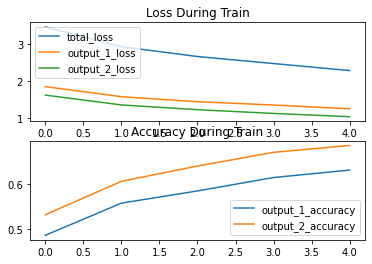

In [15]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss During Train')
pyplot.plot(history.history['loss'], label='total_loss')
pyplot.plot(history.history['output_loss'], label='output_1_loss')
pyplot.plot(history.history['output_1_loss'], label='output_2_loss')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy During Train')
pyplot.plot(history.history['output_output_output_output_output_output_output_output_output_output_output_output_output_output_accuracy'], label='output_1_accuracy')
pyplot.plot(history.history['output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_accuracy'], label='output_2_accuracy')
pyplot.legend()
pyplot.show()

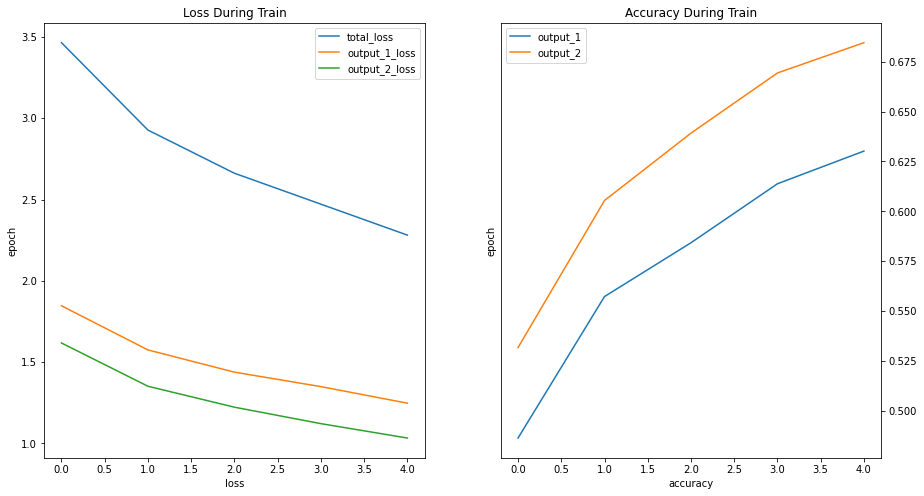

In [31]:
fig, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax1.plot(history.history['loss'], label='total_loss')
ax1.set_title('Loss During Train')
ax1.set_xlabel('loss')
ax1.set_ylabel('epoch')
ax1.plot(history.history['output_loss'], label='output_1_loss')
ax1.plot(history.history['output_1_loss'], label='output_2_loss')
ax1.legend()

ax2.plot(history.history['output_output_output_output_output_output_output_output_output_output_output_output_output_output_accuracy'], label='output_1')
ax2.plot(history.history['output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_output_1_accuracy'], label='output_2')
ax2.legend()
ax2.set_title('Accuracy During Train')
ax2.set_xlabel('accuracy')
ax2.yaxis.tick_right()
ax2.set_ylabel('epoch')
pyplot.show()

In [32]:
vectors = Vectors().load_vectors()


def processForModel(context, question, span):
        context = [context]
        question = [question]
        passage = [pas.strip() for pas in context]
        cont = []
        for pas in passage:
            context_tokens = pas.split(" ")
            cont.append(context_tokens)
        original_passage = [pas.lower() for pas in passage]
        quest = []
        for ques in question:
            question_tokens = ques.split(" ")
            quest.append(question_tokens)
        context_batch = vectors.query(cont)
        question_batch = vectors.query(quest)
        pad1 = np.zeros(shape=(1, 250 - len(cont[0]), 400))
        context_batch = np.concatenate((context_batch, pad1), 1)

        pad2 = np.zeros(shape=(1, 20 - len(quest[0]), 400))
        question_batch = np.concatenate((question_batch, pad2), 1)
        answer_span = span.split()
        output1 = np.zeros(shape=(1, 250), dtype=float)
        output2 = np.zeros(shape=(1, 250), dtype=float)
        output1[0][int(answer_span[0])] = 1
        output2[0][int(answer_span[1])] = 1
        # context_batch = tf.convert_to_tensor(context_batch, tf.float32)
        # question_batch = tf.convert_to_tensor(question_batch, tf.float32)
        # output1 = tf.convert_to_tensor(output1, tf.float32)
        # output2 = tf.convert_to_tensor(output2, tf.float32)

        return context_batch, question_batch, output1, output2


In [47]:
# bidef = BiDAF(400, 250, 20)
# bidef.load_bidaf('drive/My Drive/app/bidaf250_15.h5')
context = "in four months , aonuma 's team managed to present realistic horseback riding , [ l ] which nintendo later revealed to the public with a trailer at electronic entertainment expo 2004 . the game was scheduled to be released the next year , and was no longer a follow-up to the wind waker ; a true sequel to it was released for the nintendo ds in 2007 , in the form of phantom hourglass . miyamoto explained in interviews that the graphical style was chosen to satisfy demand , and that it better fit the theme of an older incarnation of link . the game runs on a modified the wind waker engine ."
question = "where did nintendo preview the horseback riding feature ?"
context = 'from the beginning of 2014 , madonna began to make multiple media appearances . she appeared at the 56th annual grammy awards in january 2014 , performing " open your heart " alongside rappers macklemore & ryan lewis and singer mary lambert , who sang their single " same love " , as 33 couples were wed onstage , officiated by queen latifah . days later , she joined singer miley cyrus on her mtv unplugged special , singing a mash-up of " do n\'t tell me " and cyrus \' single " we ca n\'t stop " ( 2013 ) . she also extended her business ventures and in february 2014 the singer premiered mdna skin , a range of skin care products , in tokyo , japan . after visiting her hometown of detroit during may 2014 , madonna decided to contribute funds to three of the city \'s organizations , to help eliminate poverty from there . the singer released a statement saying that she was inspired by their work , adding that " it was obvious to me that i had to get involved and be part of the solution to help detroit recover " .'
question="which singer did she join on mtv unplugged to sing ?"
span = "70 71"
c, q, s1, s2 = processForModel(context, question, span)
p1, p2 = bidef.predict(c, q)

print(np.argmax(p1[0]), np.argmax(p2))




69 70


In [48]:
!cp "drive/My Drive/app/data/preproccess_squad/dev.answer" .
!cp "drive/My Drive/app/data/preproccess_squad/dev.context" .
!cp "drive/My Drive/app/data/preproccess_squad/dev.question" .
!cp "drive/My Drive/app/data/preproccess_squad/dev.span" .

In [58]:
    with tf.device('/device:GPU:0'):
        context_data = []
        question_data = []
        output_data1 = []
        output_data2 = []
        i = 0
        o1 = 0
        o2 = 0
        sample_size = 100
        vectors = Vectors().load_vectors()
        with open("dev.context", 'r', encoding='utf8') as context_file, \
                open("dev.question", 'r', encoding='utf8') as question_file, \
                open("dev.span", 'r', encoding='utf8') as span_file:

            for context, question, span in zip(tqdm(context_file, total=sample_size),
                                               tqdm(question_file, total=sample_size),
                                               tqdm(span_file, total=sample_size)):

                context = [context]
                question = [question]
                passage = [pas.strip() for pas in context]
                cont = []
                for pas in passage:
                    context_tokens = pas.split(" ")
                    cont.append(context_tokens)
                original_passage = [pas.lower() for pas in passage]
                quest = []
                for ques in question:
                    question_tokens = ques.split(" ")
                    quest.append(question_tokens)
                if len(cont[0]) > 250 or len(quest[0]) > 20:
                  continue
                context_batch = vectors.query(cont)
                question_batch = vectors.query(quest)
                pad1 = np.zeros(shape=(1, 250 - len(cont[0]), 400))
                context_batch = np.concatenate((context_batch, pad1), 1)

                pad2 = np.zeros(shape=(1, 20 - len(quest[0]), 400))
                question_batch = np.concatenate((question_batch, pad2), 1)
                answer_span = span.split()
                # output1 = np.zeros(shape=(1, 250), dtype=float)
                # output2 = np.zeros(shape=(1, 250), dtype=float)
                # output1[0][int(answer_span[0])] = 1
                # output2[0][int(answer_span[1])] = 1
                p1, p2 = bidef.predict(context_batch, question_batch)
                i1 = np.argmax(p1)
                i2 = np.argmax(p2)
                # print(answer_span, i1, i2)

                if np.abs(i1-int(answer_span[0])) < 3:
                  o1+=1
                if np.abs(i2-int(answer_span[1])) < 3:
                  o2+=1
                  print(o2)
                i = i + 1
                if i == sample_size:
                    break
                print(i)

        
        output1_acc = o1/sample_size
        output2_acc = o2/sample_size

        print(f'output_1 accuracy: {output1_acc} output_2 accuracy: {output2_acc}')
        print(f'total_avg accuracy: {(output1_acc+output2_acc)/2}')

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:52,  1.89it/s]

  1%|          | 1/100 [00:00<00:51,  1.91it/s]

1
1


  2%|▏         | 2/100 [00:01<00:56,  1.74it/s]

  2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

2


  3%|▎         | 3/100 [00:01<00:46,  2.10it/s]

  3%|▎         | 3/100 [00:01<00:46,  2.11it/s]

3


  4%|▍         | 4/100 [00:01<00:42,  2.28it/s]

  4%|▍         | 4/100 [00:01<00:42,  2.28it/s]

2
4


  7%|▋         | 7/100 [00:02<00:23,  3.94it/s]

  7%|▋         | 7/100 [00:02<00:23,  3.93it/s]

5


  8%|▊         | 8/100 [00:02<00:26,  3.47it/s]

  8%|▊         | 8/100 [00:02<00:26,  3.47it/s]

6


  9%|▉         | 9/100 [00:03<00:29,  3.05it/s]

  9%|▉         | 9/100 [00:03<00:29,  3.05it/s]

7


 10%|█         | 10/100 [00:03<00:30,  2.99it/s]

 10%|█         | 10/100 [00:03<00:30,  2.99it/s]

8


 11%|█         | 11/100 [00:04<00:33,  2.63it/s]

 11%|█         | 11/100 [00:04<00:33,  2.64it/s]

9


 12%|█▏        | 12/100 [00:04<00:34,  2.53it/s]

 12%|█▏        | 12/100 [00:04<00:34,  2.54it/s]

10


 13%|█▎        | 13/100 [00:04<00:32,  2.71it/s]

 13%|█▎        | 13/100 [00:04<00:32,  2.71it/s]

11


 14%|█▍        | 14/100 [00:05<00:32,  2.63it/s]

 14%|█▍        | 14/100 [00:05<00:32,  2.63it/s]

12


 15%|█▌        | 15/100 [00:05<00:33,  2.56it/s]

 15%|█▌        | 15/100 [00:05<00:33,  2.57it/s]

13


 16%|█▌        | 16/100 [00:05<00:30,  2.75it/s]

 16%|█▌        | 16/100 [00:05<00:30,  2.75it/s]

14


 17%|█▋        | 17/100 [00:06<00:28,  2.92it/s]

 17%|█▋        | 17/100 [00:06<00:28,  2.91it/s]

15


 18%|█▊        | 18/100 [00:06<00:28,  2.86it/s]

 18%|█▊        | 18/100 [00:06<00:28,  2.85it/s]

16


 19%|█▉        | 19/100 [00:06<00:26,  3.01it/s]

 19%|█▉        | 19/100 [00:06<00:26,  3.00it/s]

17


 20%|██        | 20/100 [00:07<00:29,  2.71it/s]

 20%|██        | 20/100 [00:07<00:29,  2.72it/s]

18


 21%|██        | 21/100 [00:07<00:29,  2.69it/s]

 21%|██        | 21/100 [00:07<00:29,  2.69it/s]

19


 23%|██▎       | 23/100 [00:08<00:23,  3.24it/s]

 23%|██▎       | 23/100 [00:08<00:23,  3.24it/s]

20


 24%|██▍       | 24/100 [00:08<00:27,  2.72it/s]

 24%|██▍       | 24/100 [00:08<00:27,  2.73it/s]

21


 25%|██▌       | 25/100 [00:09<00:29,  2.53it/s]

 25%|██▌       | 25/100 [00:09<00:29,  2.53it/s]

22


 26%|██▌       | 26/100 [00:09<00:27,  2.68it/s]

 26%|██▌       | 26/100 [00:09<00:27,  2.67it/s]

3
23


 27%|██▋       | 27/100 [00:10<00:32,  2.27it/s]

 27%|██▋       | 27/100 [00:10<00:32,  2.27it/s]

24


 28%|██▊       | 28/100 [00:10<00:30,  2.33it/s]

 28%|██▊       | 28/100 [00:10<00:30,  2.33it/s]

25


 29%|██▉       | 29/100 [00:10<00:29,  2.37it/s]

 29%|██▉       | 29/100 [00:10<00:29,  2.37it/s]

26


 30%|███       | 30/100 [00:11<00:28,  2.46it/s]

 30%|███       | 30/100 [00:11<00:28,  2.46it/s]

27


 31%|███       | 31/100 [00:11<00:27,  2.51it/s]

 31%|███       | 31/100 [00:11<00:27,  2.51it/s]

28


 32%|███▏      | 32/100 [00:11<00:26,  2.59it/s]

 32%|███▏      | 32/100 [00:11<00:26,  2.58it/s]

4
29


 33%|███▎      | 33/100 [00:12<00:25,  2.61it/s]

 33%|███▎      | 33/100 [00:12<00:25,  2.60it/s]

30


 35%|███▌      | 35/100 [00:12<00:20,  3.12it/s]

 35%|███▌      | 35/100 [00:12<00:20,  3.12it/s]

31


 36%|███▌      | 36/100 [00:13<00:24,  2.66it/s]

 36%|███▌      | 36/100 [00:13<00:23,  2.67it/s]

32


 37%|███▋      | 37/100 [00:13<00:24,  2.59it/s]

 37%|███▋      | 37/100 [00:13<00:24,  2.59it/s]

33


 39%|███▉      | 39/100 [00:14<00:20,  3.04it/s]

 39%|███▉      | 39/100 [00:14<00:20,  3.04it/s]

34


 40%|████      | 40/100 [00:14<00:21,  2.82it/s]

 40%|████      | 40/100 [00:14<00:21,  2.83it/s]

35


 41%|████      | 41/100 [00:15<00:21,  2.78it/s]

 41%|████      | 41/100 [00:15<00:21,  2.78it/s]

36


 42%|████▏     | 42/100 [00:15<00:20,  2.79it/s]

 42%|████▏     | 42/100 [00:15<00:20,  2.79it/s]

37


 43%|████▎     | 43/100 [00:15<00:21,  2.62it/s]

 43%|████▎     | 43/100 [00:15<00:21,  2.62it/s]

38


 44%|████▍     | 44/100 [00:16<00:22,  2.44it/s]

 44%|████▍     | 44/100 [00:16<00:22,  2.44it/s]

5
39


 45%|████▌     | 45/100 [00:16<00:22,  2.49it/s]

 45%|████▌     | 45/100 [00:16<00:22,  2.50it/s]

40


 46%|████▌     | 46/100 [00:17<00:20,  2.59it/s]

 46%|████▌     | 46/100 [00:17<00:20,  2.60it/s]

41


 47%|████▋     | 47/100 [00:17<00:20,  2.62it/s]

 47%|████▋     | 47/100 [00:17<00:20,  2.61it/s]

6
42


 48%|████▊     | 48/100 [00:18<00:21,  2.42it/s]

 48%|████▊     | 48/100 [00:18<00:21,  2.42it/s]

43


 49%|████▉     | 49/100 [00:18<00:20,  2.44it/s]

 49%|████▉     | 49/100 [00:18<00:20,  2.44it/s]

44


 50%|█████     | 50/100 [00:18<00:18,  2.74it/s]

 50%|█████     | 50/100 [00:18<00:18,  2.72it/s]

45


 51%|█████     | 51/100 [00:19<00:18,  2.58it/s]

 51%|█████     | 51/100 [00:19<00:18,  2.58it/s]

46


 52%|█████▏    | 52/100 [00:19<00:18,  2.54it/s]

 52%|█████▏    | 52/100 [00:19<00:18,  2.54it/s]

47


 53%|█████▎    | 53/100 [00:19<00:19,  2.42it/s]

 53%|█████▎    | 53/100 [00:19<00:19,  2.43it/s]

7
48


 54%|█████▍    | 54/100 [00:20<00:18,  2.43it/s]

 54%|█████▍    | 54/100 [00:20<00:18,  2.43it/s]

49


 55%|█████▌    | 55/100 [00:20<00:17,  2.54it/s]

 55%|█████▌    | 55/100 [00:20<00:17,  2.54it/s]

50


 56%|█████▌    | 56/100 [00:21<00:16,  2.72it/s]

 56%|█████▌    | 56/100 [00:21<00:16,  2.73it/s]

8
51


 57%|█████▋    | 57/100 [00:21<00:16,  2.60it/s]

 57%|█████▋    | 57/100 [00:21<00:16,  2.60it/s]

52


 58%|█████▊    | 58/100 [00:21<00:17,  2.37it/s]

 58%|█████▊    | 58/100 [00:21<00:17,  2.37it/s]

53


 59%|█████▉    | 59/100 [00:22<00:17,  2.40it/s]

 59%|█████▉    | 59/100 [00:22<00:17,  2.39it/s]

54


 60%|██████    | 60/100 [00:22<00:16,  2.35it/s]

 60%|██████    | 60/100 [00:22<00:16,  2.36it/s]

55


 61%|██████    | 61/100 [00:23<00:15,  2.51it/s]

 61%|██████    | 61/100 [00:23<00:15,  2.52it/s]

56


 62%|██████▏   | 62/100 [00:23<00:15,  2.53it/s]

 62%|██████▏   | 62/100 [00:23<00:15,  2.52it/s]

57


 63%|██████▎   | 63/100 [00:23<00:13,  2.82it/s]

 63%|██████▎   | 63/100 [00:23<00:13,  2.82it/s]

58


 64%|██████▍   | 64/100 [00:24<00:15,  2.34it/s]

 64%|██████▍   | 64/100 [00:24<00:15,  2.34it/s]

59


 65%|██████▌   | 65/100 [00:24<00:14,  2.43it/s]

 65%|██████▌   | 65/100 [00:24<00:14,  2.44it/s]

60


 66%|██████▌   | 66/100 [00:25<00:15,  2.24it/s]

 66%|██████▌   | 66/100 [00:25<00:15,  2.23it/s]

61


 67%|██████▋   | 67/100 [00:25<00:14,  2.23it/s]

 67%|██████▋   | 67/100 [00:25<00:14,  2.23it/s]

9
62


 68%|██████▊   | 68/100 [00:26<00:13,  2.42it/s]

 68%|██████▊   | 68/100 [00:26<00:13,  2.42it/s]

63


 69%|██████▉   | 69/100 [00:26<00:13,  2.36it/s]

 69%|██████▉   | 69/100 [00:26<00:13,  2.36it/s]

64


 70%|███████   | 70/100 [00:26<00:12,  2.44it/s]

 70%|███████   | 70/100 [00:26<00:12,  2.45it/s]

65


 71%|███████   | 71/100 [00:27<00:12,  2.25it/s]

 71%|███████   | 71/100 [00:27<00:12,  2.23it/s]

66


 72%|███████▏  | 72/100 [00:27<00:12,  2.31it/s]

 72%|███████▏  | 72/100 [00:27<00:12,  2.33it/s]

67


 73%|███████▎  | 73/100 [00:28<00:11,  2.36it/s]

 73%|███████▎  | 73/100 [00:28<00:11,  2.35it/s]

68


 74%|███████▍  | 74/100 [00:28<00:10,  2.52it/s]

 74%|███████▍  | 74/100 [00:28<00:10,  2.52it/s]

69


 75%|███████▌  | 75/100 [00:28<00:09,  2.57it/s]

 75%|███████▌  | 75/100 [00:28<00:09,  2.58it/s]

70


 76%|███████▌  | 76/100 [00:29<00:09,  2.55it/s]

 76%|███████▌  | 76/100 [00:29<00:09,  2.54it/s]

71


 77%|███████▋  | 77/100 [00:29<00:08,  2.68it/s]

 77%|███████▋  | 77/100 [00:29<00:08,  2.68it/s]

10
72


 78%|███████▊  | 78/100 [00:30<00:08,  2.53it/s]

 78%|███████▊  | 78/100 [00:30<00:08,  2.52it/s]

73


 79%|███████▉  | 79/100 [00:30<00:07,  2.64it/s]

 79%|███████▉  | 79/100 [00:30<00:08,  2.62it/s]

74


 80%|████████  | 80/100 [00:30<00:07,  2.67it/s]

 80%|████████  | 80/100 [00:30<00:07,  2.67it/s]

75


 81%|████████  | 81/100 [00:31<00:06,  2.75it/s]

 81%|████████  | 81/100 [00:31<00:06,  2.76it/s]

76


 82%|████████▏ | 82/100 [00:31<00:06,  2.85it/s]

 82%|████████▏ | 82/100 [00:31<00:06,  2.86it/s]

77


 84%|████████▍ | 84/100 [00:31<00:04,  3.37it/s]

 84%|████████▍ | 84/100 [00:31<00:04,  3.36it/s]

78


 85%|████████▌ | 85/100 [00:32<00:04,  3.20it/s]

 85%|████████▌ | 85/100 [00:32<00:04,  3.21it/s]

79


 86%|████████▌ | 86/100 [00:32<00:04,  2.92it/s]

 86%|████████▌ | 86/100 [00:32<00:04,  2.92it/s]

80


 87%|████████▋ | 87/100 [00:33<00:04,  2.89it/s]

 87%|████████▋ | 87/100 [00:33<00:04,  2.88it/s]

81


 88%|████████▊ | 88/100 [00:33<00:04,  2.94it/s]

 88%|████████▊ | 88/100 [00:33<00:04,  2.95it/s]

82


 89%|████████▉ | 89/100 [00:33<00:03,  2.86it/s]

 89%|████████▉ | 89/100 [00:33<00:03,  2.88it/s]

83


 90%|█████████ | 90/100 [00:34<00:03,  2.96it/s]

 90%|█████████ | 90/100 [00:34<00:03,  2.96it/s]

84


 91%|█████████ | 91/100 [00:34<00:03,  2.93it/s]

 91%|█████████ | 91/100 [00:34<00:03,  2.92it/s]

85


 92%|█████████▏| 92/100 [00:34<00:02,  3.09it/s]

 92%|█████████▏| 92/100 [00:34<00:02,  3.09it/s]

86


 93%|█████████▎| 93/100 [00:35<00:02,  3.06it/s]

 93%|█████████▎| 93/100 [00:35<00:02,  3.06it/s]

87


 94%|█████████▍| 94/100 [00:35<00:02,  2.85it/s]

 94%|█████████▍| 94/100 [00:35<00:02,  2.83it/s]

88


 95%|█████████▌| 95/100 [00:35<00:01,  2.75it/s]

 95%|█████████▌| 95/100 [00:35<00:01,  2.77it/s]

89


 96%|█████████▌| 96/100 [00:36<00:01,  3.03it/s]

 96%|█████████▌| 96/100 [00:36<00:01,  3.04it/s]

90


 97%|█████████▋| 97/100 [00:36<00:01,  2.87it/s]

 97%|█████████▋| 97/100 [00:36<00:01,  2.87it/s]

91


 98%|█████████▊| 98/100 [00:37<00:00,  2.56it/s]

 98%|█████████▊| 98/100 [00:37<00:00,  2.56it/s]

92


 99%|█████████▉| 99/100 [00:37<00:00,  2.44it/s]

 99%|█████████▉| 99/100 [00:37<00:00,  2.45it/s]

93


100%|██████████| 100/100 [00:37<00:00,  2.53it/s]

100%|██████████| 100/100 [00:37<00:00,  2.53it/s]

94


101it [00:38,  2.64it/s]                         
101it [00:38,  2.64it/s]                         

101it [00:38,  2.65it/s]                         

95


102it [00:38,  2.81it/s]
102it [00:38,  2.81it/s]

102it [00:38,  2.82it/s]

96


103it [00:38,  2.49it/s]
103it [00:38,  2.49it/s]

103it [00:38,  2.48it/s]

97


104it [00:39,  2.59it/s]
104it [00:39,  2.59it/s]

104it [00:39,  2.59it/s]

98


105it [00:39,  2.58it/s]
105it [00:39,  2.58it/s]

105it [00:39,  2.58it/s]

11
99


105it [00:40,  2.62it/s]
105it [00:40,  2.62it/s]
105it [00:40,  2.62it/s]

output_1 accuracy: 0.09 output_2 accuracy: 0.11
total_avg accuracy: 0.1
